# Mask RCNN inference


Originally adapted from the example inference notebook at https://github.com/tensorflow/models/blob/master/research/object_detection/object_detection_tutorial.ipynb


# Imports

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
# sys.path.append("..")
from object_detection.utils import ops as utils_ops

if tf.__version__ < '1.4.0':
  raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')

from copy import copy
import cv2
from skimage.morphology import skeletonize

import time
import datetime
import pickle

# This is needed to display the images.
%matplotlib inline

from tensorflow.models.research.object_detection.utils import label_map_util
from tensorflow.models.research.object_detection.utils import visualization_utils as vis_util

from utility_functions import load_image_into_numpy_array
from utility_functions import run_inference_for_single_image

/Users/daniel/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/daniel/anaconda3/lib/python3.6/site-packages/tensorflow/models/research/object_detection/utils/visualization_utils.py:25: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/daniel/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/daniel/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  Fi

# Model preparation 

In [2]:
# Path to frozen detection graph.
MODEL_NAME = 'resnet_101_atrous/fine_tuned_model_200k_poisson_brightness'
PATH_TO_CKPT = os.path.join('./downloaded_models', MODEL_NAME, 'frozen_inference_graph.pb')

## Load a (frozen) Tensorflow model into memory.

In [3]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading label map


In [4]:
PATH_TO_LABELS = '/Users/daniel/Documents/UCL/Project/Code/tensorflow_Mask_RCNN/data/worm_label_map.pbtxt'
NUM_CLASSES = 1

label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


# Load images for inference

In [5]:
NUM_IMAGES = 50

# DATASET_DIR = './data/fullsize_images/'
DATASET_DIR = '../../Data/annotation-data/fullsize_collated_dataset/'

datasets = [f for f in os.listdir(DATASET_DIR) if not f.startswith('.')]
print(datasets)

['JU2234_worms10_food1-10_Set1_Pos4_Ch3_20102017_125033', 'N2_worms10_CSCD068947_1_Set1_Pos4_Ch4_08082017_210418', 'CX11271_worms10_food1-10_Set1_Pos4_Ch4_19052017_113042', 'JU2587_worms10_food1-10_Set1_Pos4_Ch1_20102017_125044', 'NIC199_worms10_food1-10_Set7_Pos4_Ch4_19052017_153012', 'JU2578_worms10_food1-10_Set1_Pos4_Ch4_20102017_125033', 'VC2010_worms10_food1-10_Set1_Pos4_Ch6_20122017_150107', 'ED3049_worms10_food1-10_Set6_Pos5_Ch4_19052017_151021', 'N2_worms10_CSCD068947_10_Set2_Pos5_Ch1_08082017_212337', 'N2_worms10_food1-10_Set1_Pos4_Ch5_20102017_125024', 'JU360_worms10_food1-10_Set6_Pos5_Ch6_19052017_151012', 'CB4856_worms10_food1-10_Set1_Pos4_Ch2_20102017_125044']


In [6]:
dataset = datasets[2]
print("Running inference on dataset {}".format(dataset))

PATH_TO_TEST_IMAGES_DIR = os.path.join(DATASET_DIR, dataset)
# PATH_TO_TEST_IMAGES_DIR = '/Users/daniel/Documents/UCL/Project/Data/annotation-data/fullsize_collated_dataset/NIC199_worms10_food1-10_Set7_Pos4_Ch4_19052017_153012/'


FNAMES = [f for f in os.listdir(PATH_TO_TEST_IMAGES_DIR) if not f.startswith('.')]
FNAMES = sorted(FNAMES, key=int)[:NUM_IMAGES]
# TEST_IMAGE_PATHS = [os.path.join(PATH_TO_TEST_IMAGES_DIR, '{}/image/image_{}.png'.format(i,i)) for i in FNAMES] # np.random.choice(len(FNAMES), size=NUM_IMAGES, replace=False)]

# Size of output images.
IMAGE_SIZE = (40,40)

Running inference on dataset CX11271_worms10_food1-10_Set1_Pos4_Ch4_19052017_113042


# Detection

In [7]:
output_dicts_list = []
inference_times = []

visualise_outputs = False
save_anns_to_file = False
save_overlays_to_file = False


for fName in FNAMES:
    
    image_path = os.path.join(PATH_TO_TEST_IMAGES_DIR, '{}/image/image_{}.png'.format(fName,fName))

    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    
    start = datetime.datetime.now()

    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    
    end = datetime.datetime.now()
    elapsed = end - start
    print("Inference for one image: {}.{}s".format(elapsed.seconds,round(elapsed.microseconds,2))) 
    inference_times.append(elapsed.seconds)

    if visualise_outputs:
        vis_util.visualize_boxes_and_labels_on_image_array(
          image_np,
          output_dict['detection_boxes'],
          output_dict['detection_classes'],
          output_dict['detection_scores'],
          category_index,
          instance_masks=output_dict.get('detection_masks'),
          use_normalized_coordinates=True,
          line_thickness=2)
        plt.figure(figsize=IMAGE_SIZE)
        plt.title("Image {}".format(image_path[:-4]))
        plt.imshow(image_np)
        plt.show()
        plt.close()

    # Keeping only worms which scored > 0.5
    found_worms = np.where(output_dict['detection_scores'] > 0.5)
    output_dict['detection_boxes'] = output_dict['detection_boxes'][found_worms]
    output_dict['detection_classes'] = output_dict['detection_classes'][found_worms]
    output_dict['detection_scores'] = output_dict['detection_scores'][found_worms]
    output_dict['detection_masks'] = output_dict['detection_masks'][found_worms]
    output_dict['skeletons'] = []
    output_dict['frame_num'] = fName
    
    for m in output_dict['detection_masks']:
        output_dict['skeletons'].append(skeletonize(m).astype(np.uint8))

    
    OUTPUT_DIR_PATH = os.path.join('./data/inference_outputs', MODEL_NAME, dataset)

    
    if save_anns_to_file:
        #Save outputs to Pickle file
        os.makedirs(os.path.join(OUTPUT_DIR_PATH, 'annotations'), exist_ok=True)
        ANNS_OUTPUT_PATH = os.path.join(OUTPUT_DIR_PATH,'annotations', fName) + '.pickle'
        with open(ANNS_OUTPUT_PATH, 'wb') as fp:
            pickle.dump(output_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)
            
    if save_overlays_to_file:
        #save image with annotations overlaid to file
        os.makedirs(os.path.join(OUTPUT_DIR_PATH, 'images'), exist_ok=True)
        IMG_OUTPUT_PATH = os.path.join(OUTPUT_DIR_PATH,'images', fName) + '.png'
        
        plt.figure(figsize=IMAGE_SIZE)
        
        # If the image ahsn't already been visualised, we need 
        # to add the masks and boxes now
        if not visualise_outputs:
            vis_util.visualize_boxes_and_labels_on_image_array(
              image_np,
              output_dict['detection_boxes'],
              output_dict['detection_classes'],
              output_dict['detection_scores'],
              category_index,
              instance_masks=output_dict.get('detection_masks'),
              use_normalized_coordinates=True,
              line_thickness=1)
            
        plt.imshow(image_np)
        plt.axis('off')
        plt.savefig(fname=IMG_OUTPUT_PATH, bbox_inches='tight', pad_inches=0)
        plt.close
        
    
    output_dicts_list.append(output_dict)
    

Inference for one image: 111.25242s
Inference for one image: 101.806904s
Inference for one image: 103.555209s
Inference for one image: 109.186400s
Inference for one image: 110.363949s
Inference for one image: 105.945994s
Inference for one image: 104.563685s
Inference for one image: 101.707107s
Inference for one image: 100.664620s
Inference for one image: 99.498747s
Inference for one image: 99.392882s
Inference for one image: 99.872131s
Inference for one image: 99.469936s
Inference for one image: 99.745145s
Inference for one image: 99.821175s
Inference for one image: 99.826131s
Inference for one image: 103.584783s
Inference for one image: 99.879010s
Inference for one image: 100.754890s
Inference for one image: 102.221278s
Inference for one image: 104.214695s
Inference for one image: 117.946615s
Inference for one image: 111.954838s
Inference for one image: 107.167758s
Inference for one image: 106.269469s
Inference for one image: 102.31330s
Inference for one image: 103.829319s
Inference f

In [8]:
mean_time = round(sum(inference_times) / len(inference_times), 2)
print("Average inference time for {} images: {}s".format(NUM_IMAGES, mean_time))

Average inference time for 50 images: 102.86s


# Skeletonisation


Visualise the last image and its skeletons as a sense-check

In [9]:
skeletons = np.array(output_dicts_list[-1]['skeletons'])

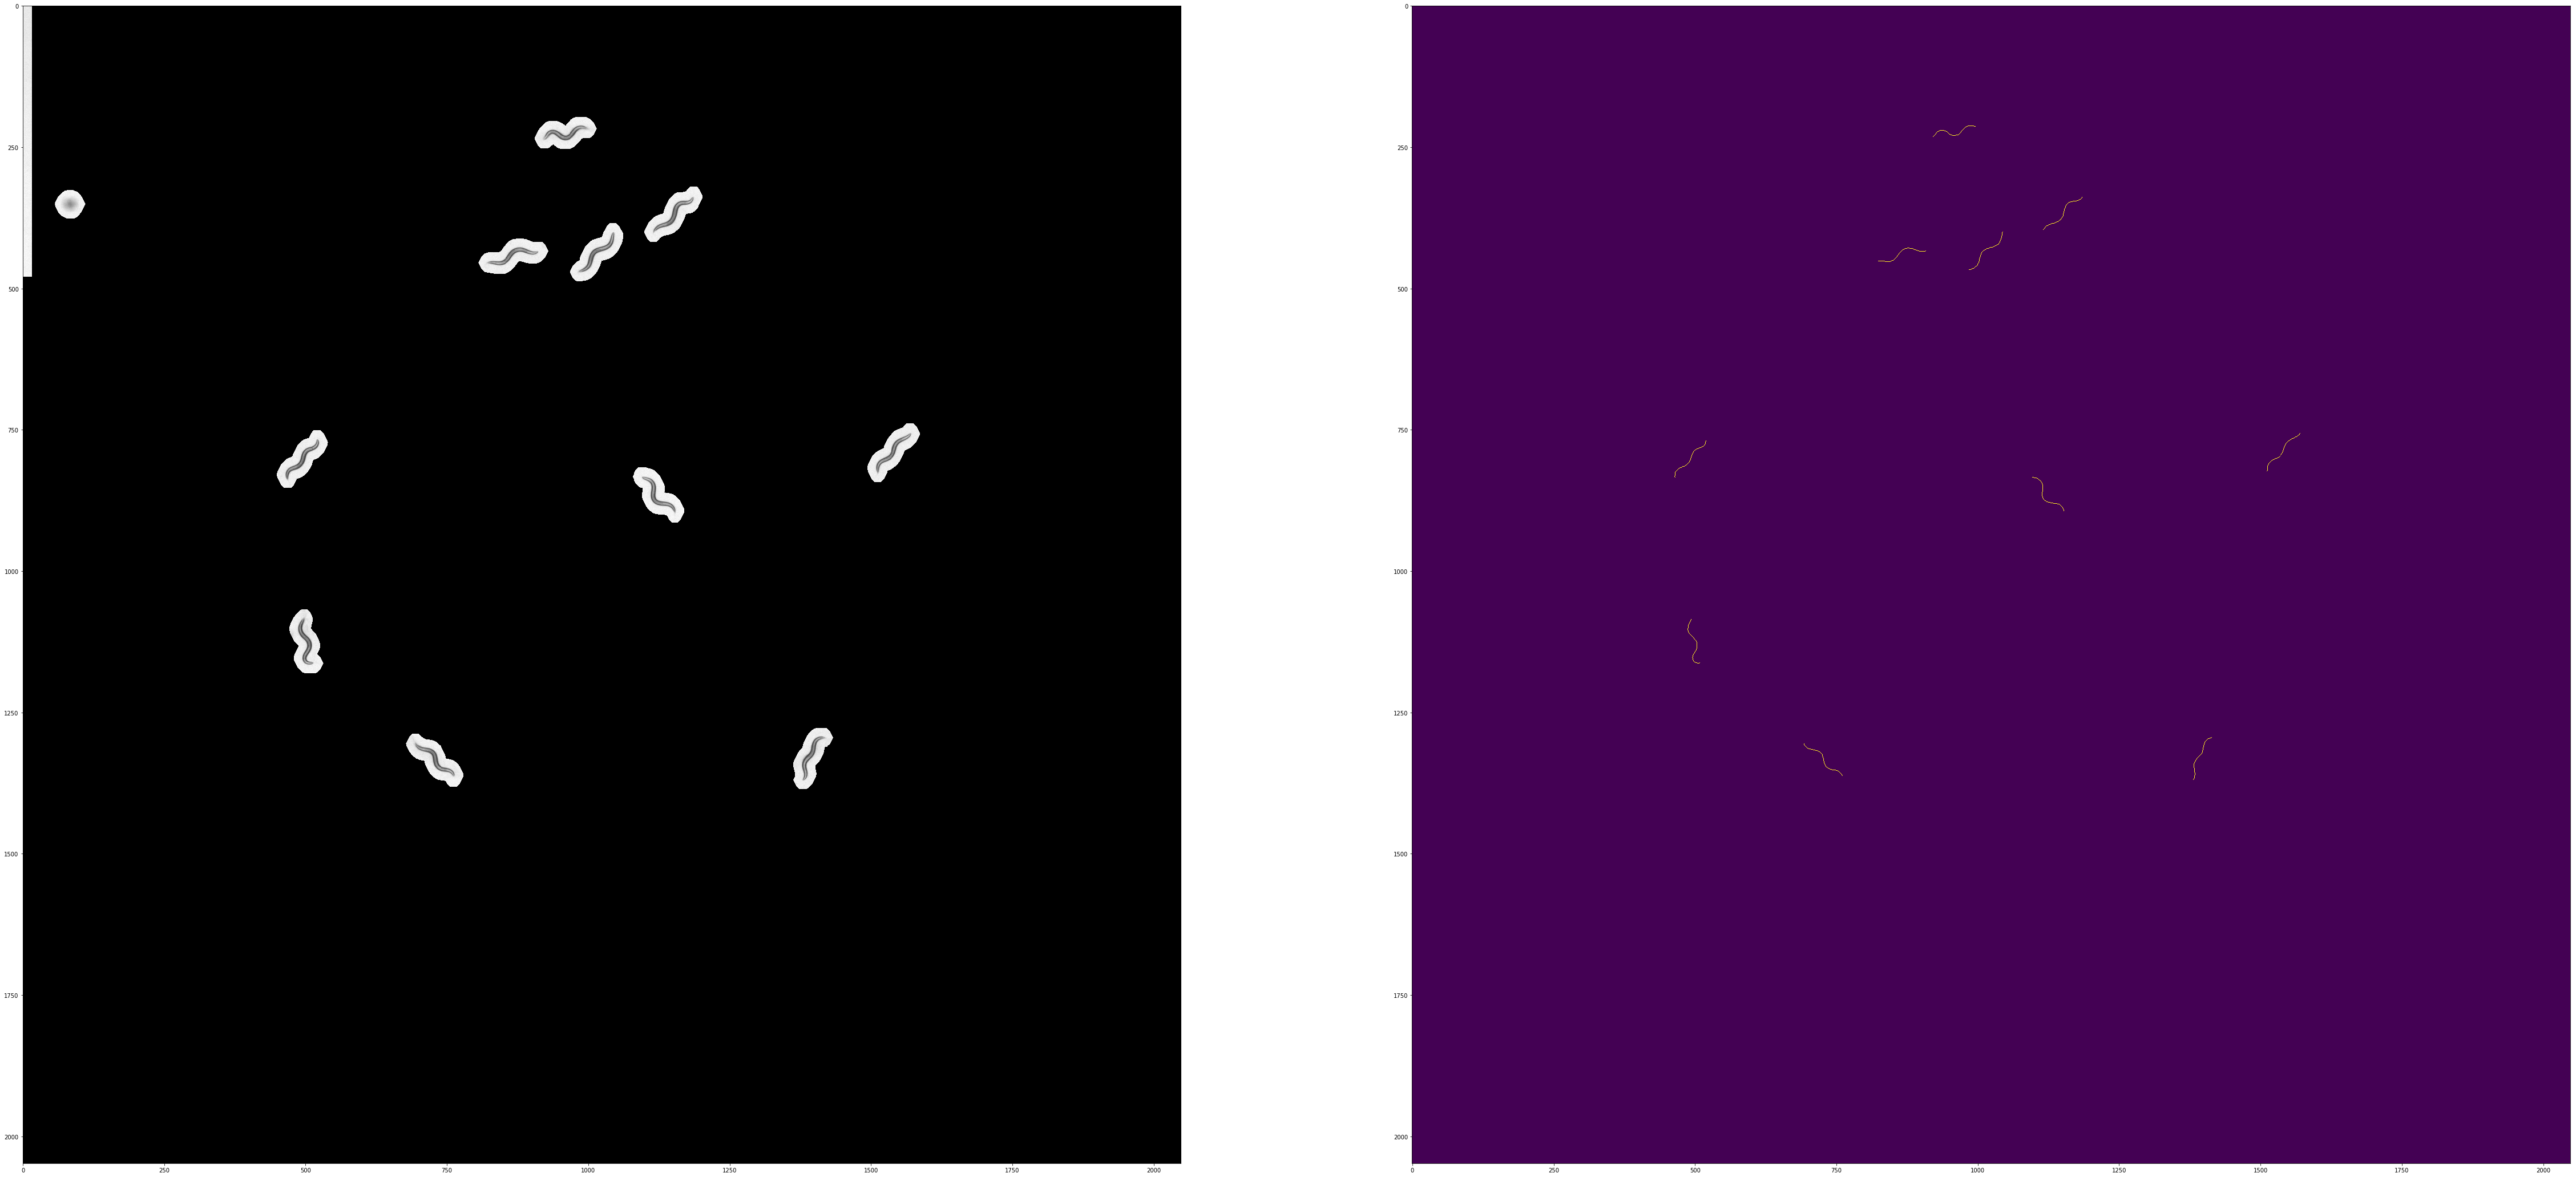

In [10]:
plt.figure(figsize=(80,80))

plt.subplot(1,2,1)
plt.imshow(image_np)

plt.subplot(1,2,2)
plt.imshow(np.sum(skeletons, axis=0))

plt.show()
plt.close()

# Tracking using SORT

In [11]:
from sort import sort
import matplotlib.patches as patches

Worm IDs: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]


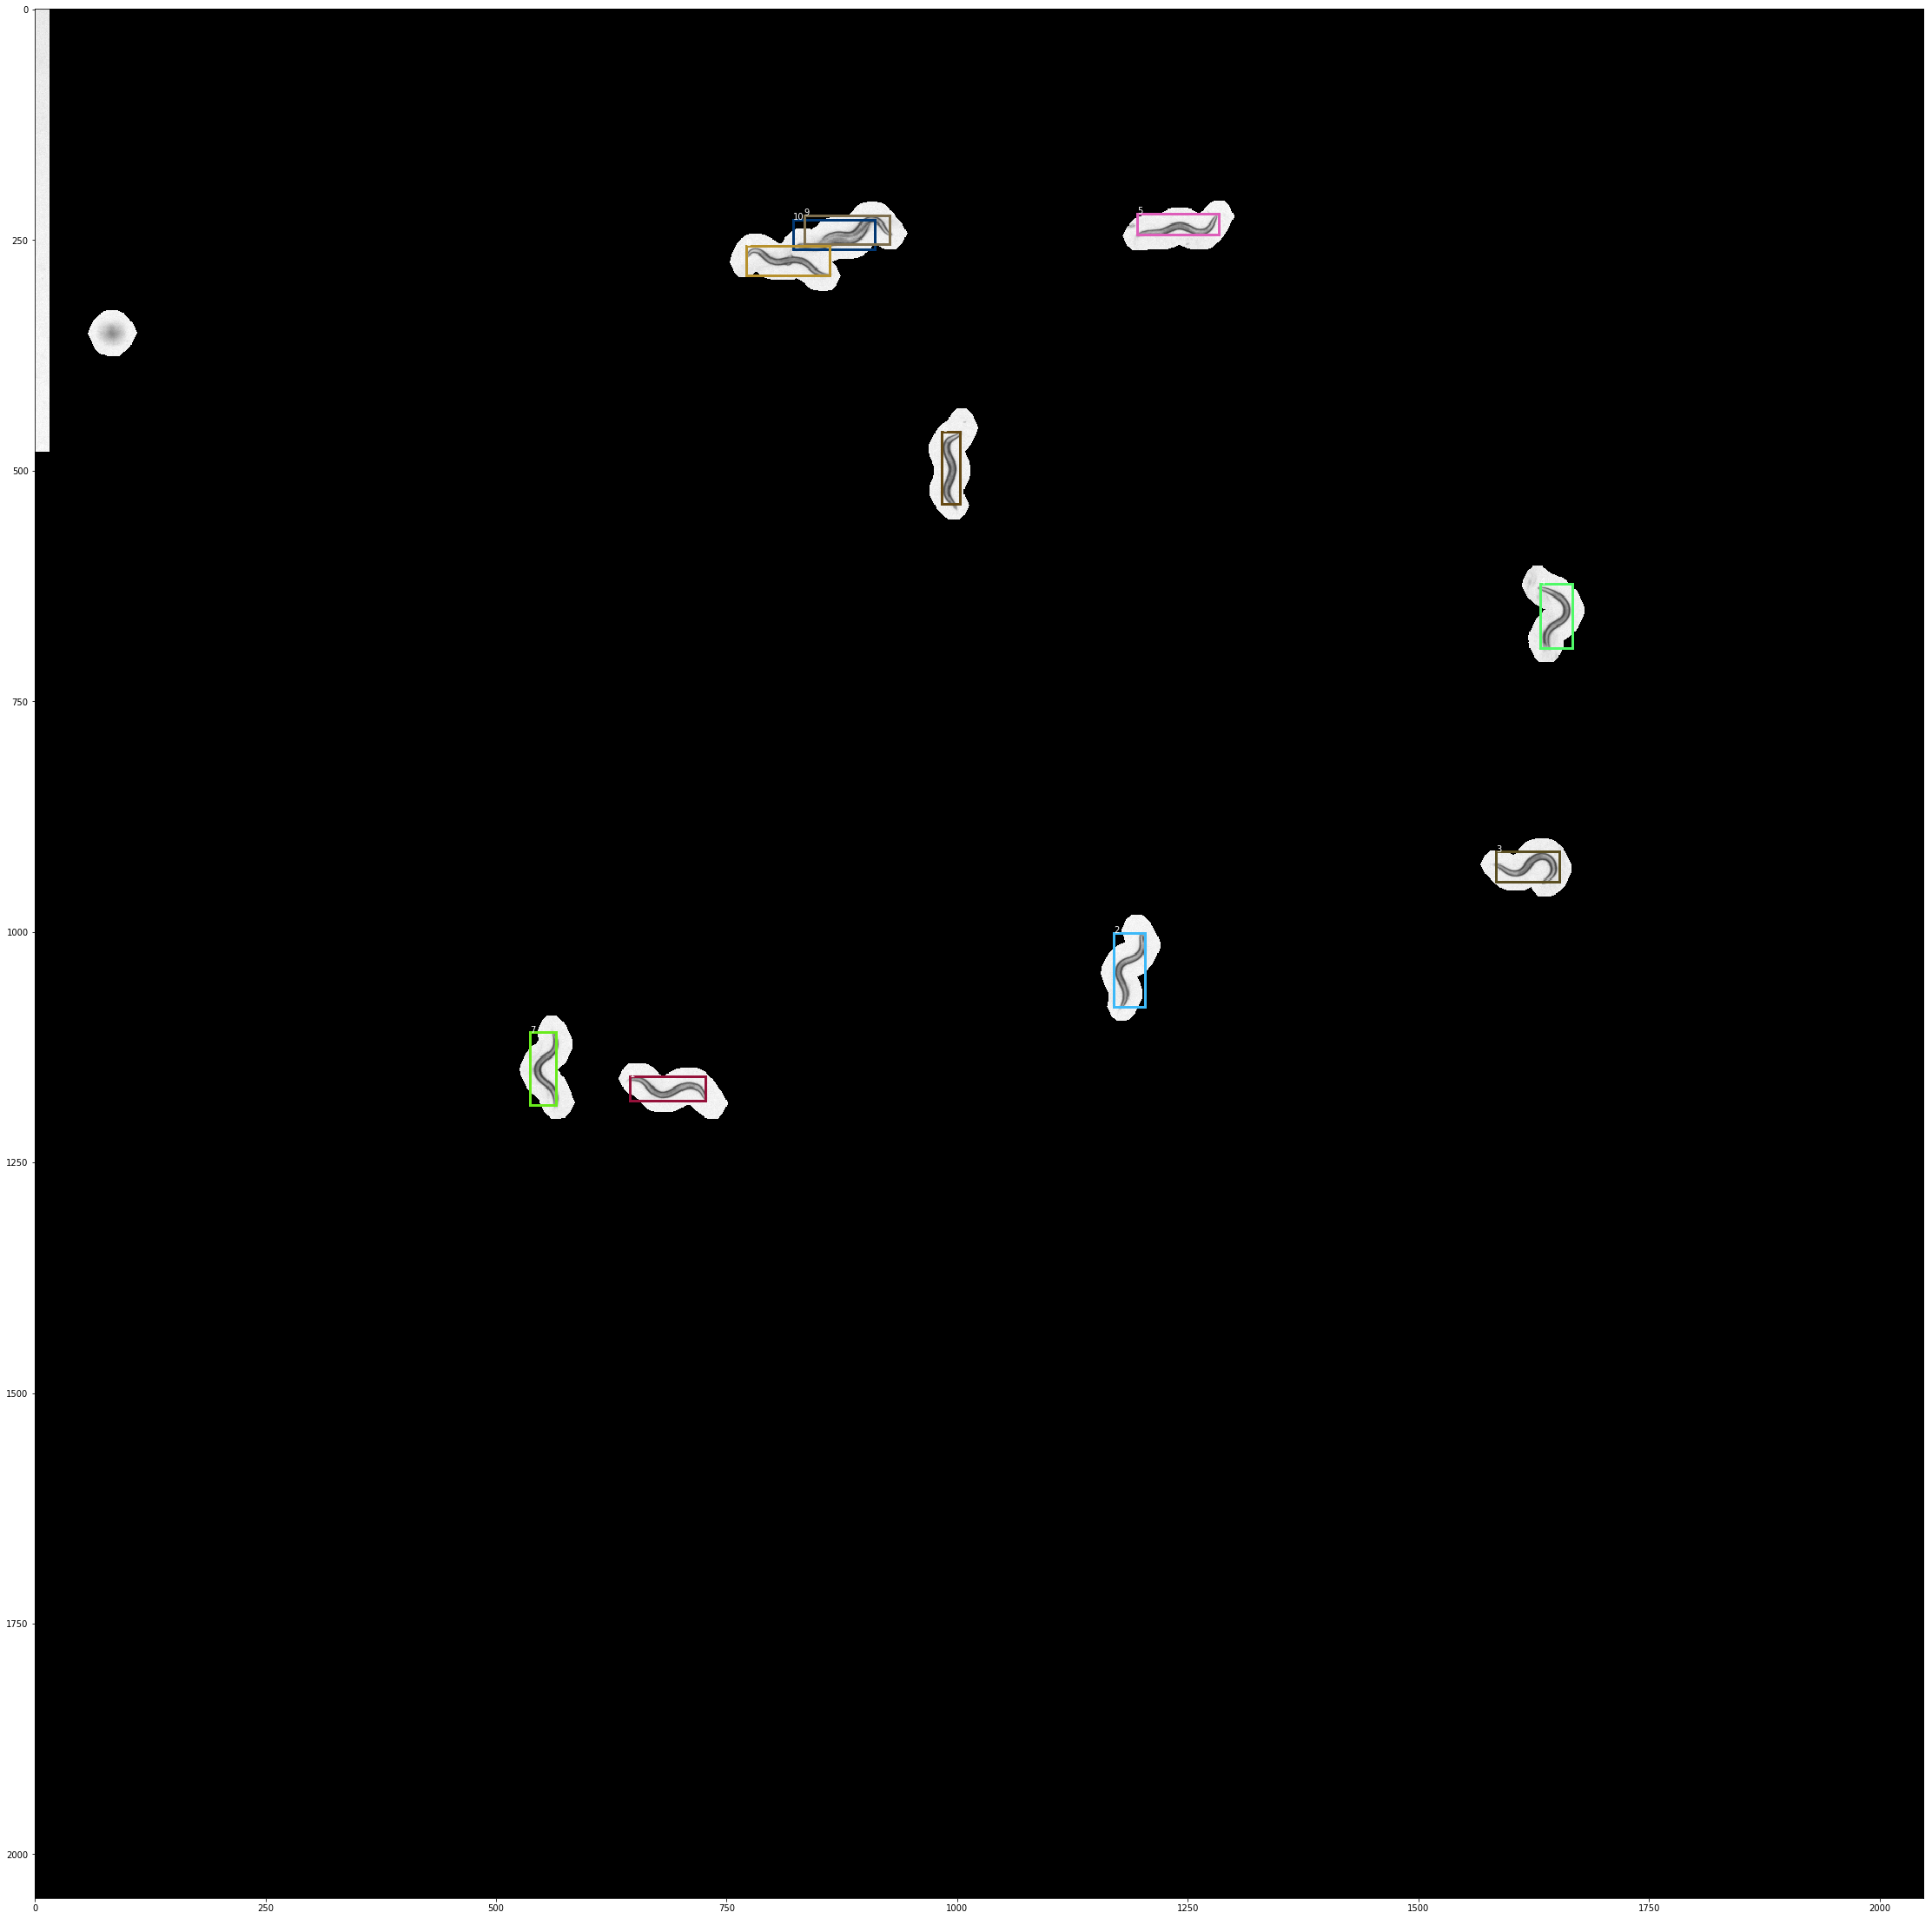

Worm IDs: [3.0, 5.0, 7.0, 8.0, 9.0, 11.0, 12.0, 13.0, 14.0, 15.0]


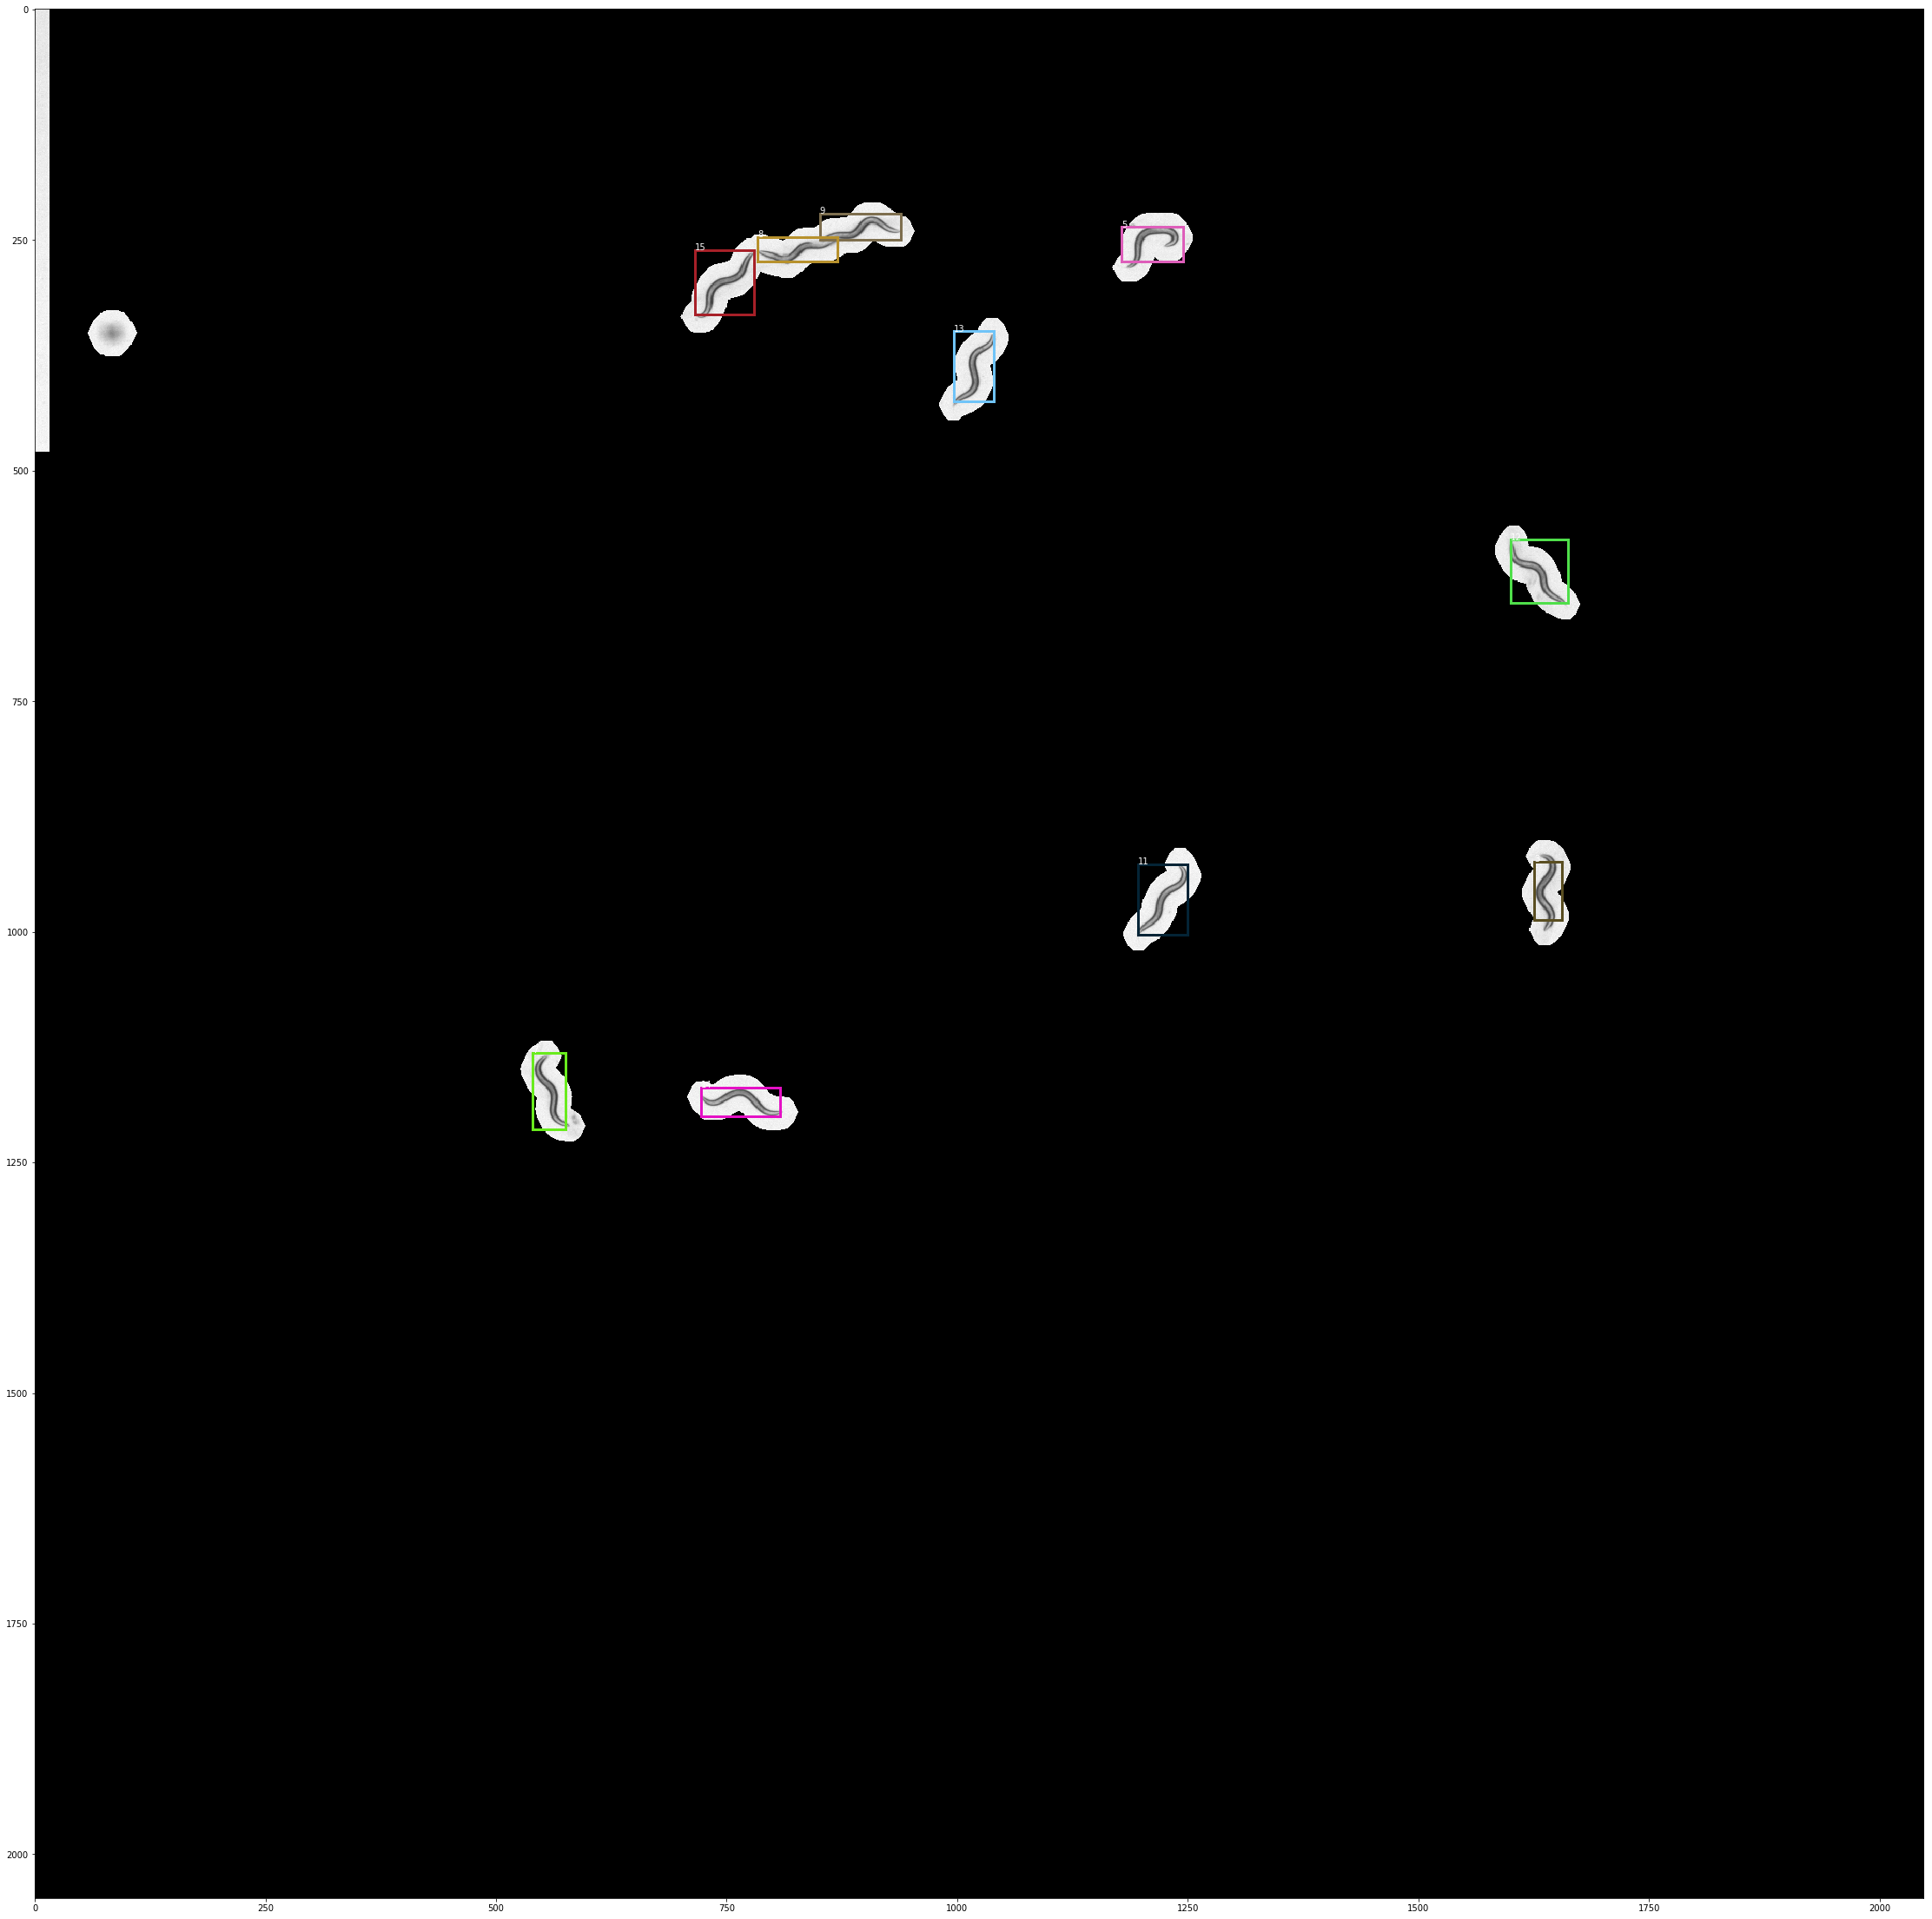

Worm IDs: [7.0, 8.0, 10.0, 11.0, 12.0, 14.0, 15.0, 16.0, 17.0, 18.0]


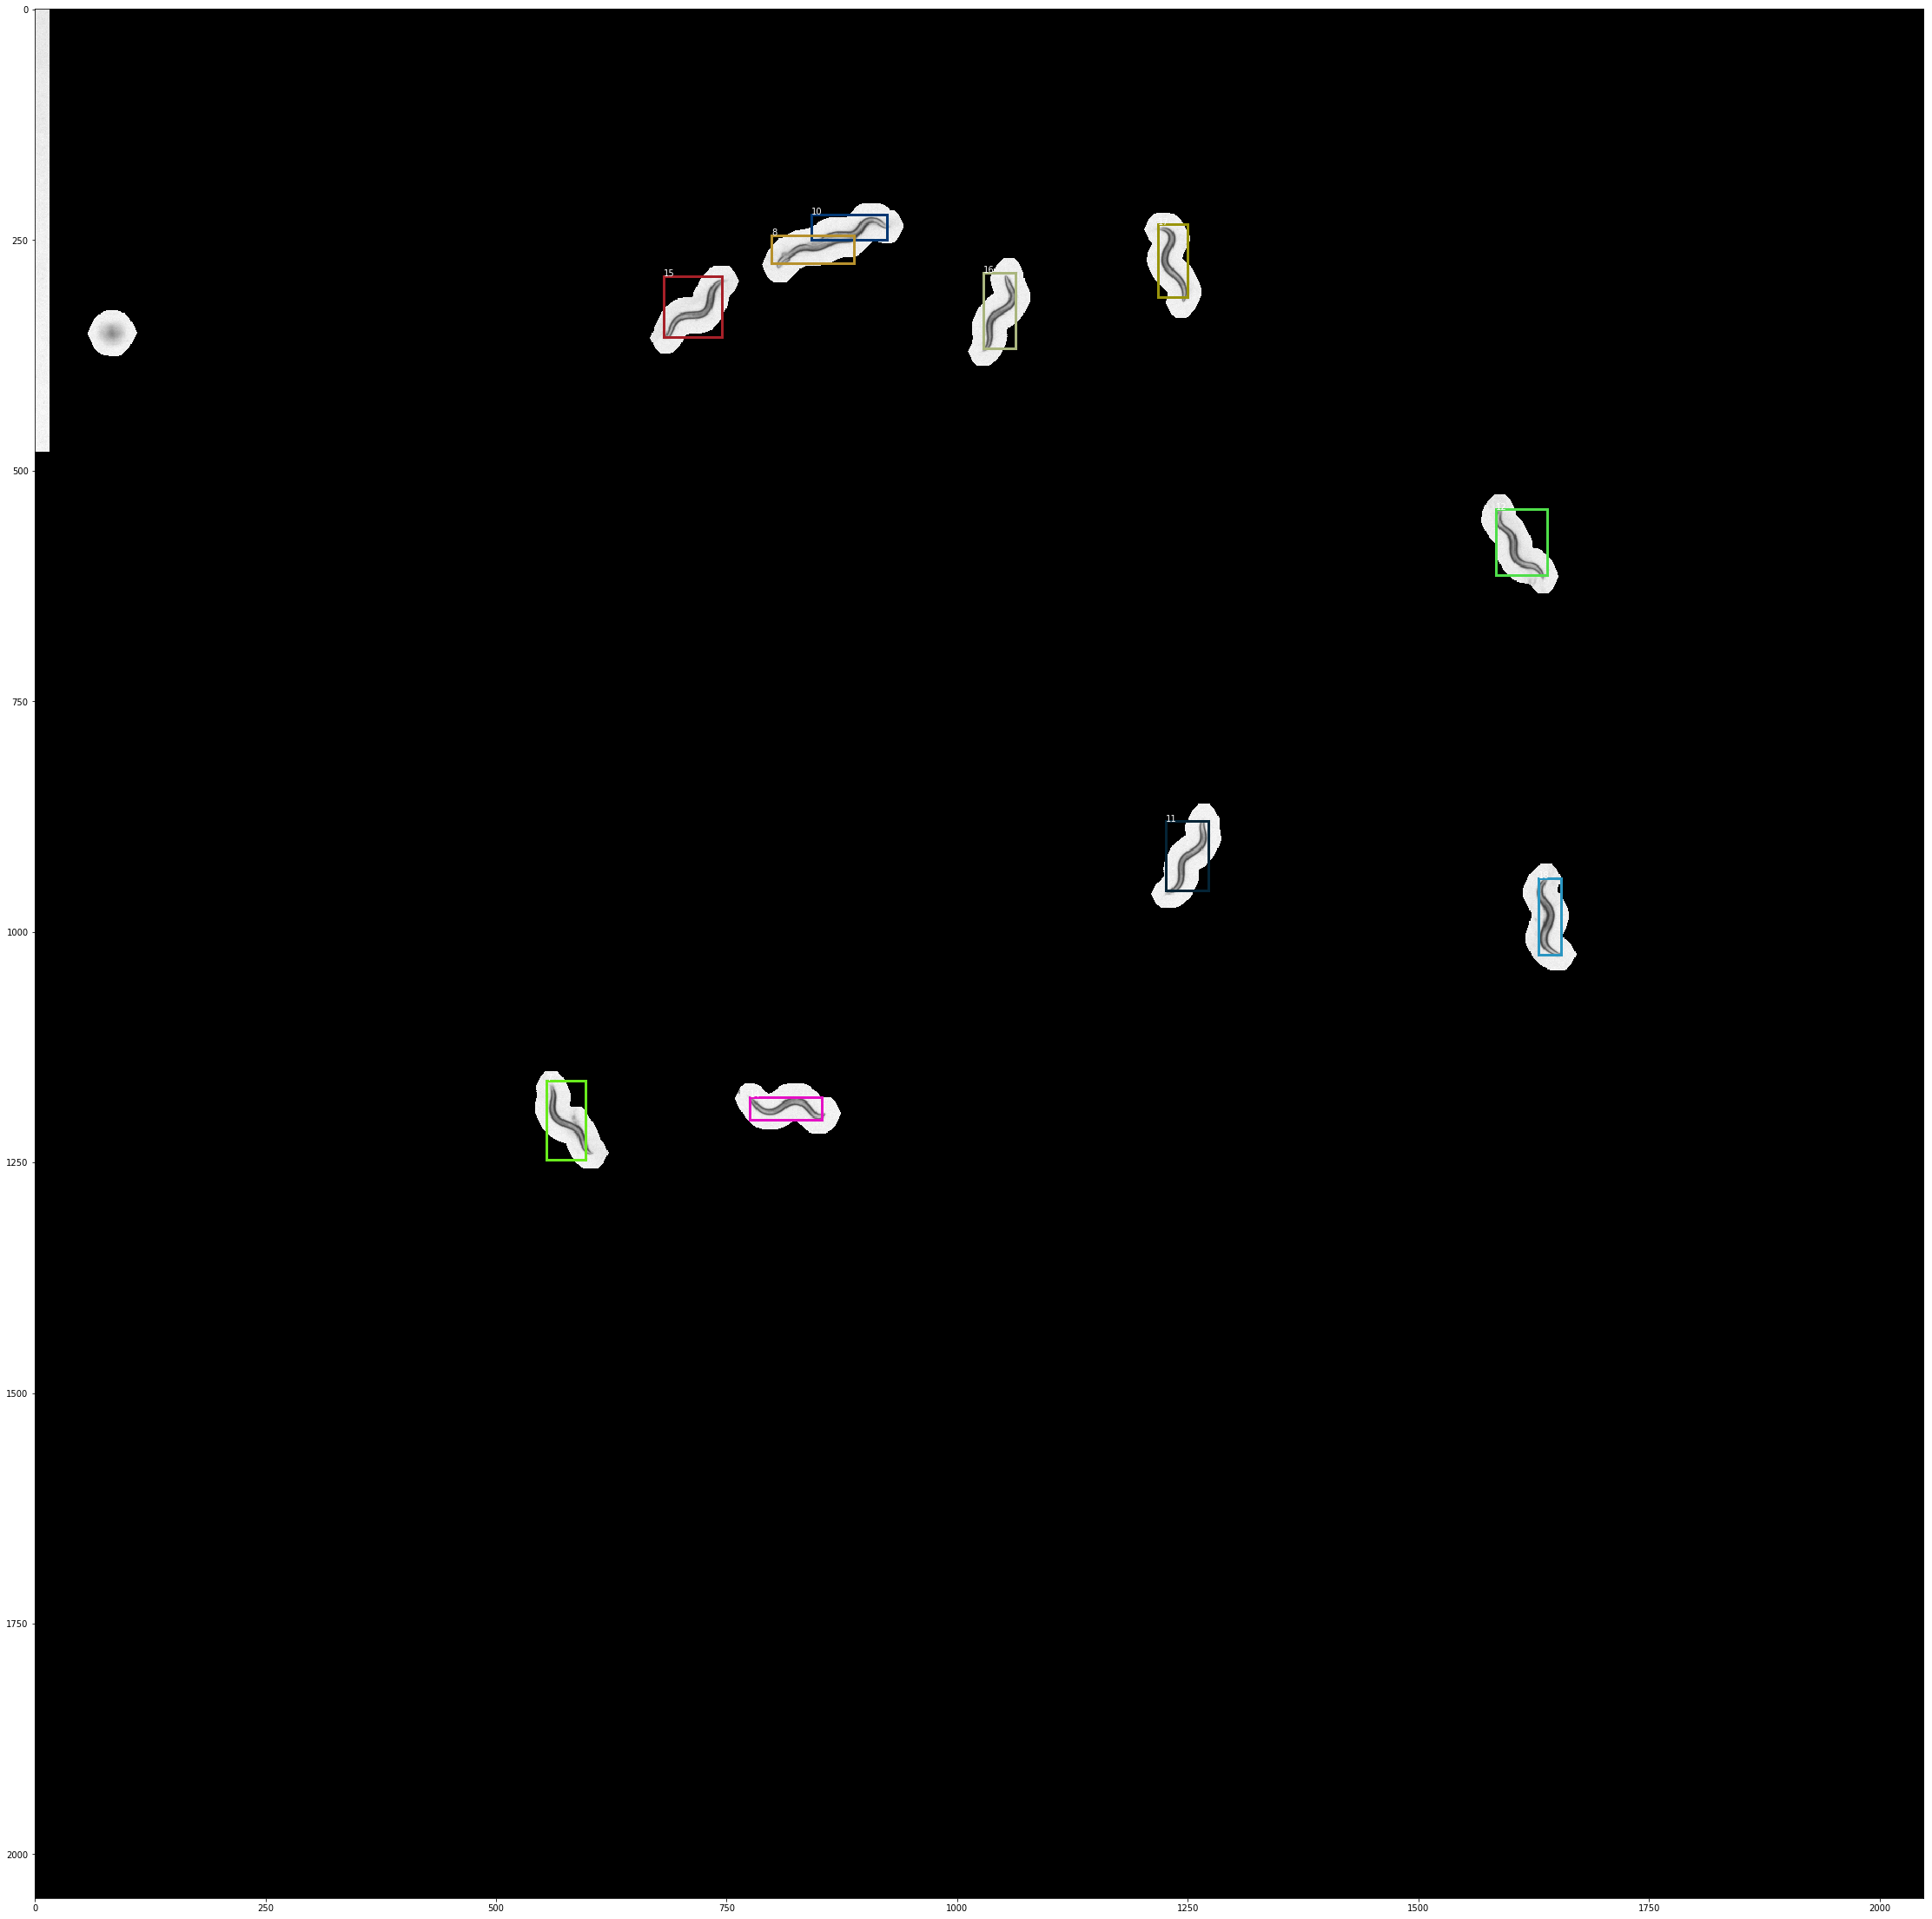

Worm IDs: [7.0, 8.0, 10.0, 11.0, 12.0, 14.0, 15.0, 18.0, 19.0, 20.0]


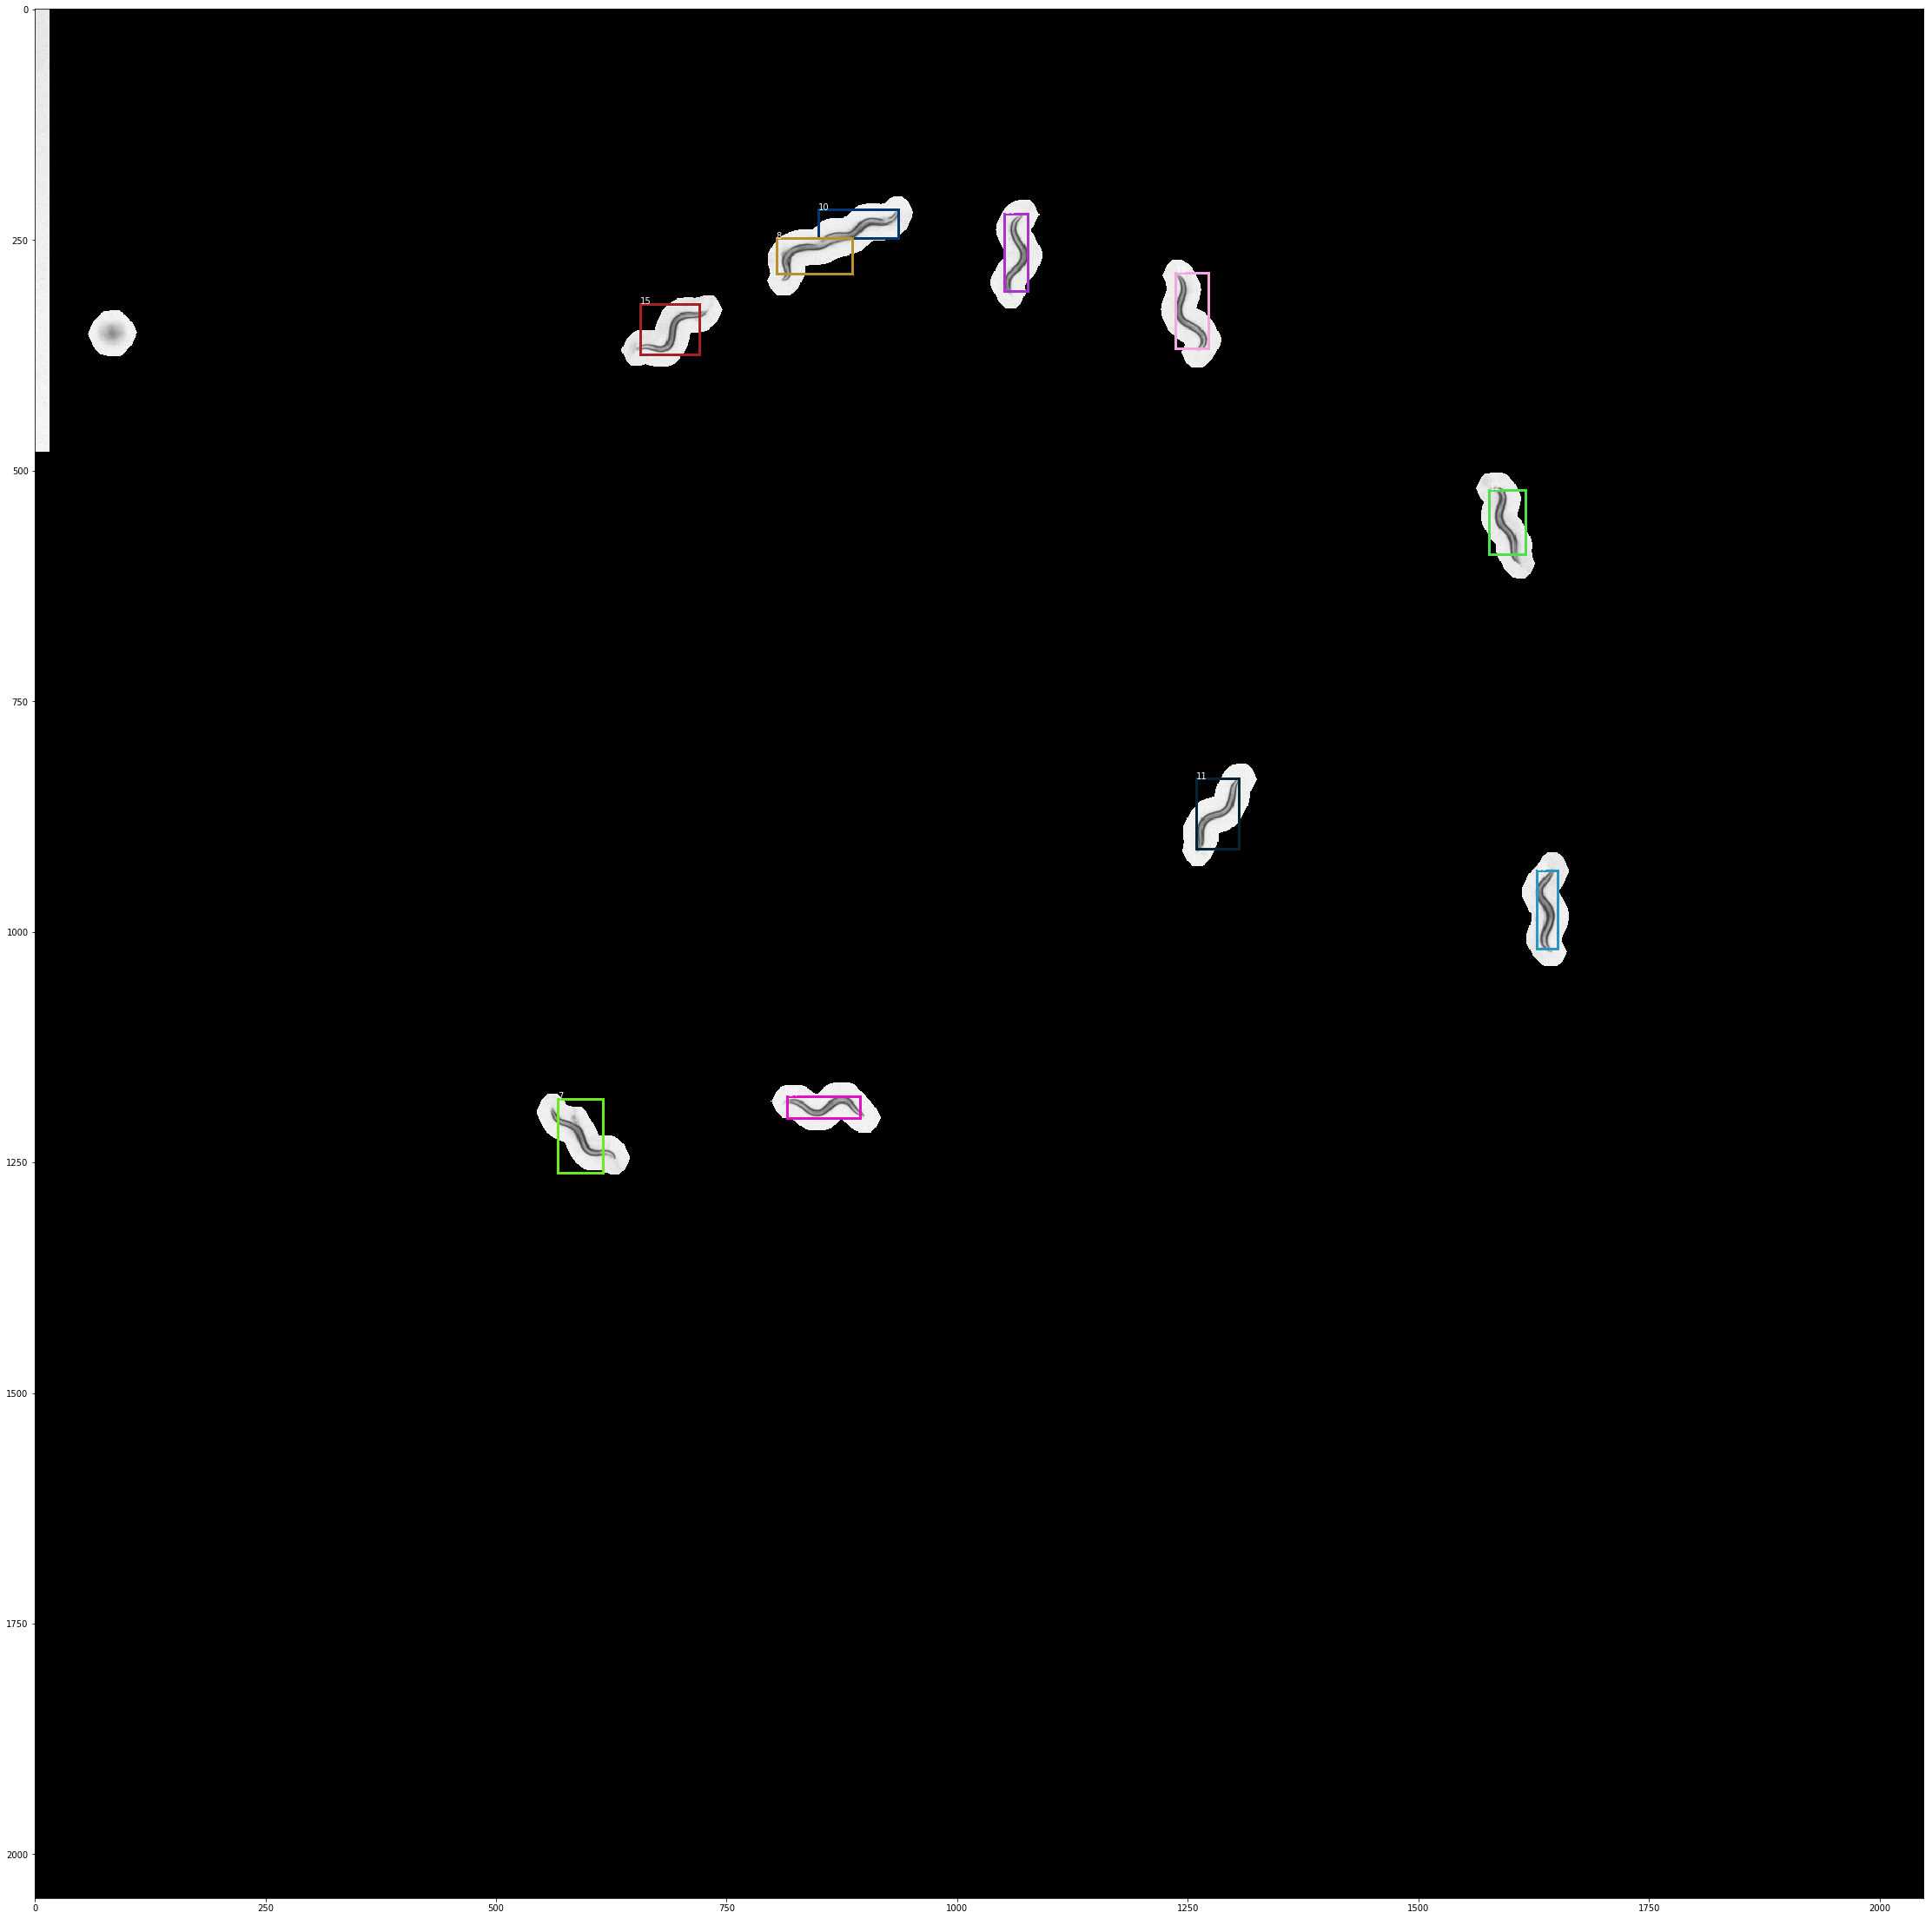

Worm IDs: [7.0, 8.0, 10.0, 11.0, 12.0, 14.0, 15.0, 18.0, 19.0, 20.0]


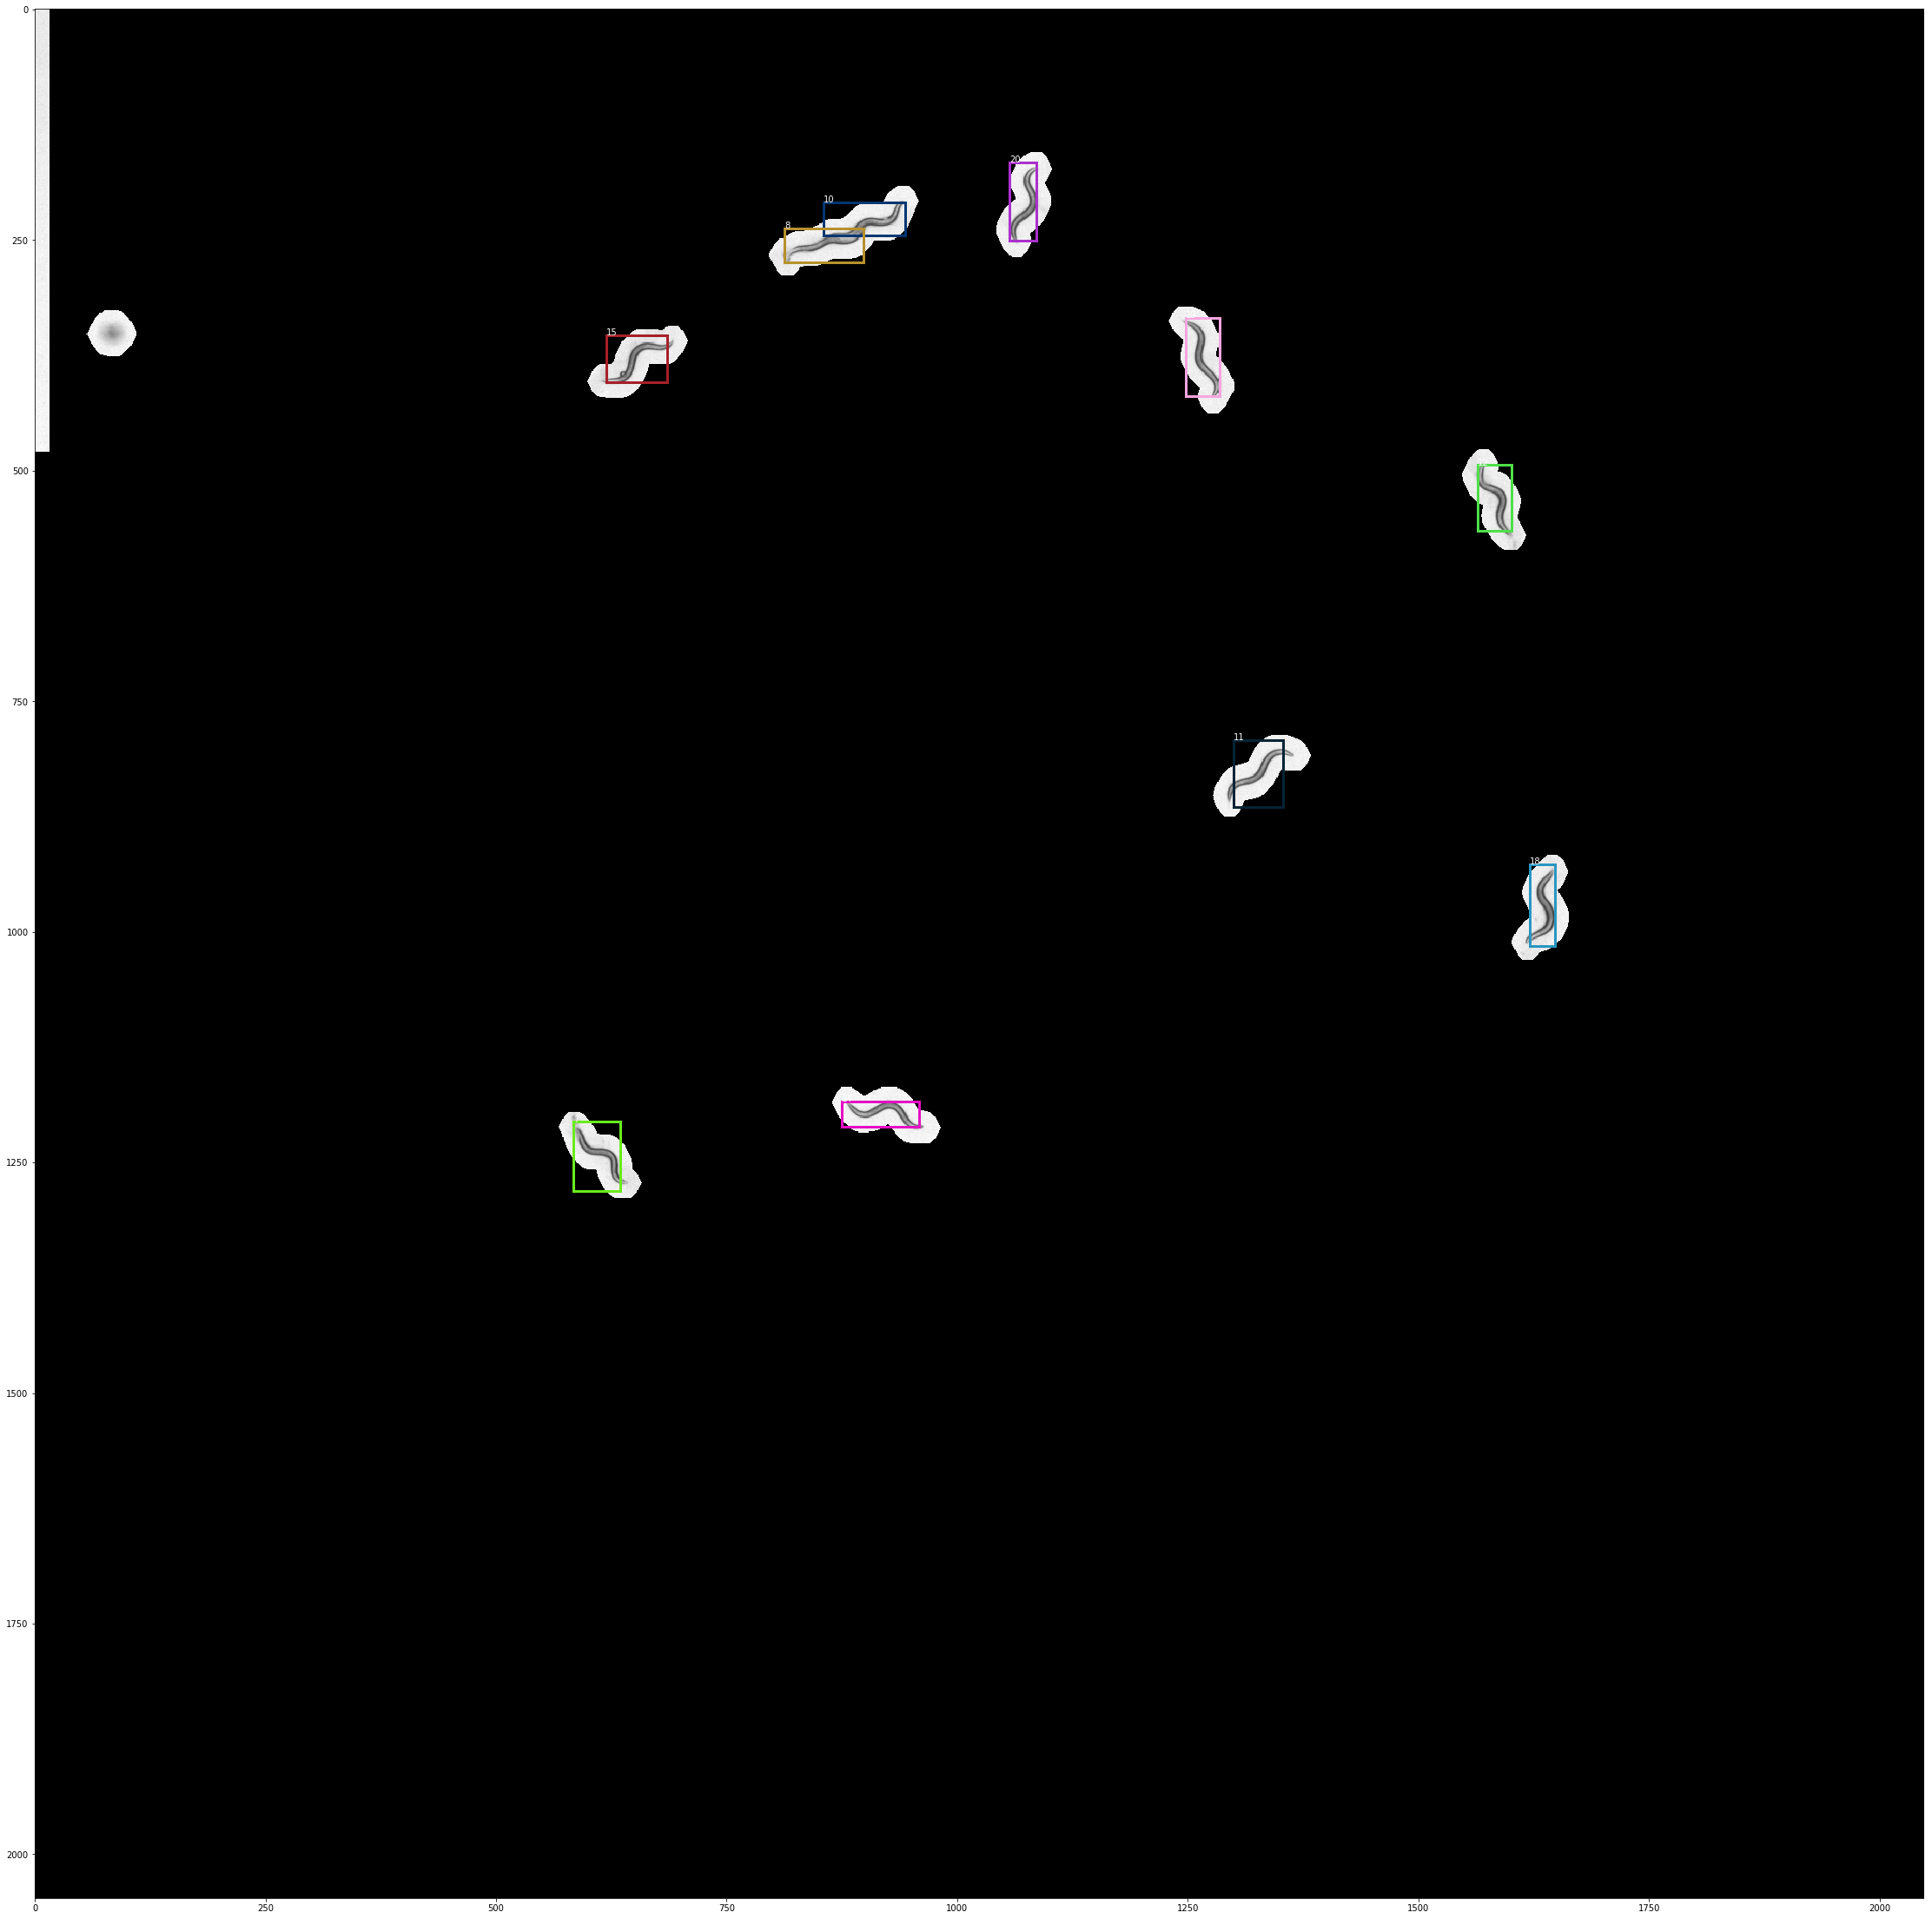

Worm IDs: [7.0, 8.0, 11.0, 12.0, 14.0, 15.0, 18.0, 19.0, 21.0]


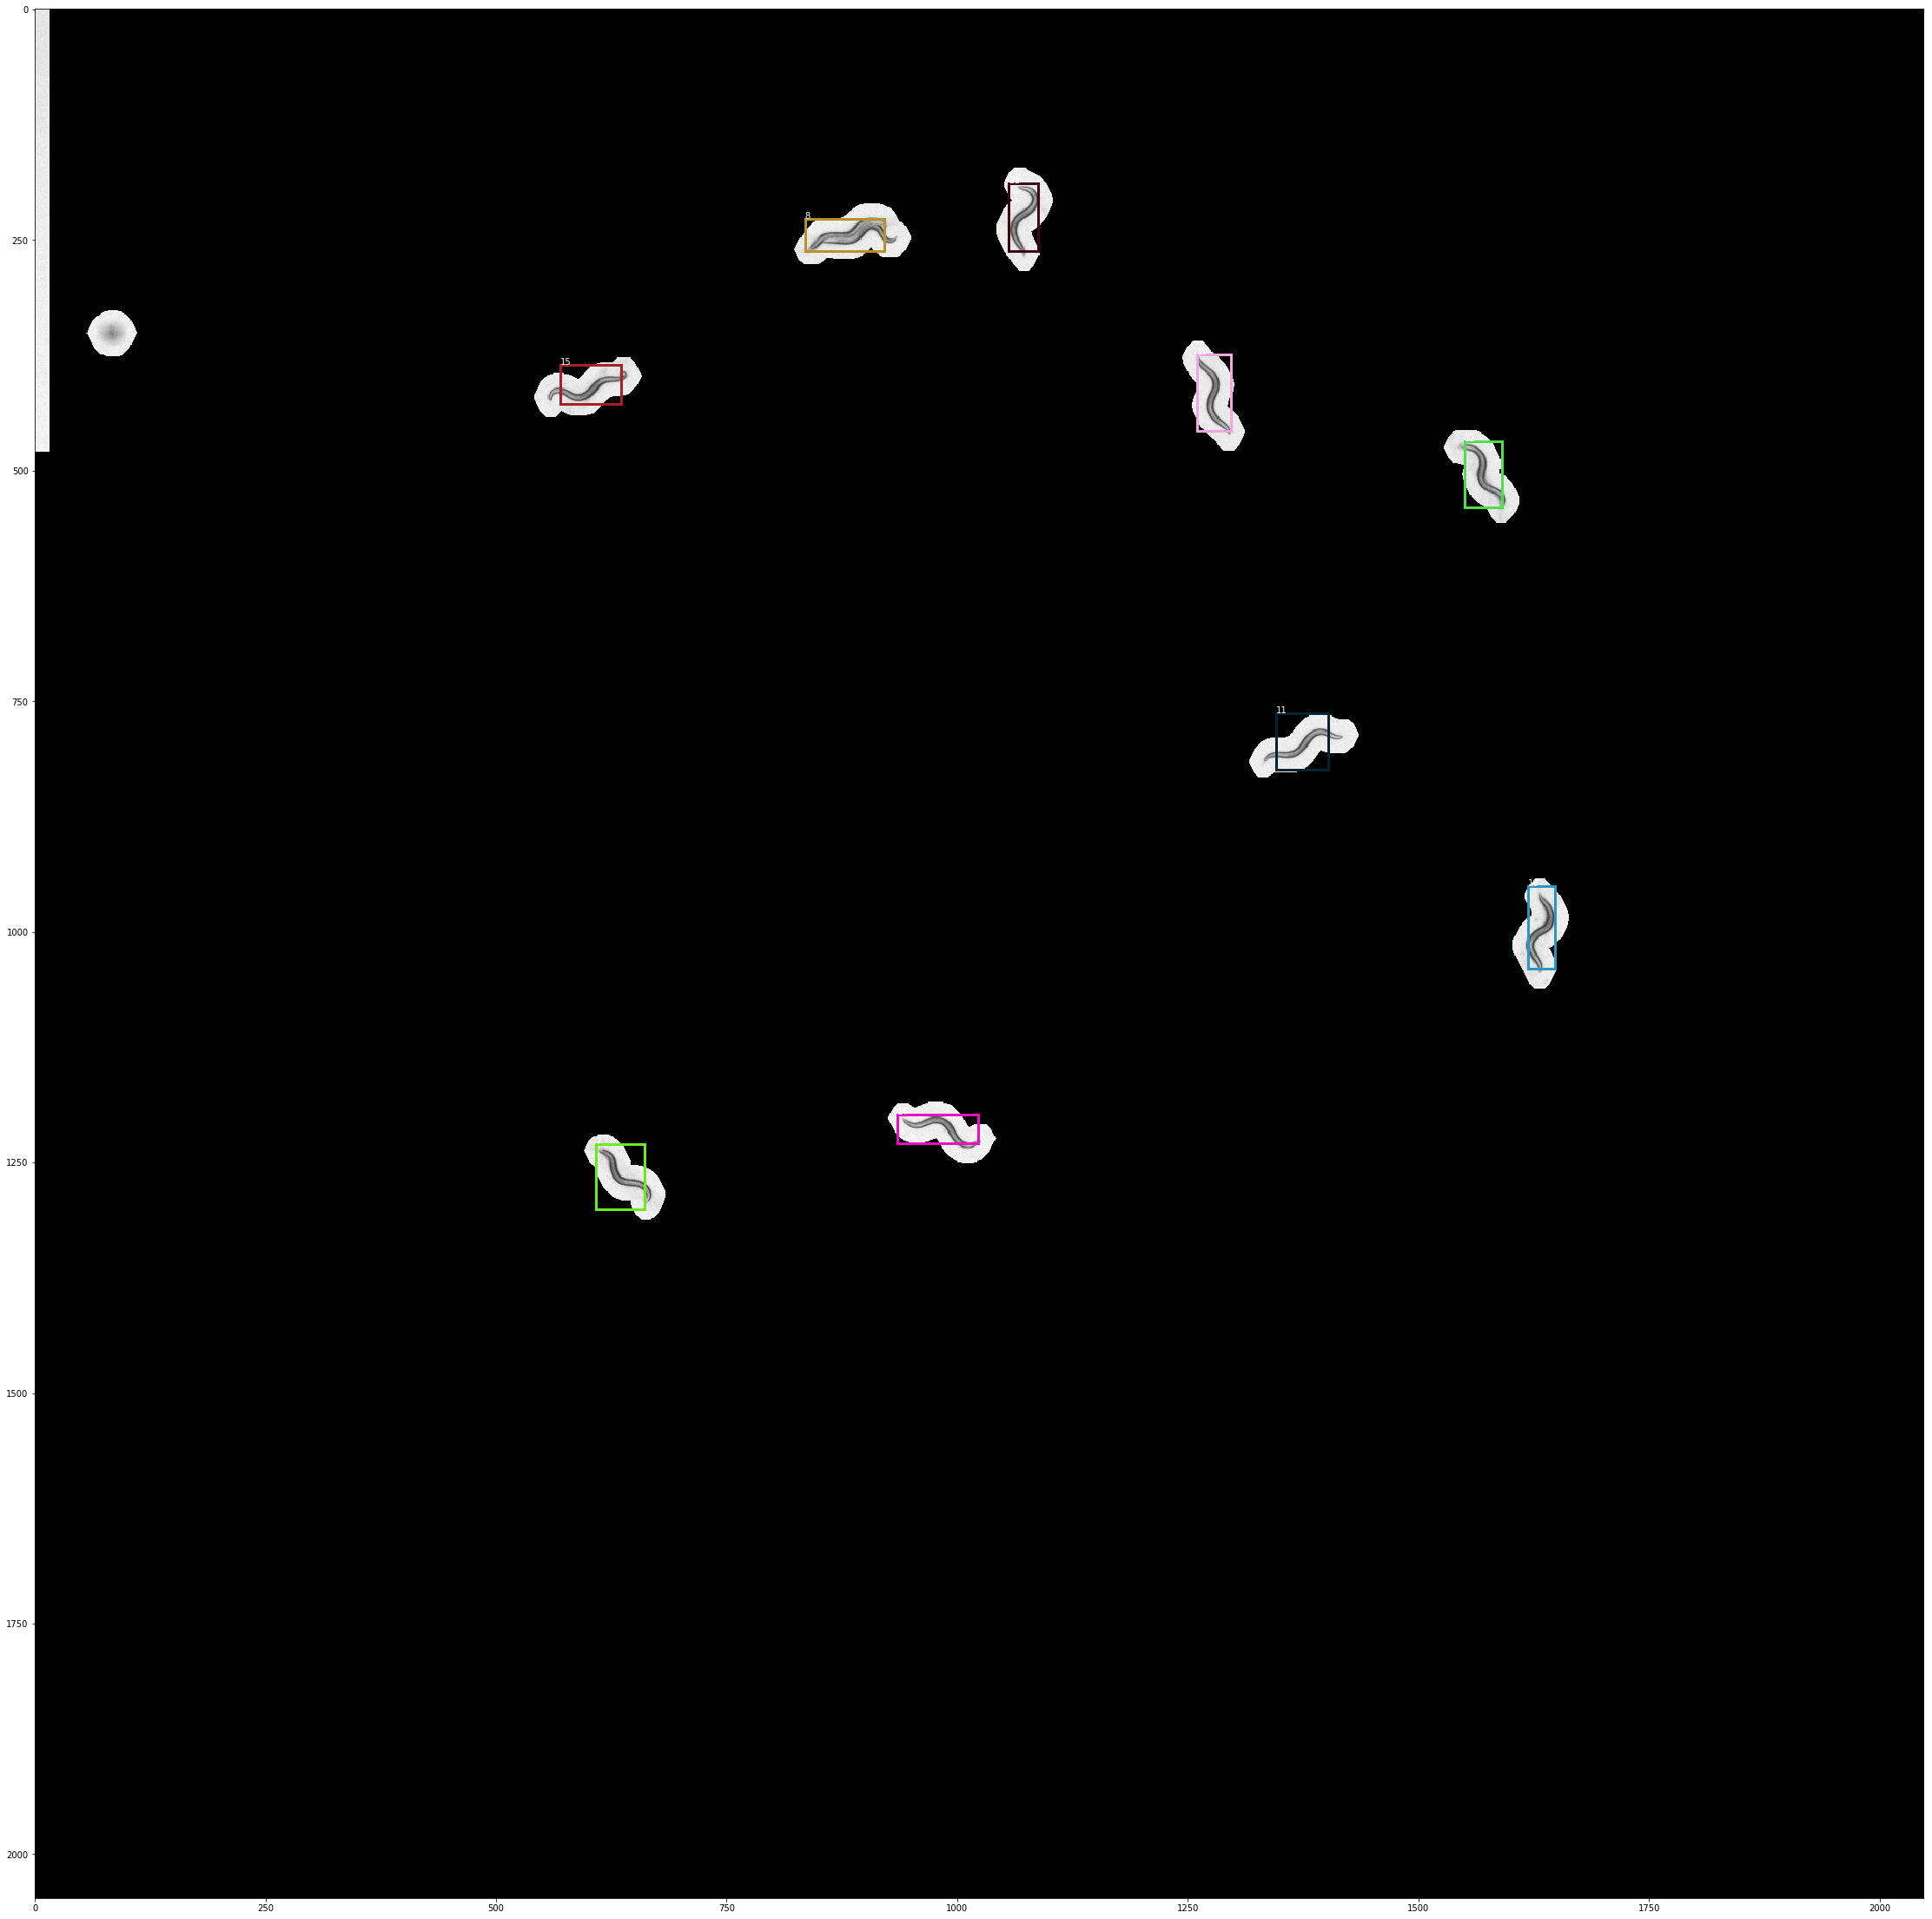

Worm IDs: [7.0, 8.0, 10.0, 11.0, 12.0, 14.0, 15.0, 18.0, 19.0, 21.0]


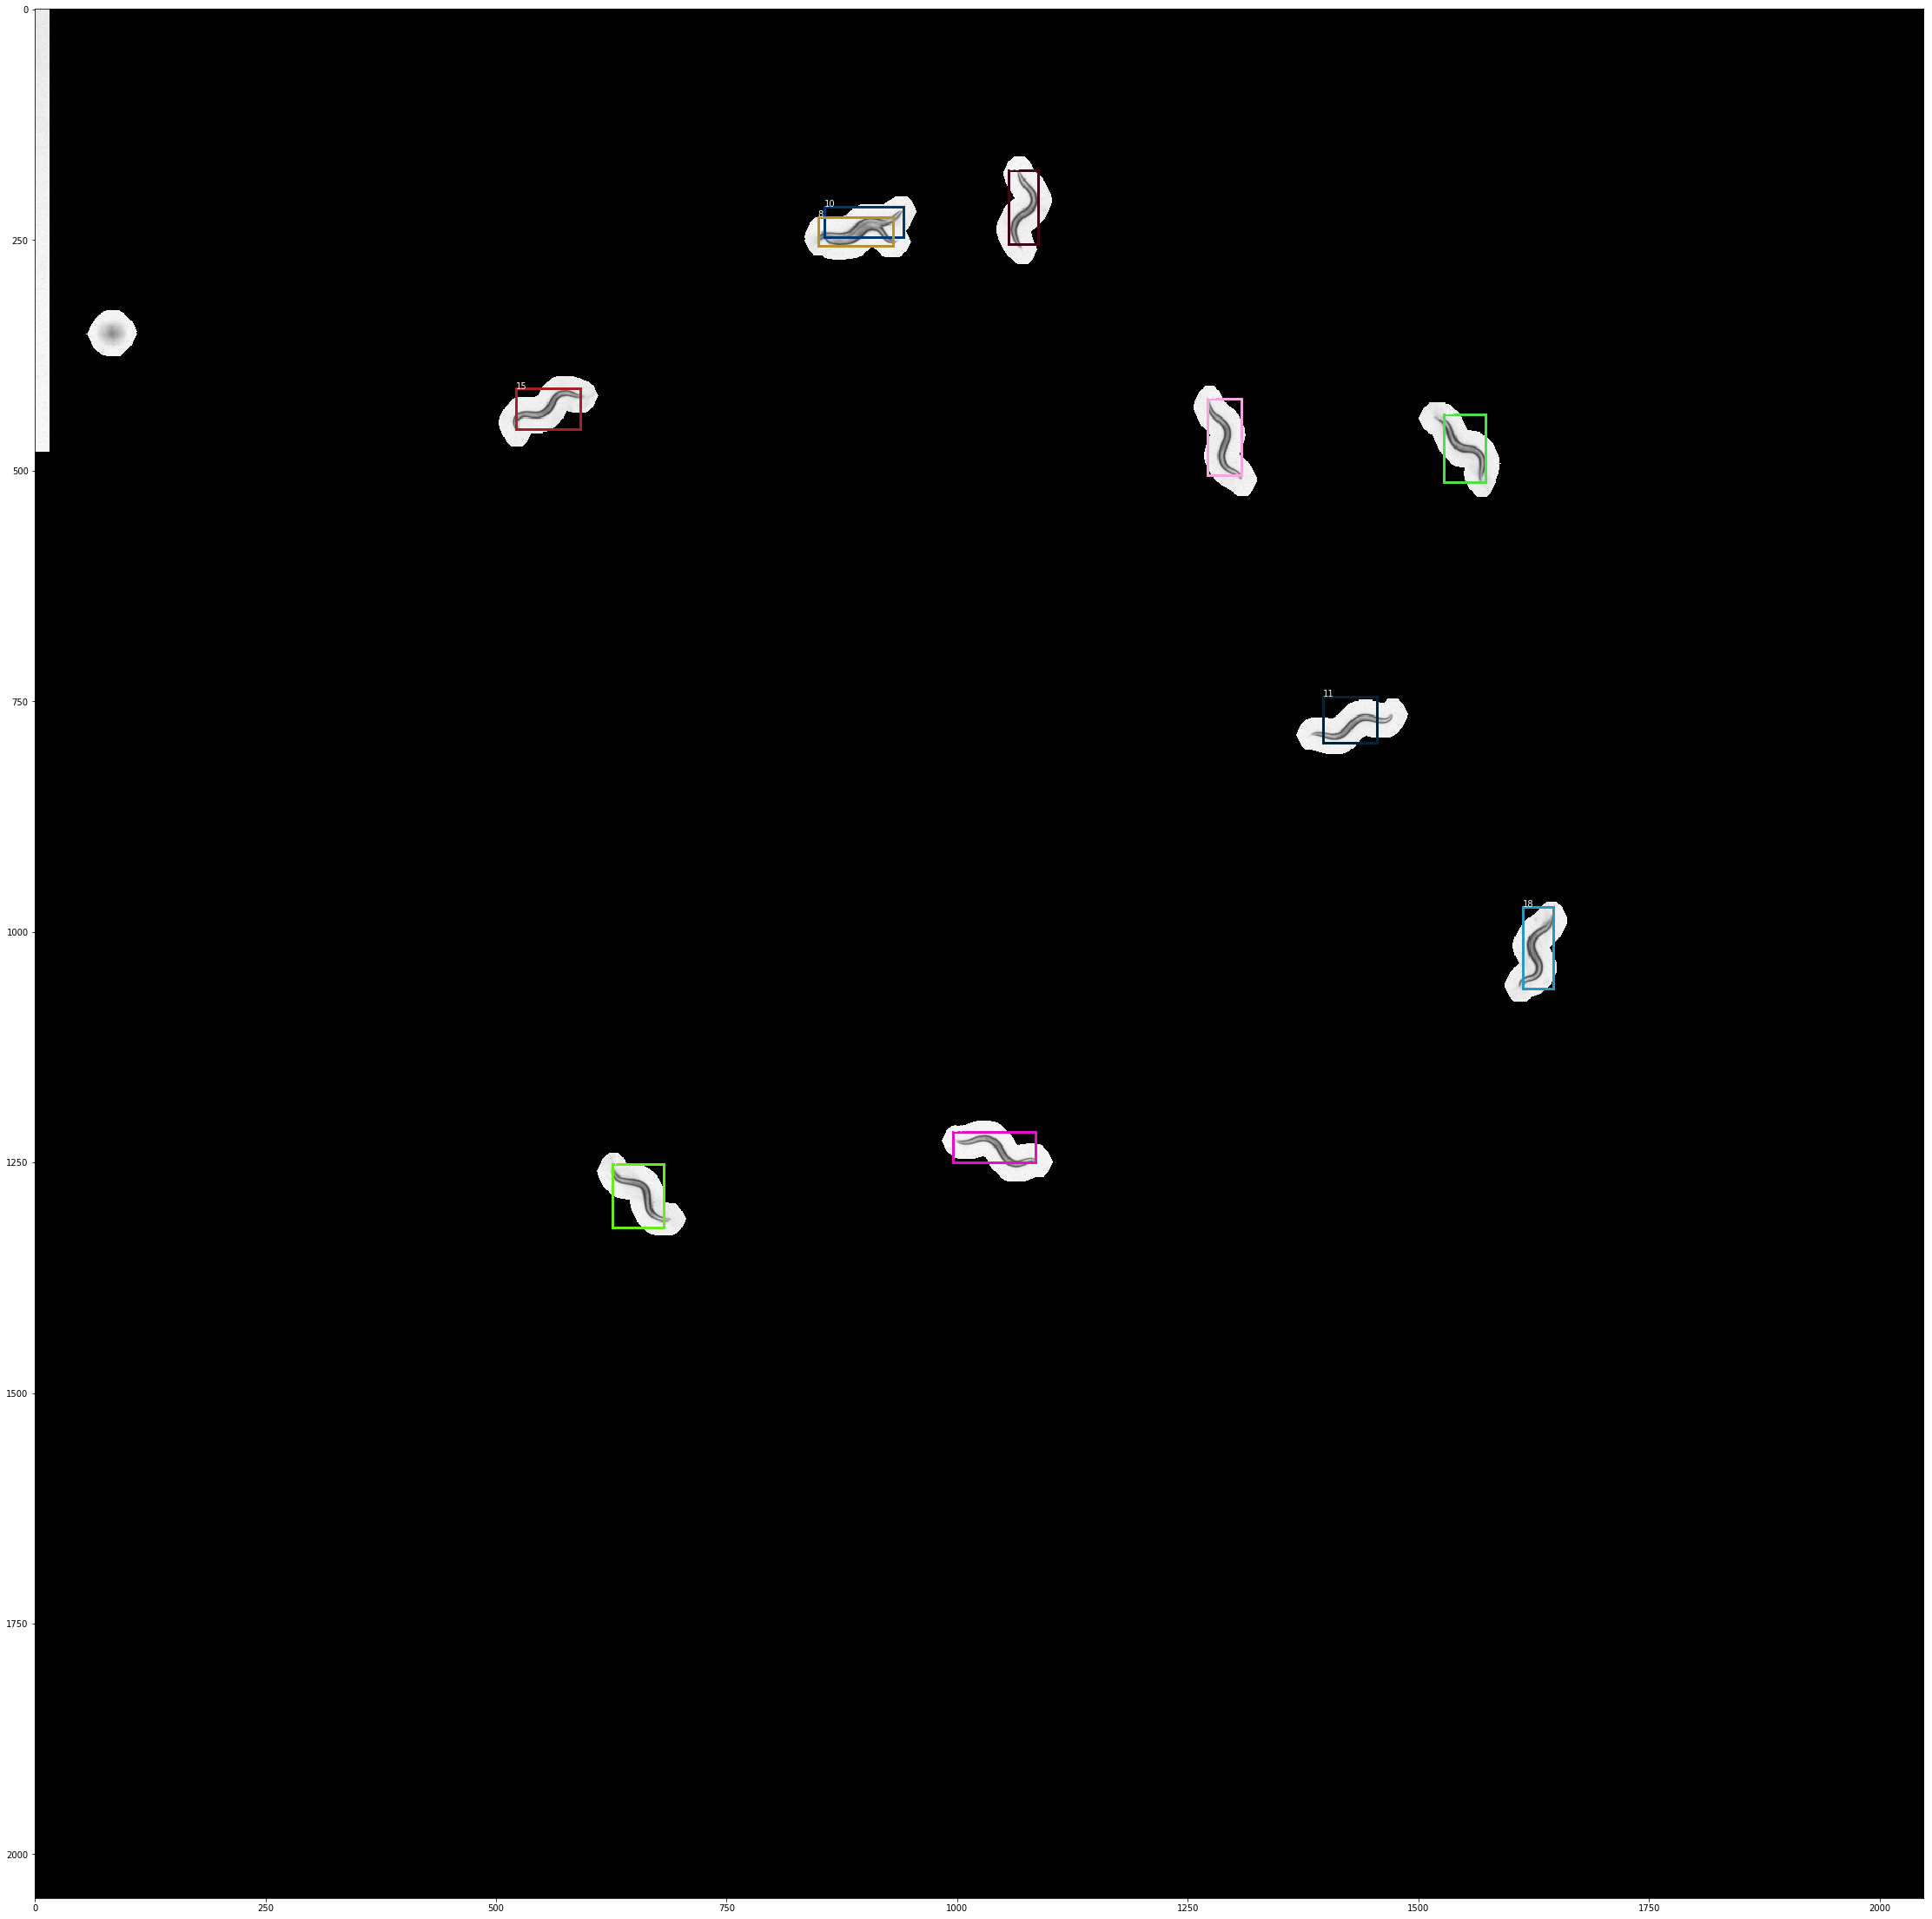

Worm IDs: [7.0, 8.0, 11.0, 12.0, 14.0, 15.0, 18.0, 19.0, 21.0]


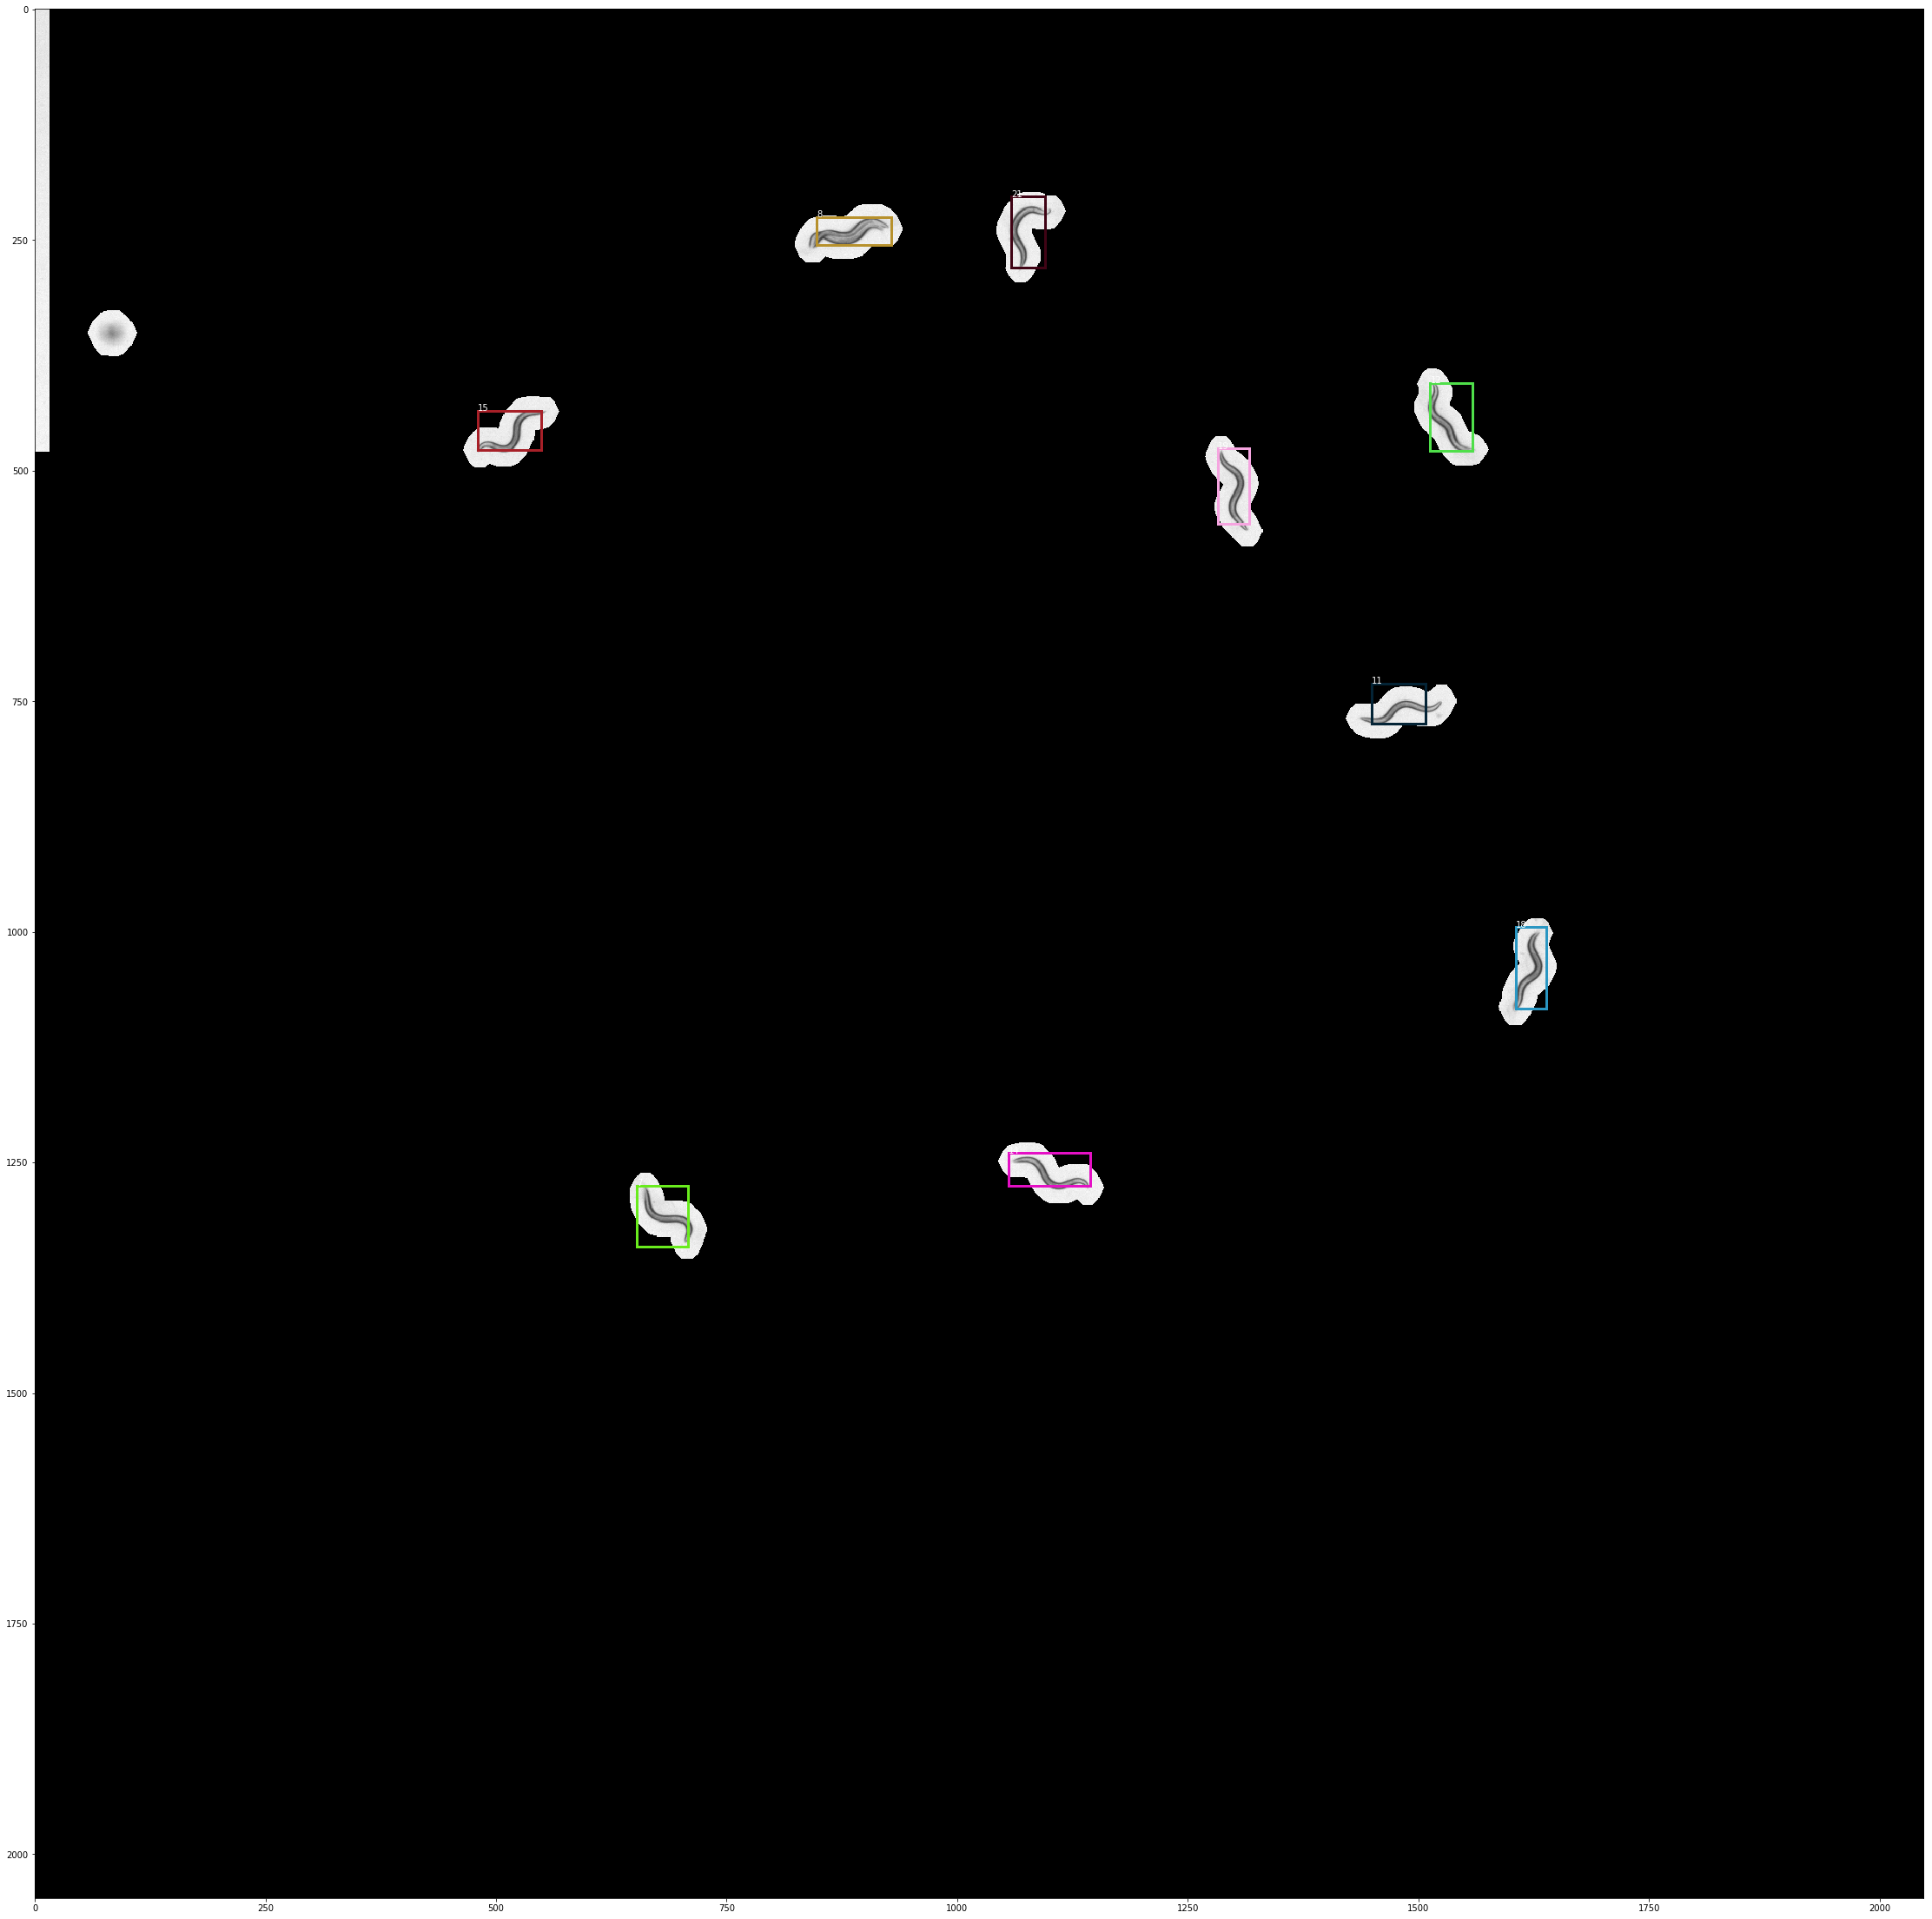

Worm IDs: [7.0, 8.0, 11.0, 12.0, 14.0, 15.0, 18.0, 19.0, 21.0, 22.0]


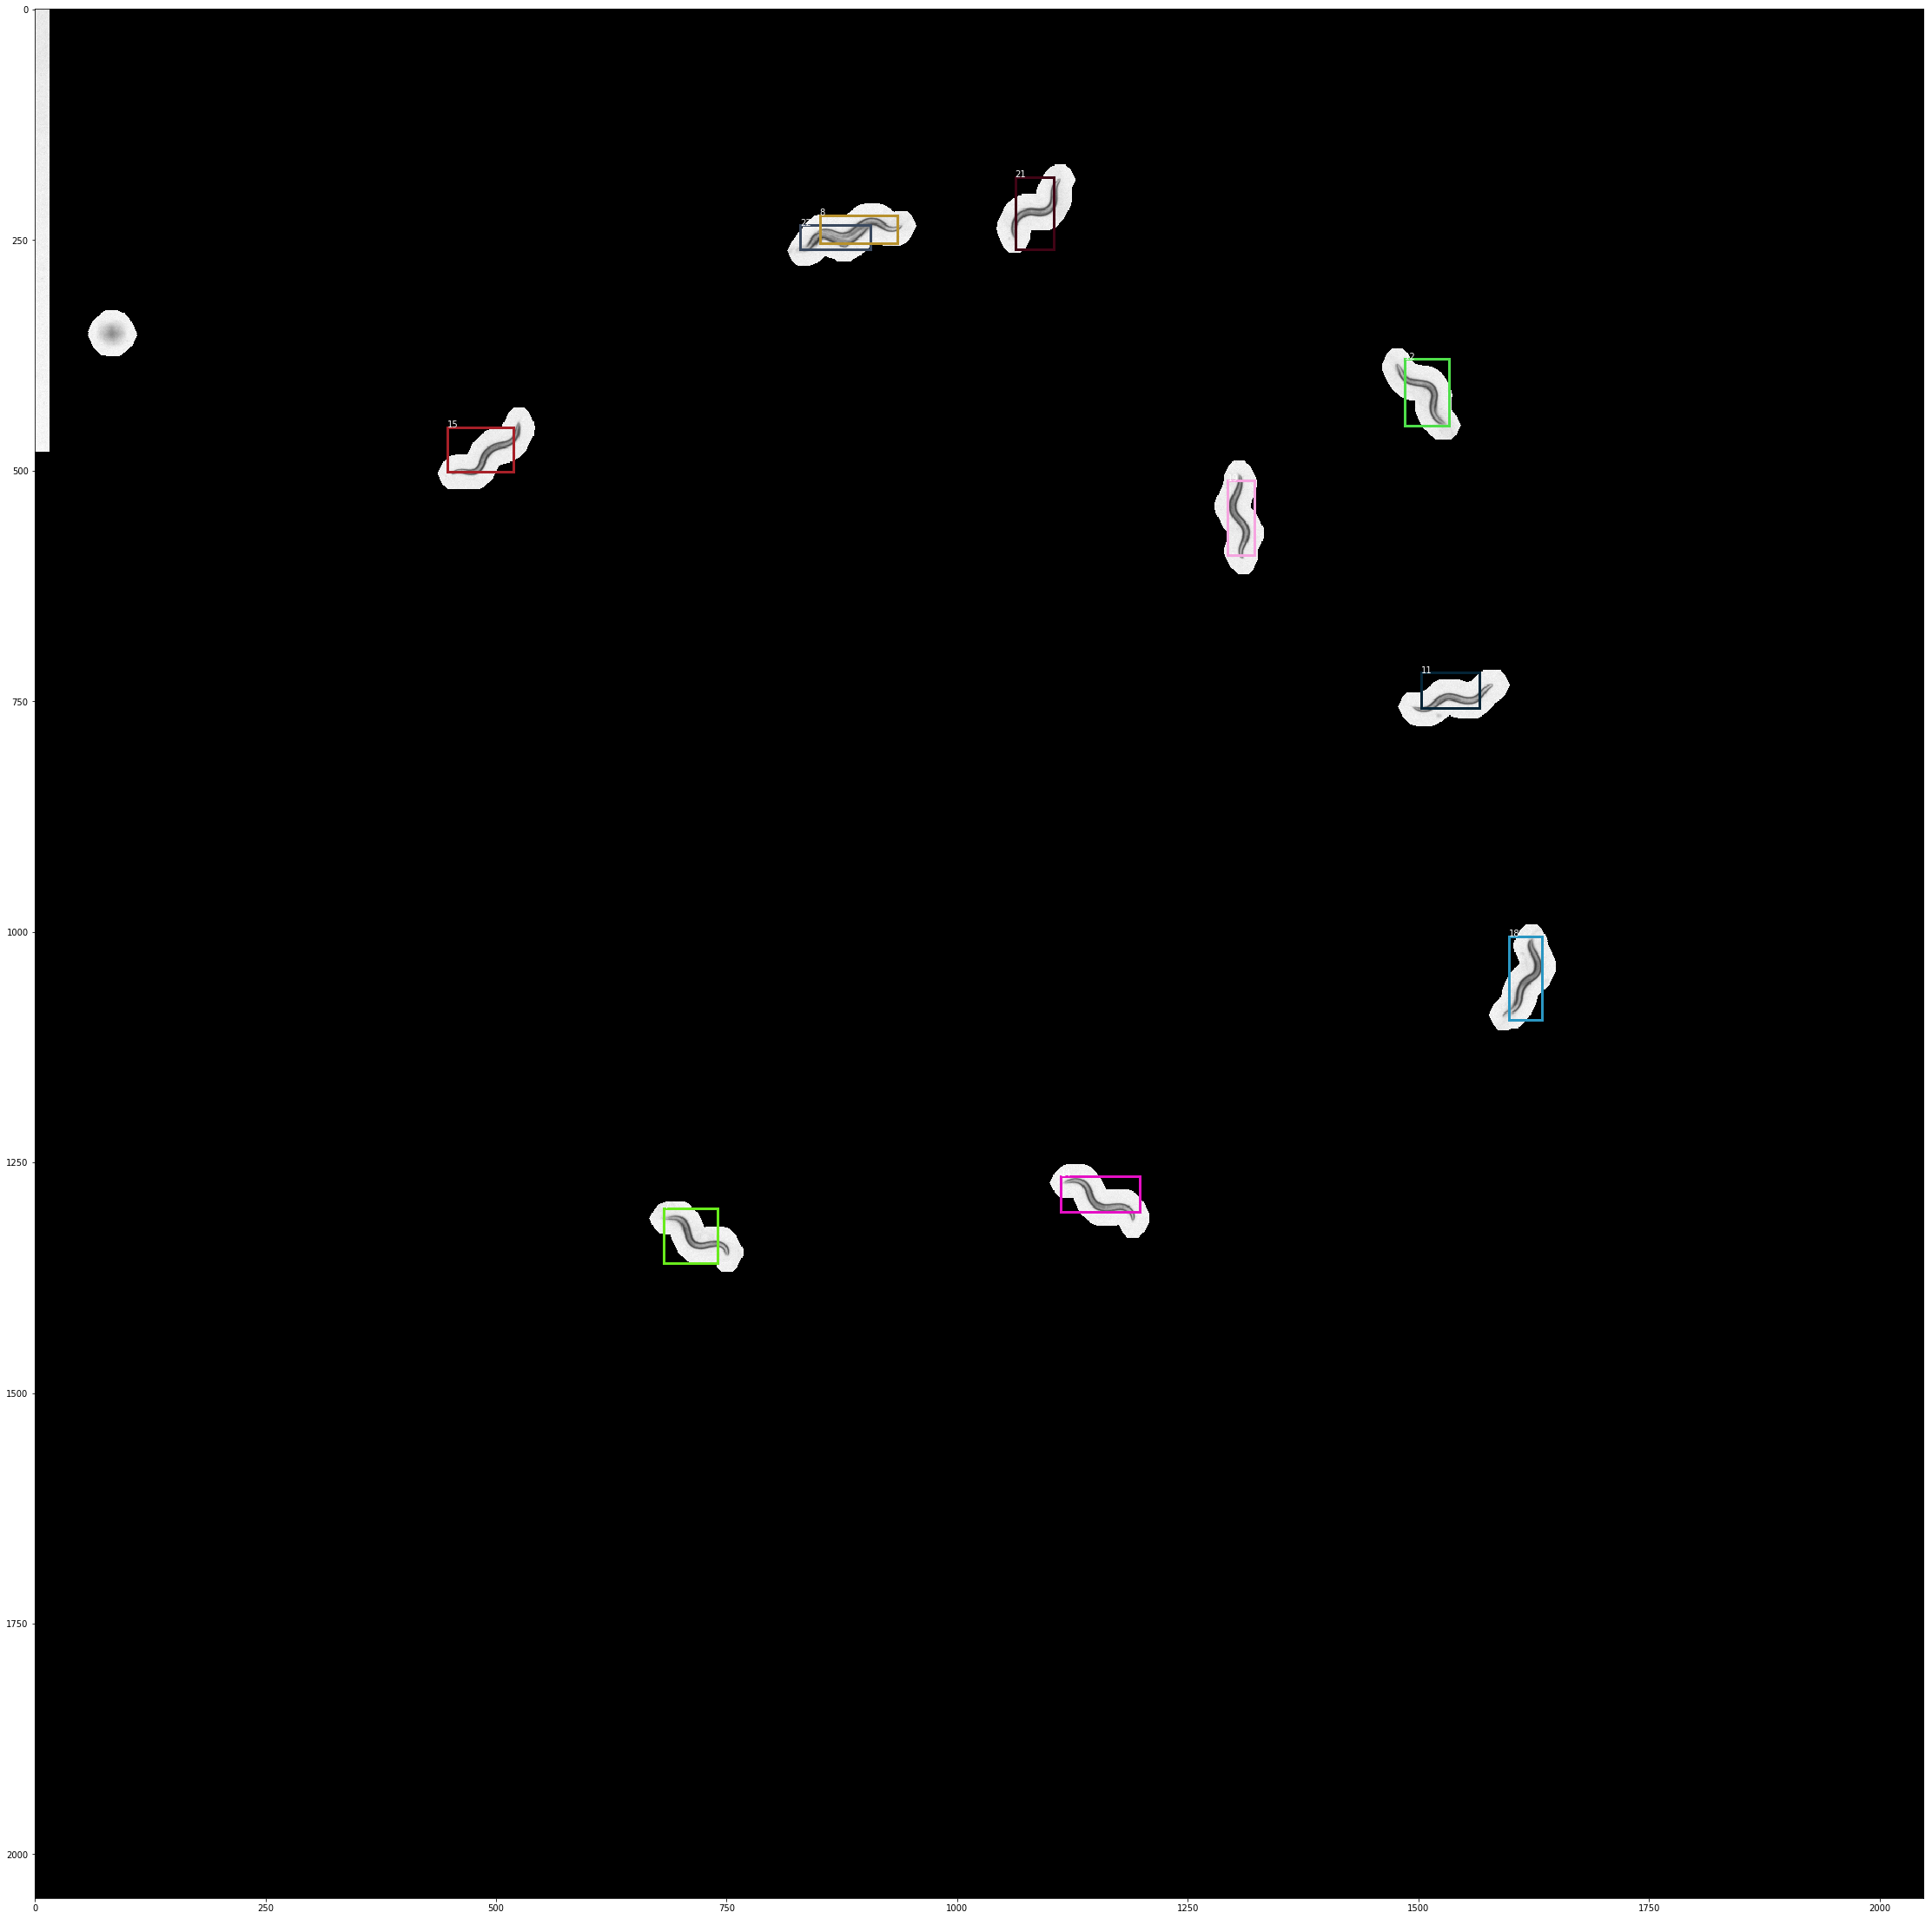

Worm IDs: [7.0, 8.0, 12.0, 14.0, 18.0, 19.0, 21.0, 22.0, 23.0, 24.0]


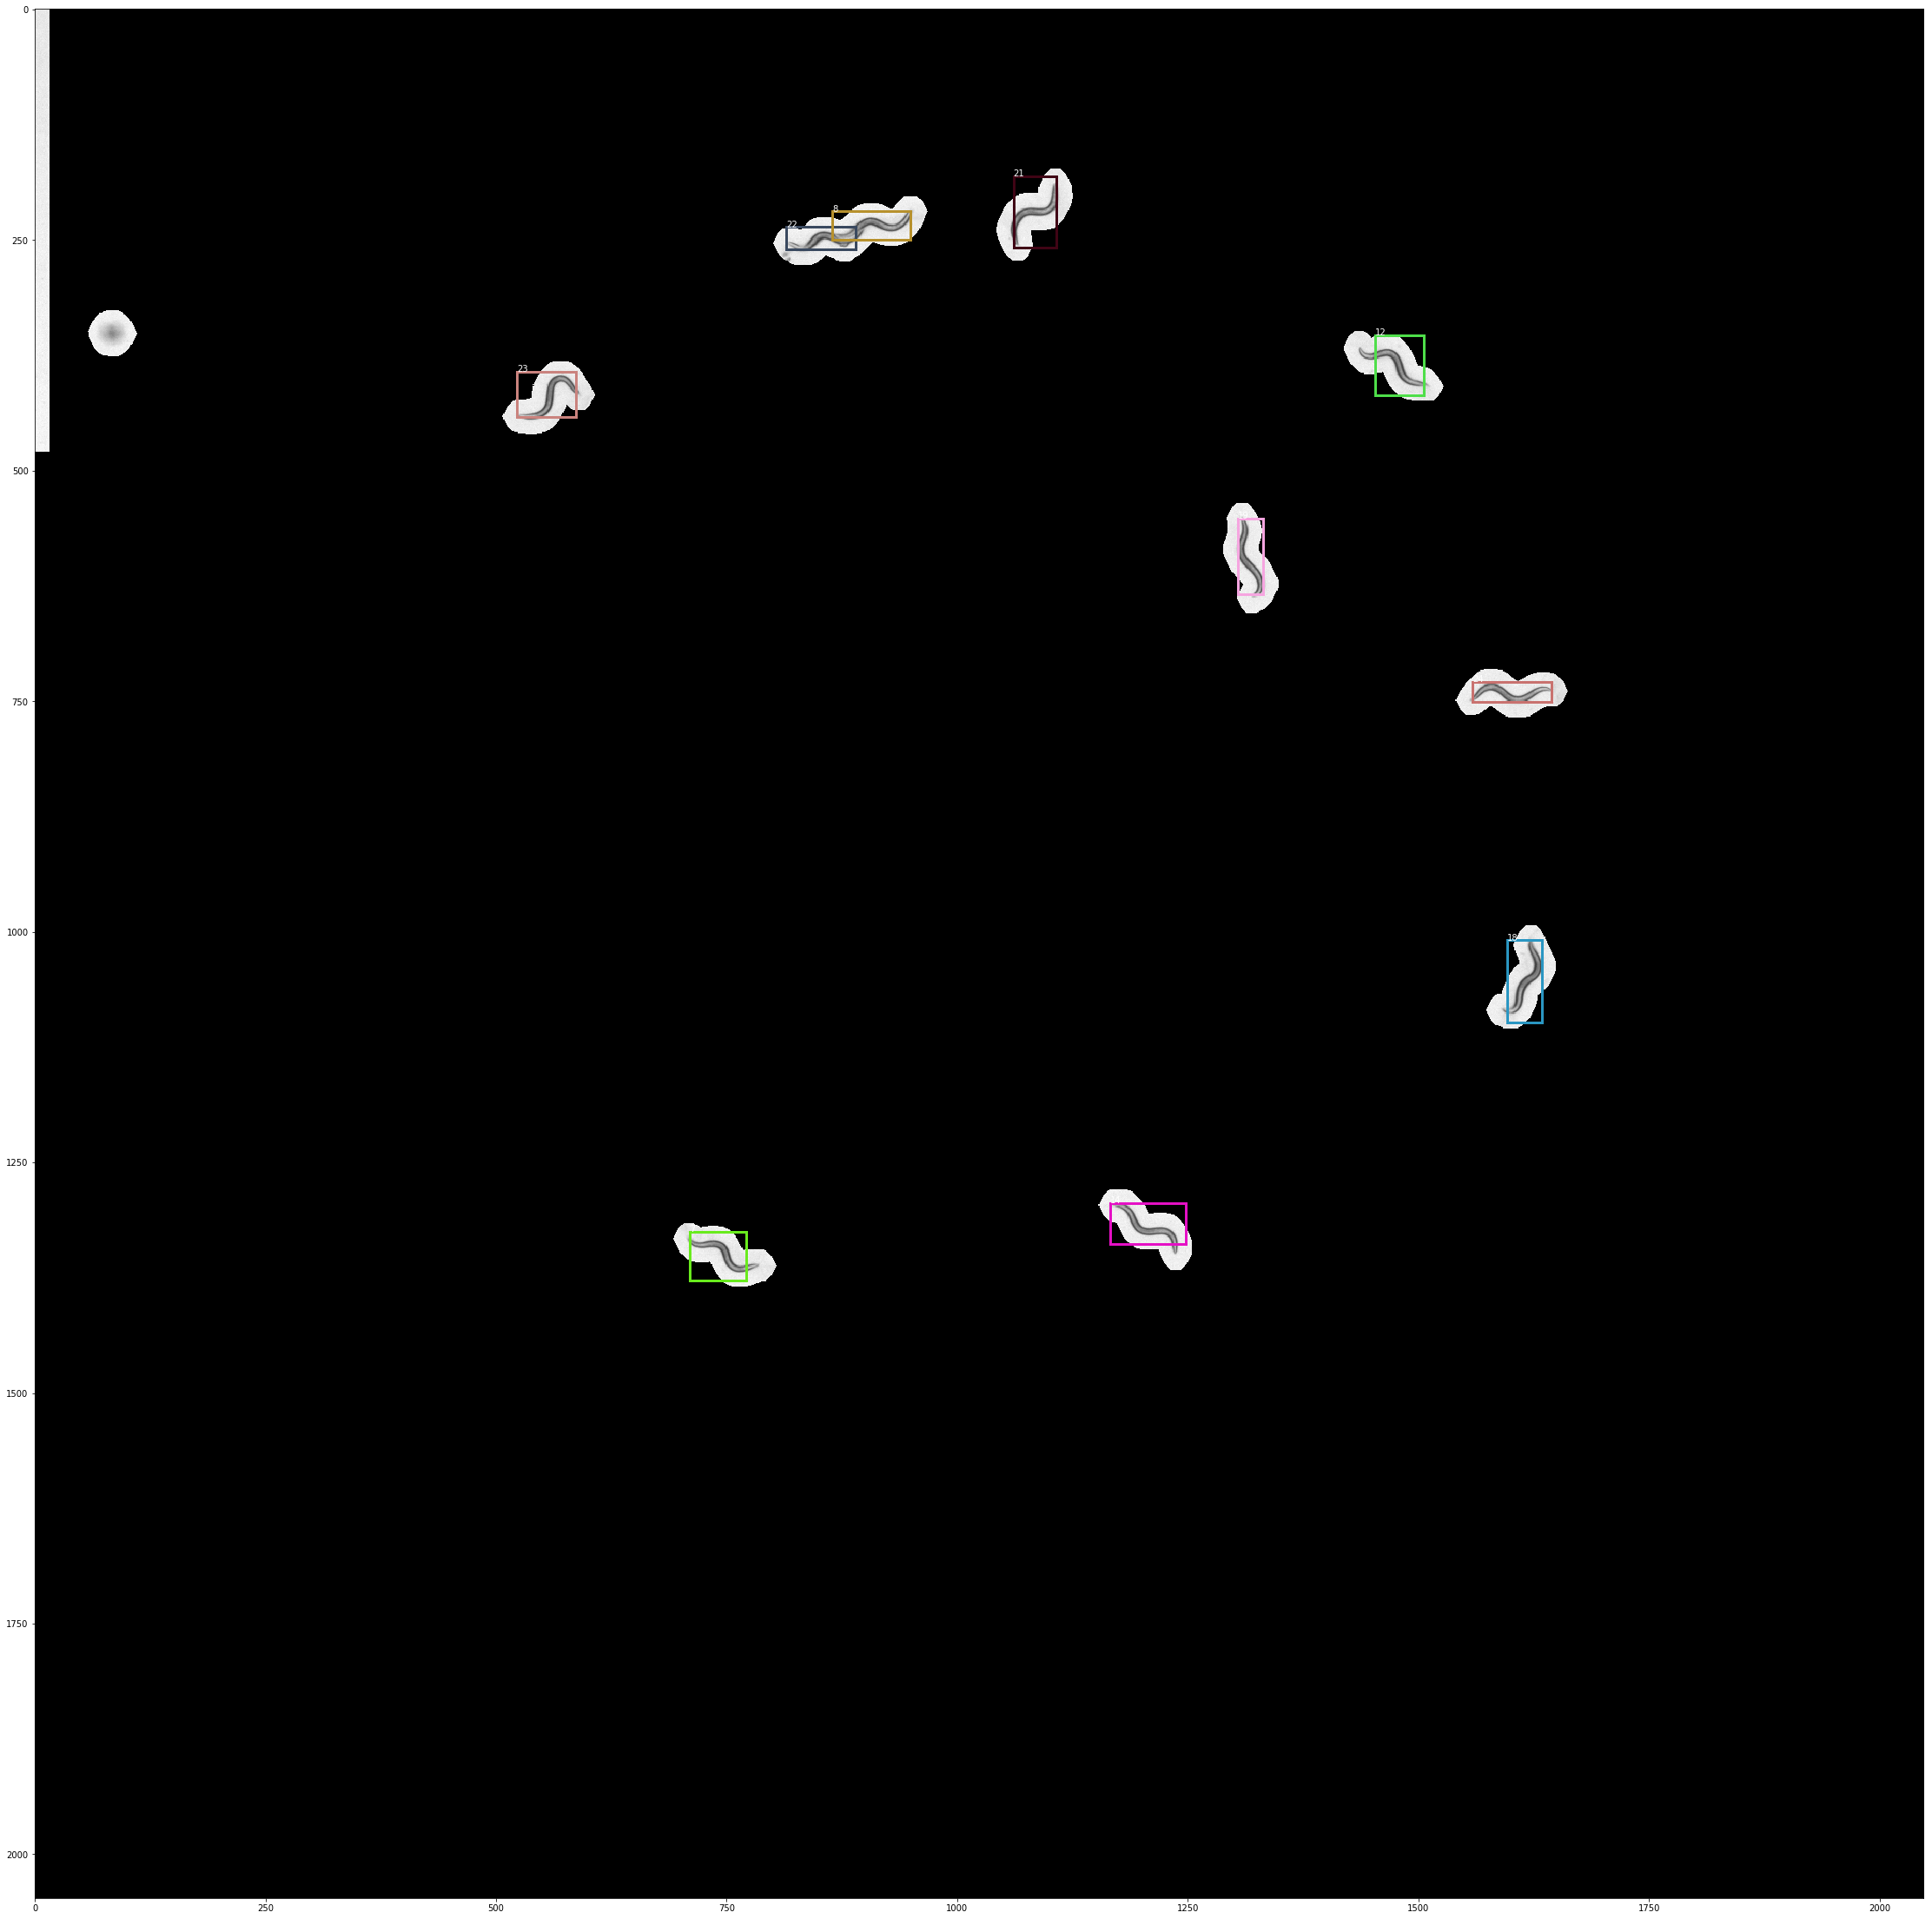

Worm IDs: [7.0, 8.0, 10.0, 12.0, 14.0, 18.0, 19.0, 21.0, 22.0, 23.0, 24.0]


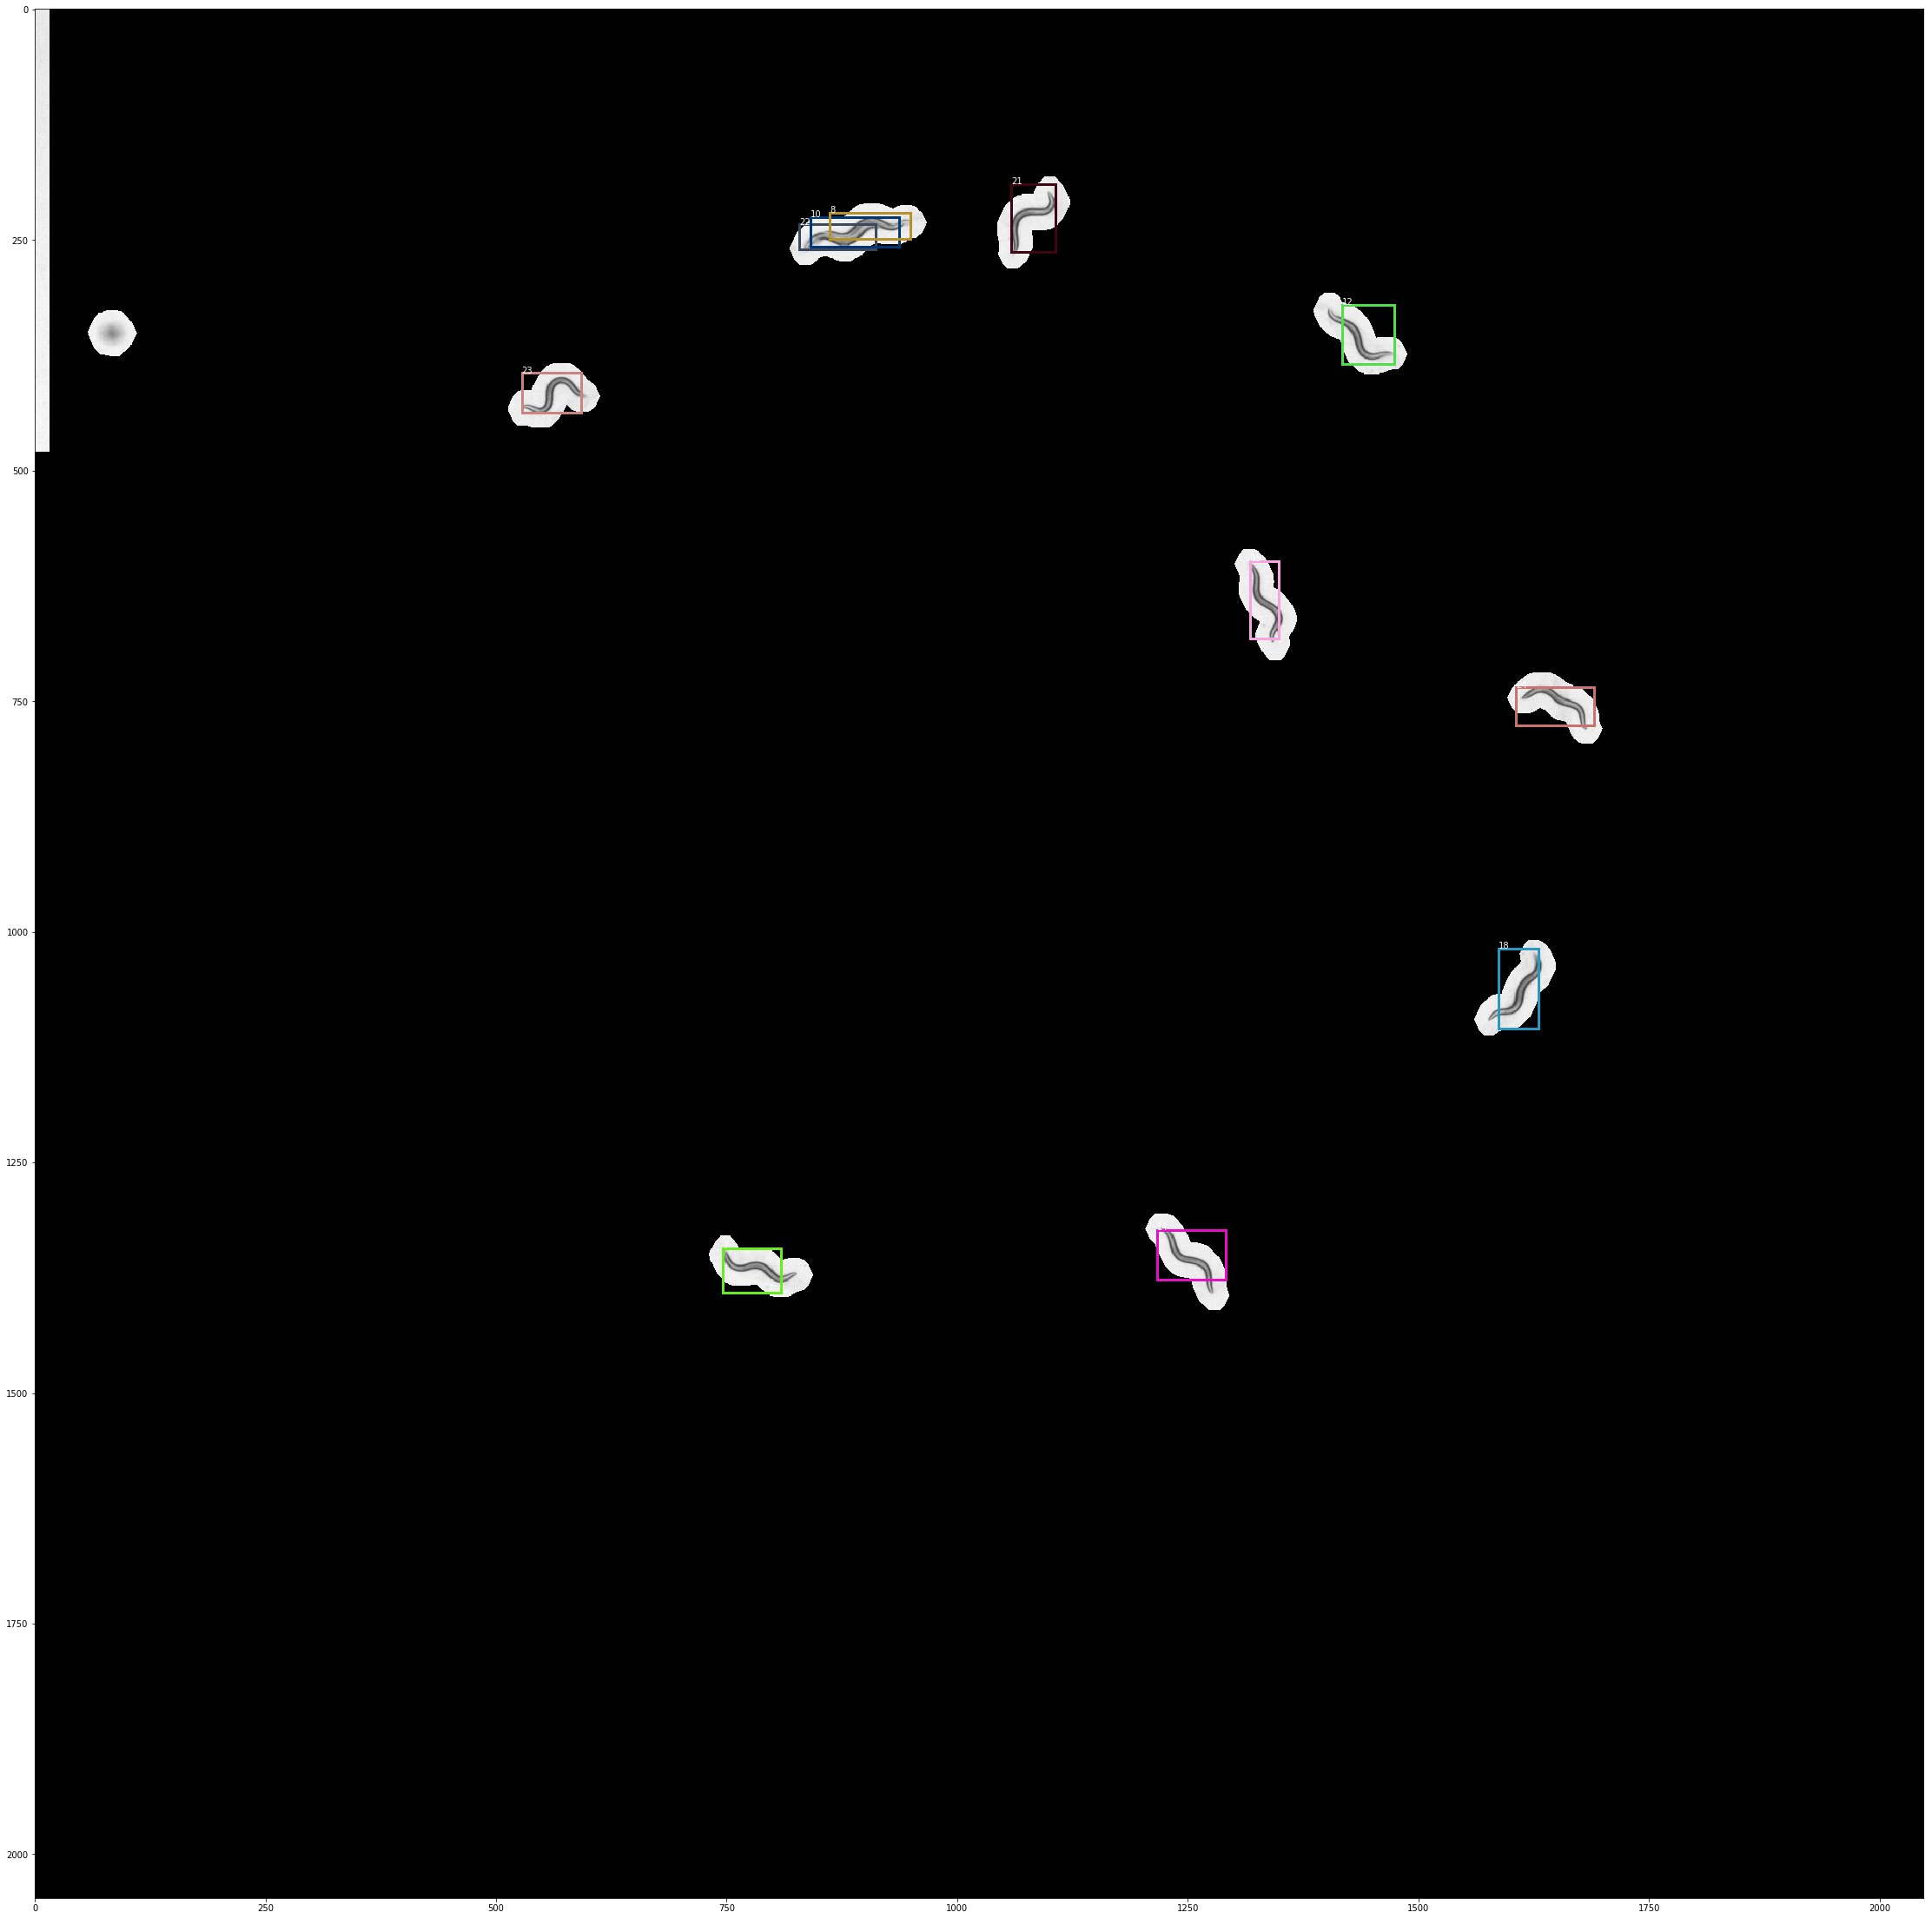

Worm IDs: [7.0, 8.0, 10.0, 12.0, 14.0, 18.0, 19.0, 21.0, 23.0, 24.0]


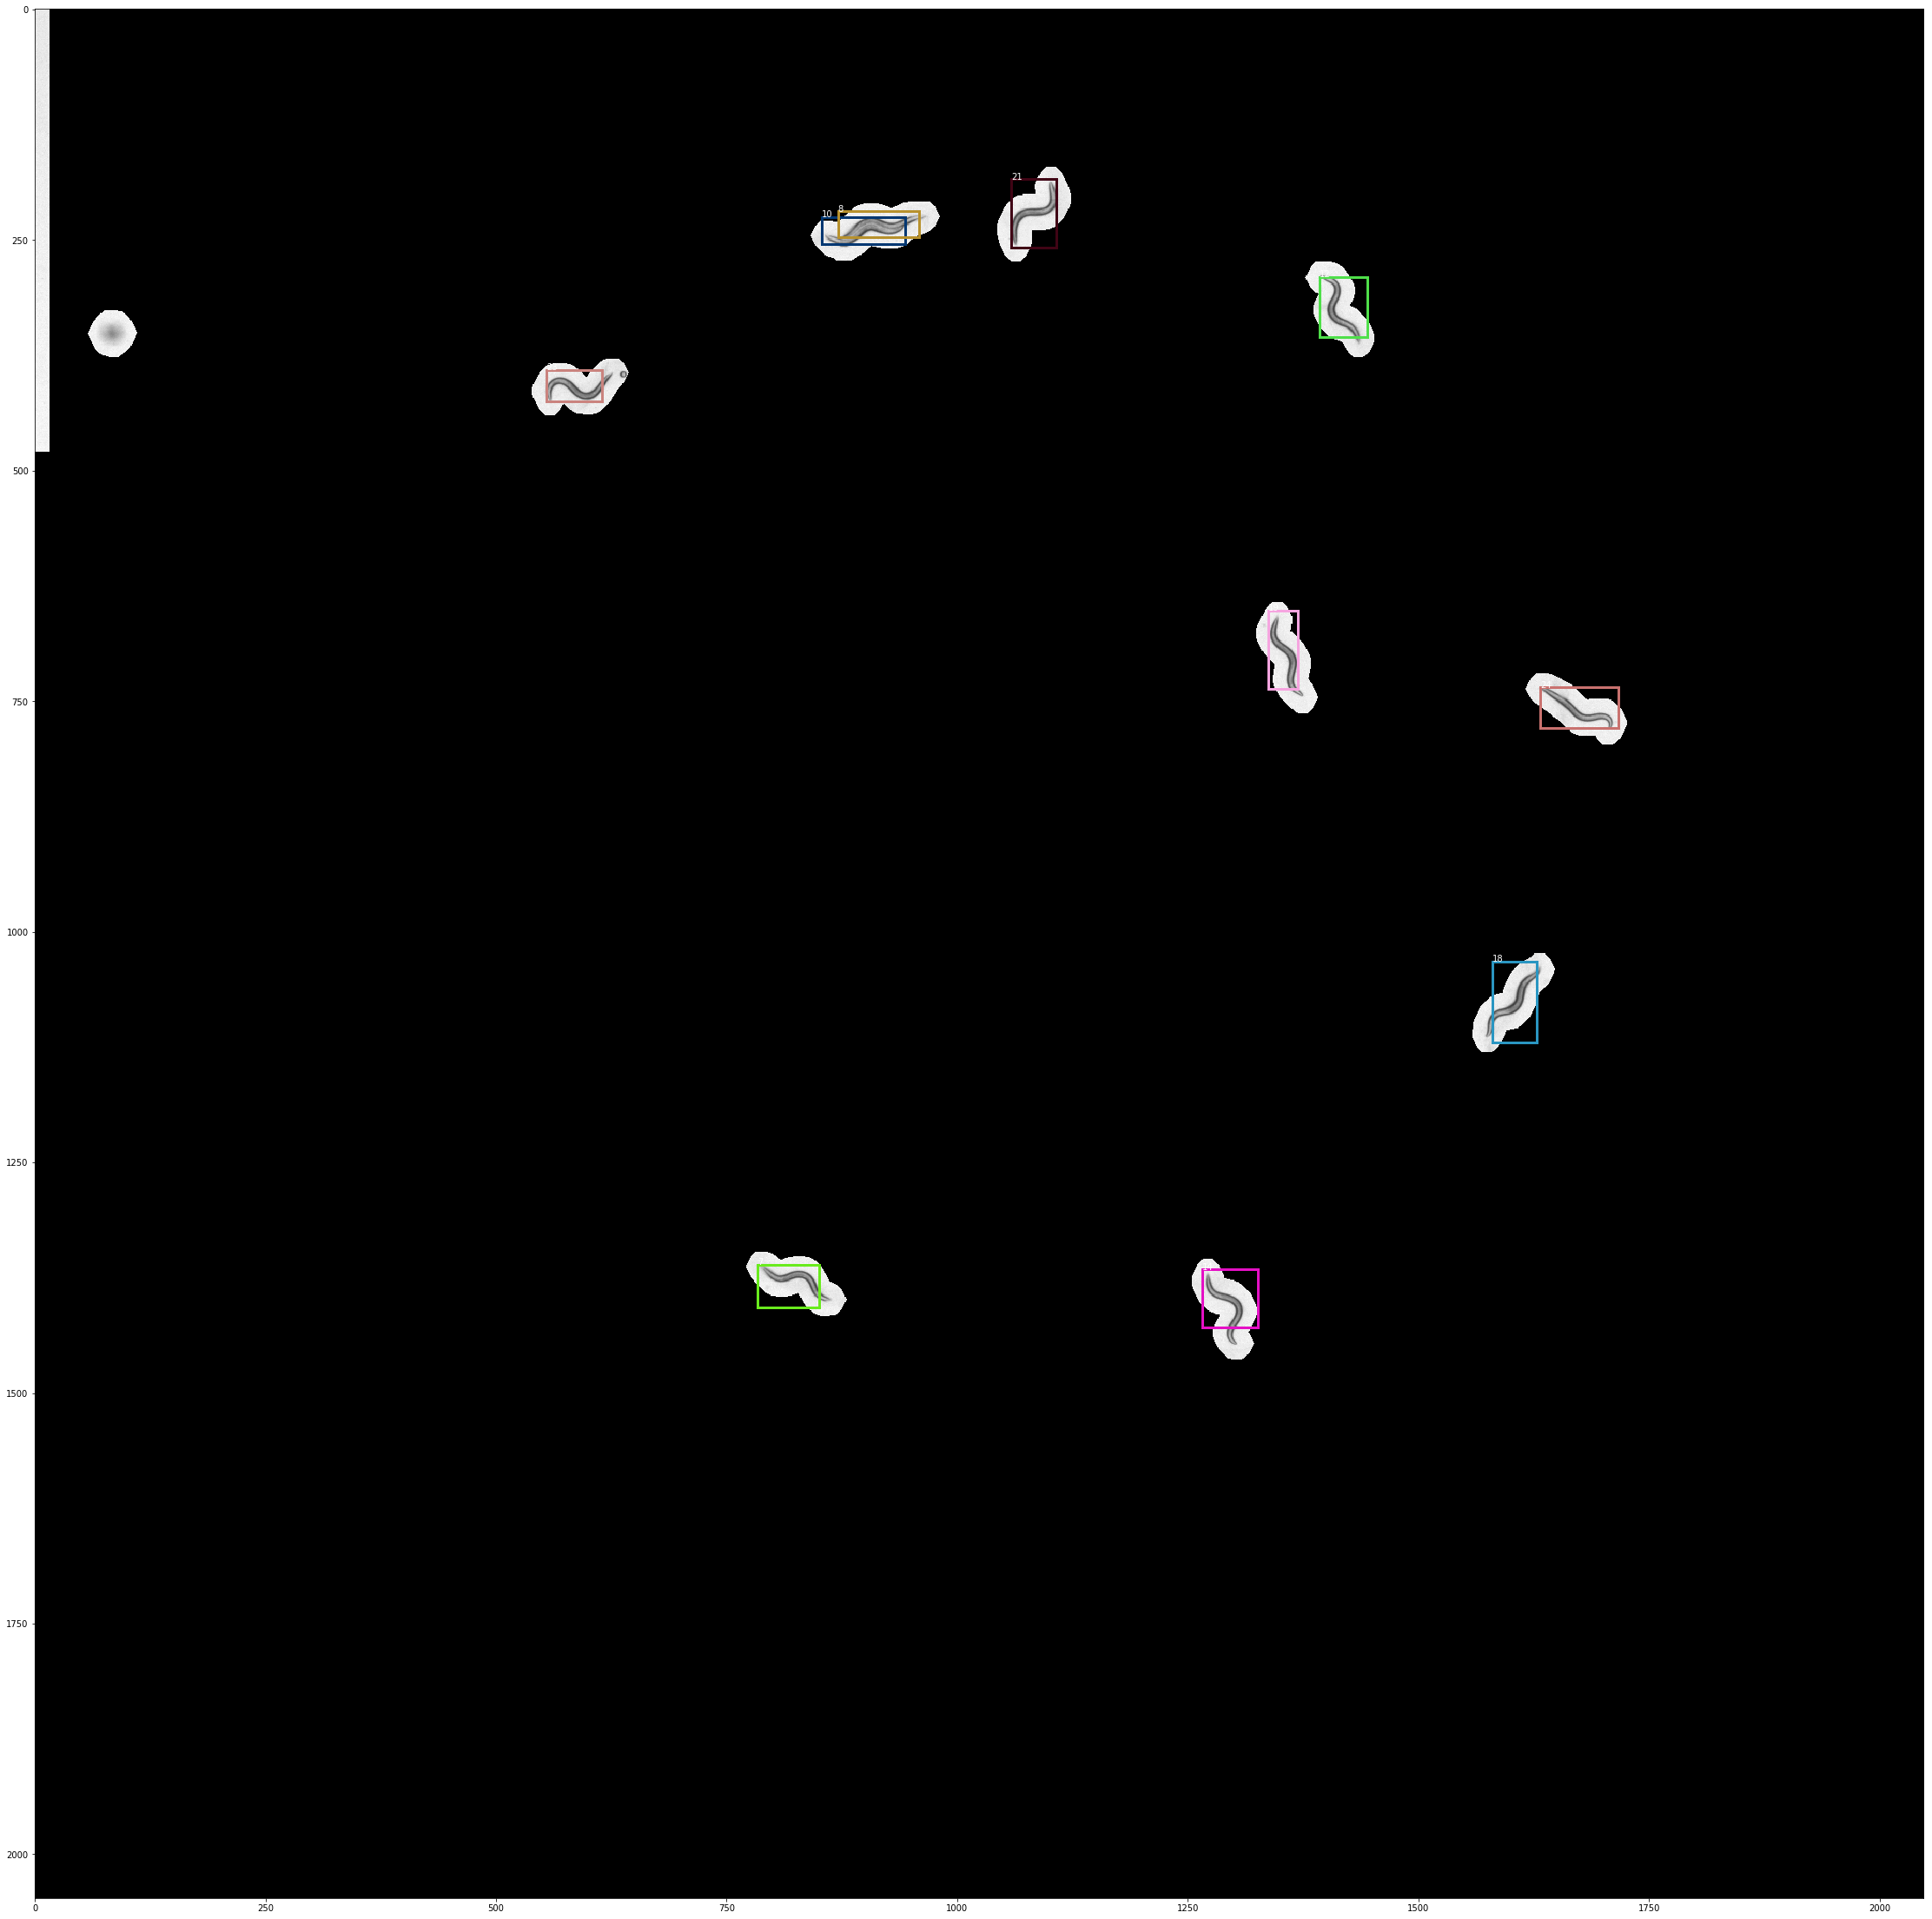

Worm IDs: [7.0, 10.0, 12.0, 18.0, 19.0, 21.0, 23.0, 24.0, 25.0]


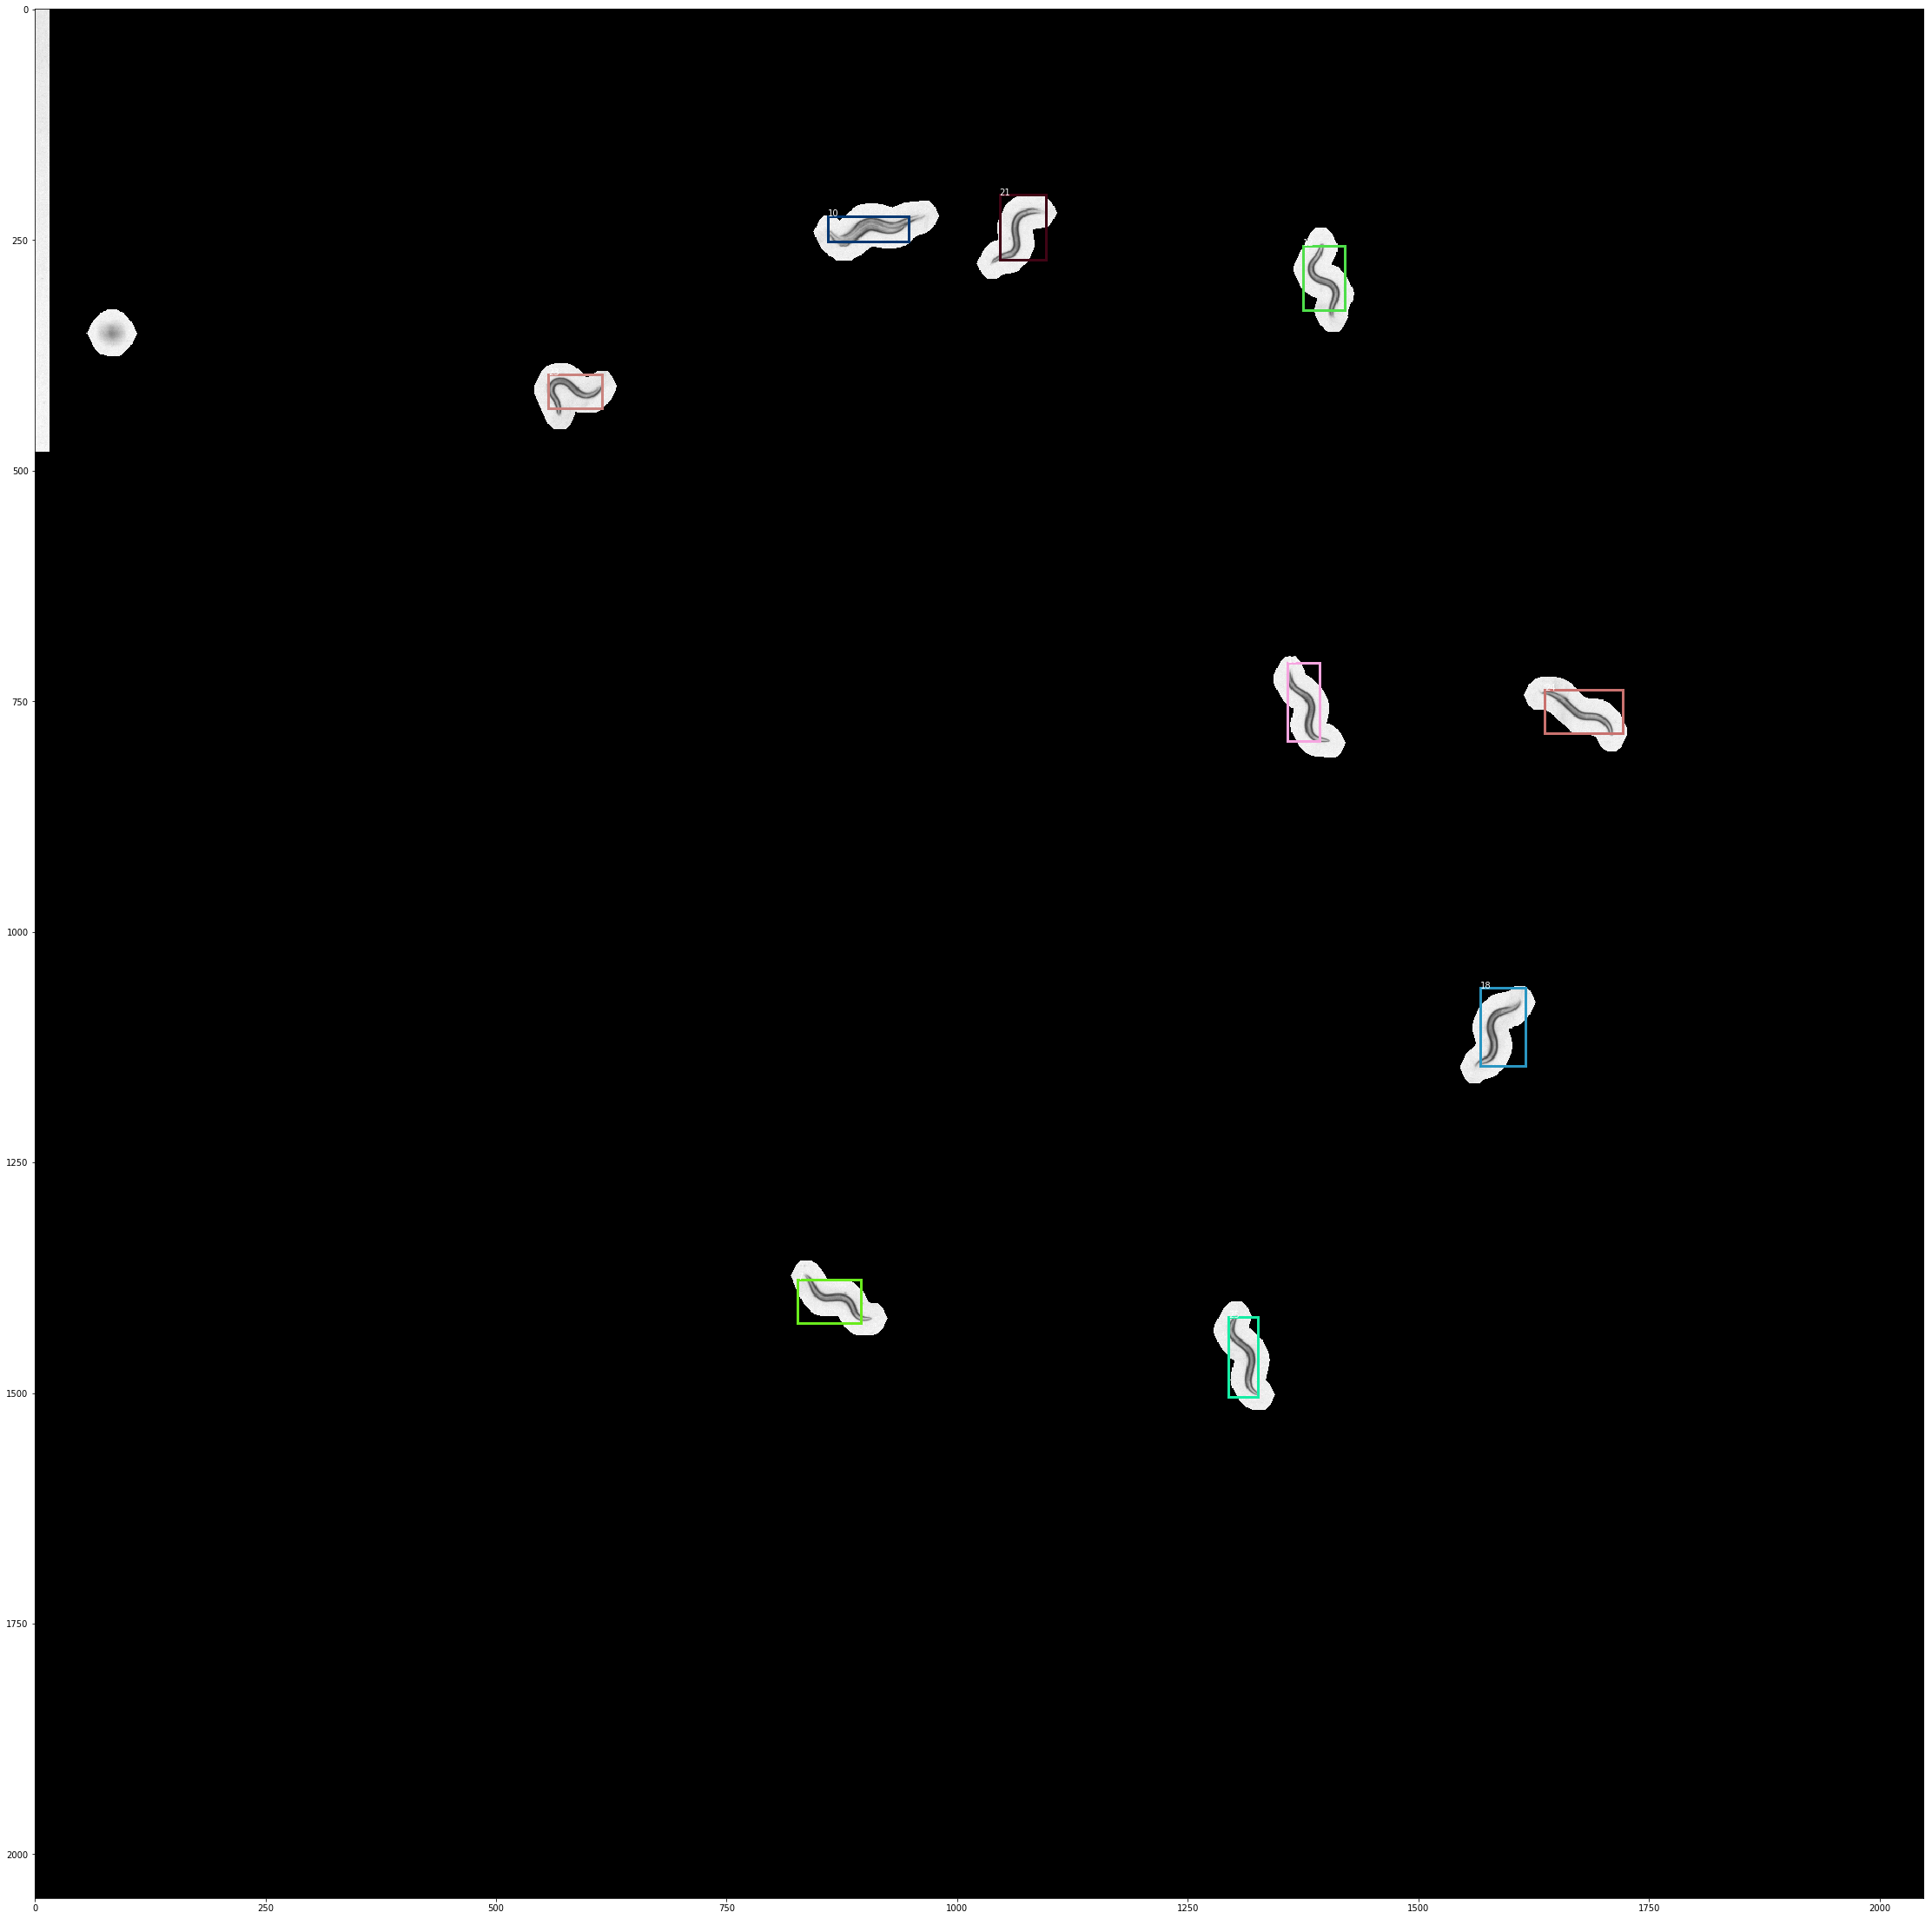

Worm IDs: [7.0, 10.0, 12.0, 18.0, 19.0, 21.0, 22.0, 23.0, 25.0, 26.0]


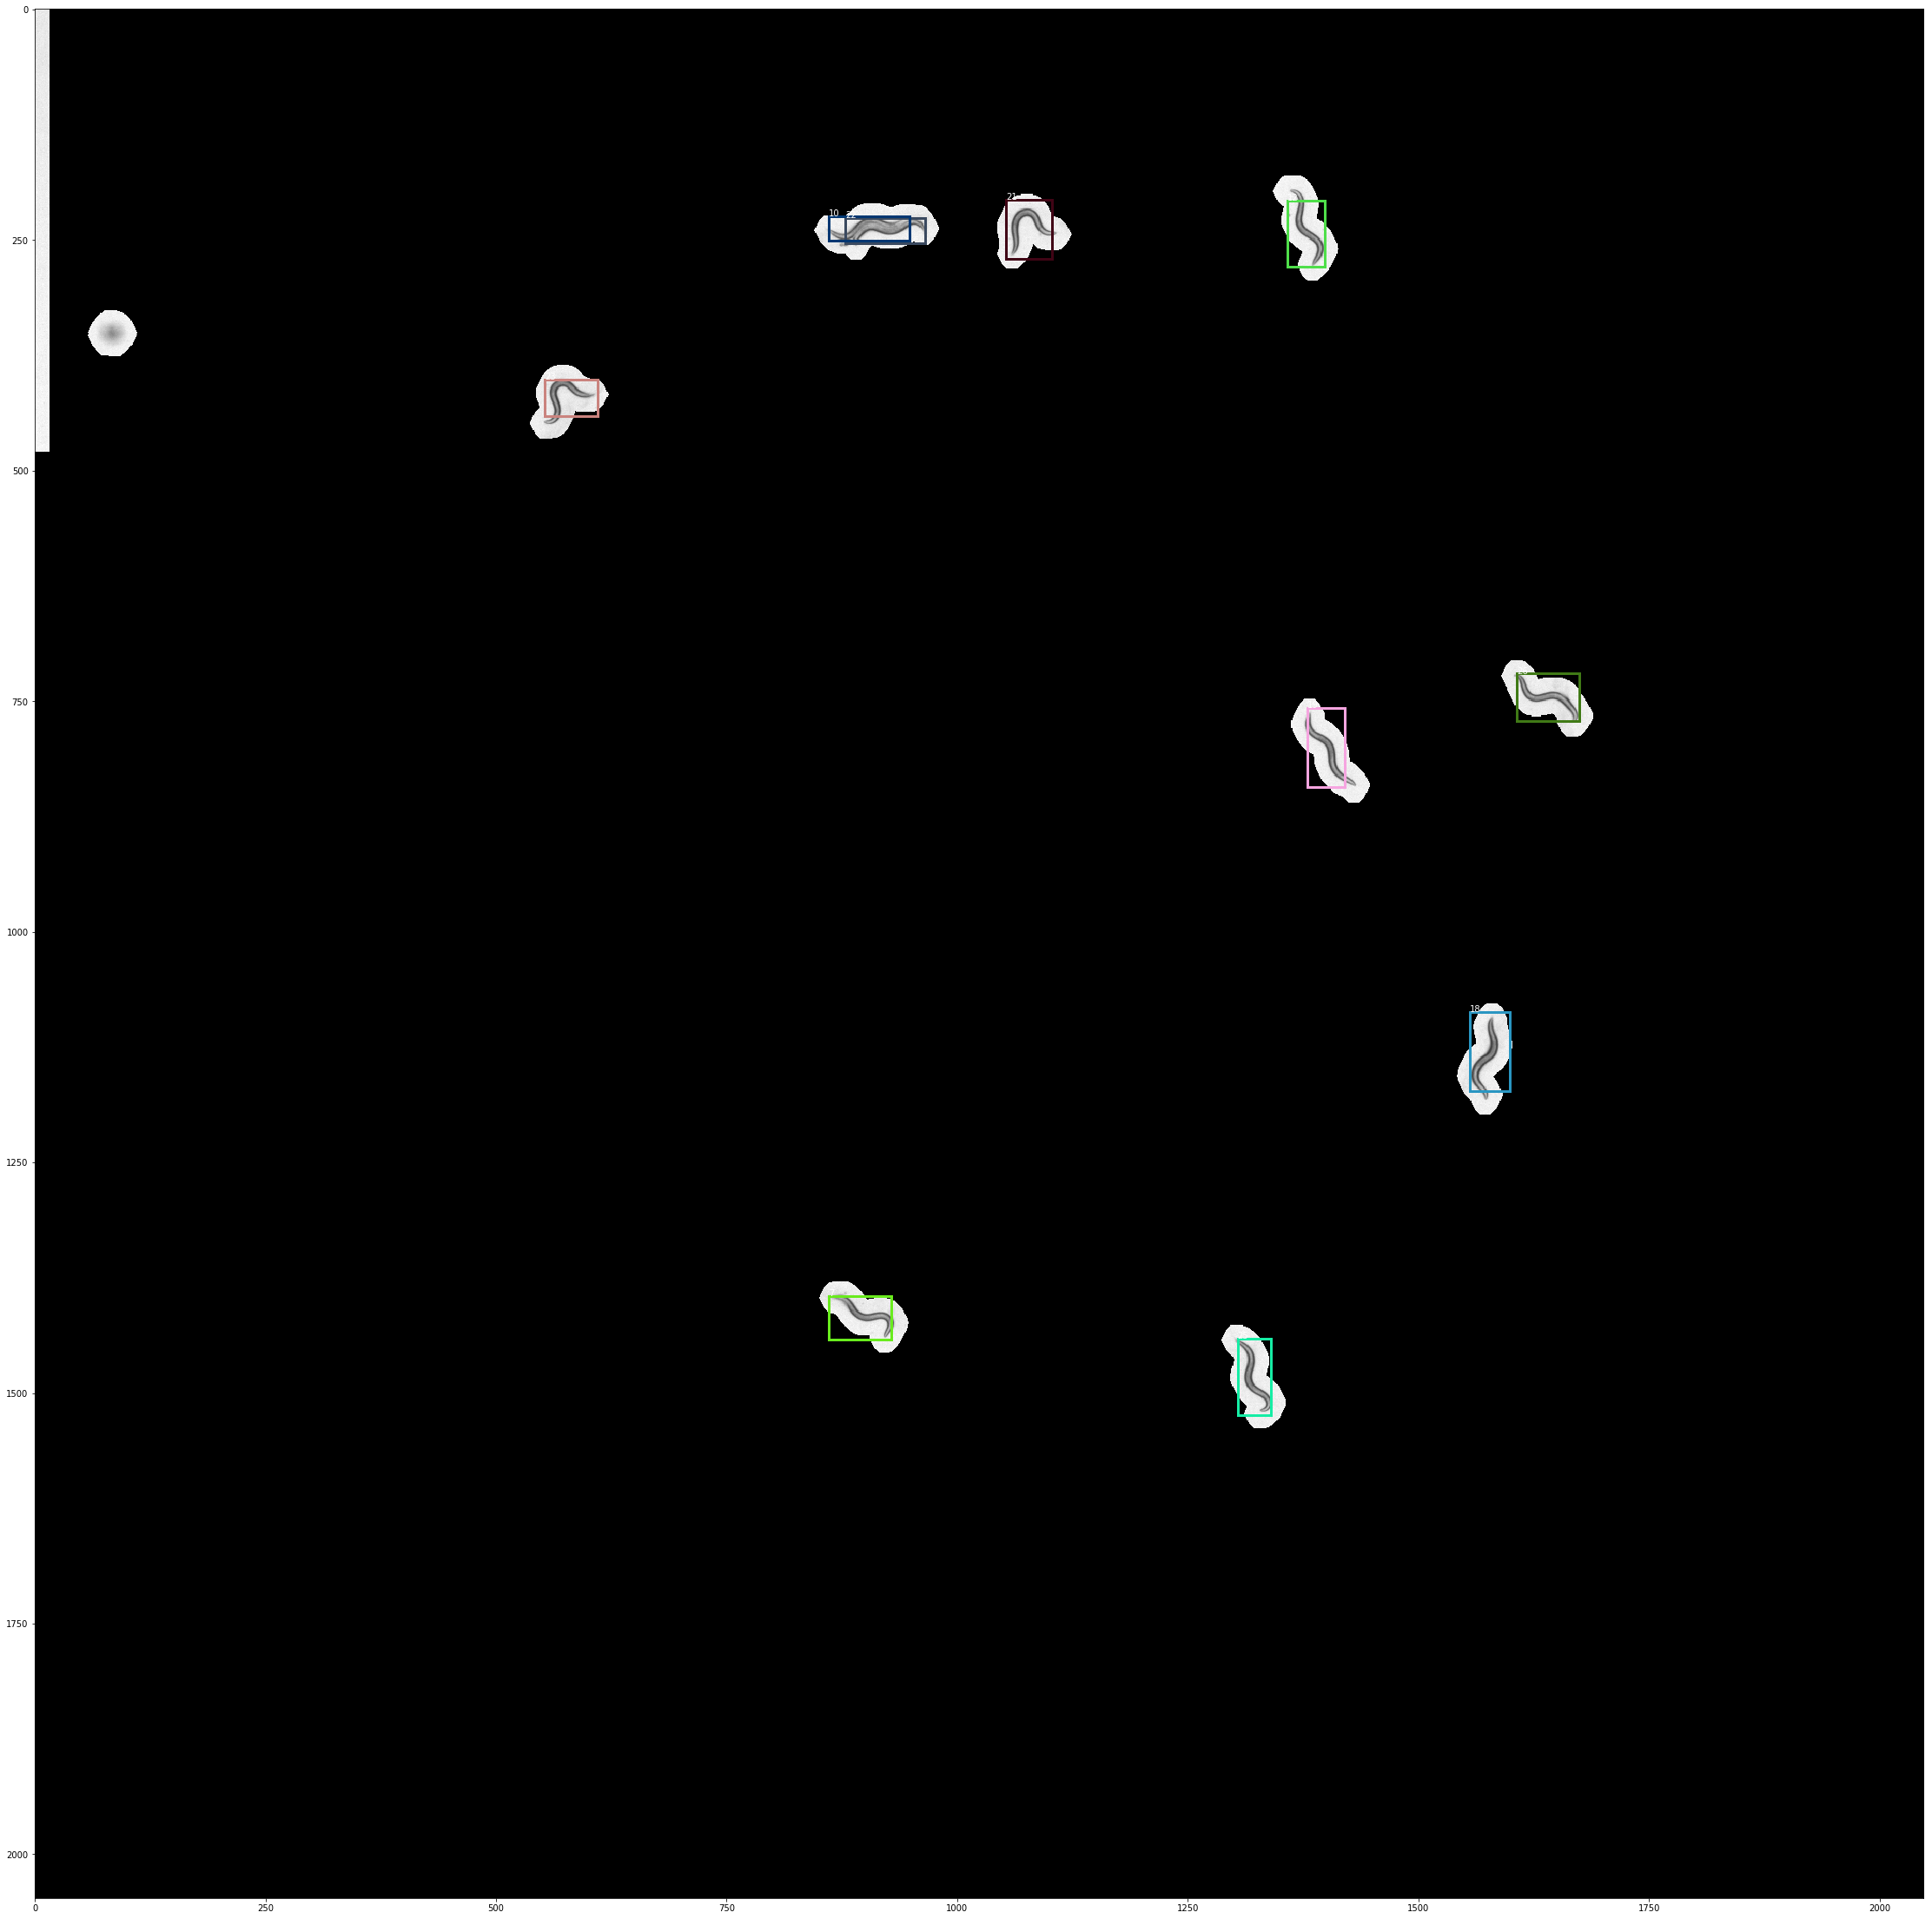

Worm IDs: [10.0, 18.0, 19.0, 21.0, 22.0, 23.0, 25.0, 26.0, 27.0, 28.0]


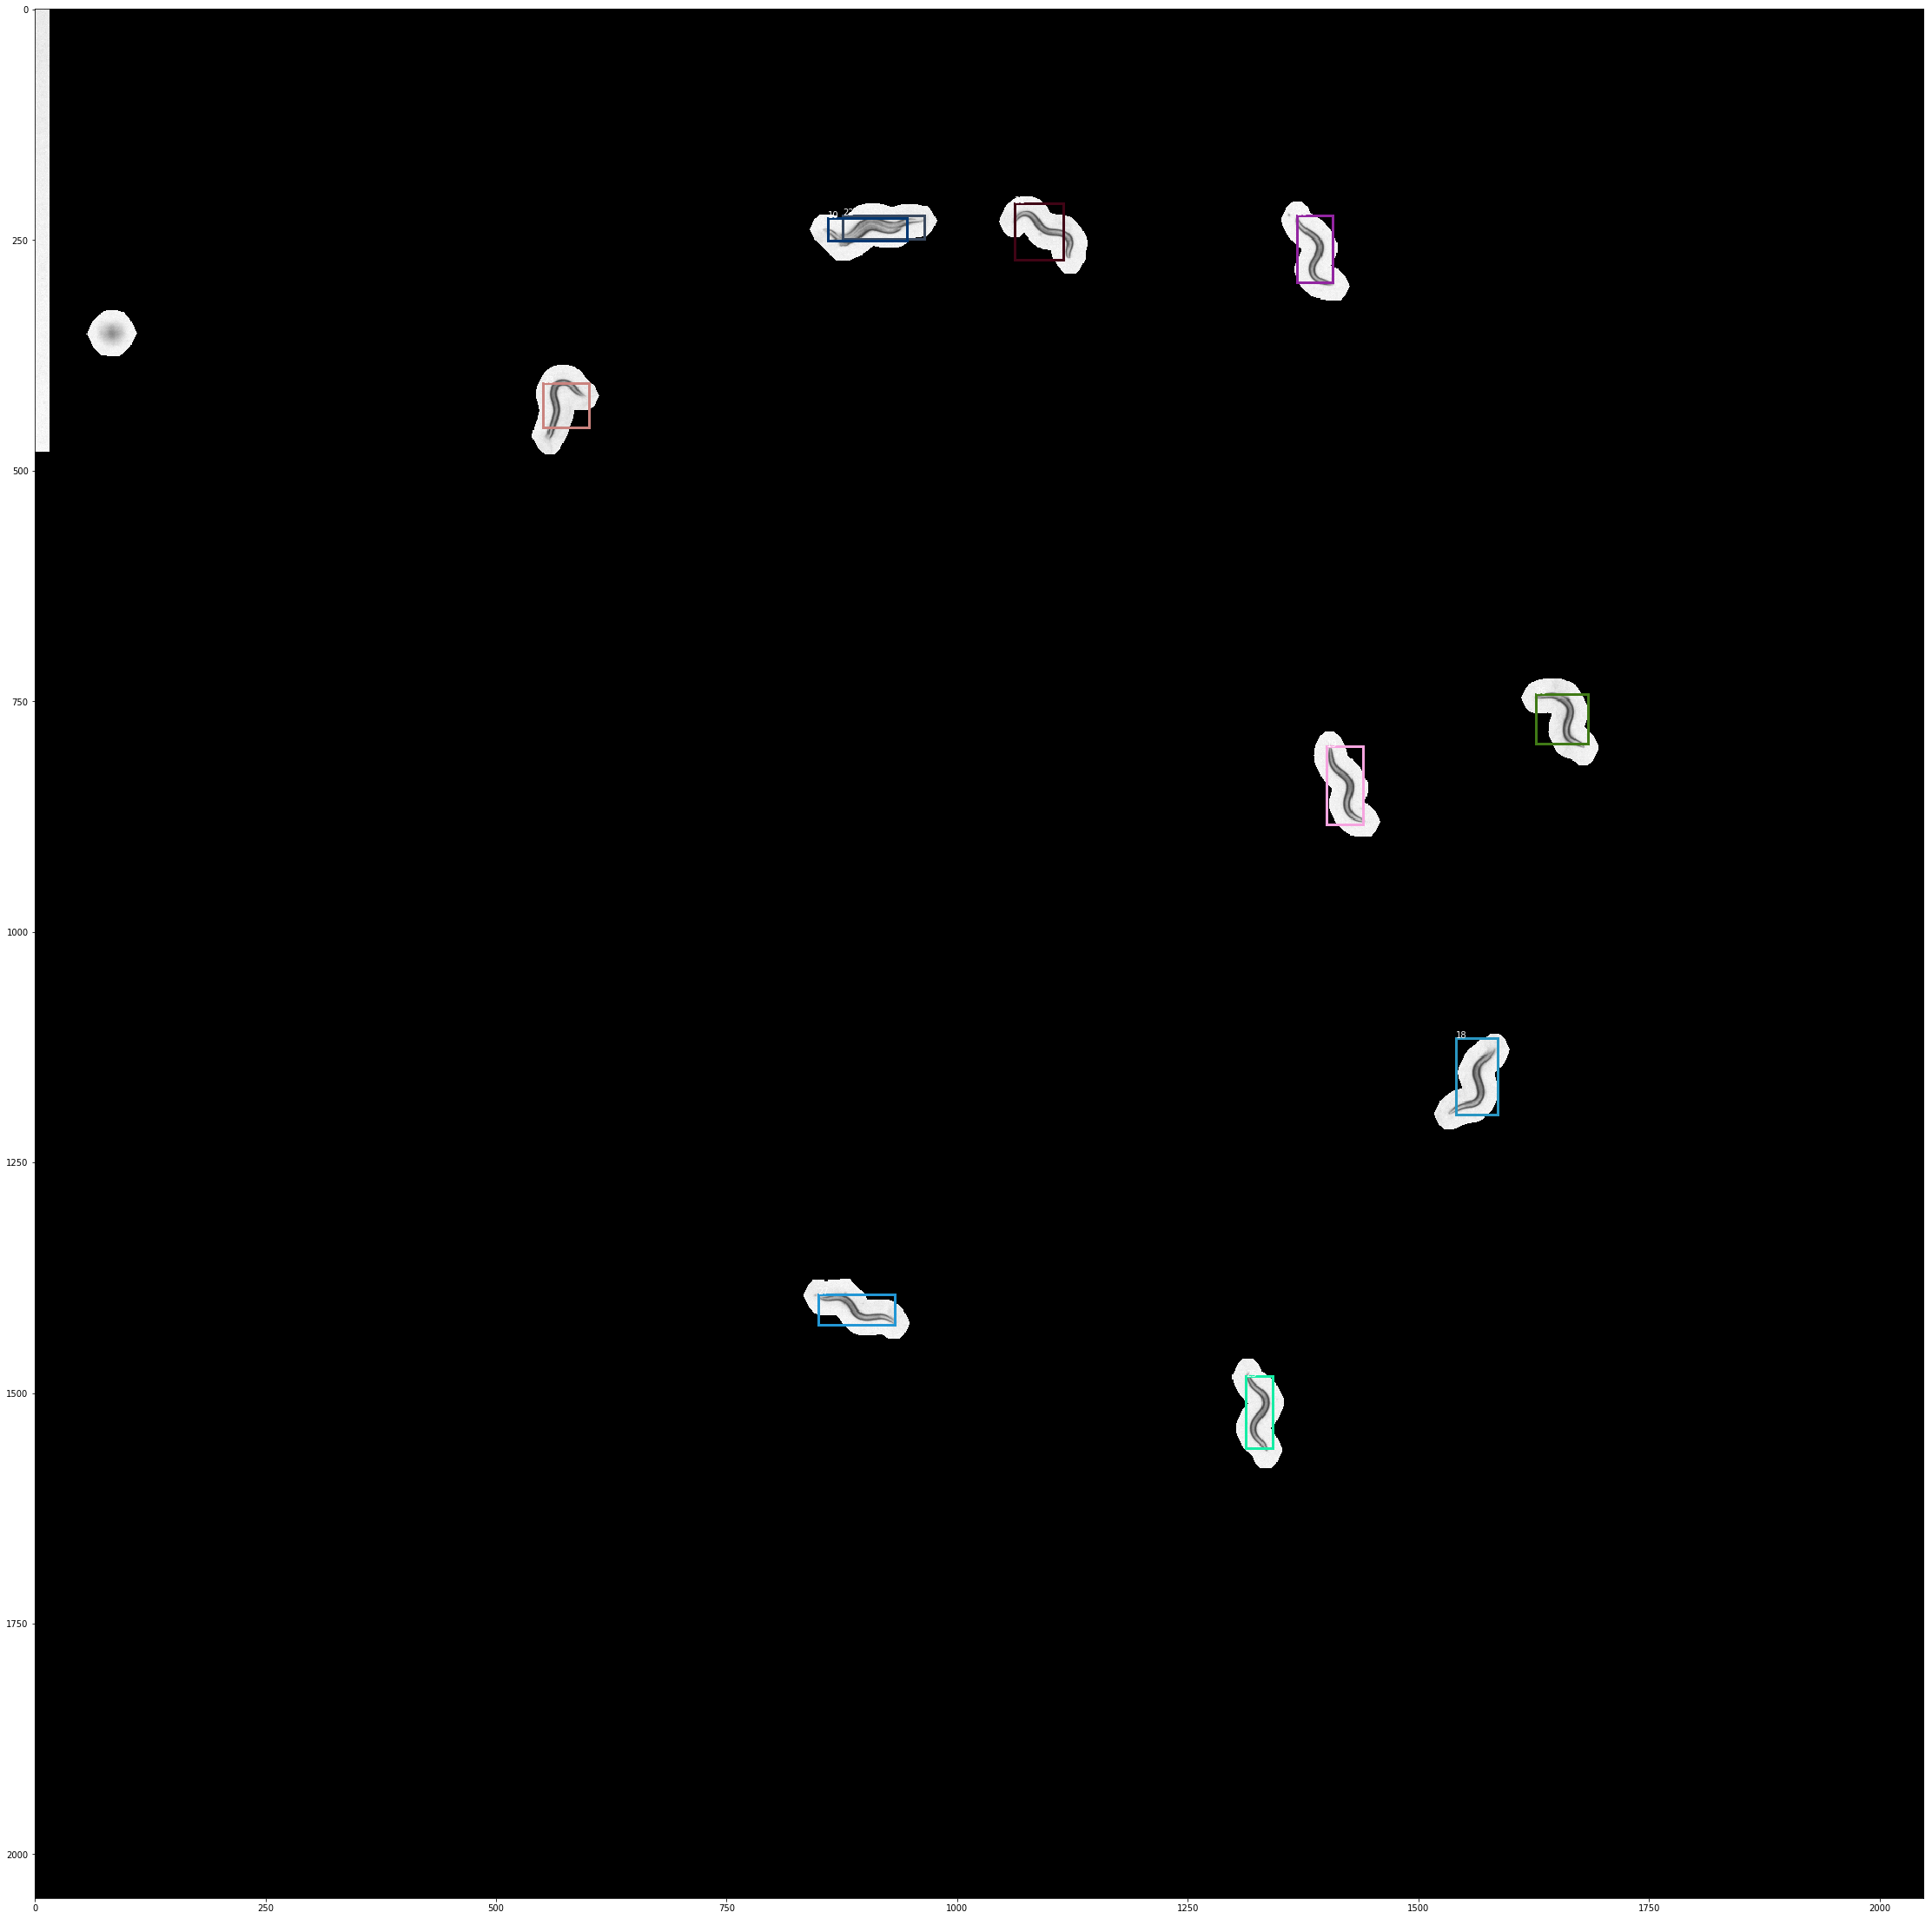

Worm IDs: [10.0, 18.0, 19.0, 21.0, 23.0, 25.0, 26.0, 27.0, 28.0]


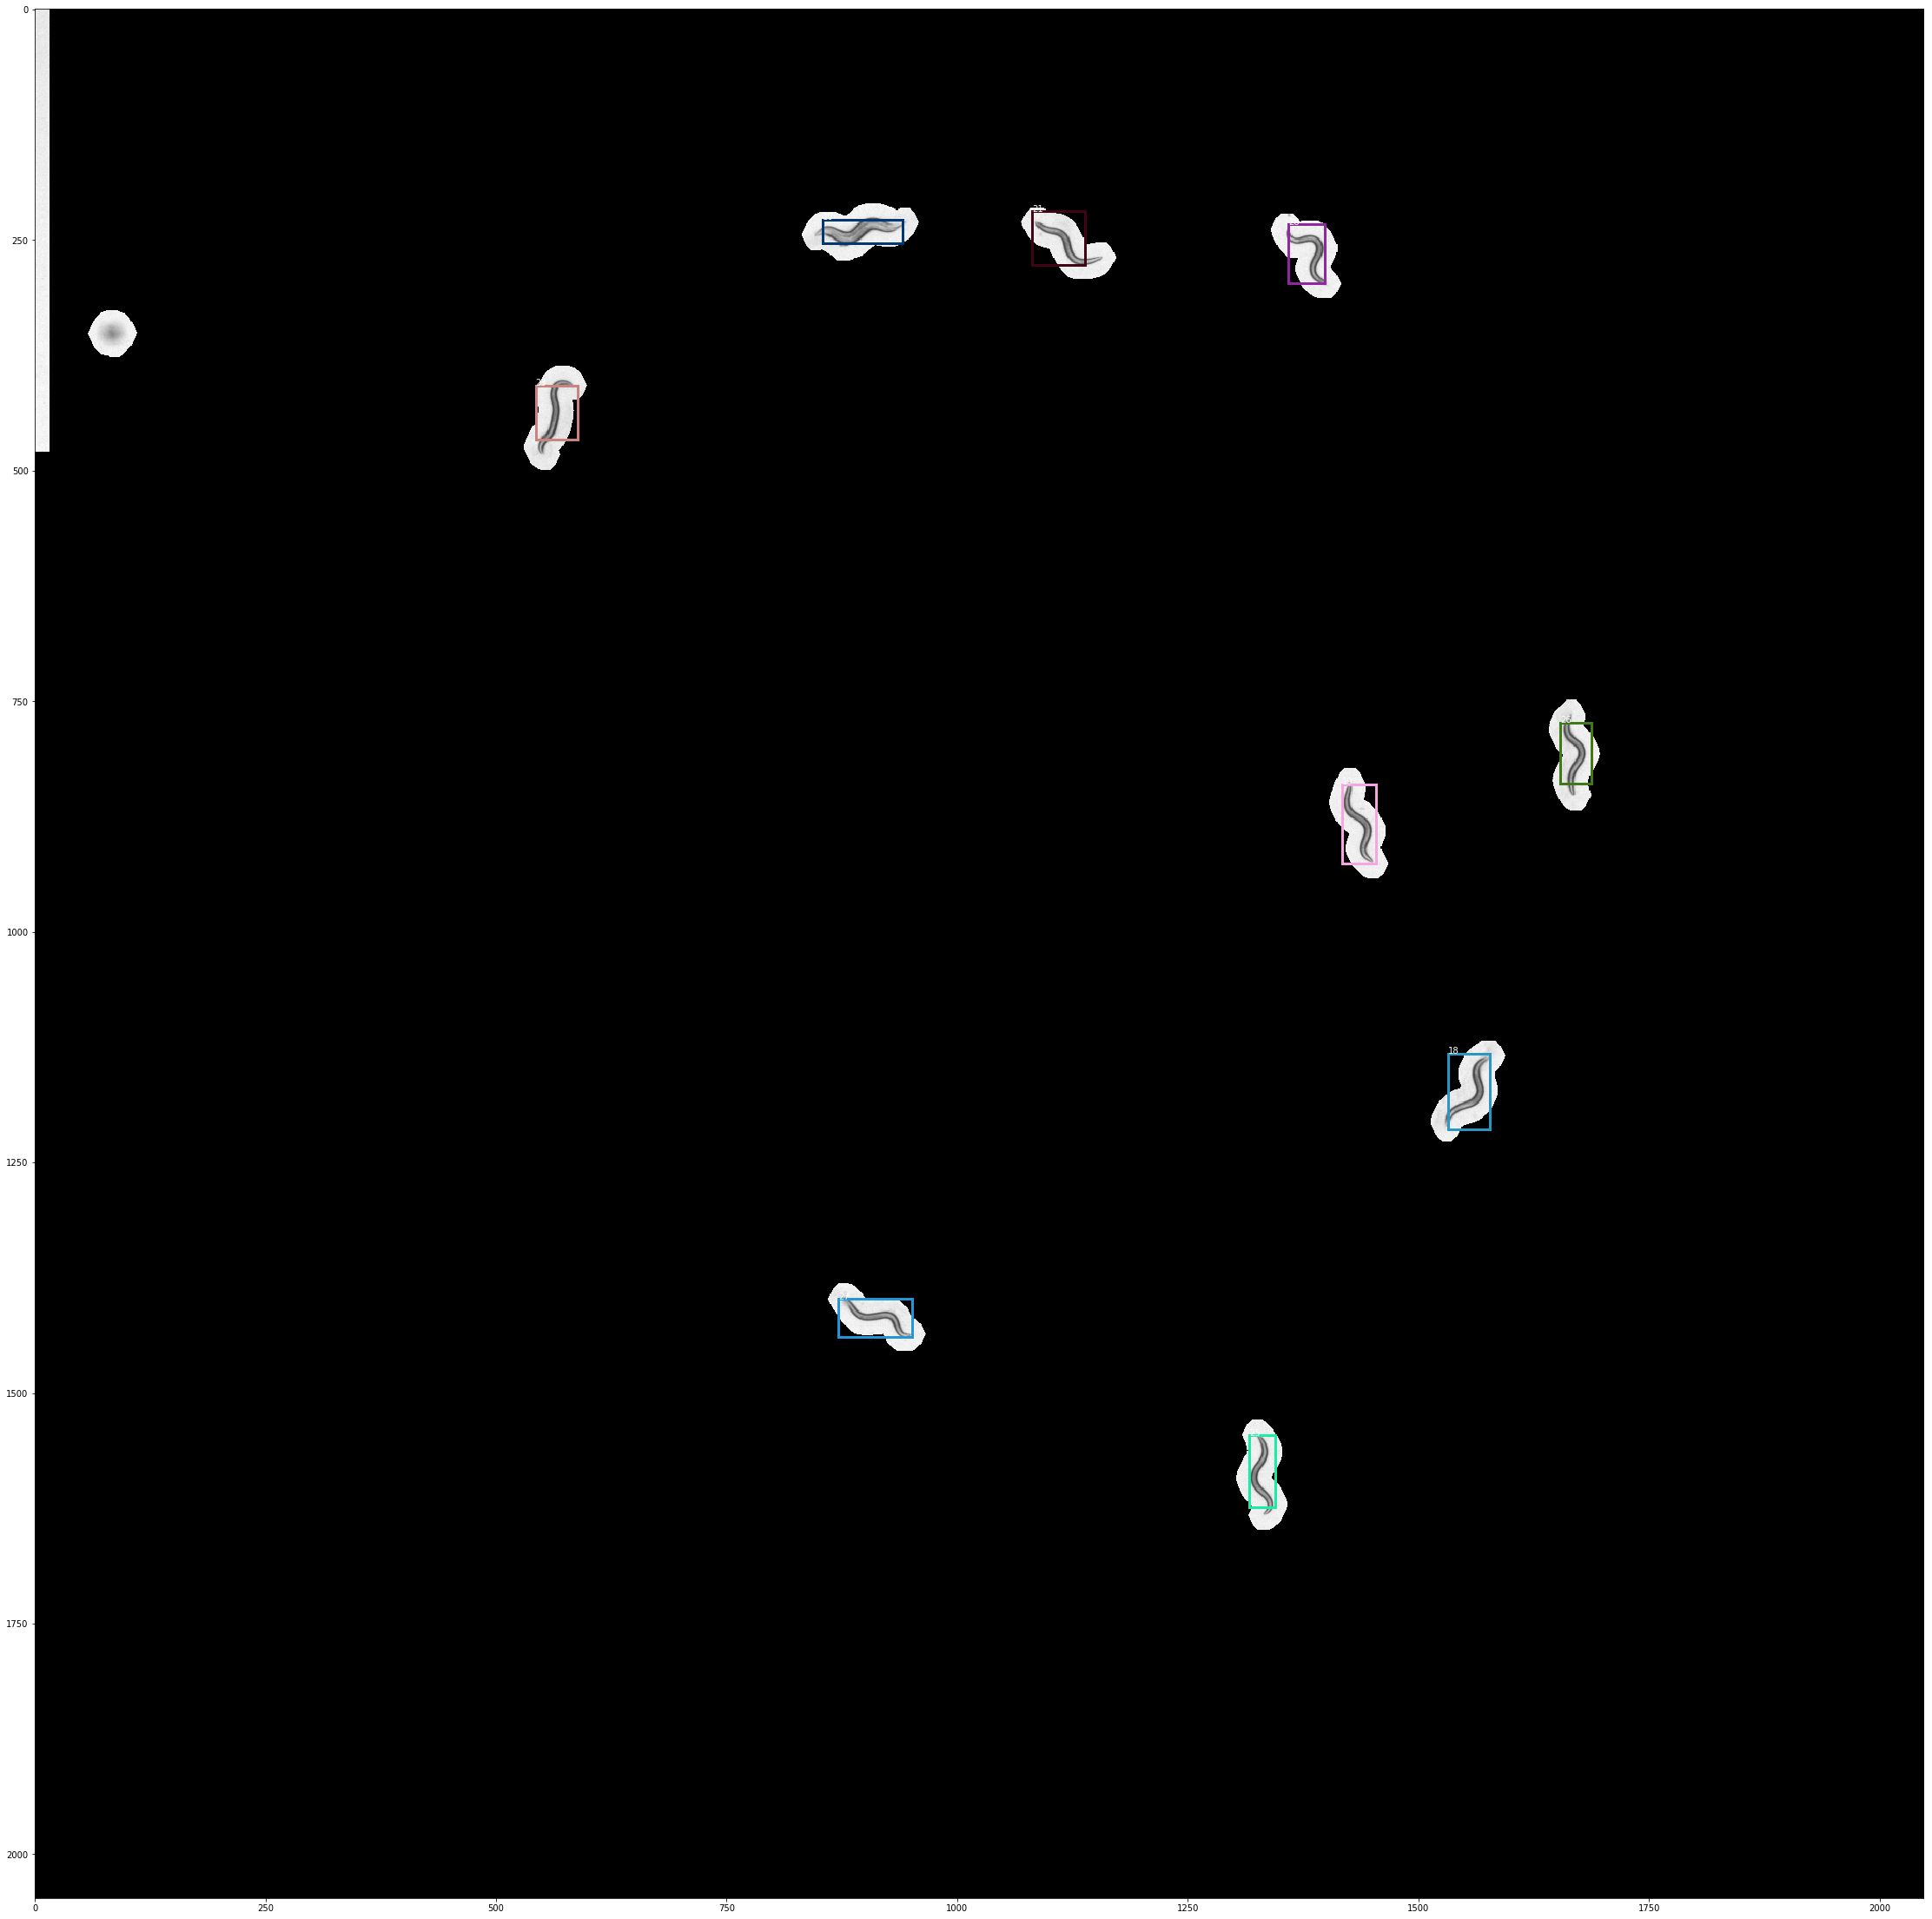

Worm IDs: [10.0, 18.0, 19.0, 21.0, 22.0, 23.0, 27.0, 28.0, 29.0, 30.0]


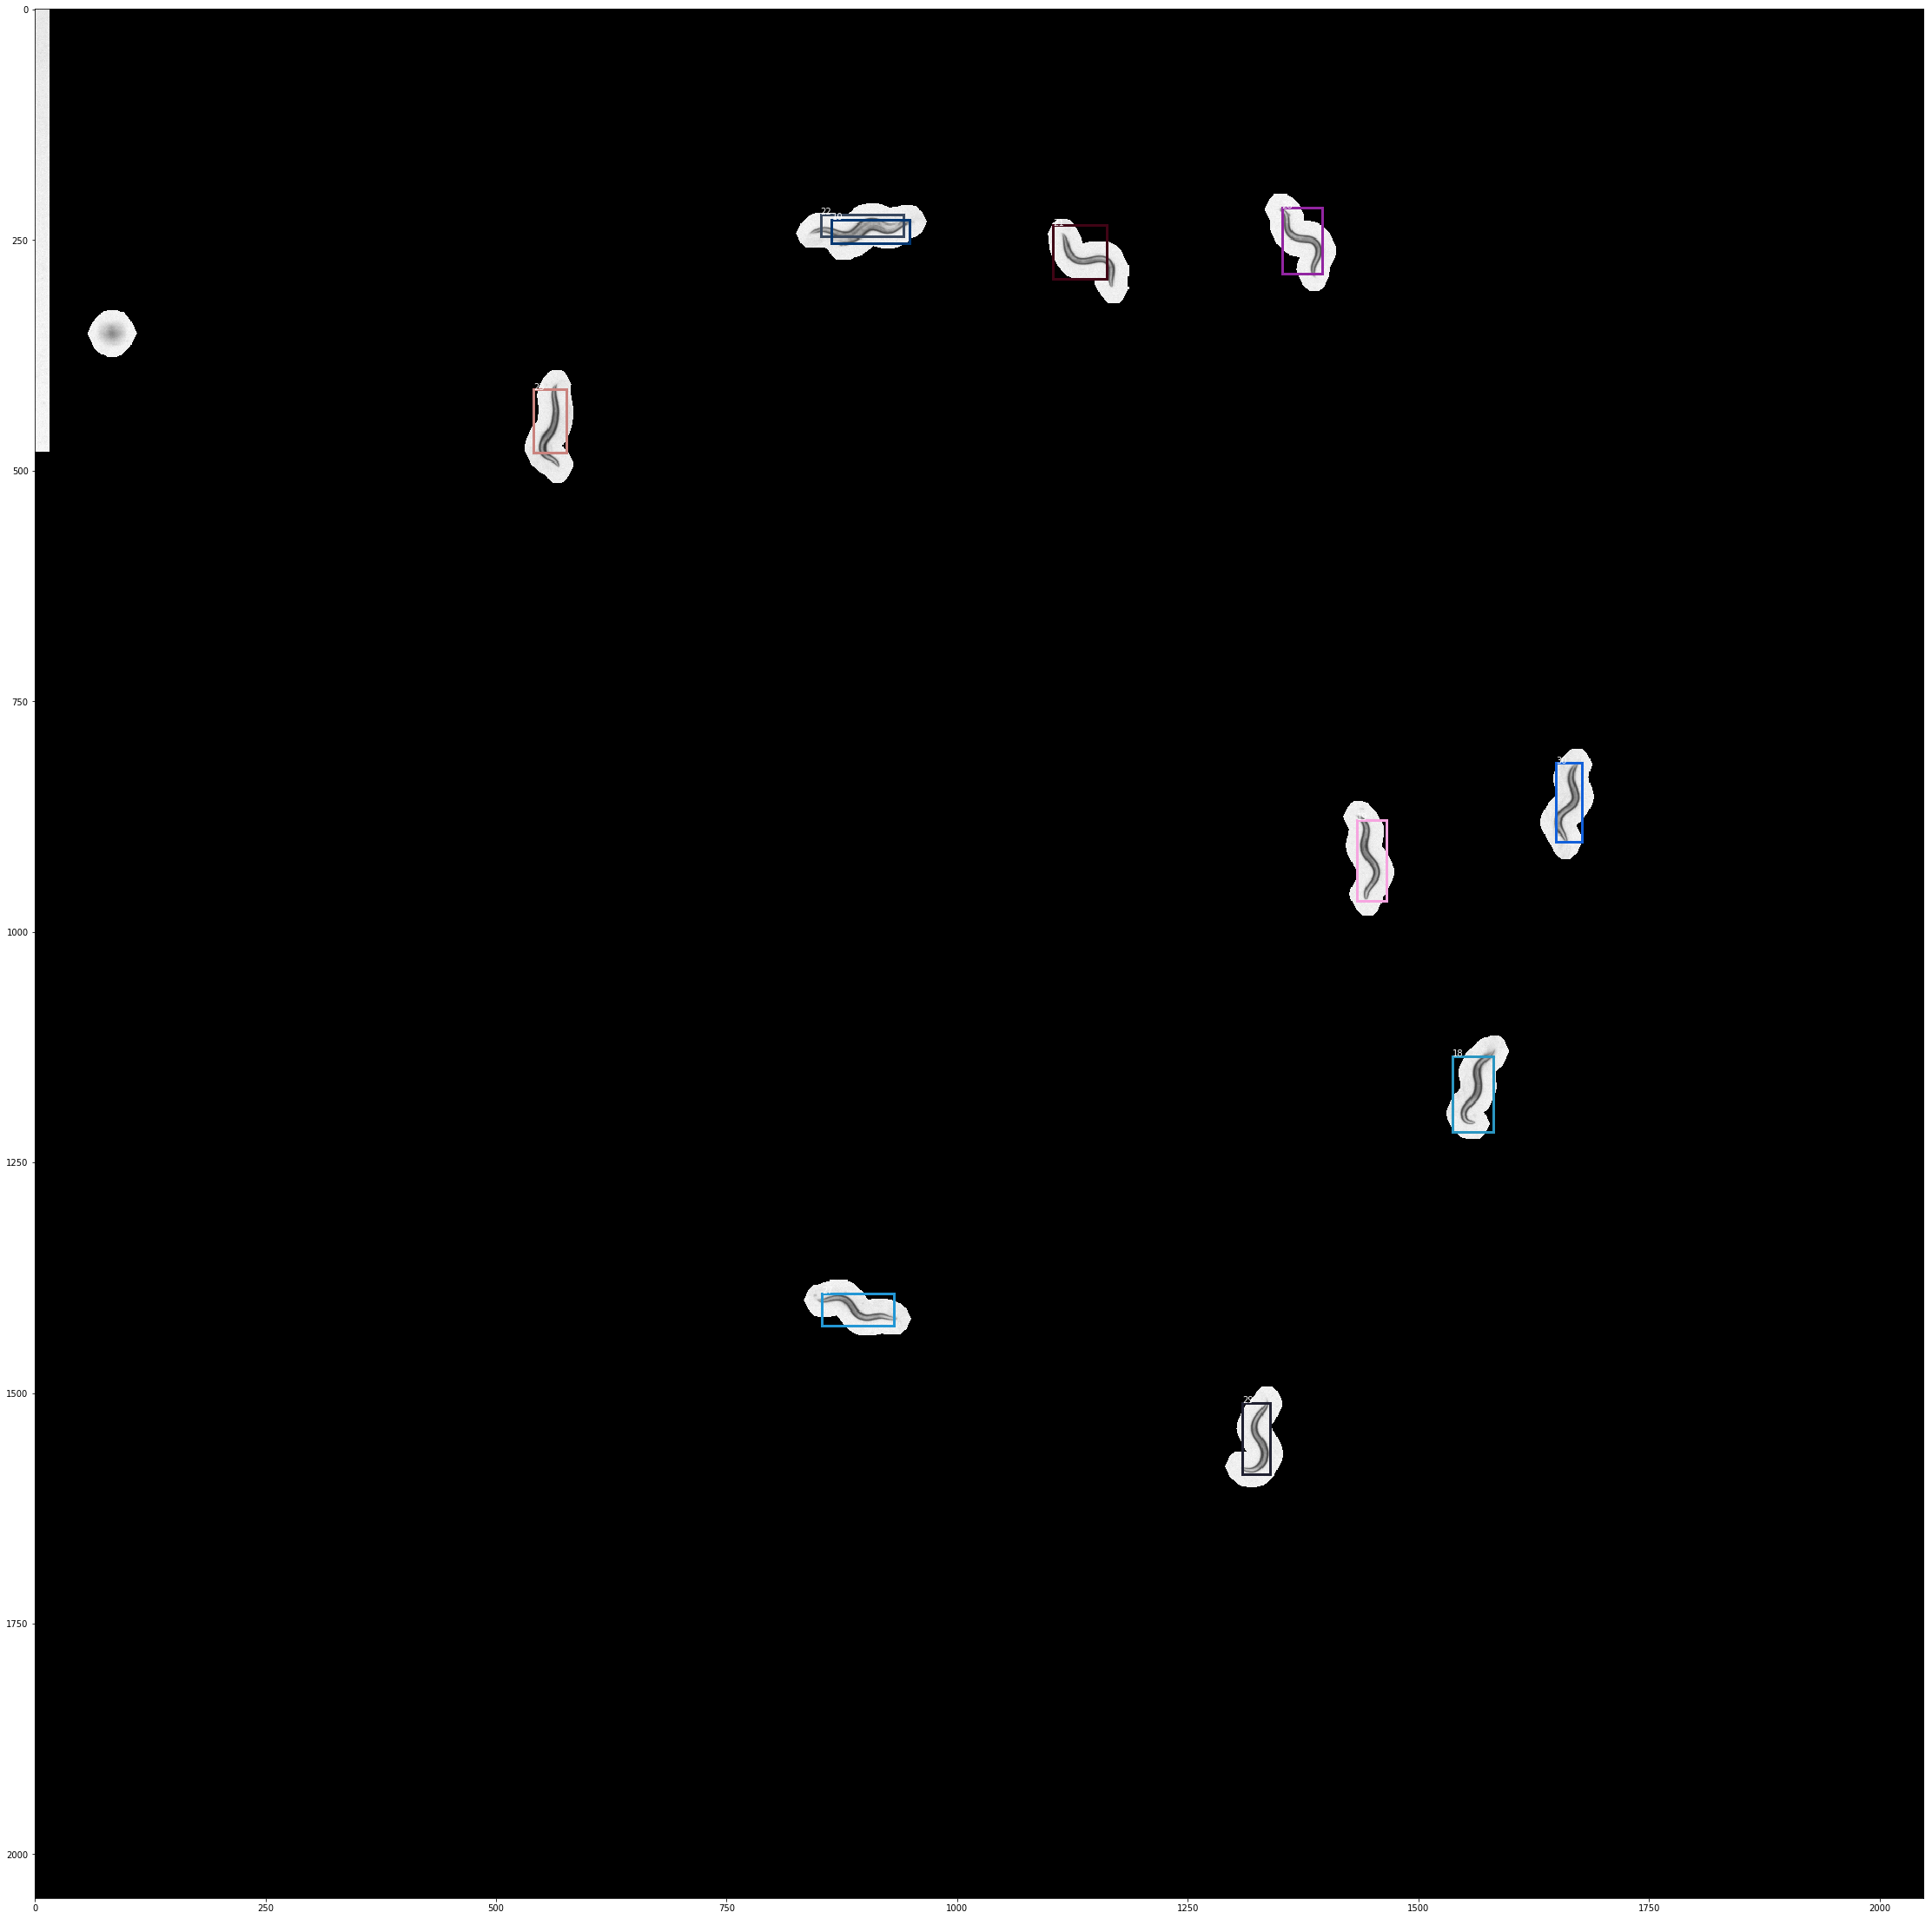

Worm IDs: [10.0, 18.0, 19.0, 21.0, 22.0, 23.0, 27.0, 28.0, 30.0, 31.0]


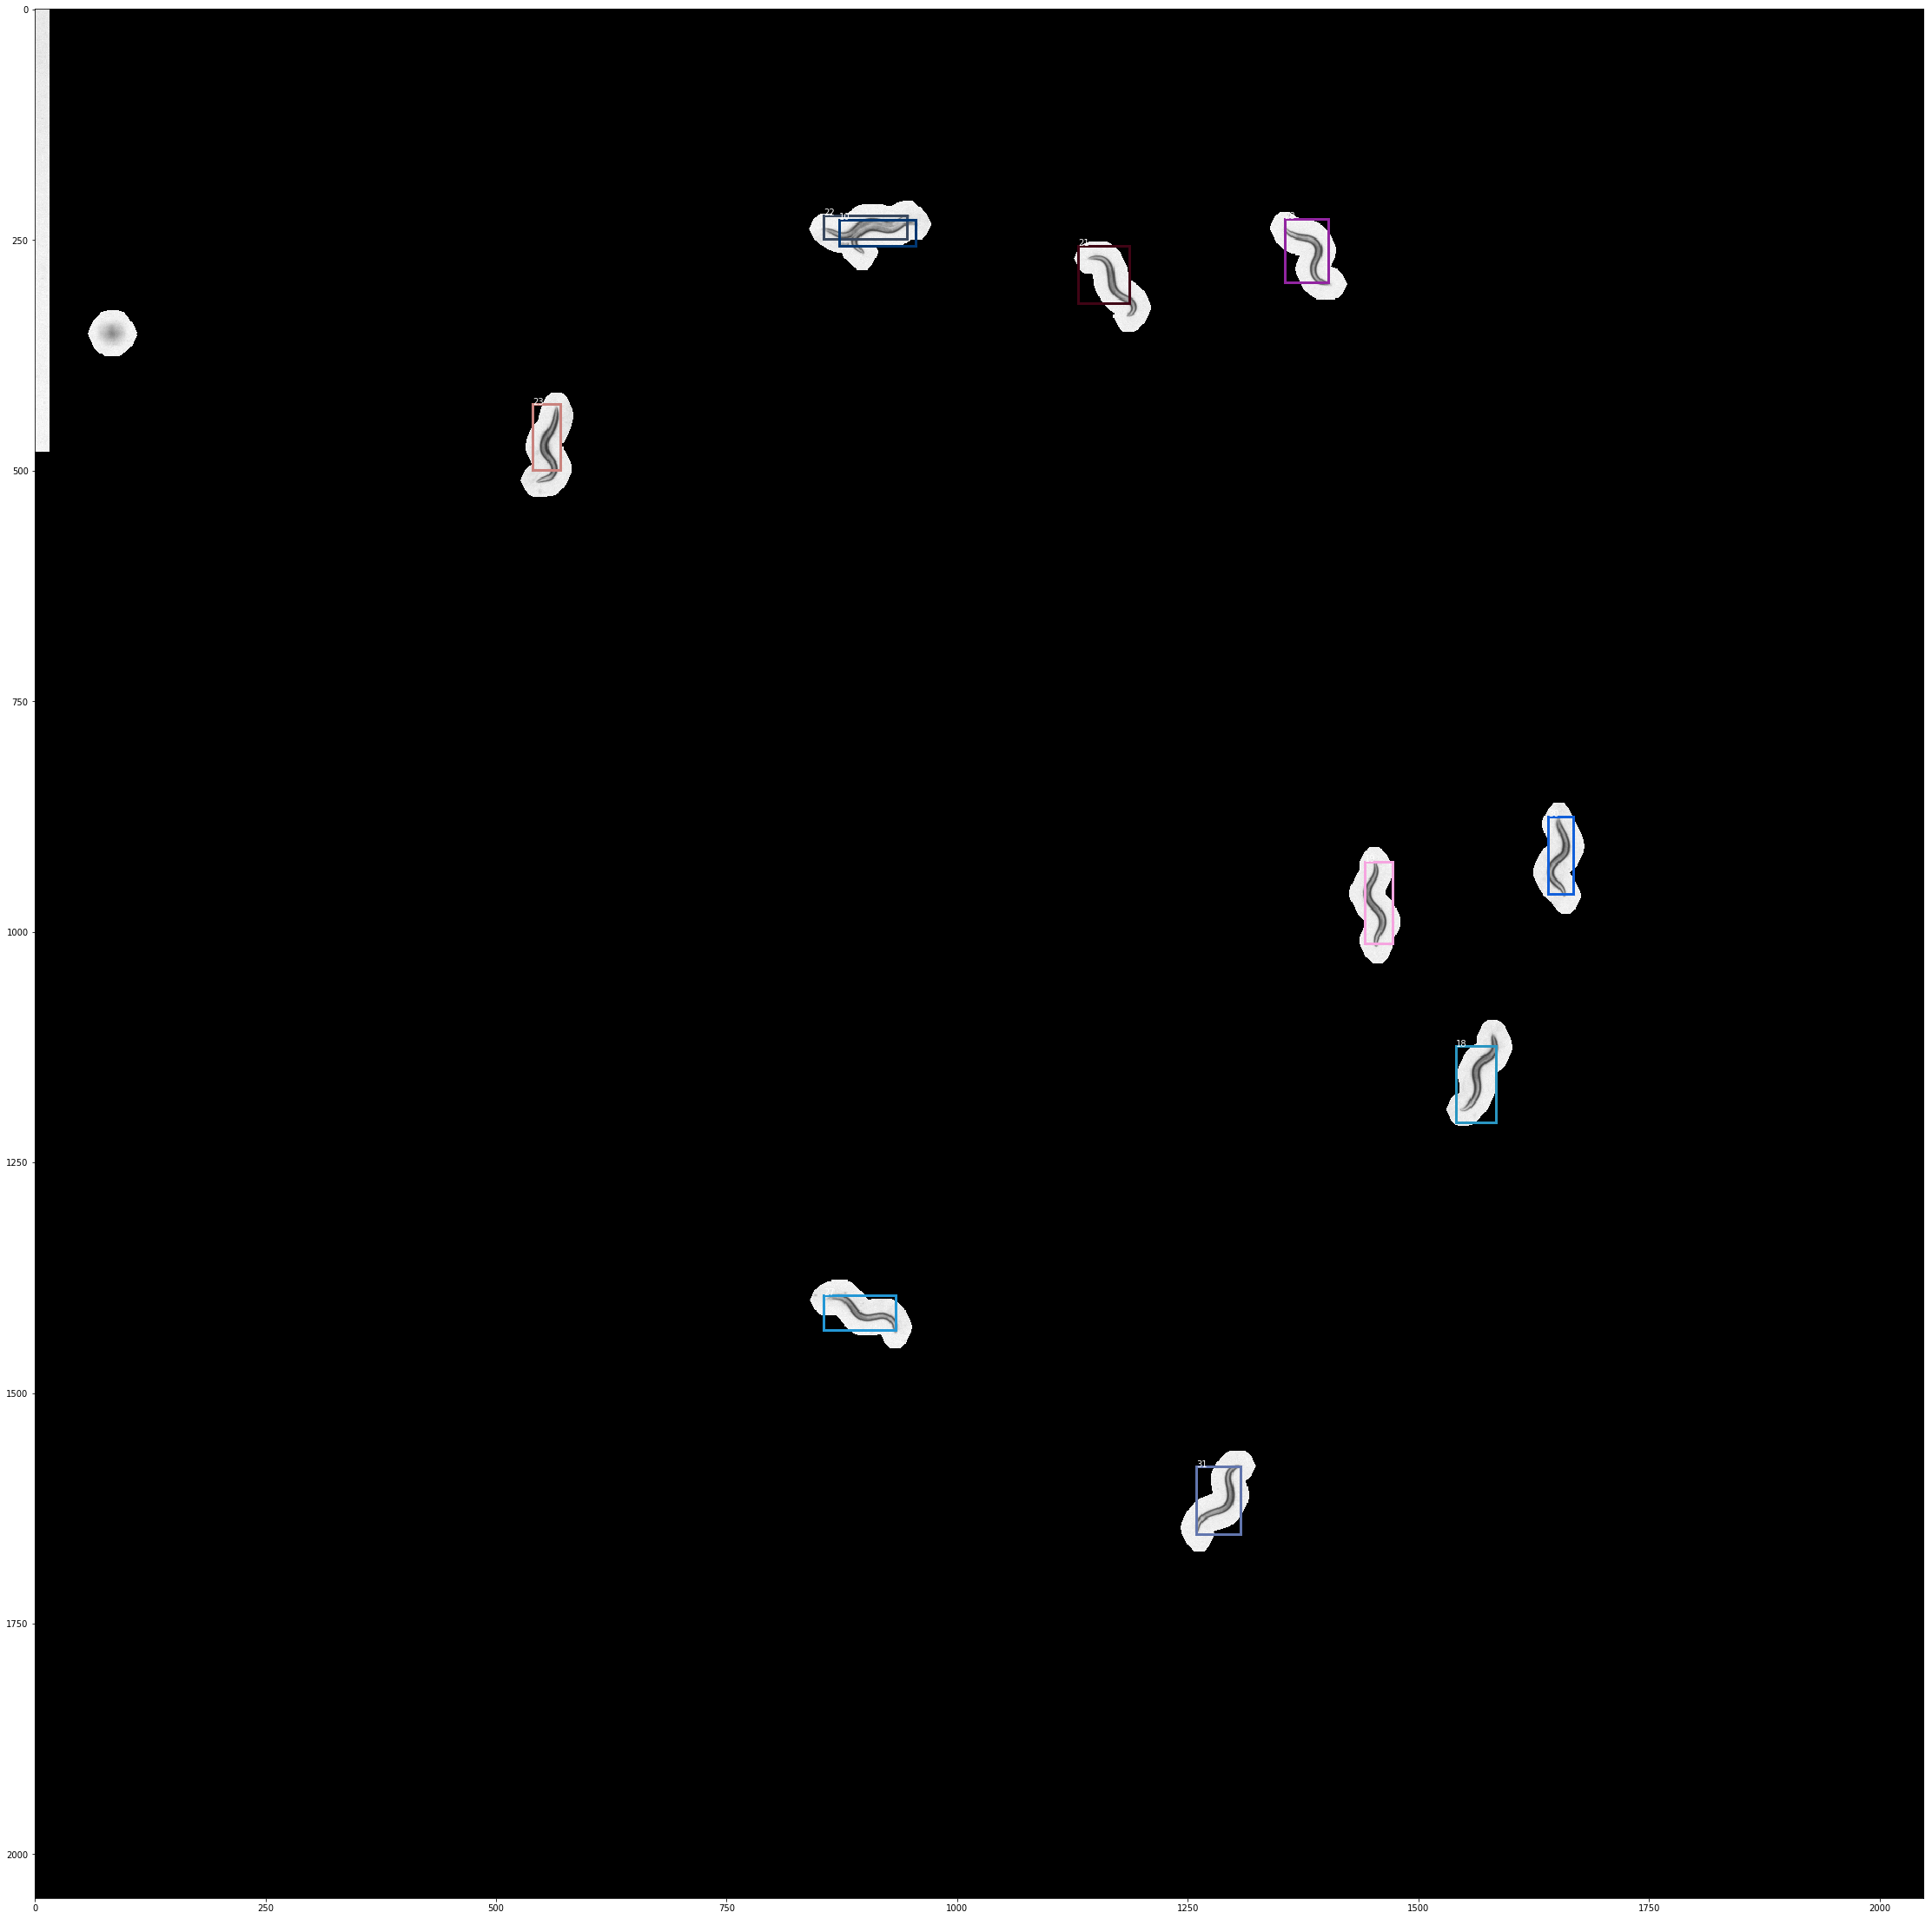

Worm IDs: [10.0, 18.0, 19.0, 21.0, 22.0, 23.0, 27.0, 28.0, 30.0, 32.0]


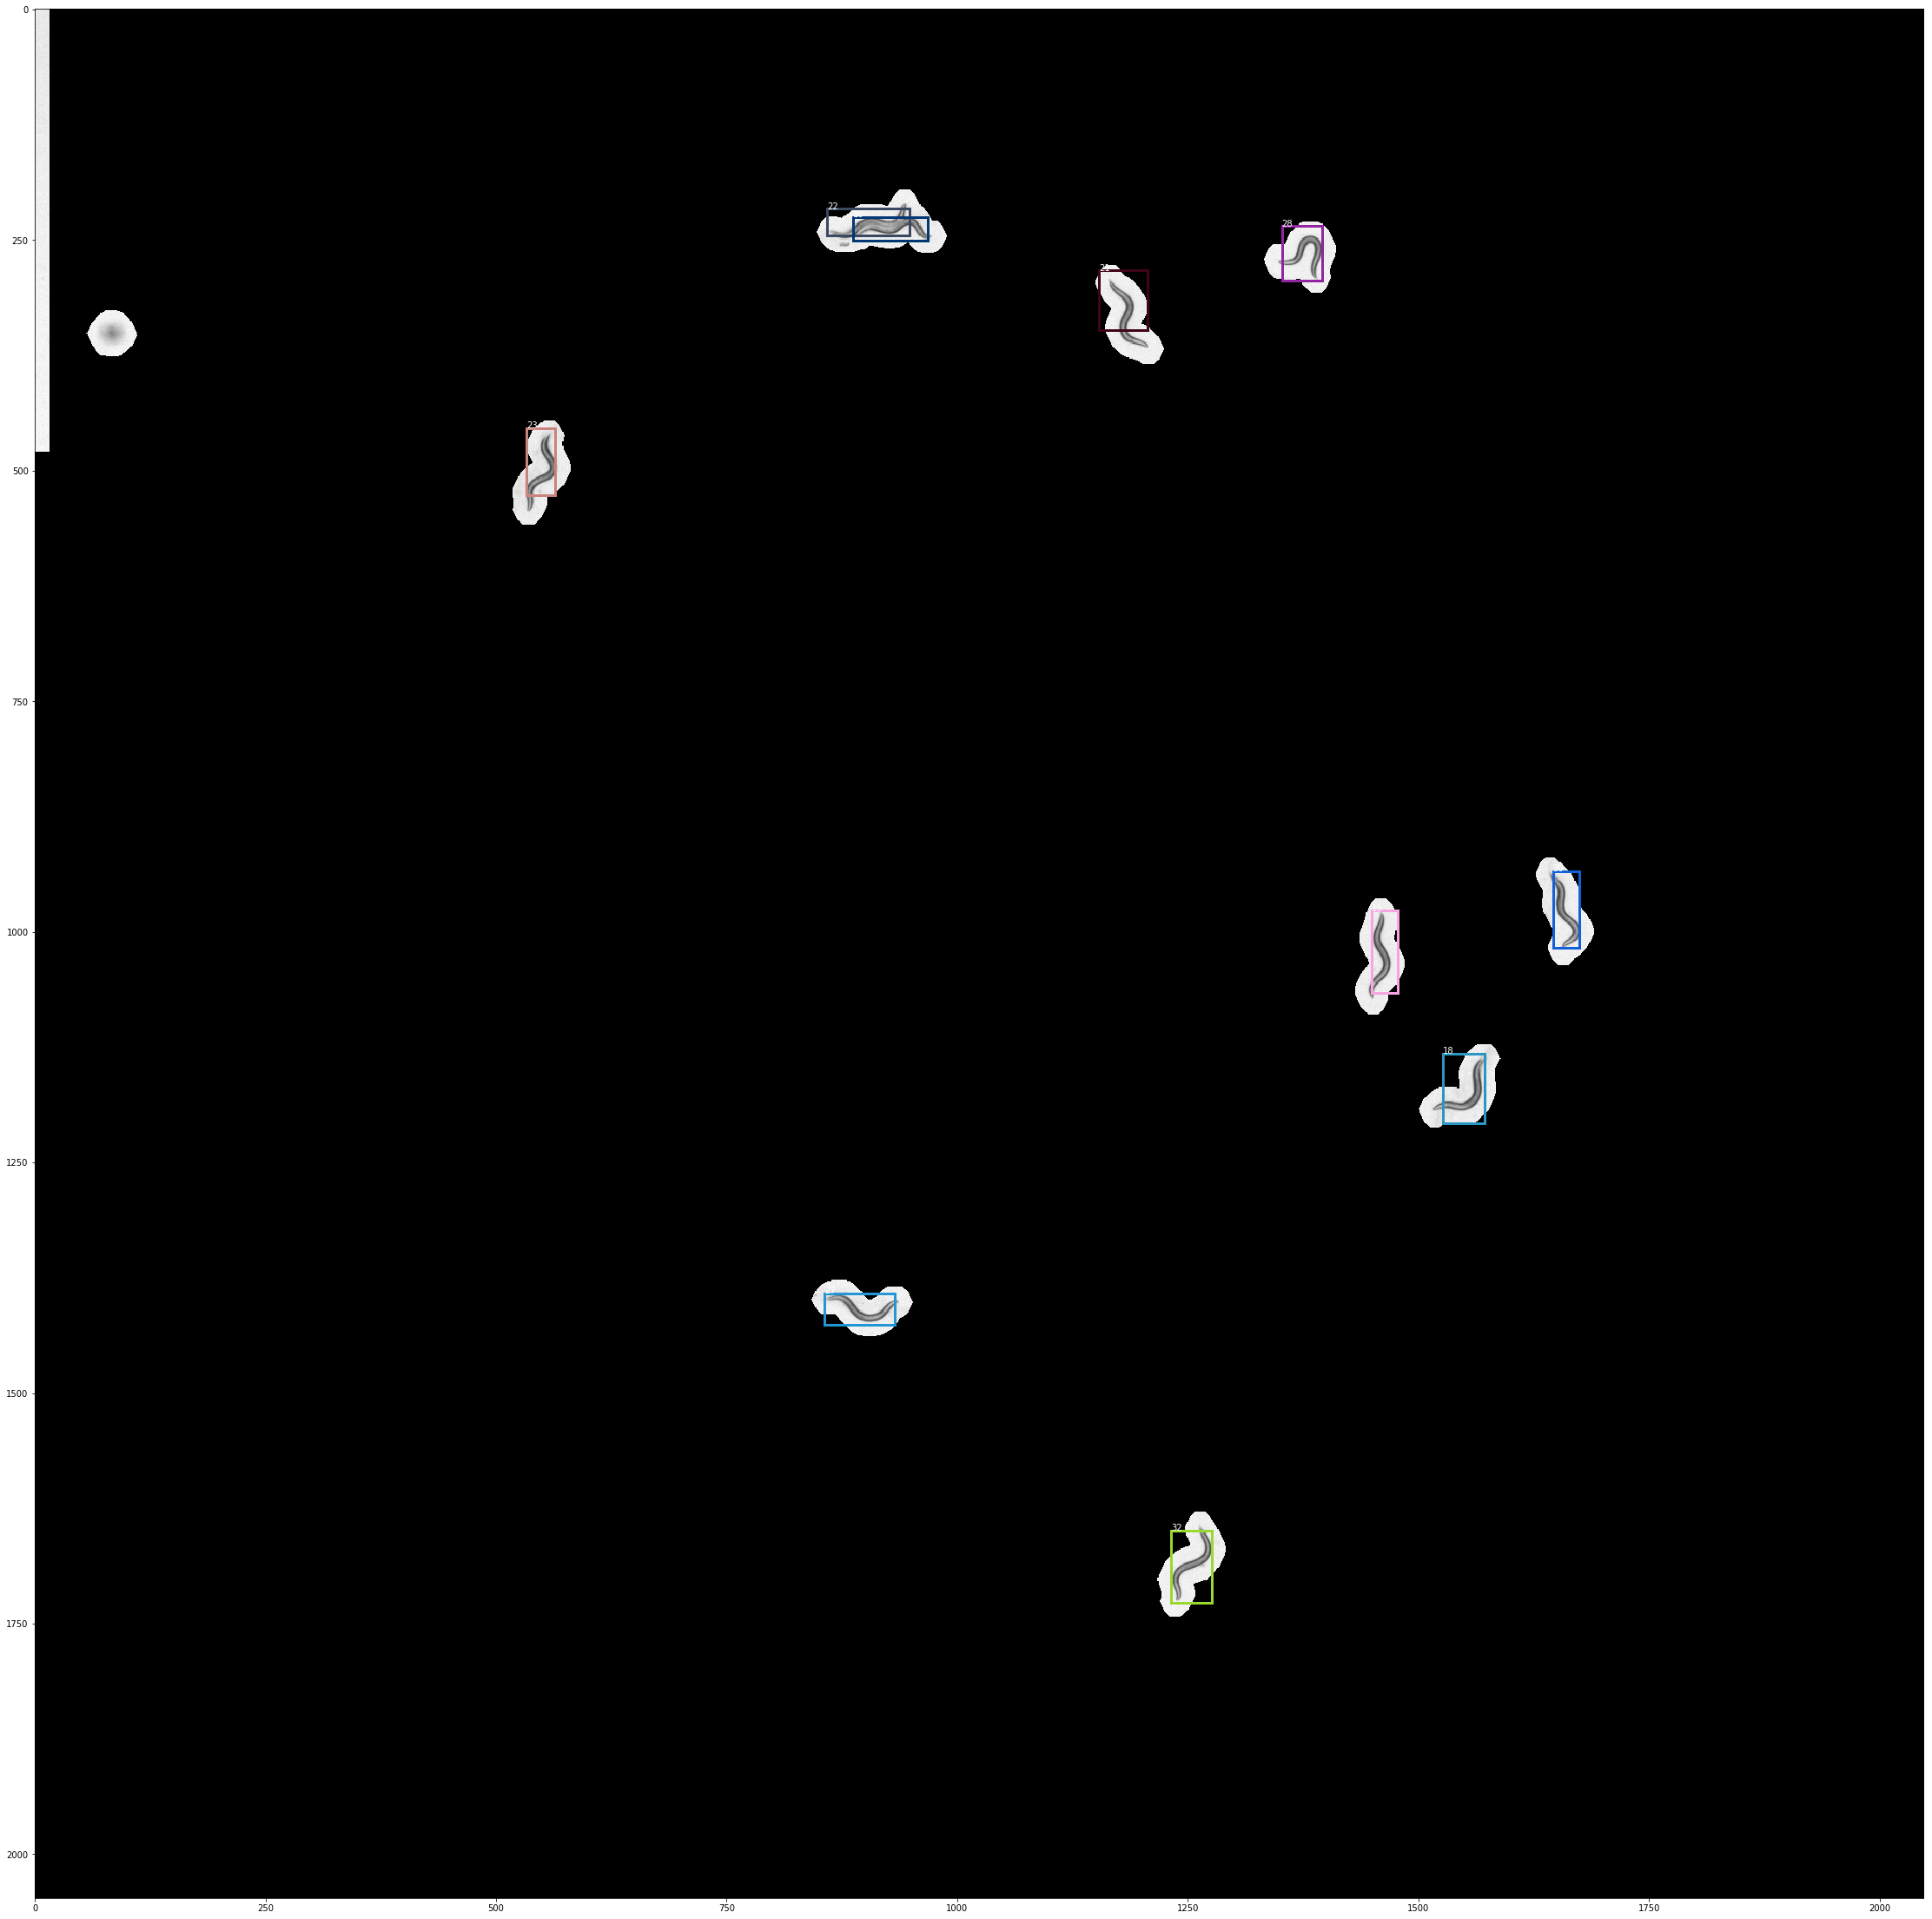

Worm IDs: [10.0, 18.0, 22.0, 23.0, 27.0, 28.0, 30.0, 33.0, 34.0, 35.0]


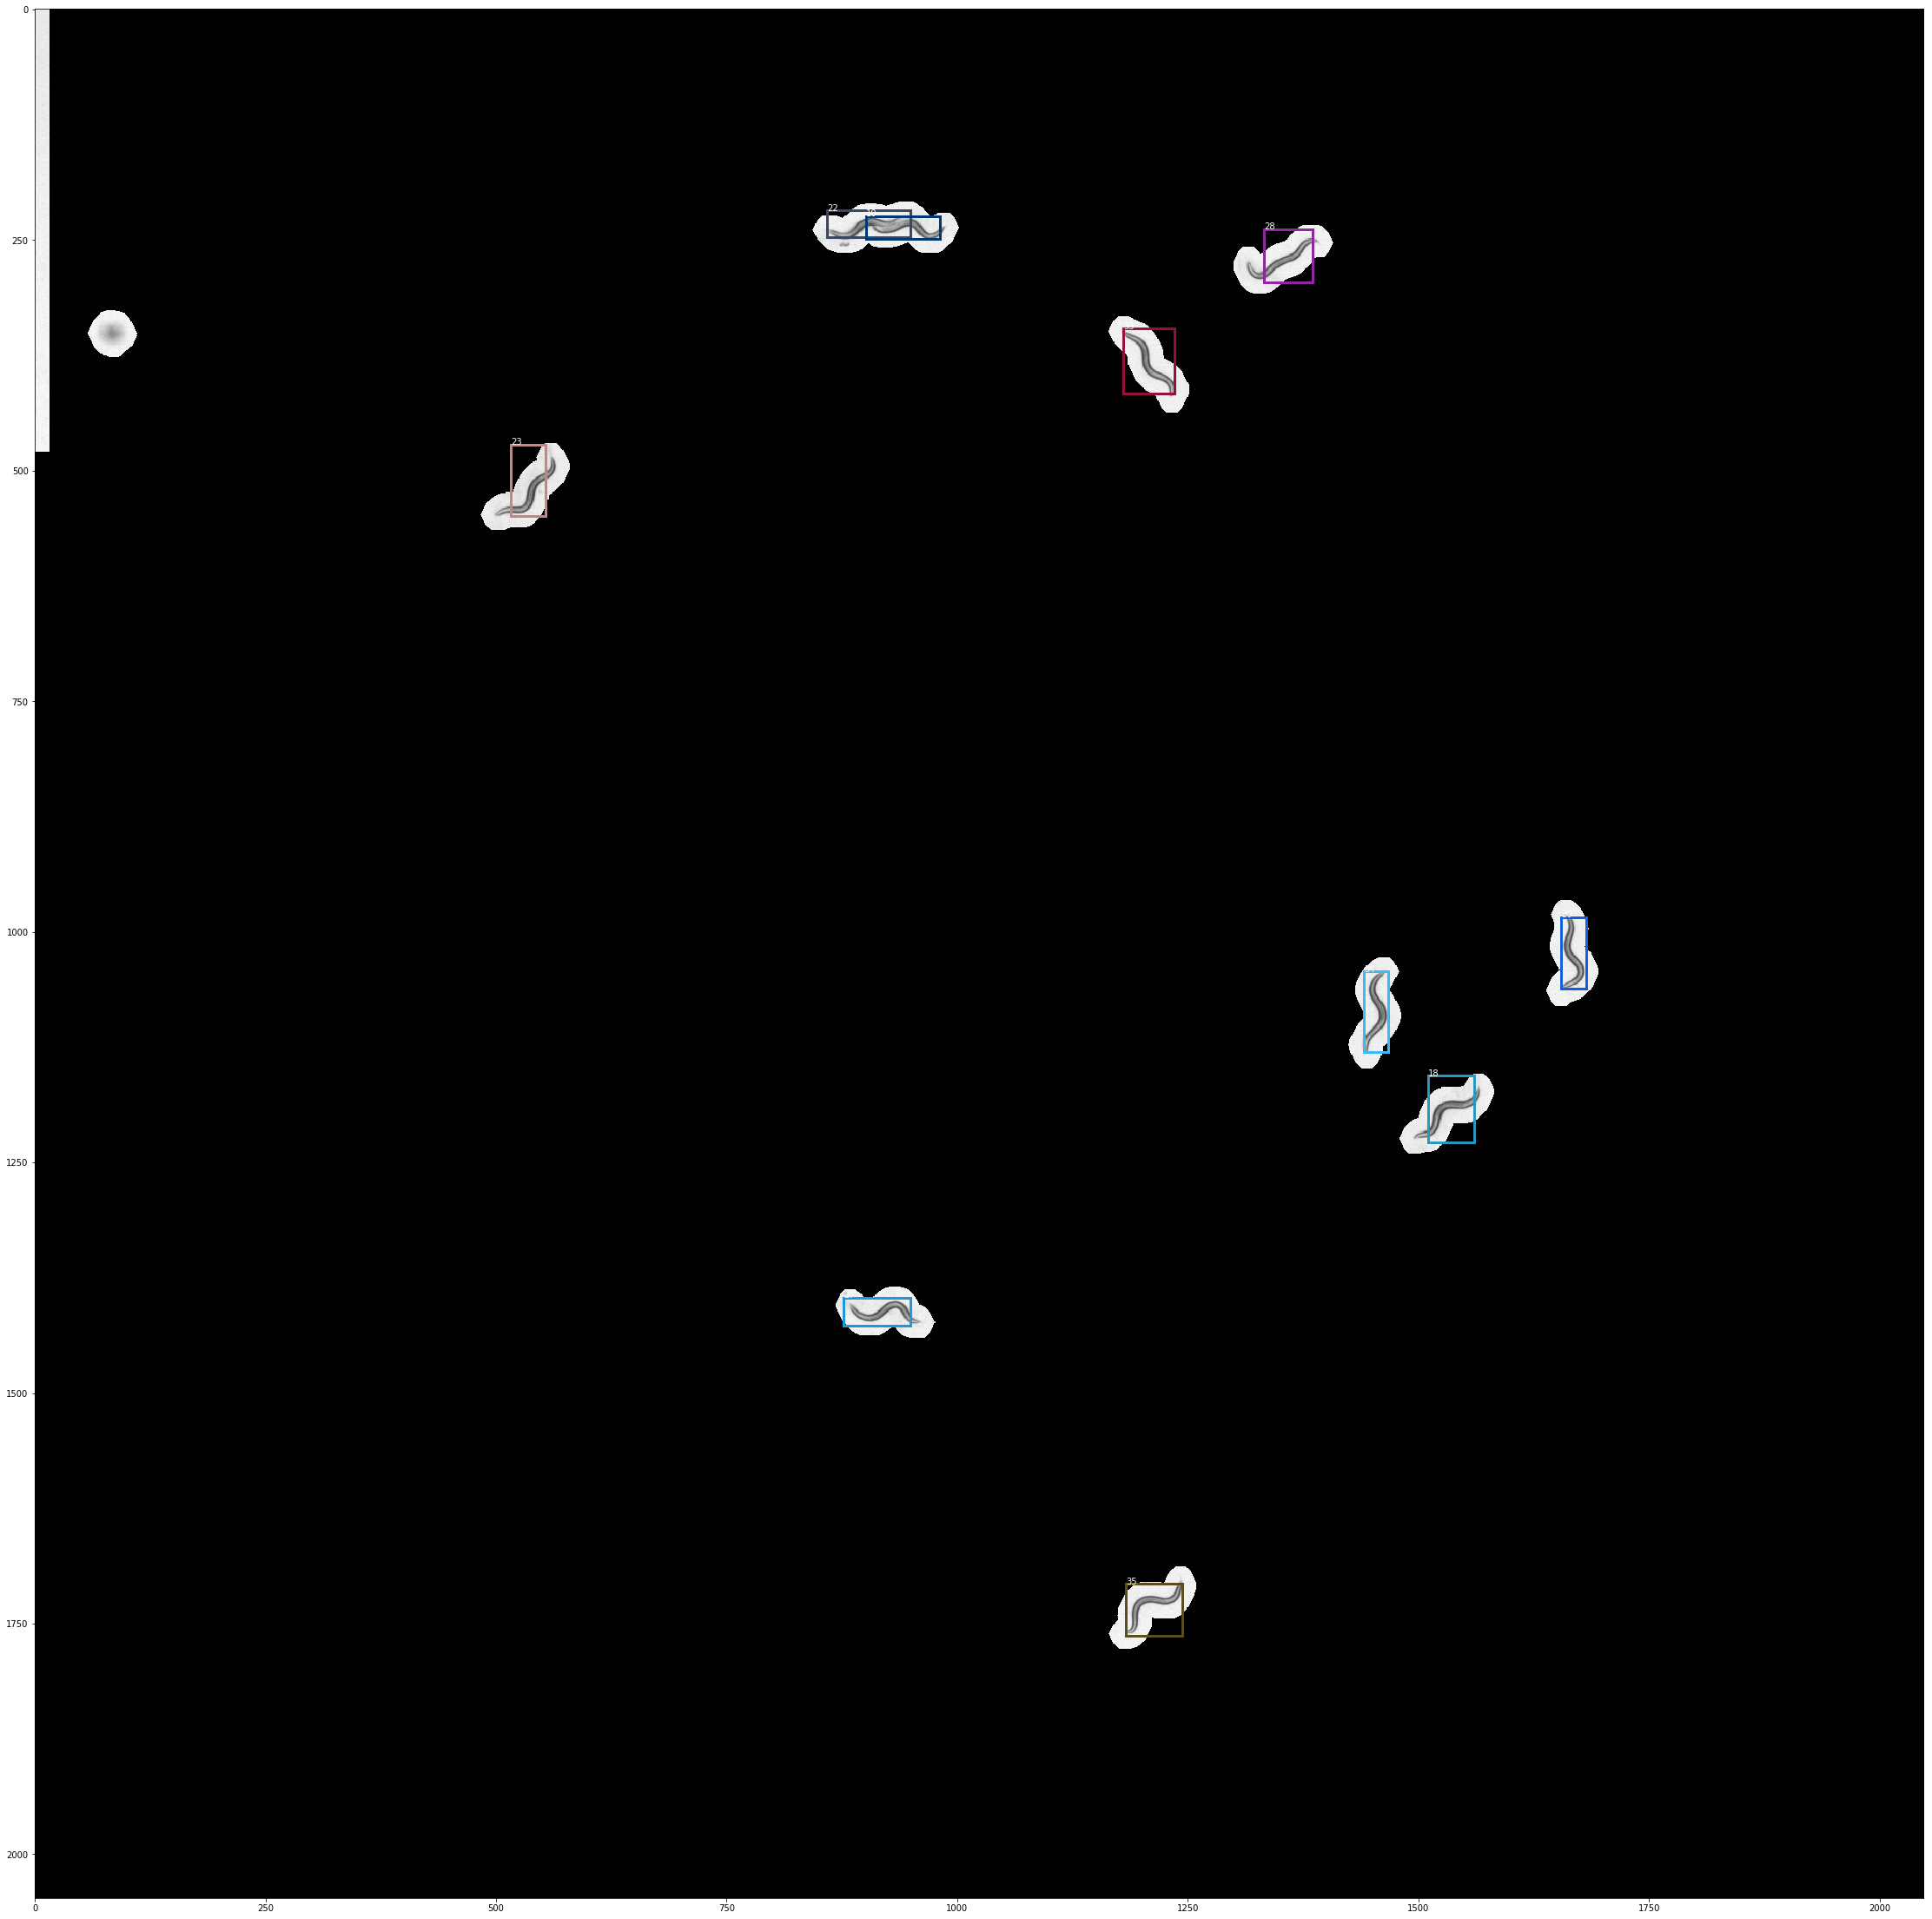

Worm IDs: [10.0, 18.0, 22.0, 23.0, 27.0, 28.0, 30.0, 35.0, 36.0, 37.0]


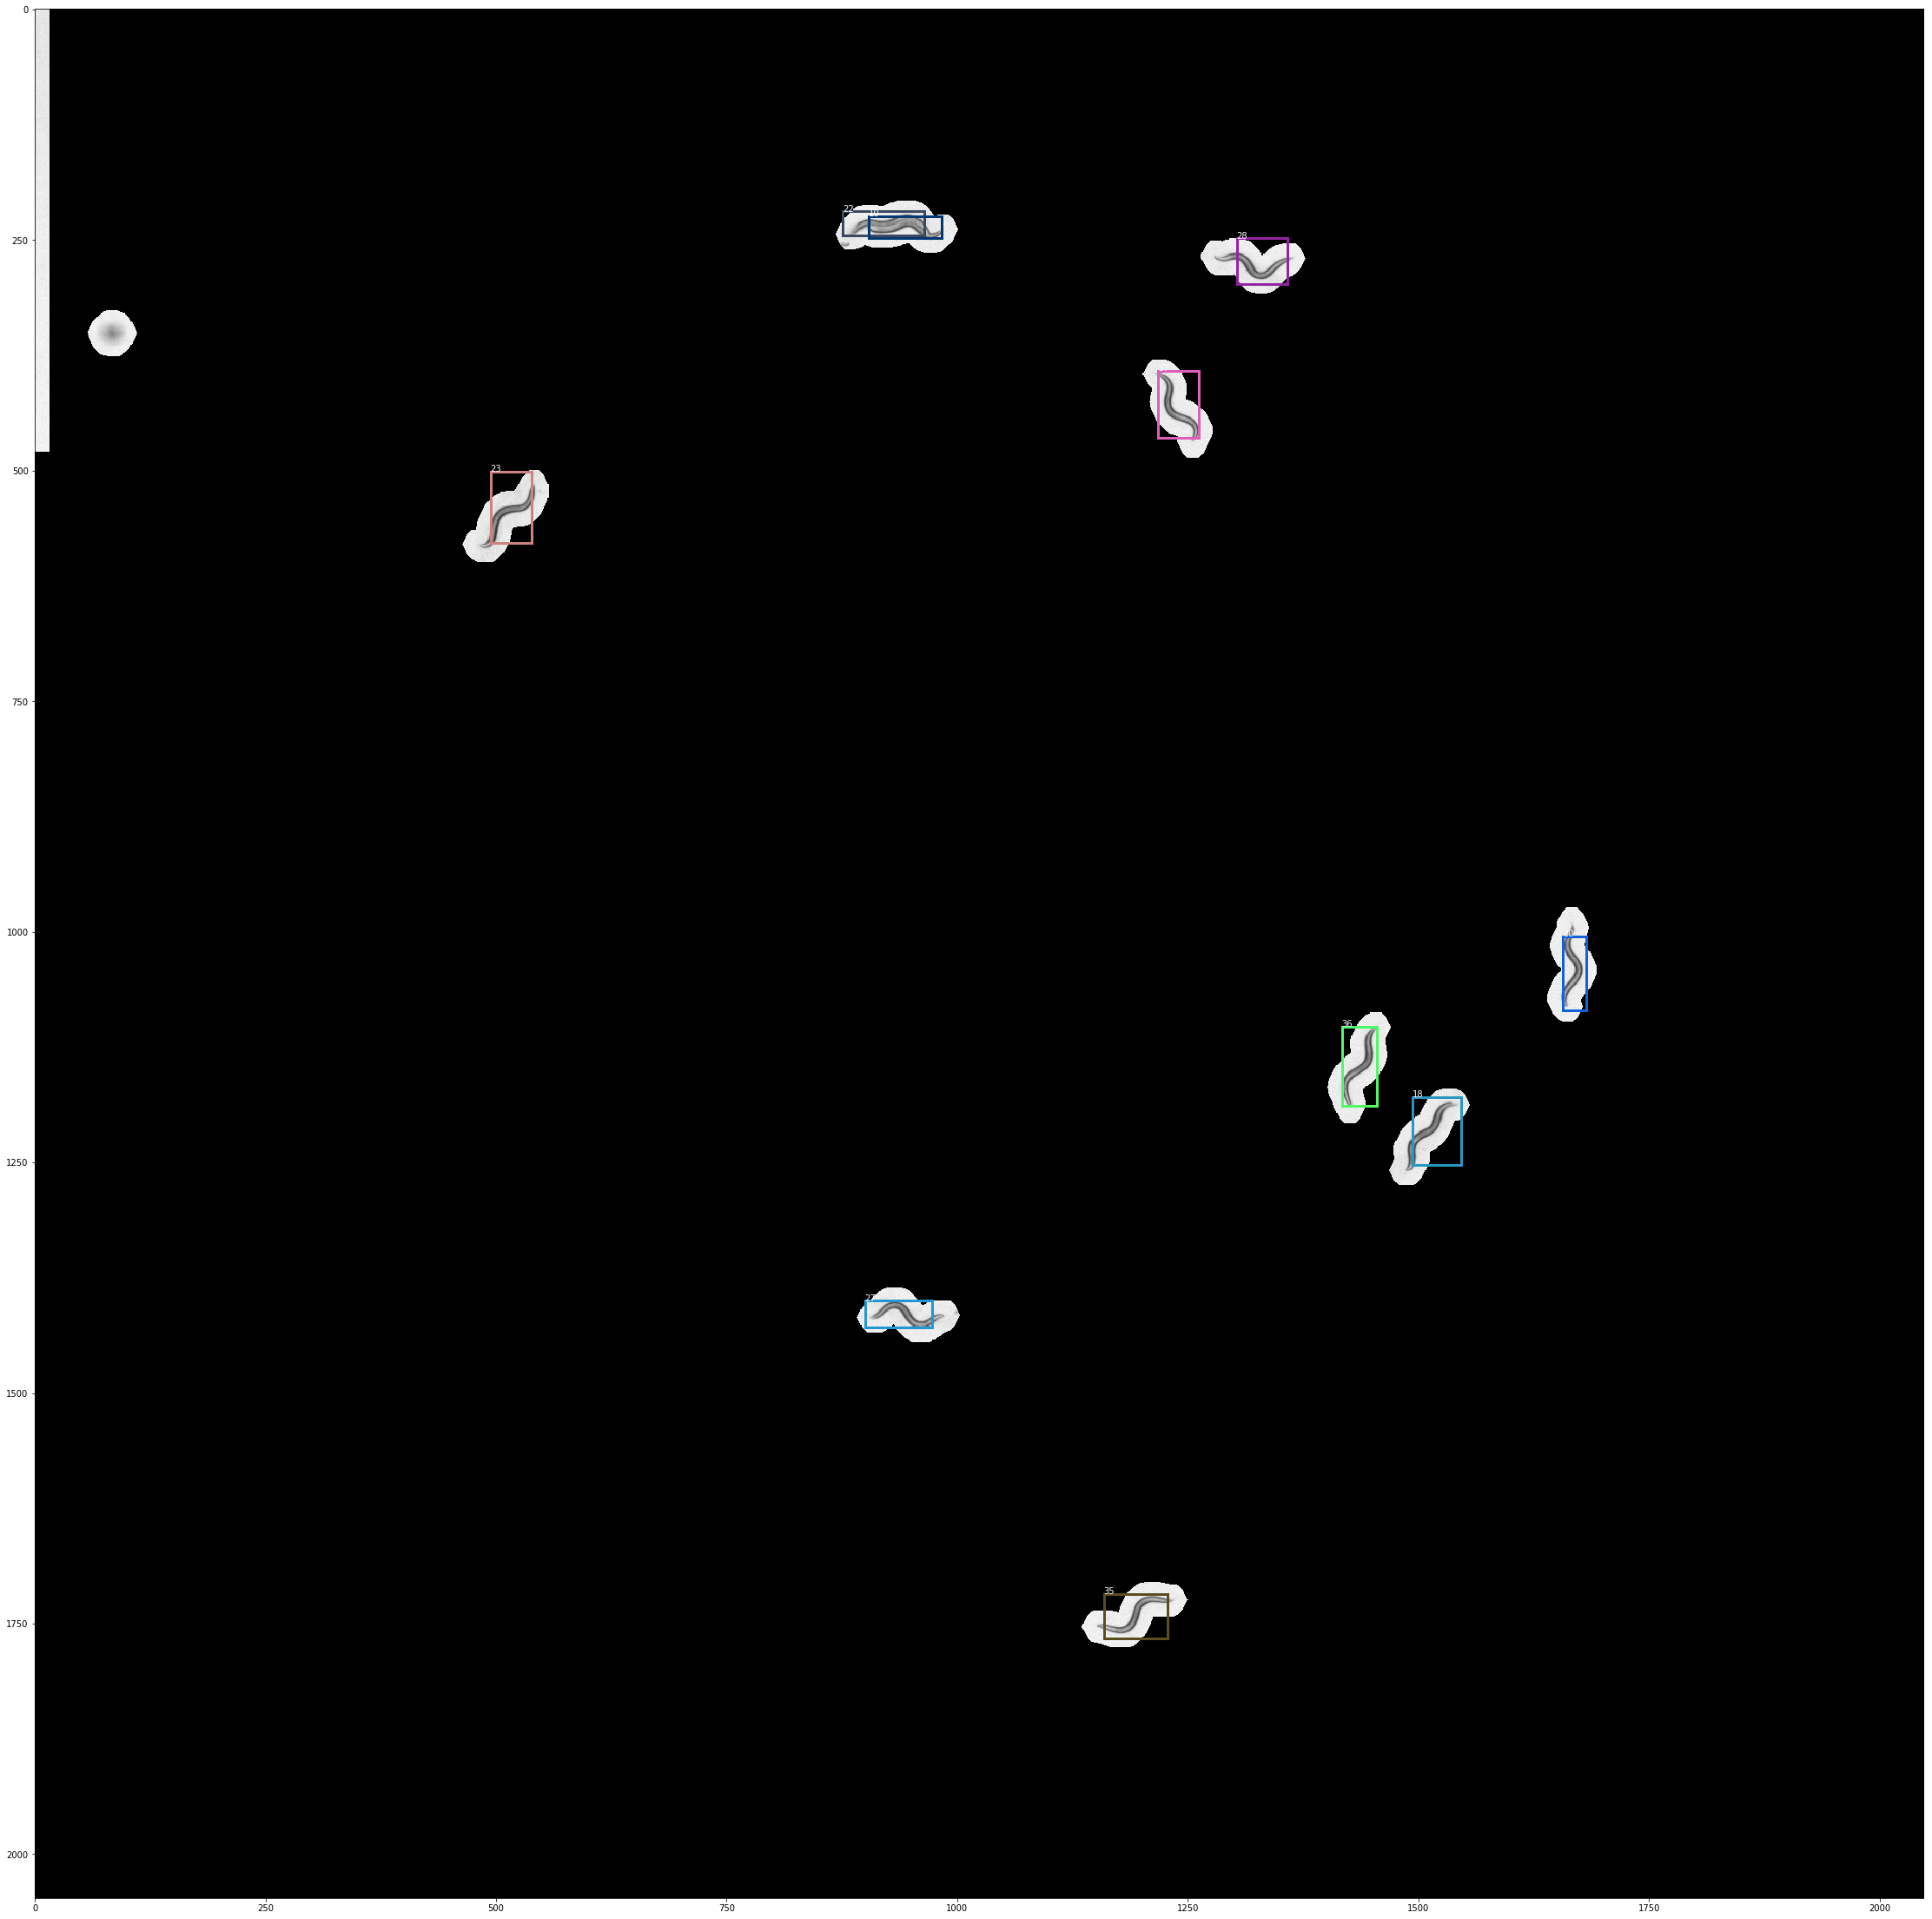

Worm IDs: [18.0, 22.0, 23.0, 27.0, 28.0, 30.0, 35.0, 36.0, 38.0]


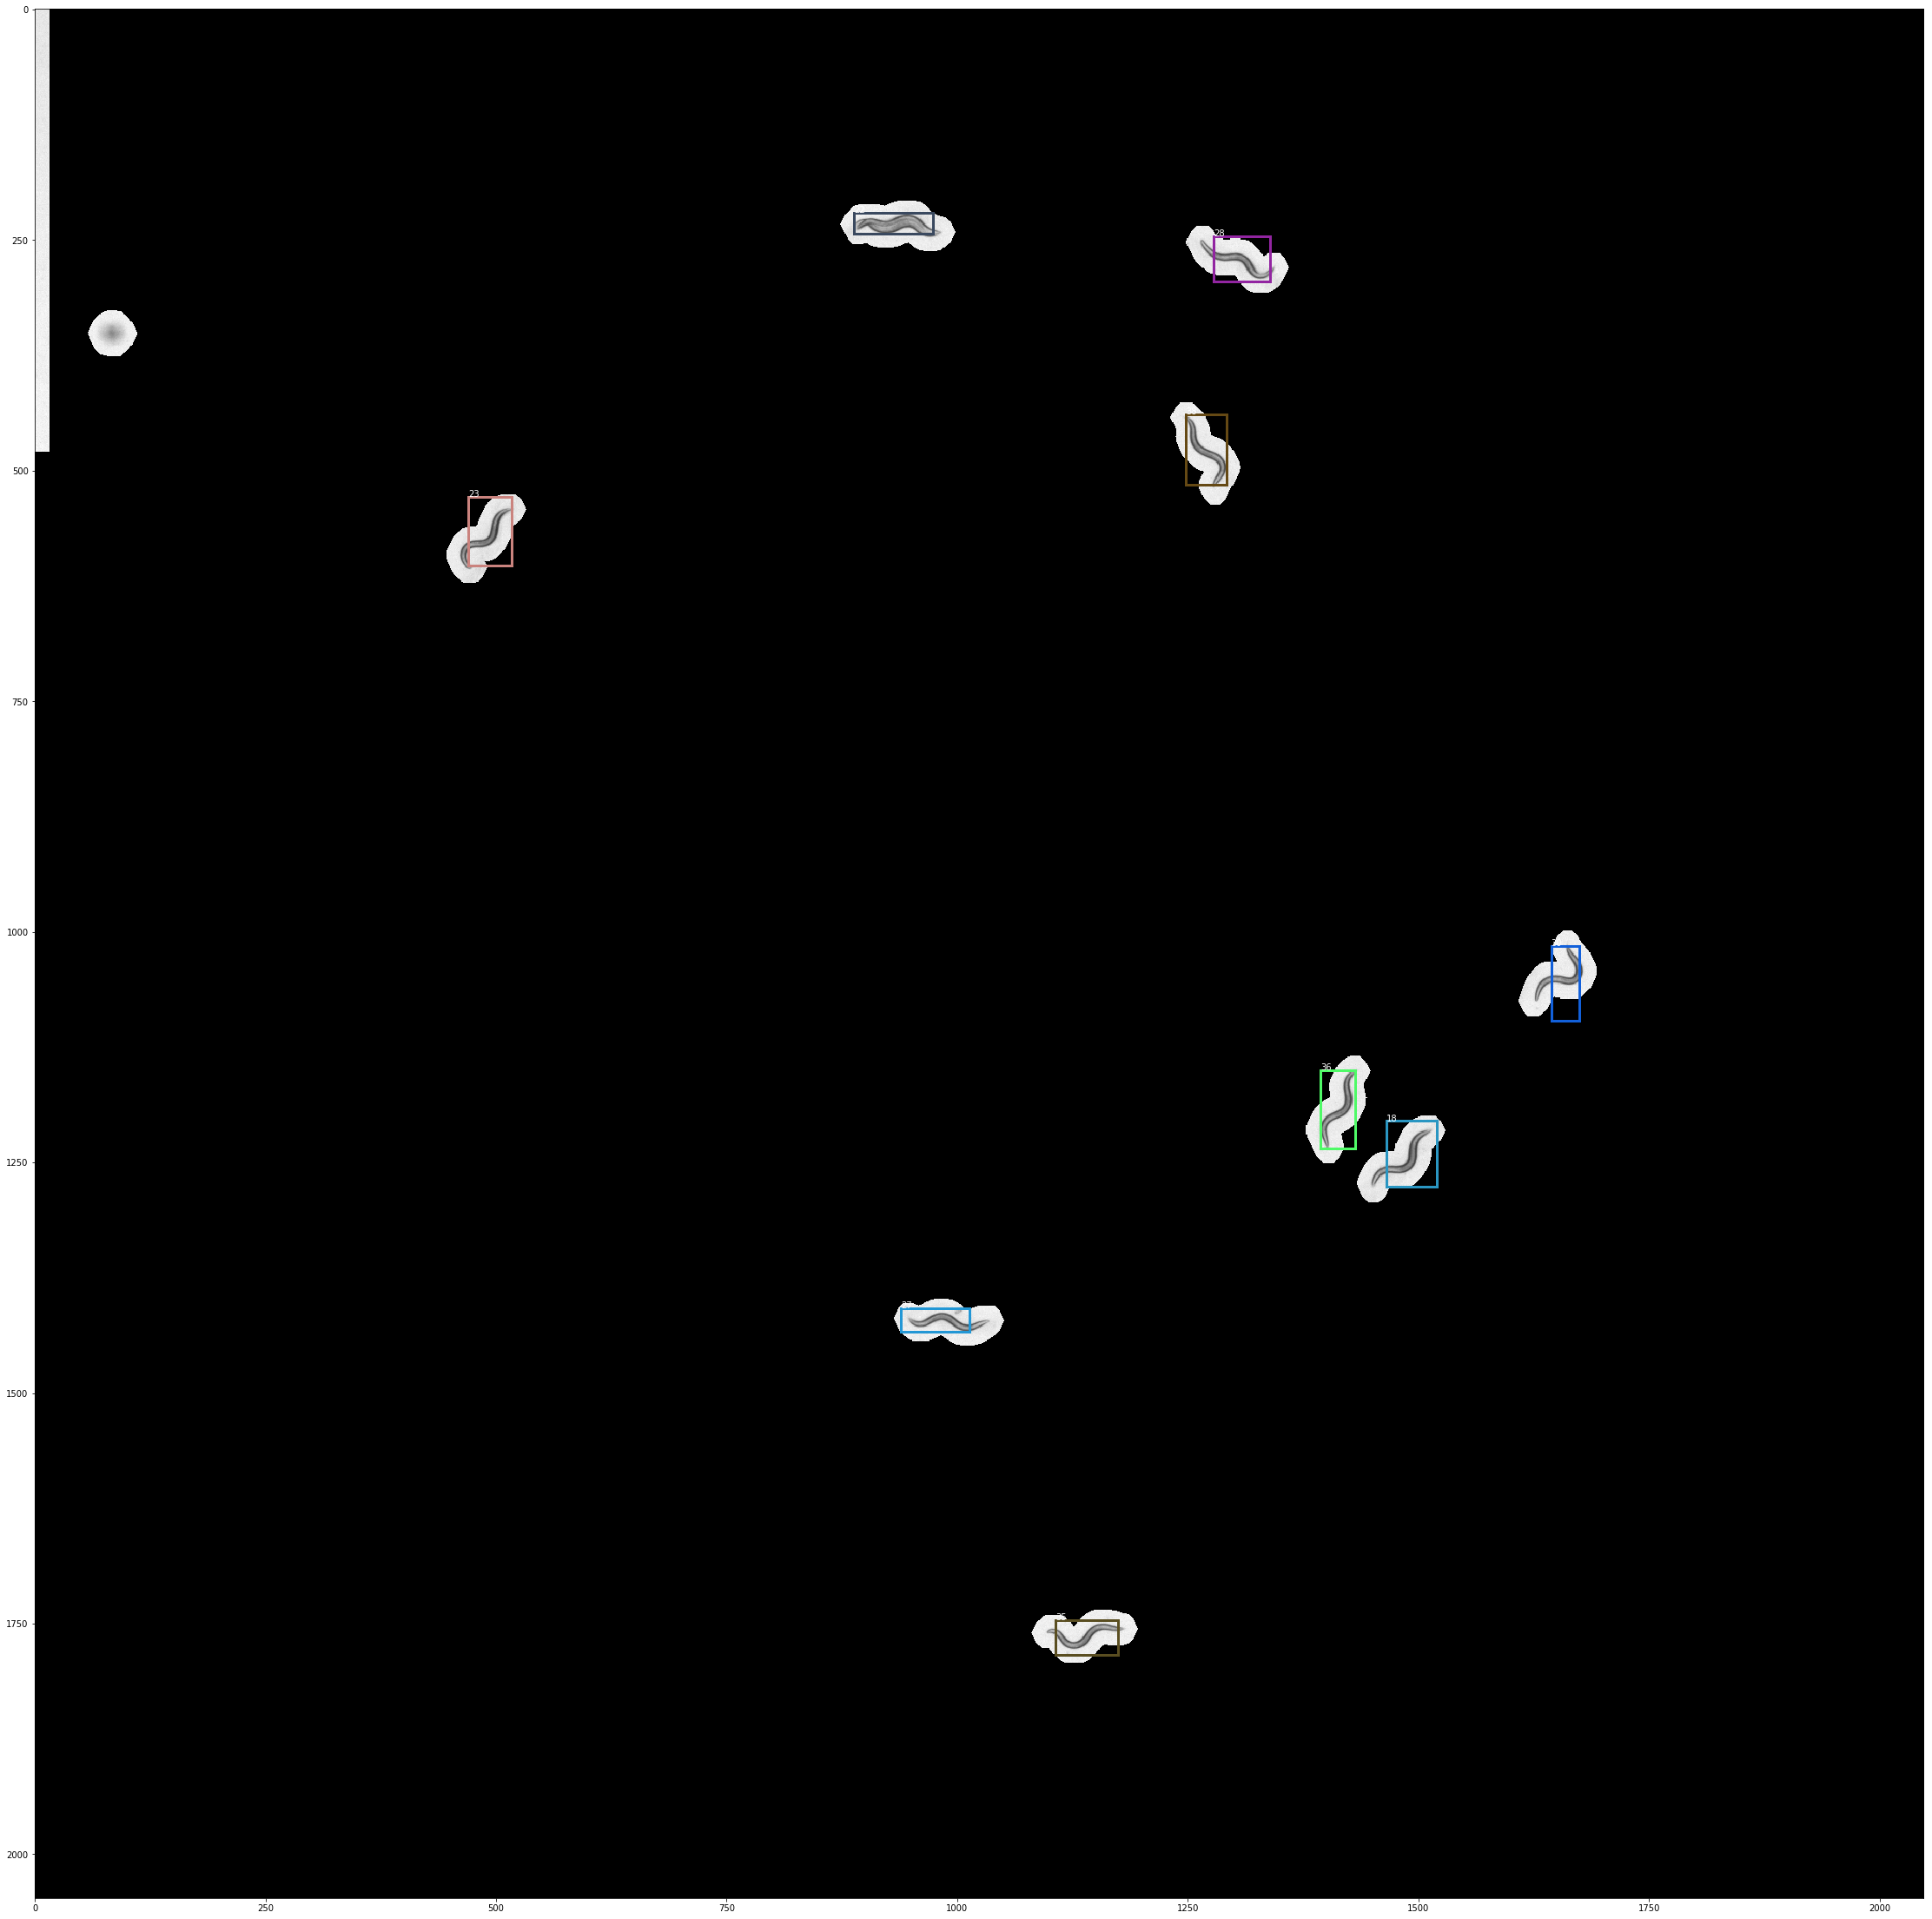

Worm IDs: [10.0, 18.0, 22.0, 23.0, 27.0, 28.0, 30.0, 35.0, 36.0, 39.0]


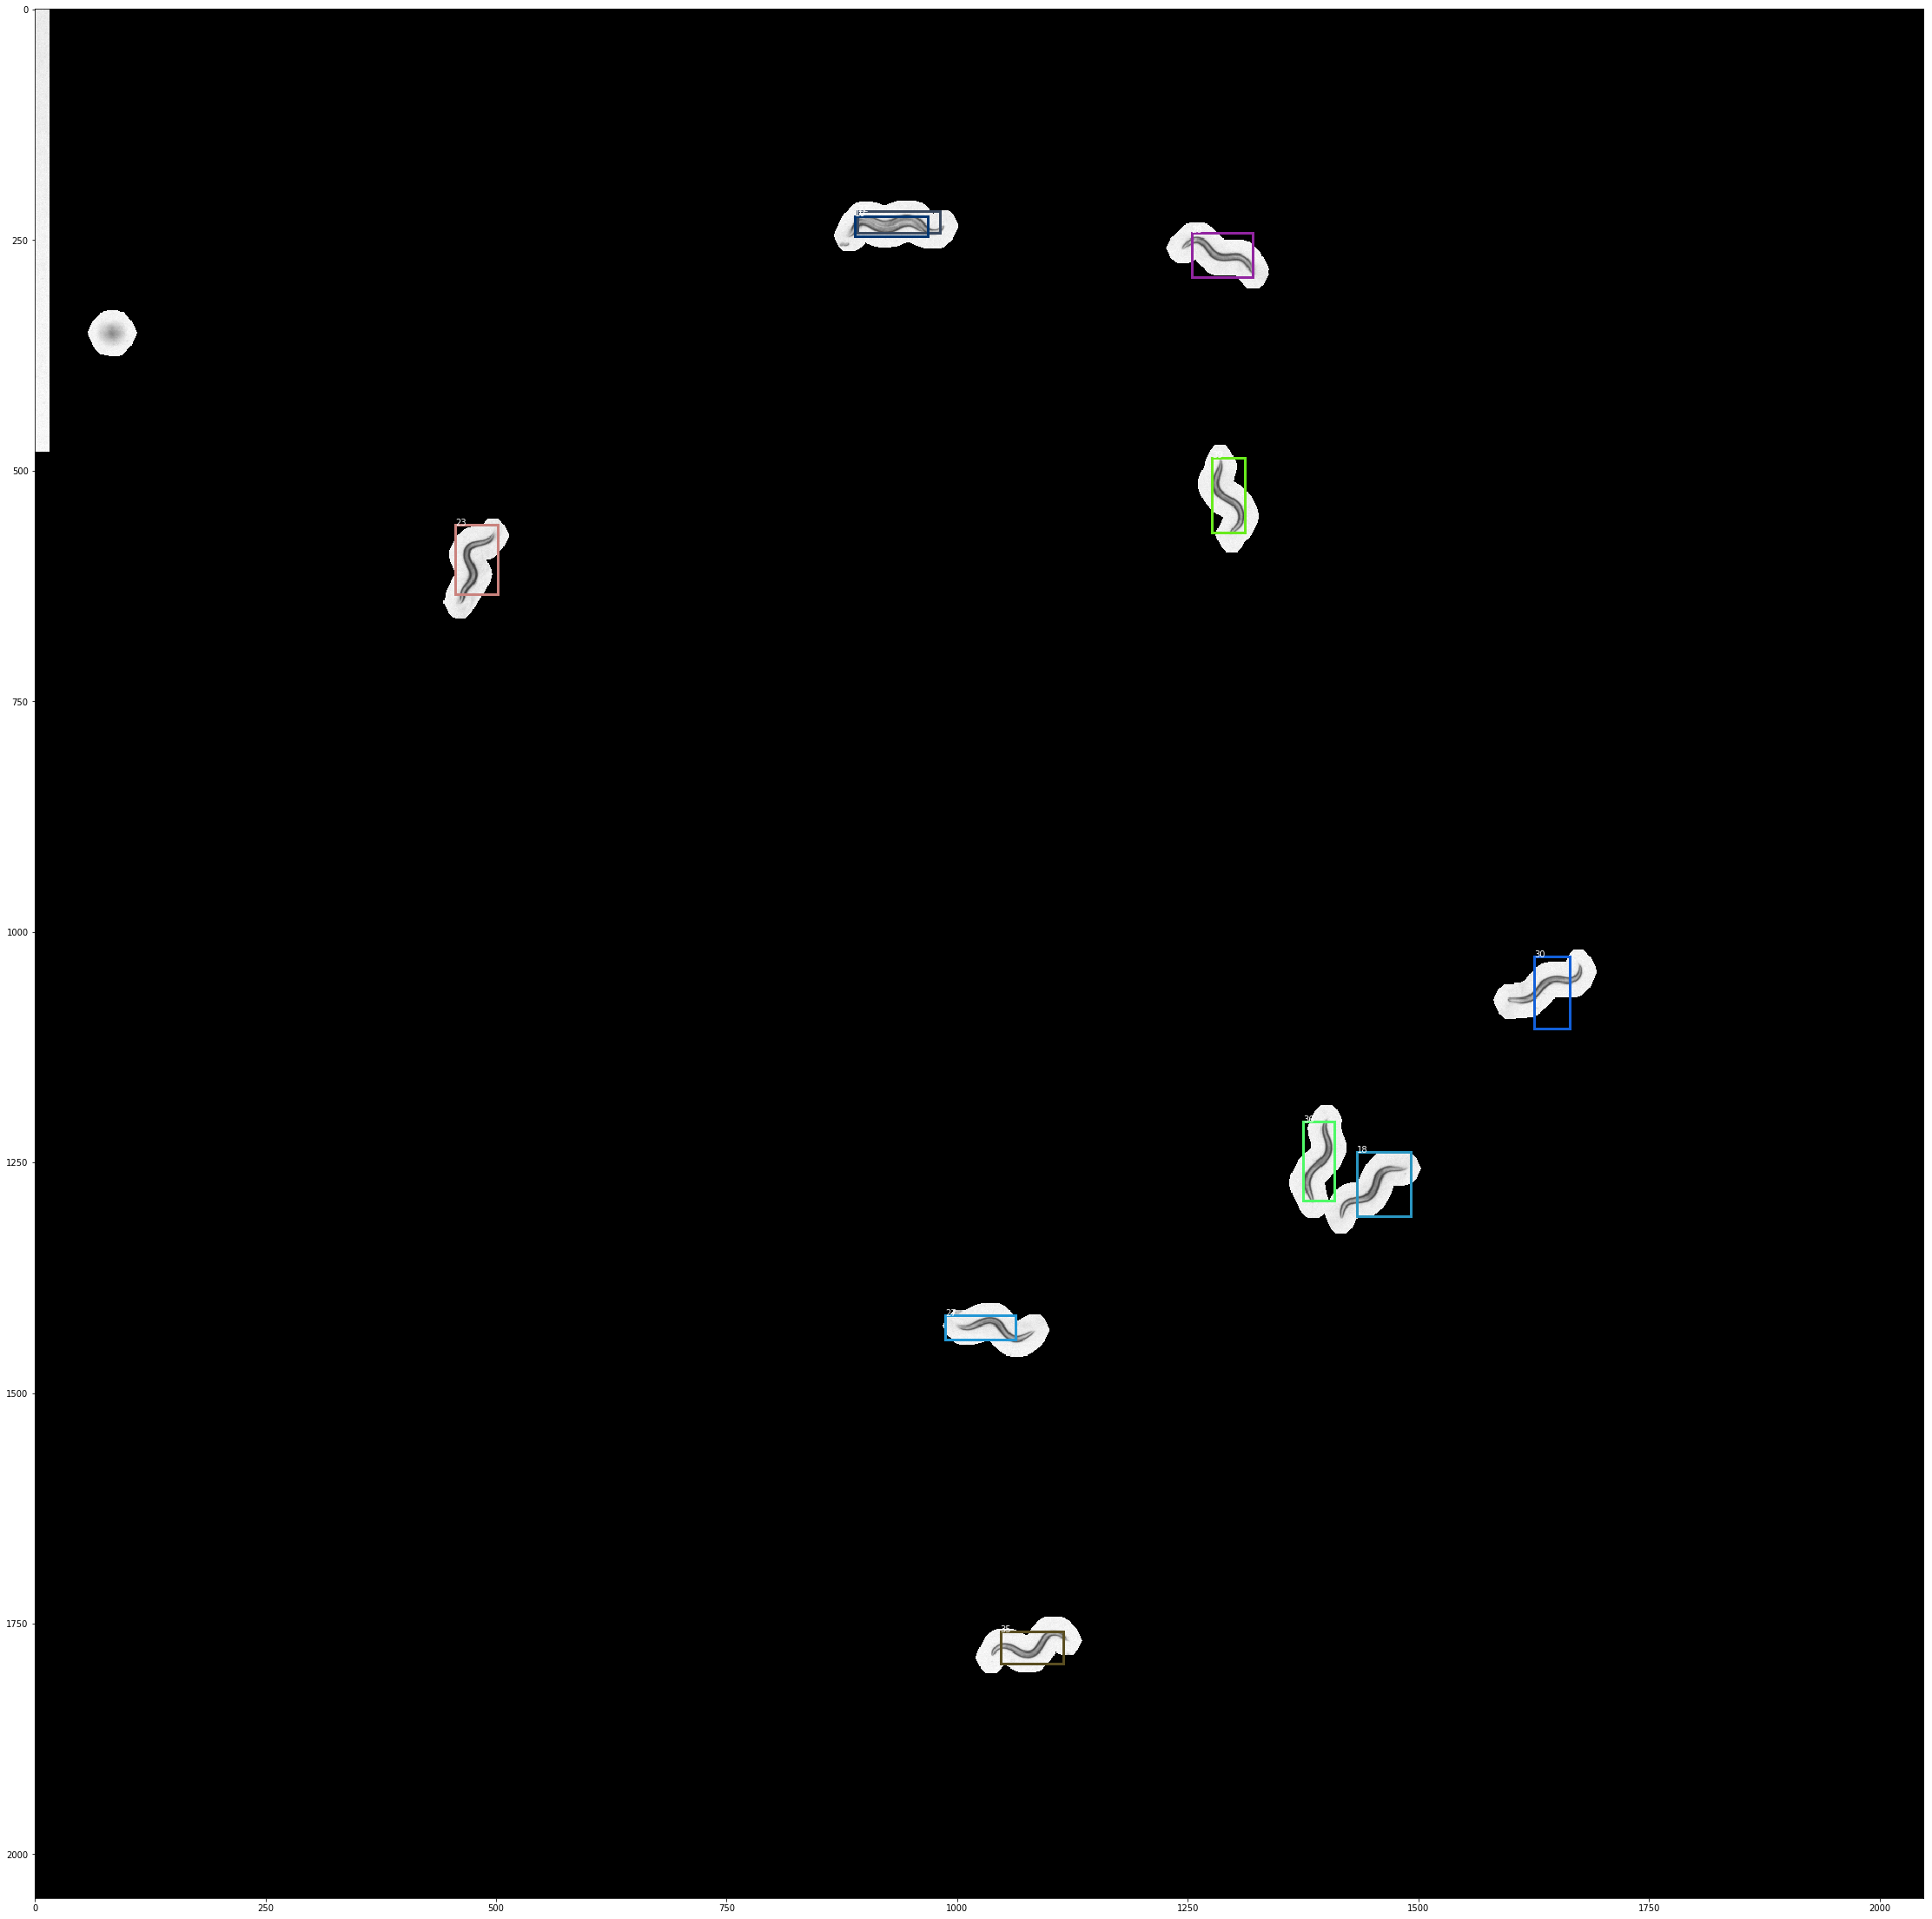

Worm IDs: [10.0, 18.0, 22.0, 23.0, 27.0, 28.0, 30.0, 35.0, 36.0, 40.0]


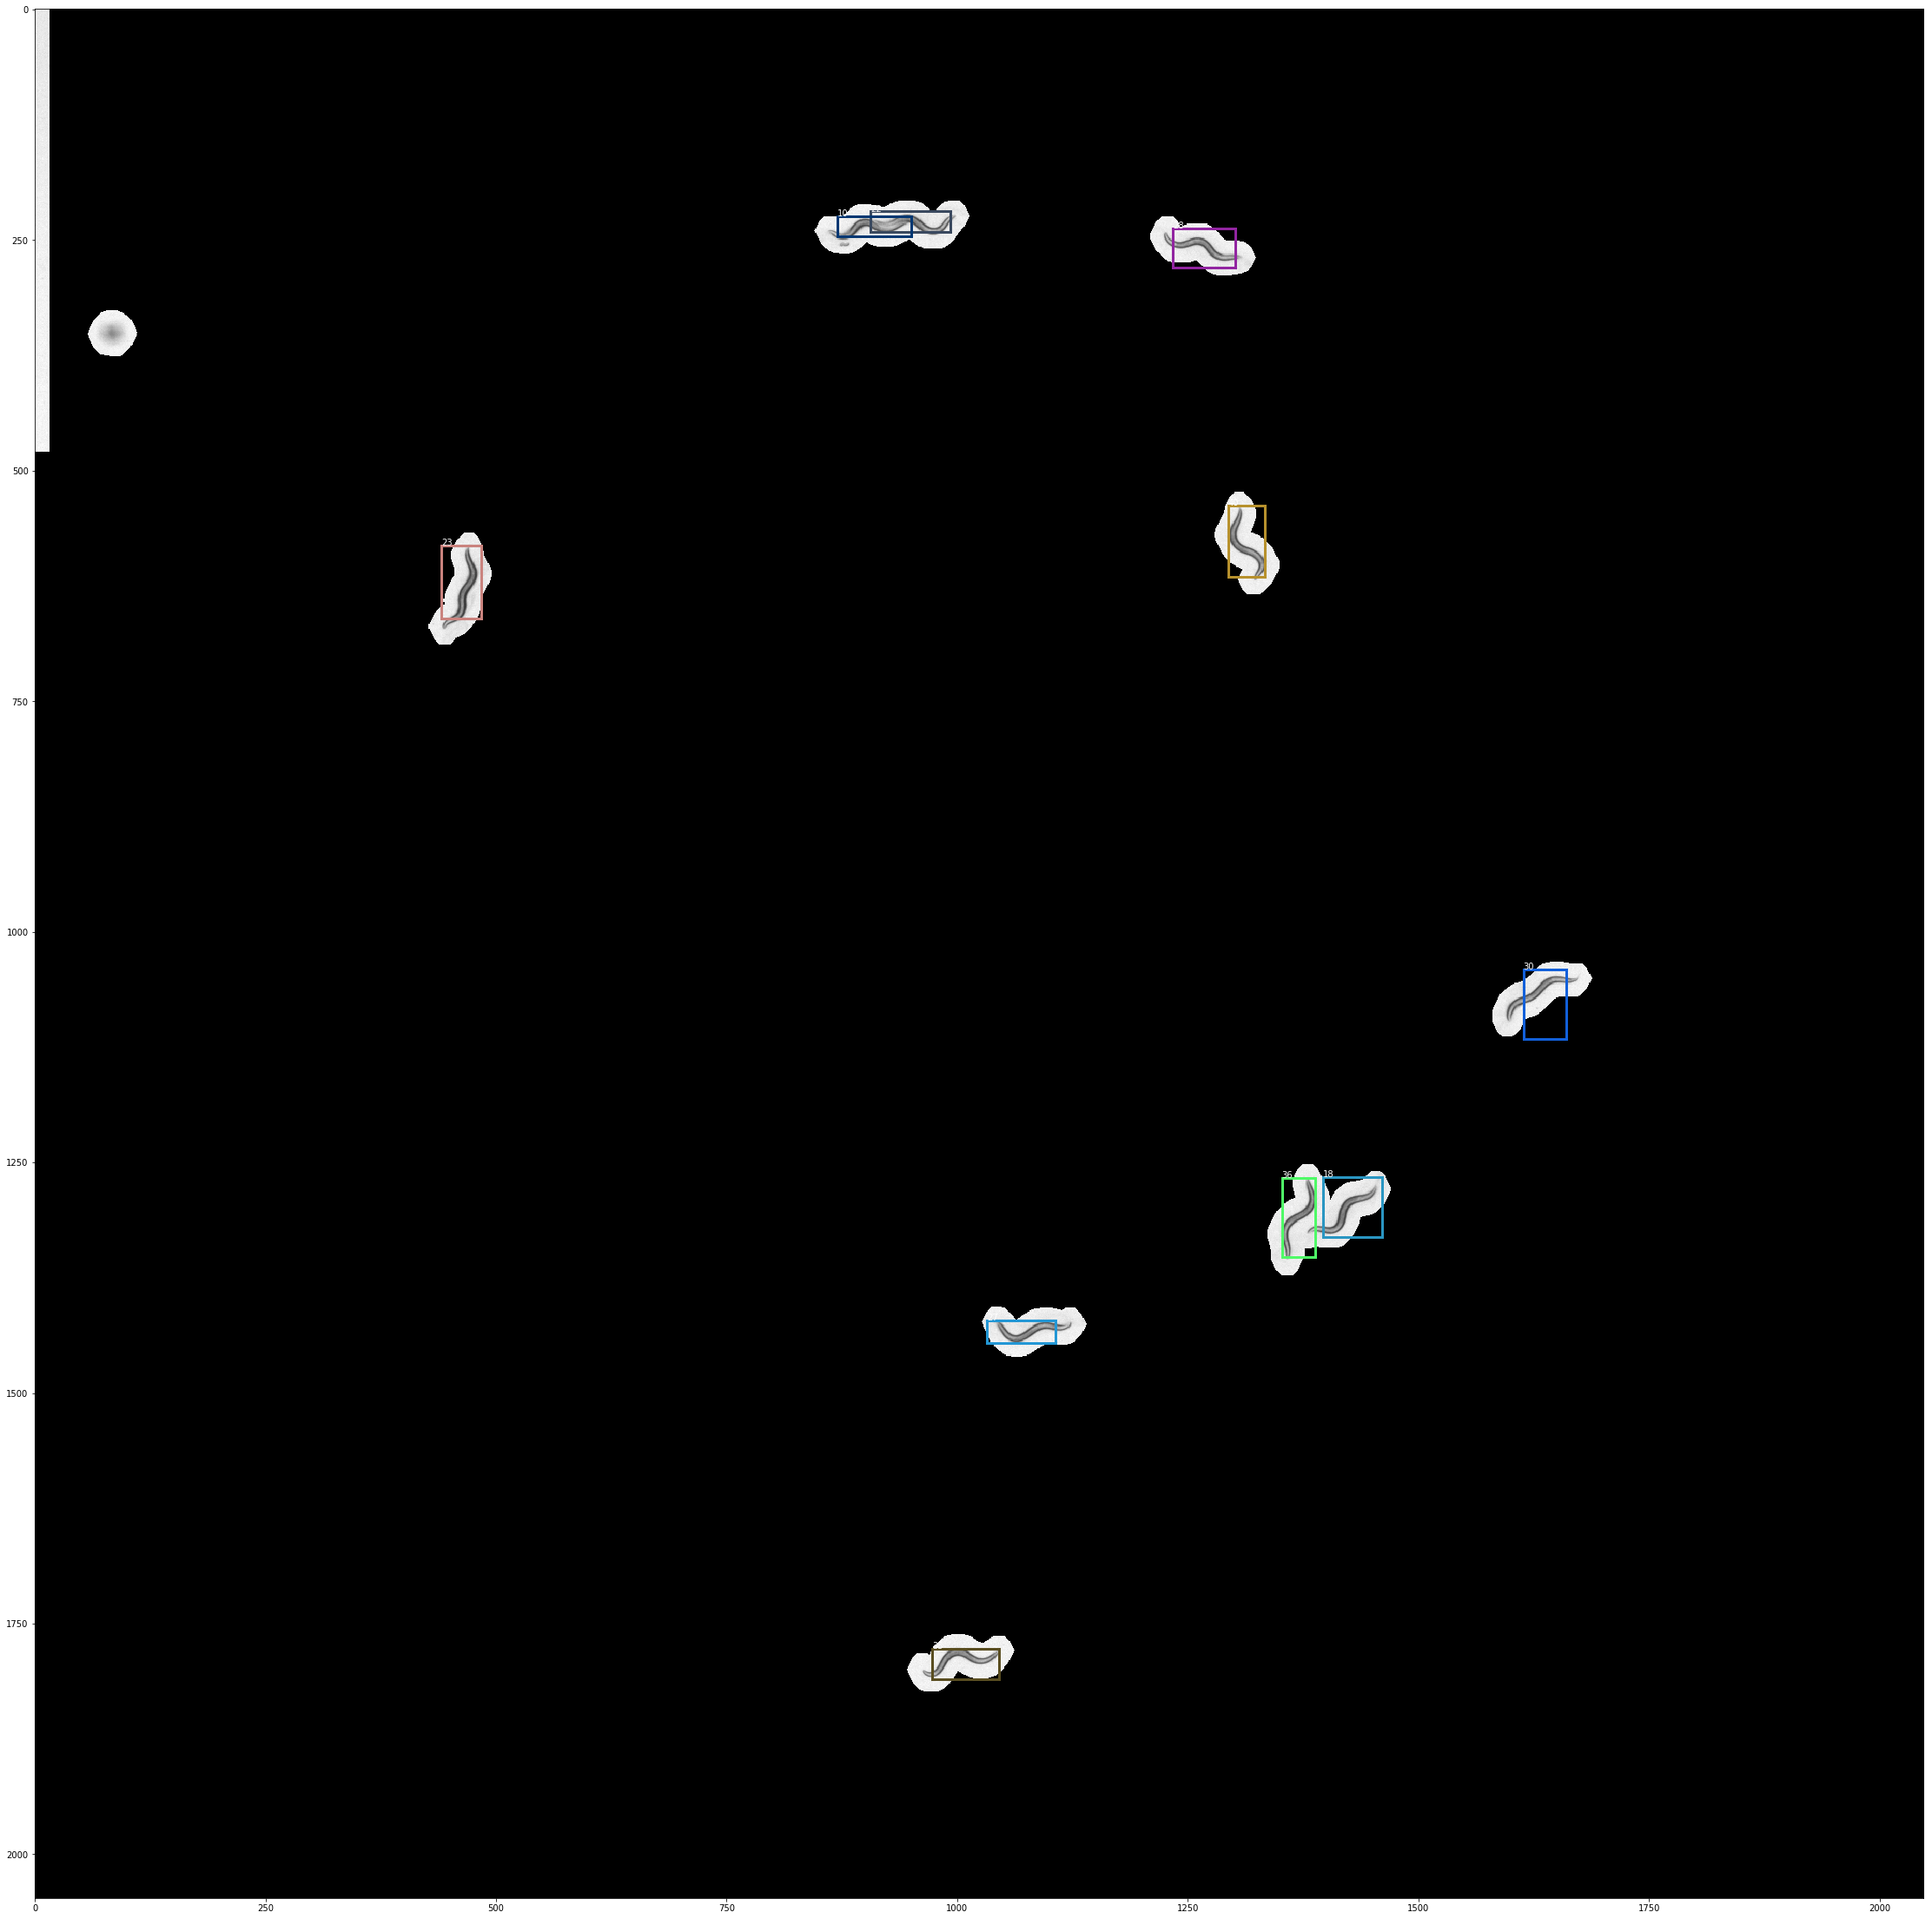

Worm IDs: [18.0, 22.0, 23.0, 27.0, 28.0, 30.0, 36.0, 41.0, 42.0, 43.0]


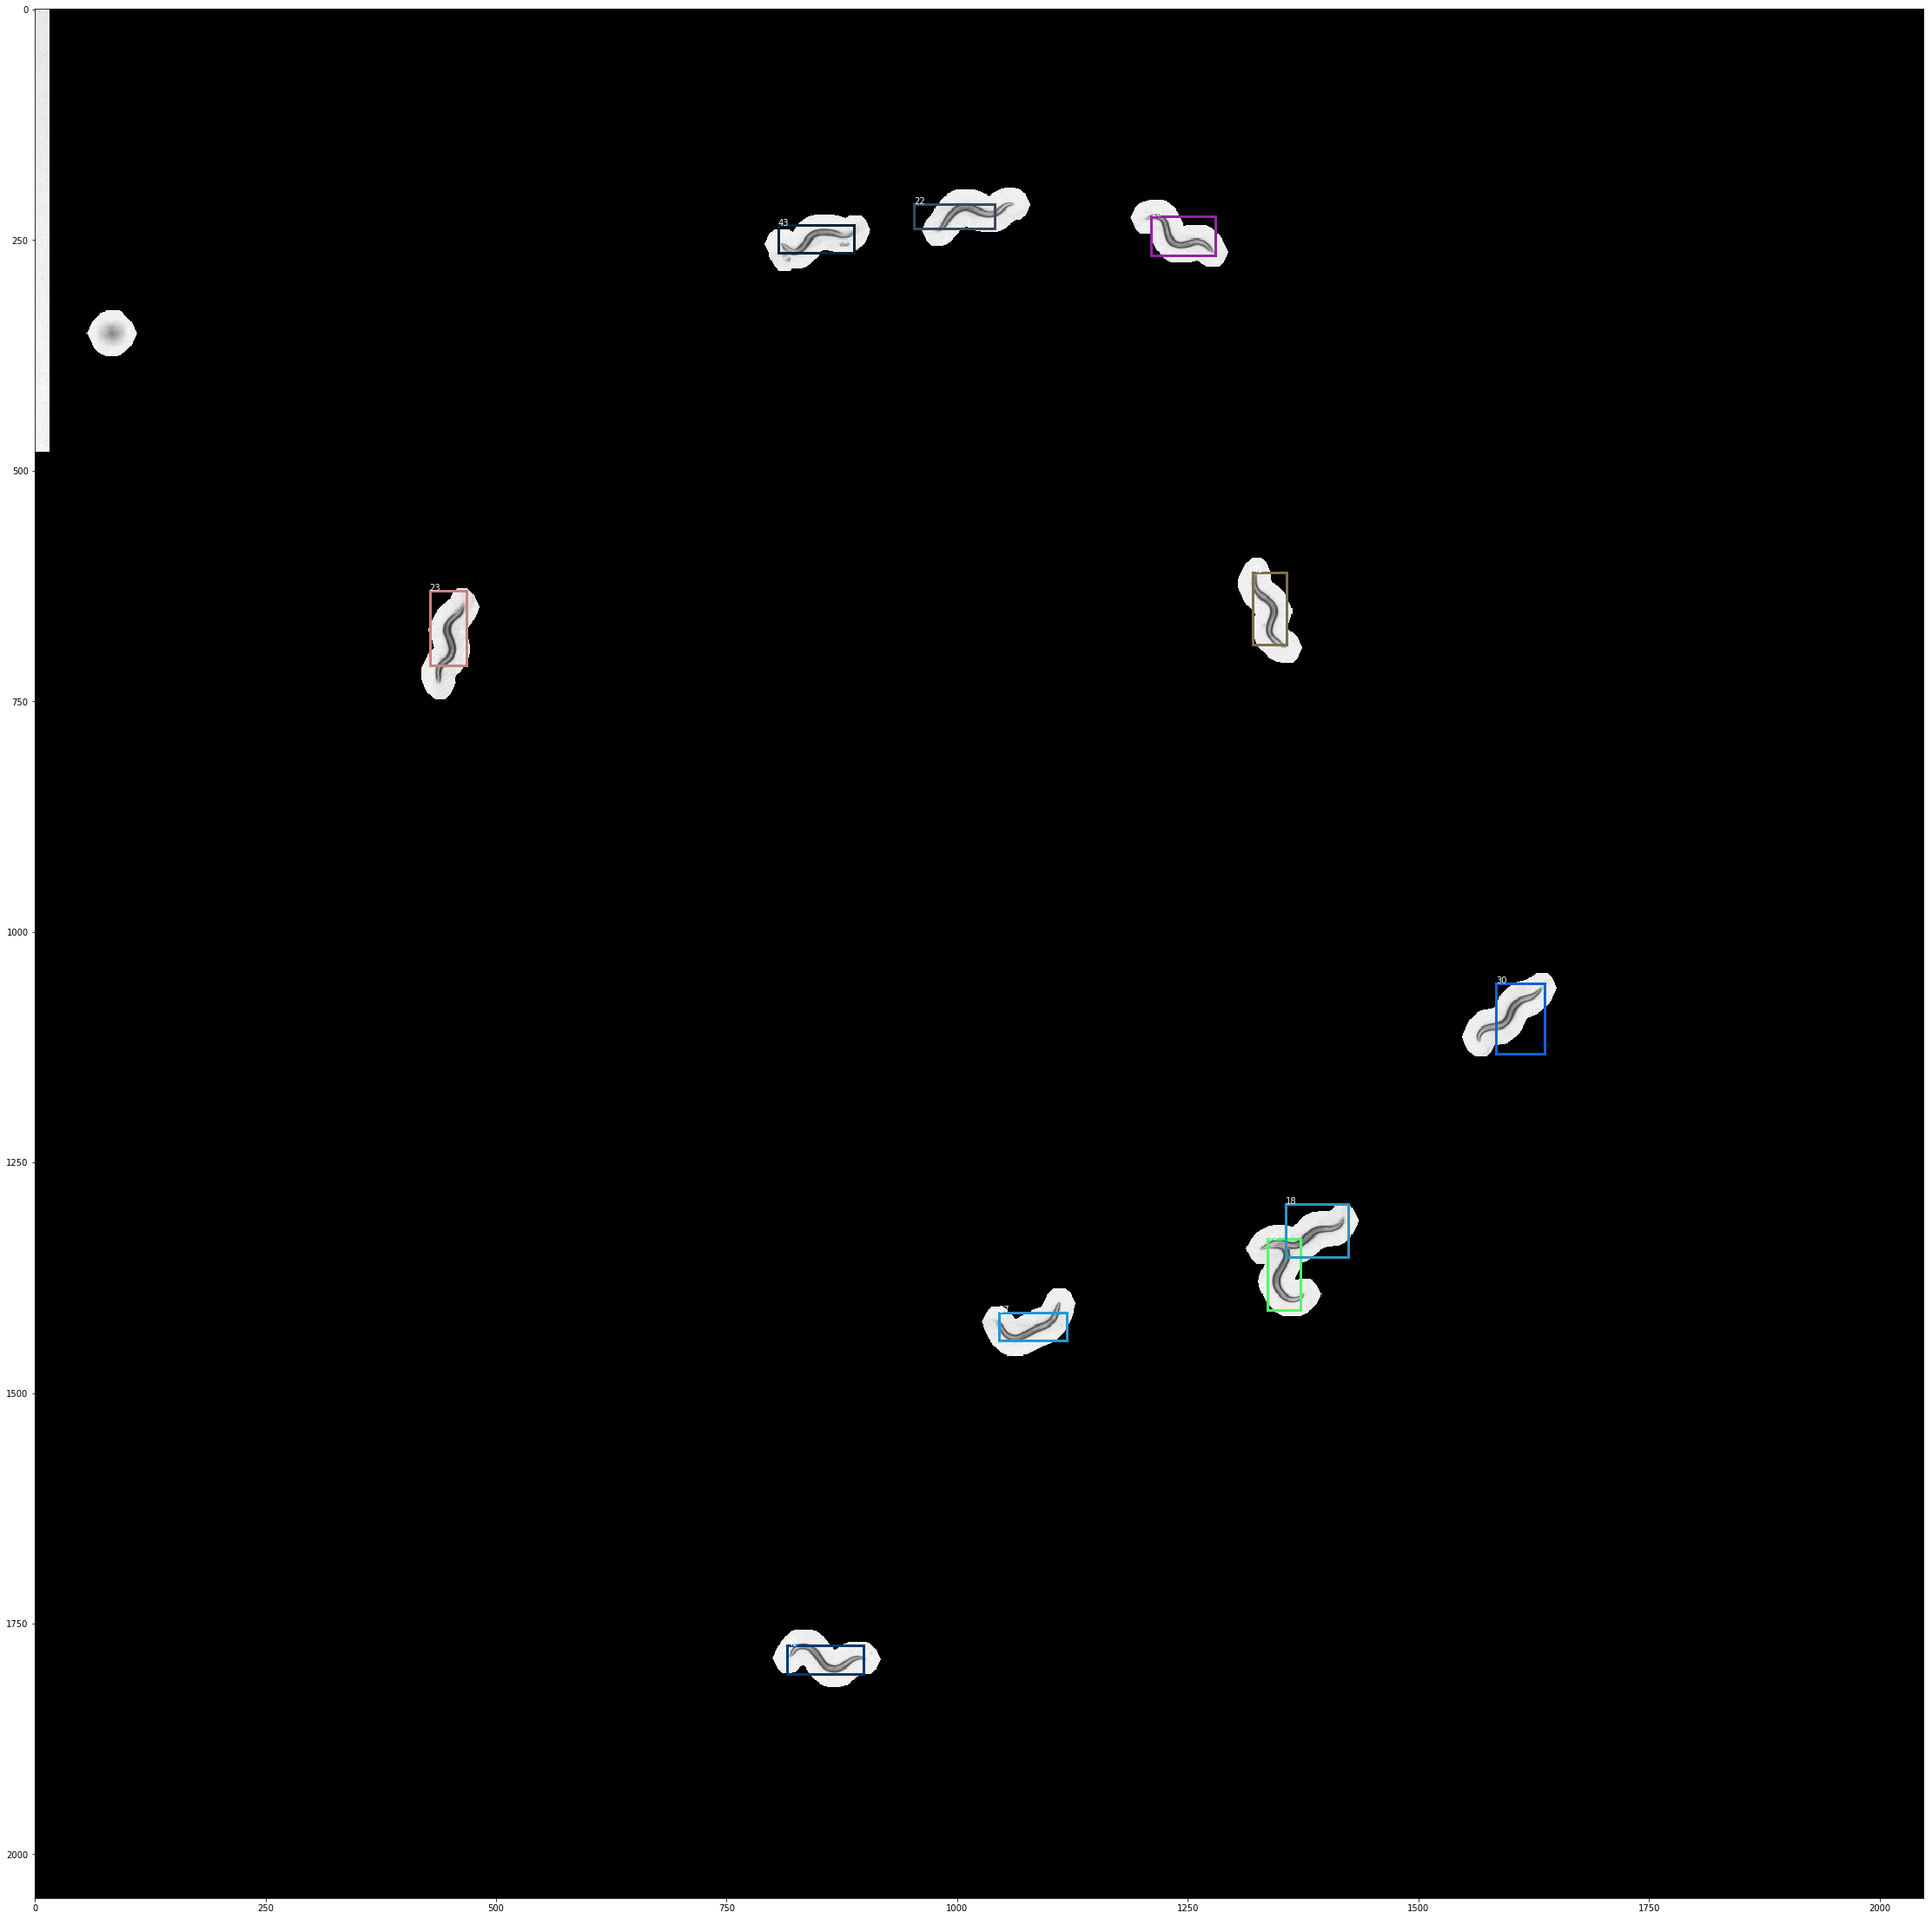

Worm IDs: [18.0, 27.0, 28.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0]


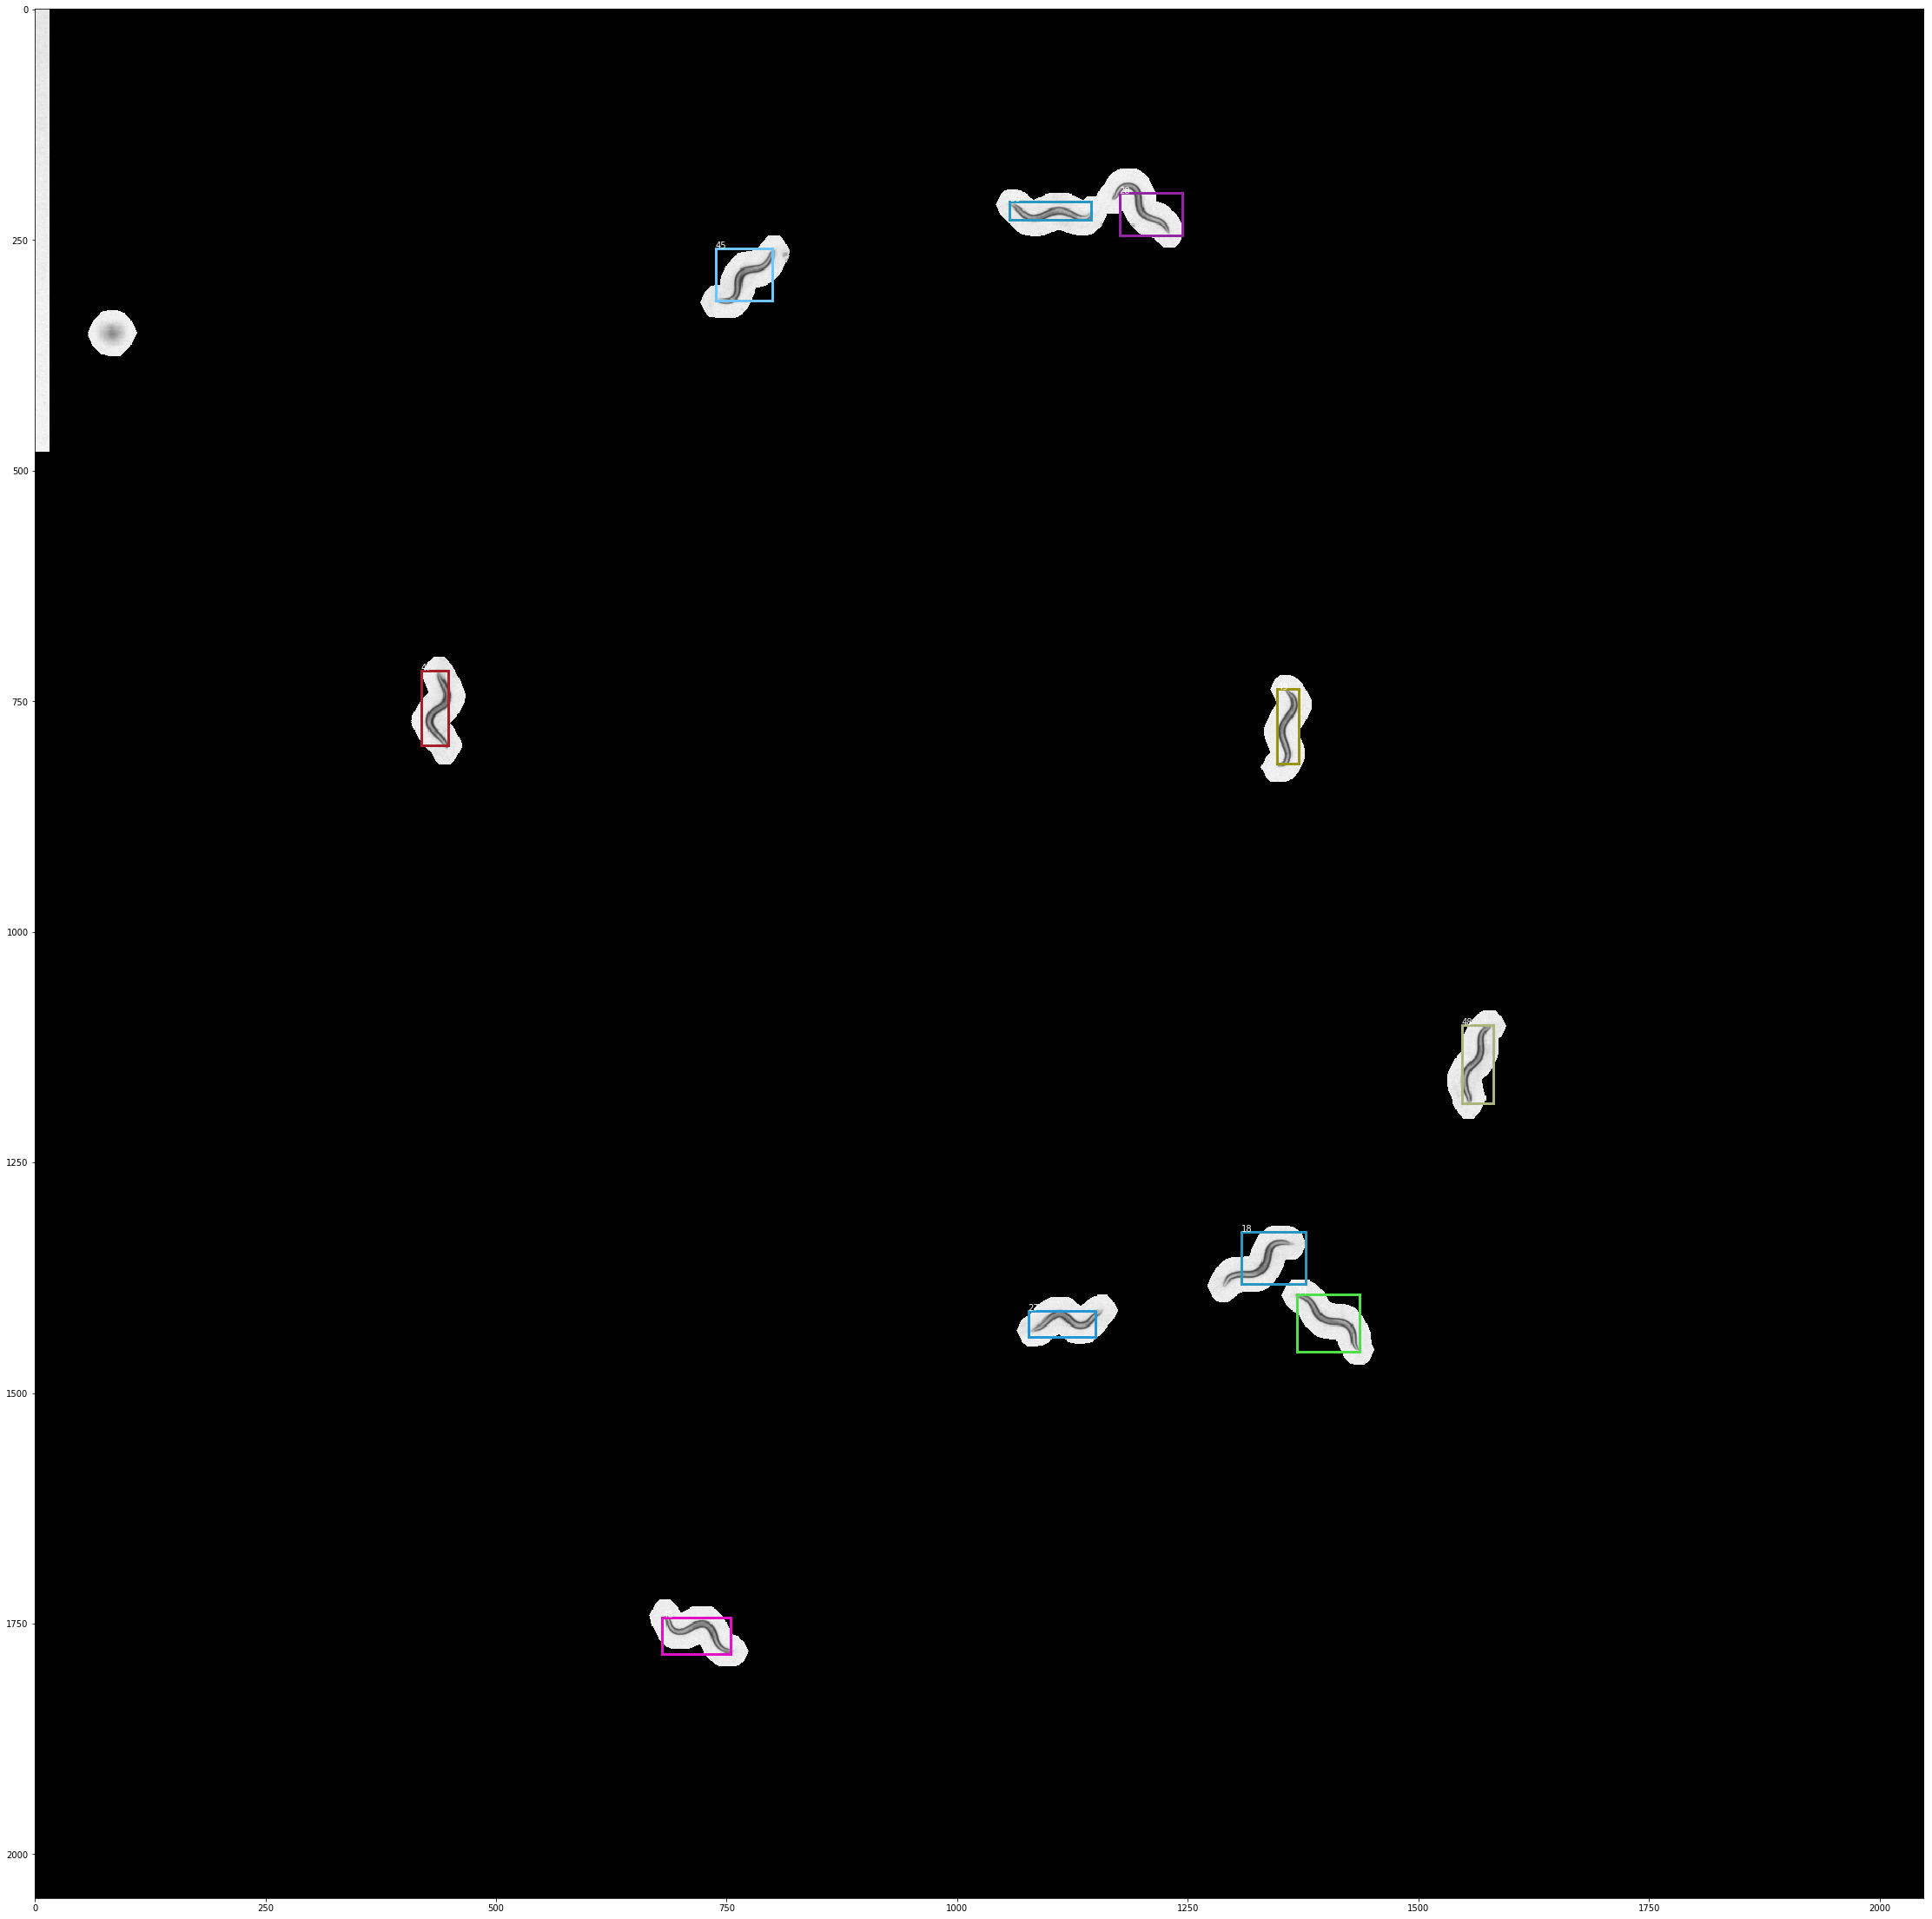

Worm IDs: [28.0, 44.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0]


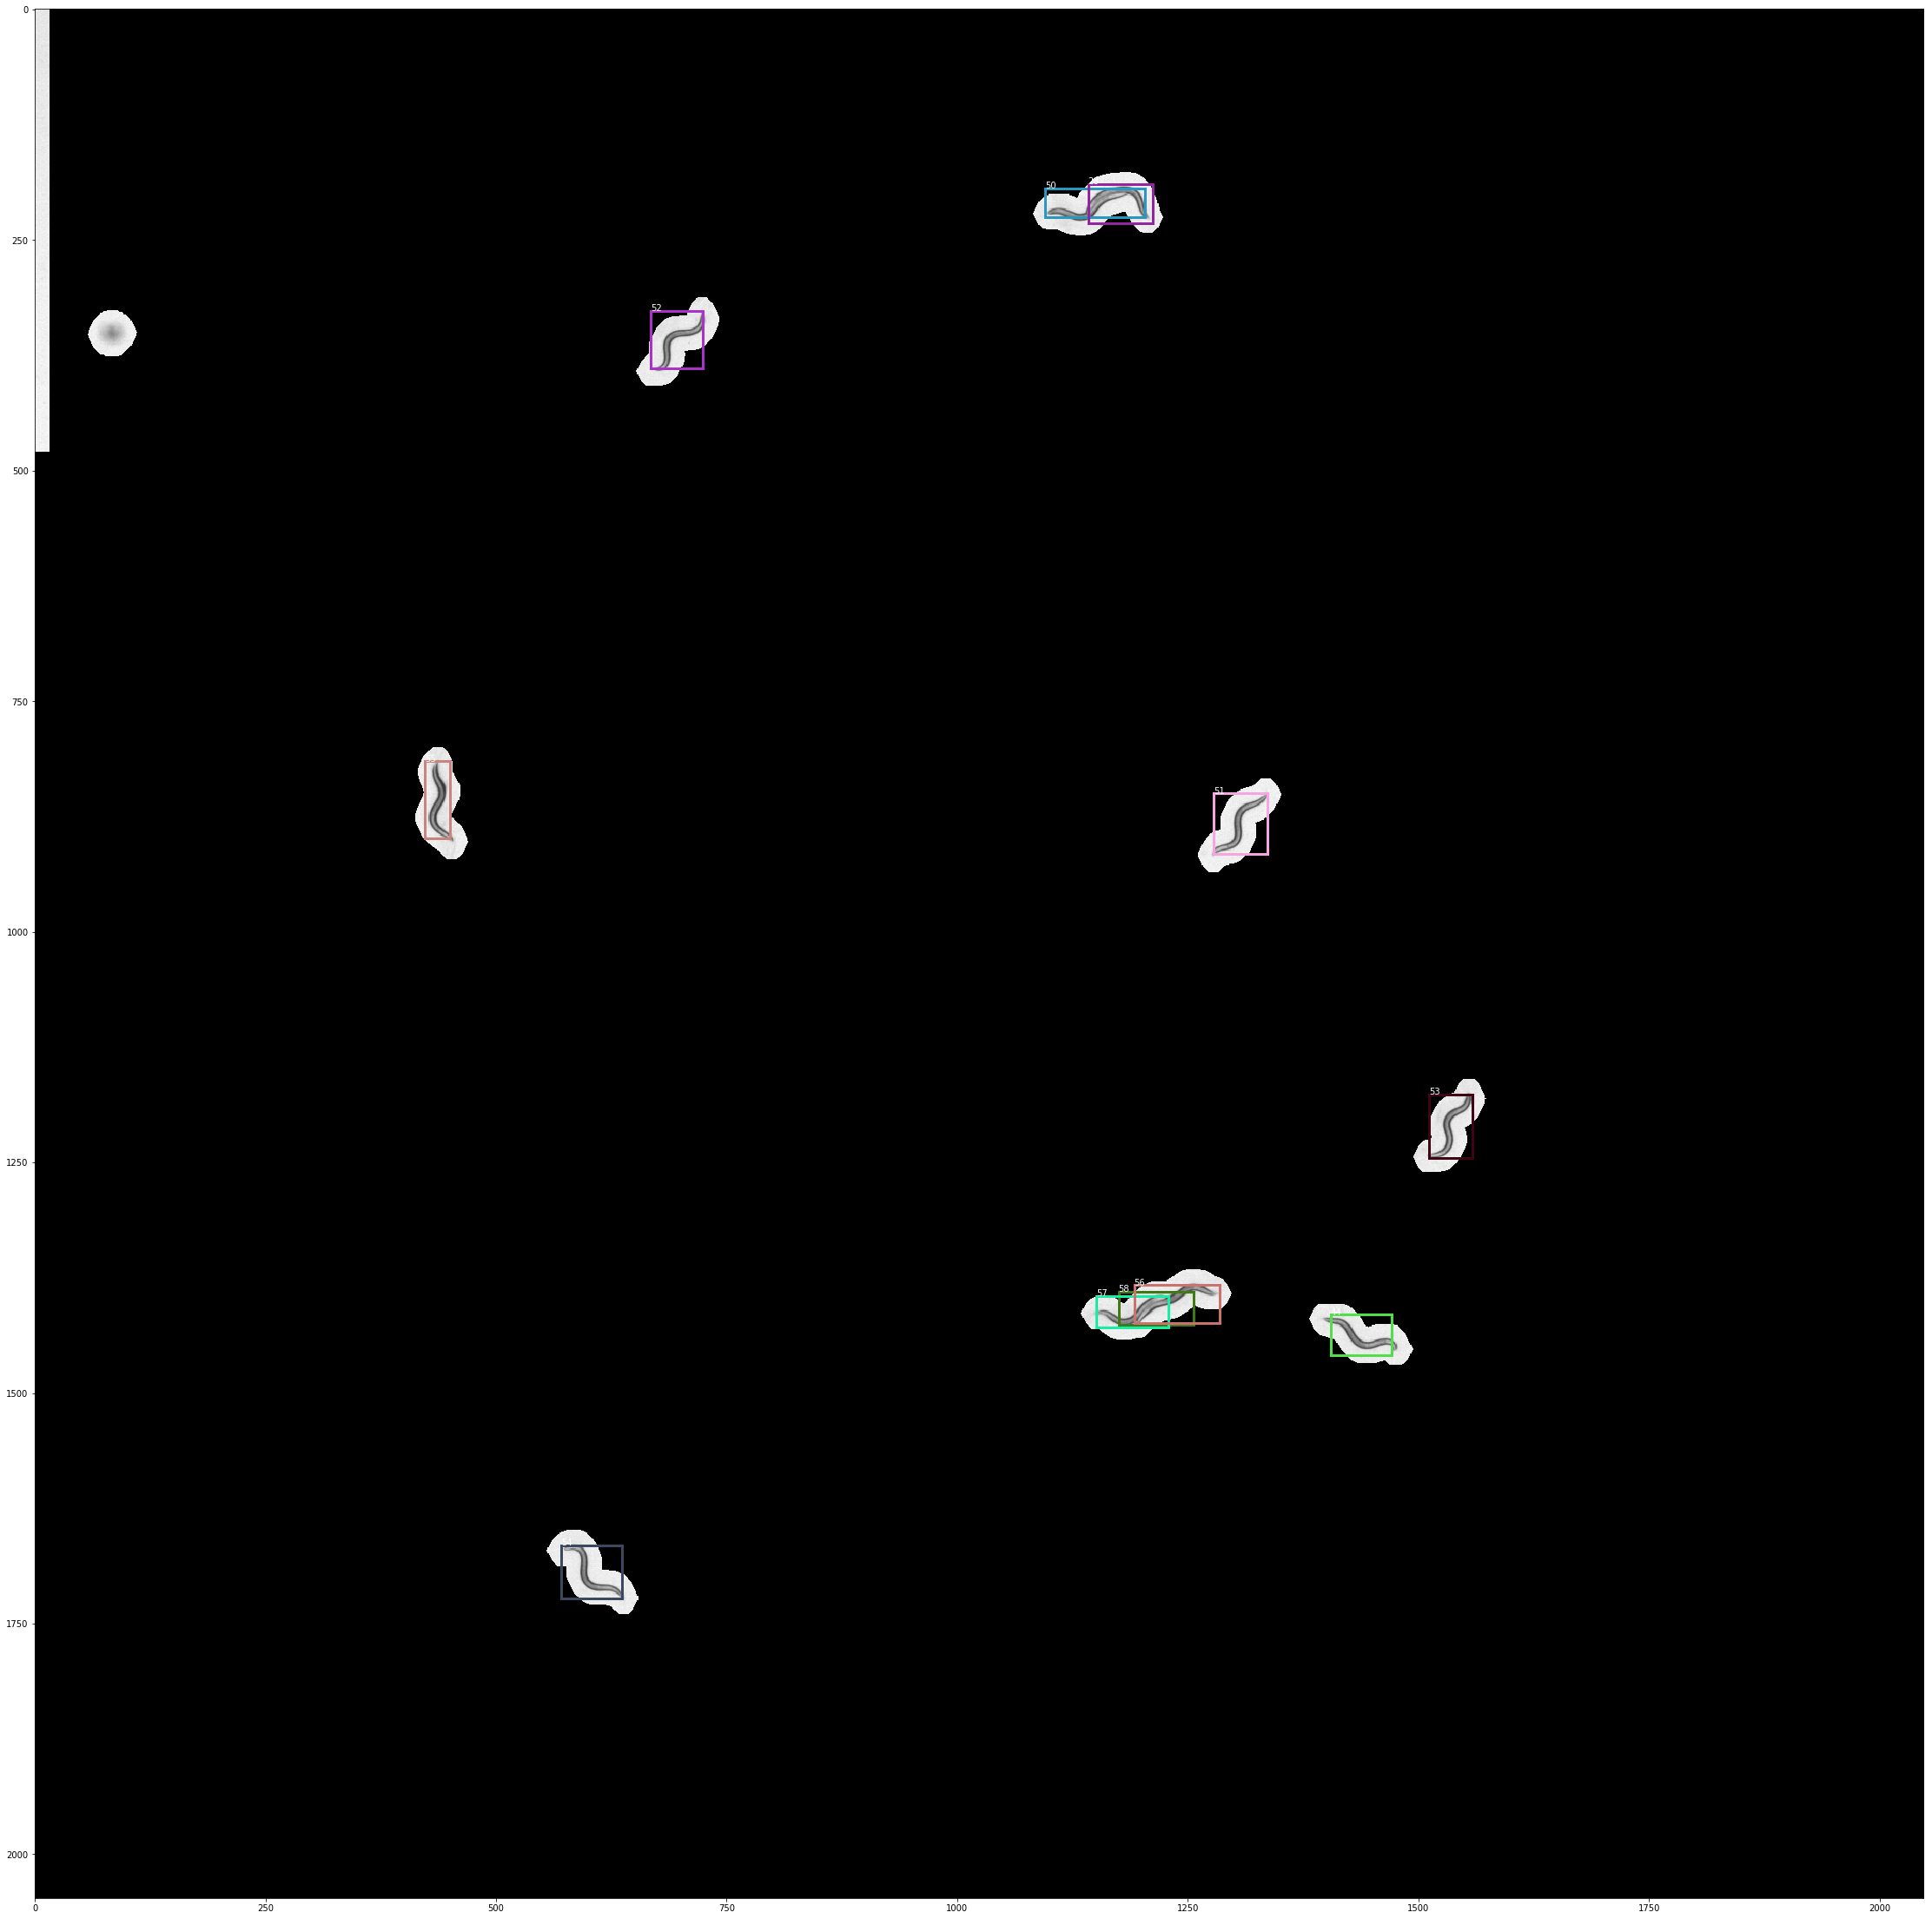

Worm IDs: [28.0, 44.0, 53.0, 55.0, 56.0, 57.0, 59.0, 60.0, 61.0]


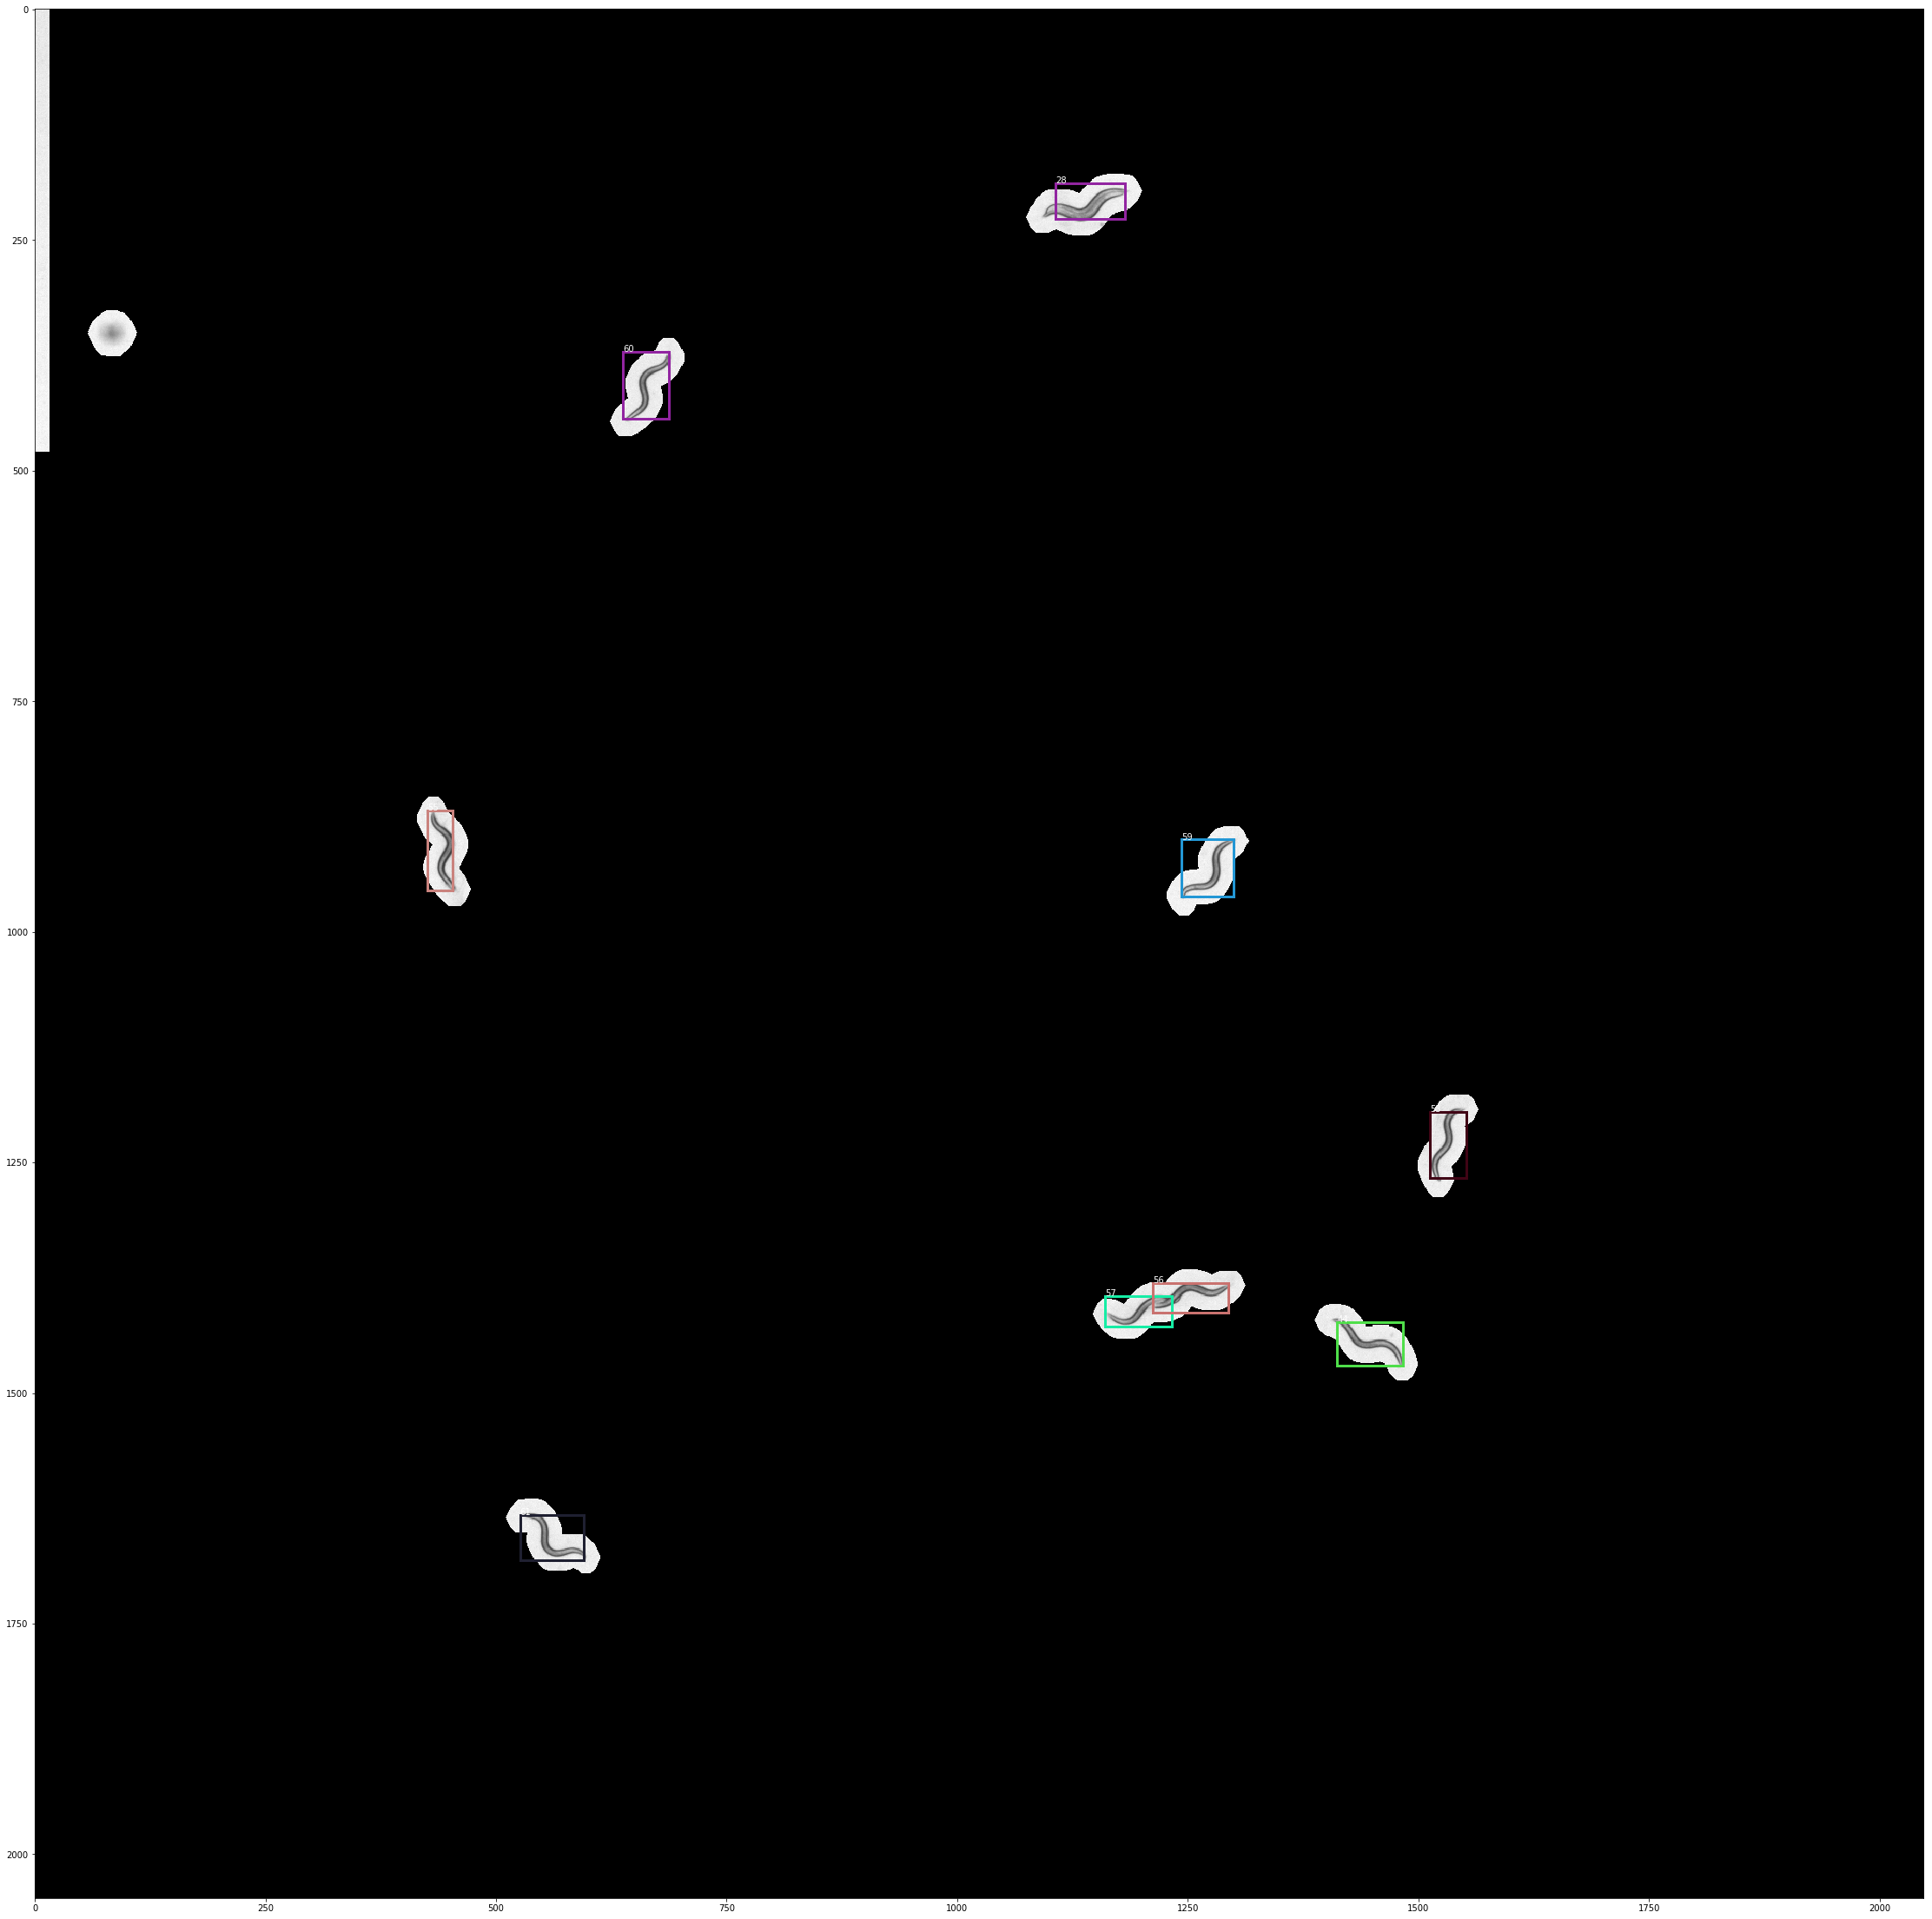

Worm IDs: [22.0, 28.0, 53.0, 55.0, 58.0, 62.0, 63.0, 64.0, 65.0]


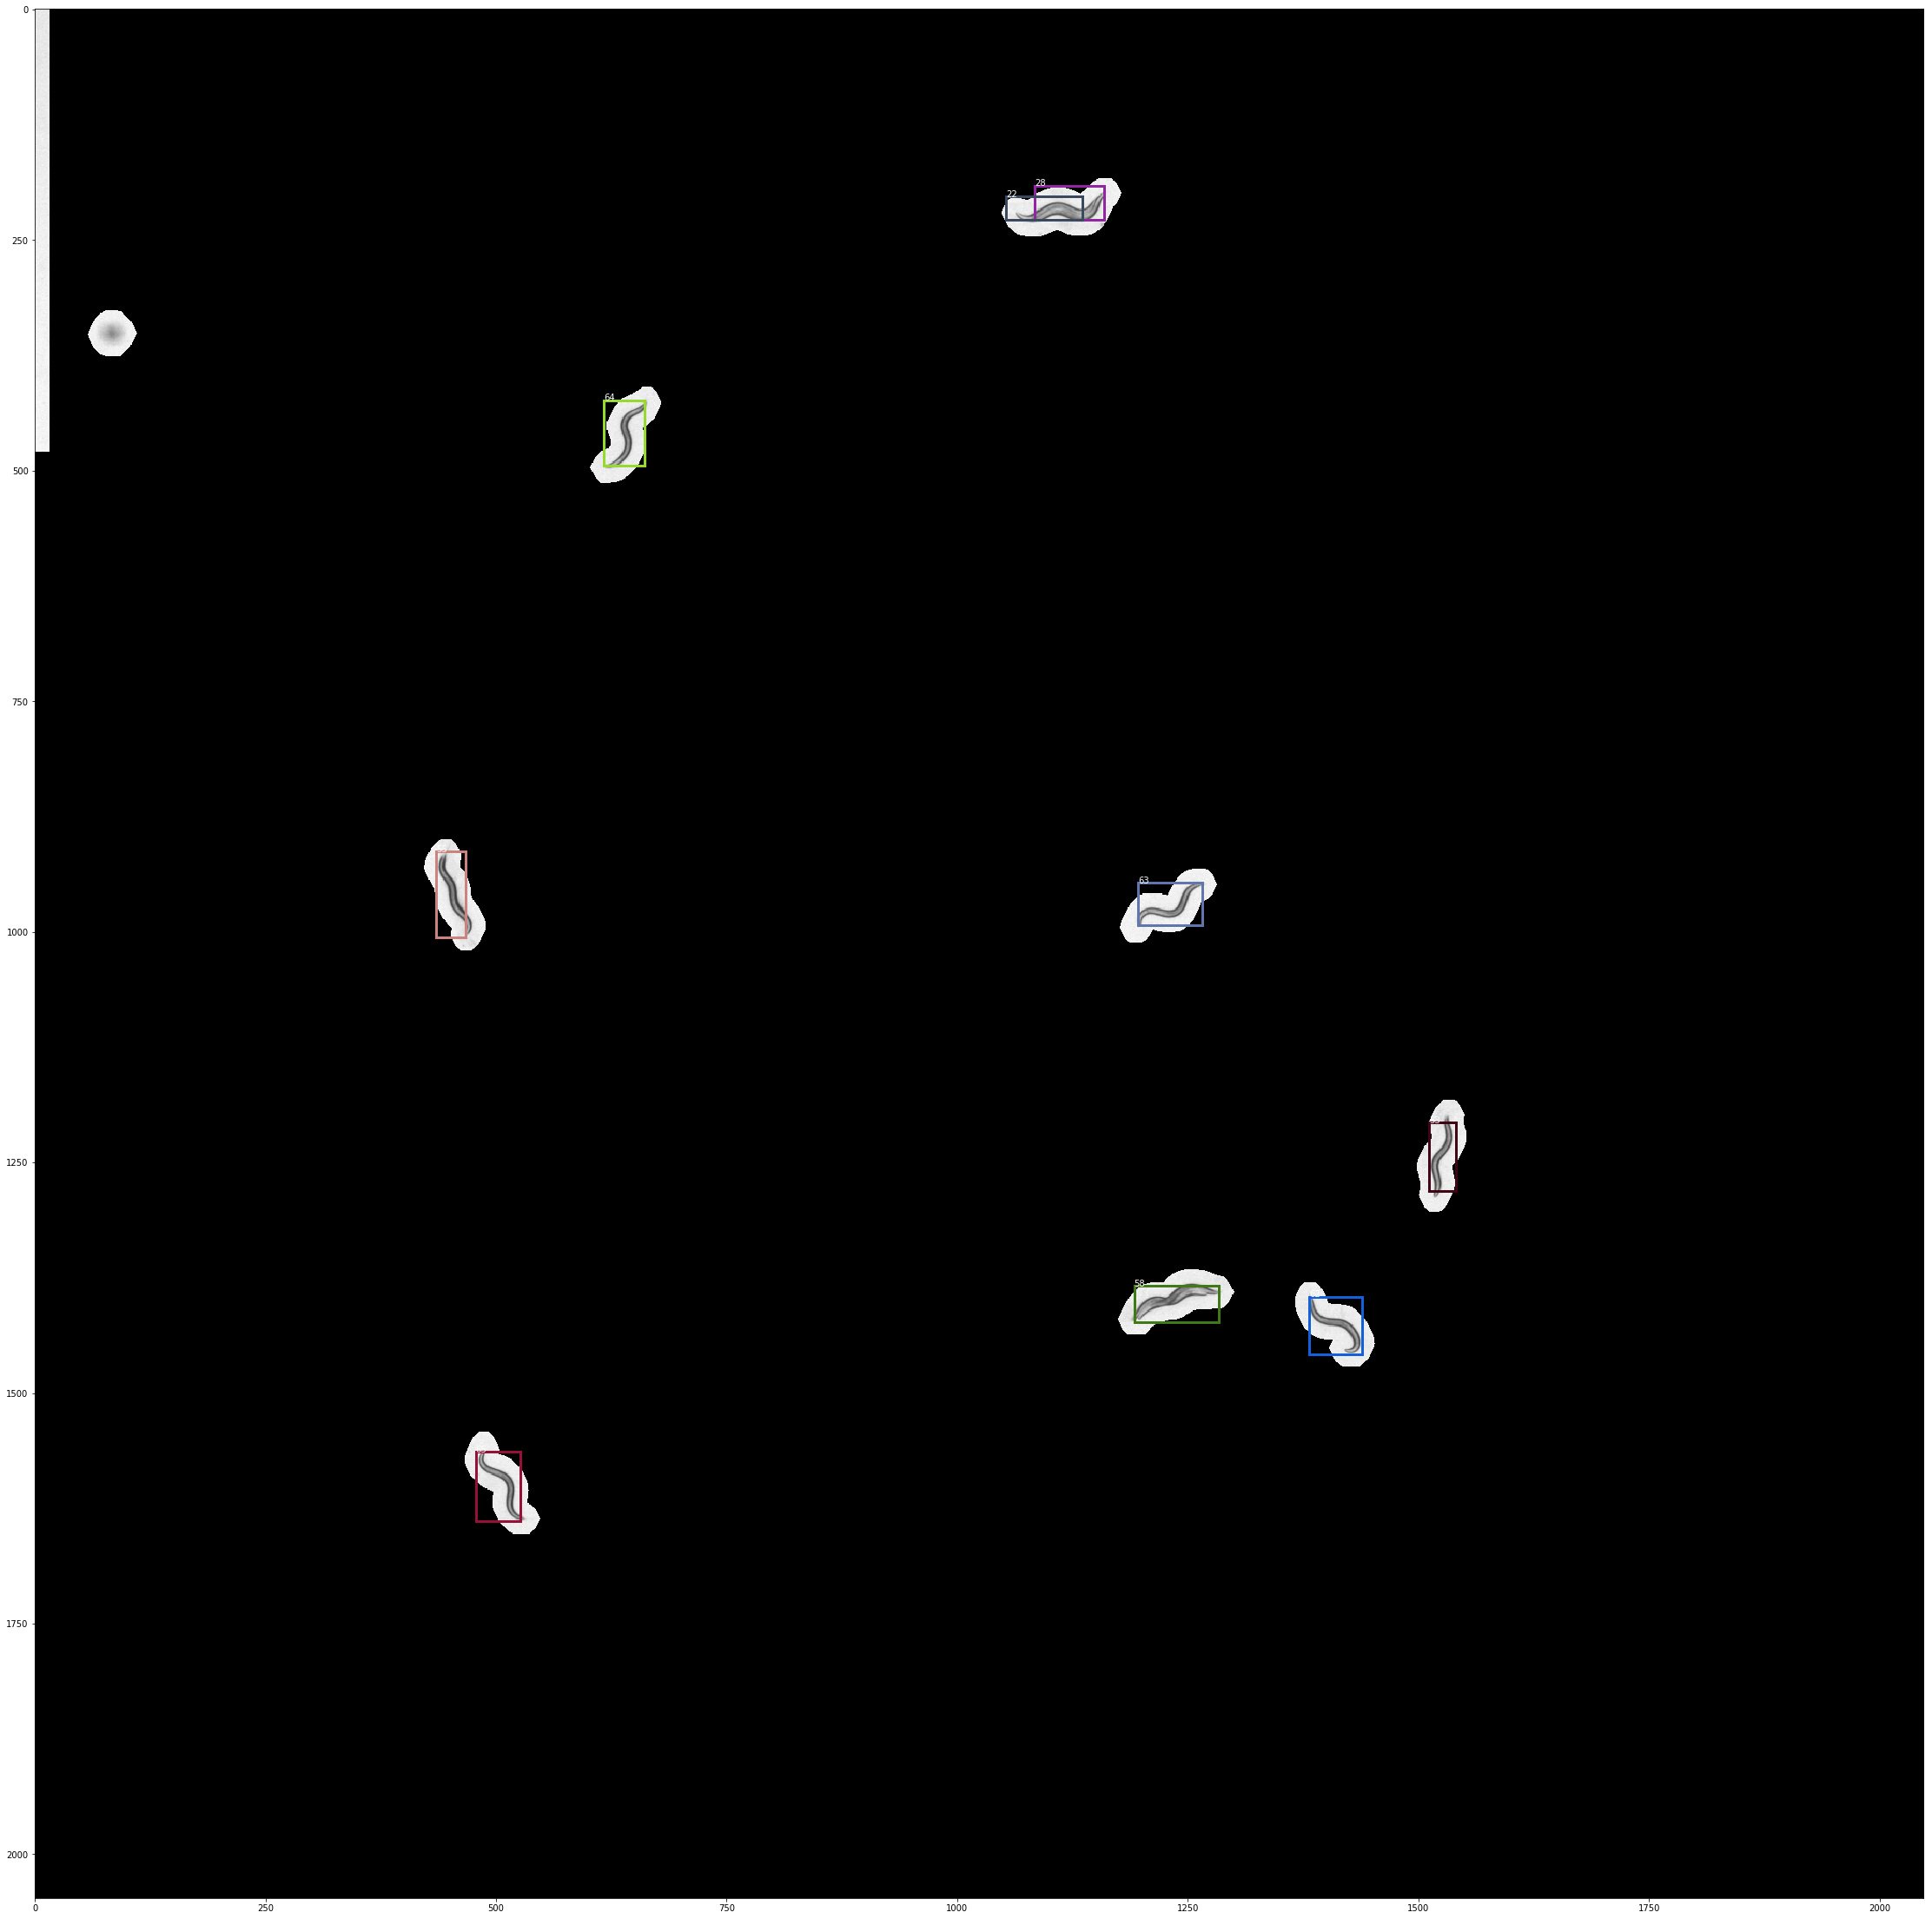

Worm IDs: [22.0, 28.0, 53.0, 55.0, 58.0, 62.0, 64.0, 66.0, 67.0]


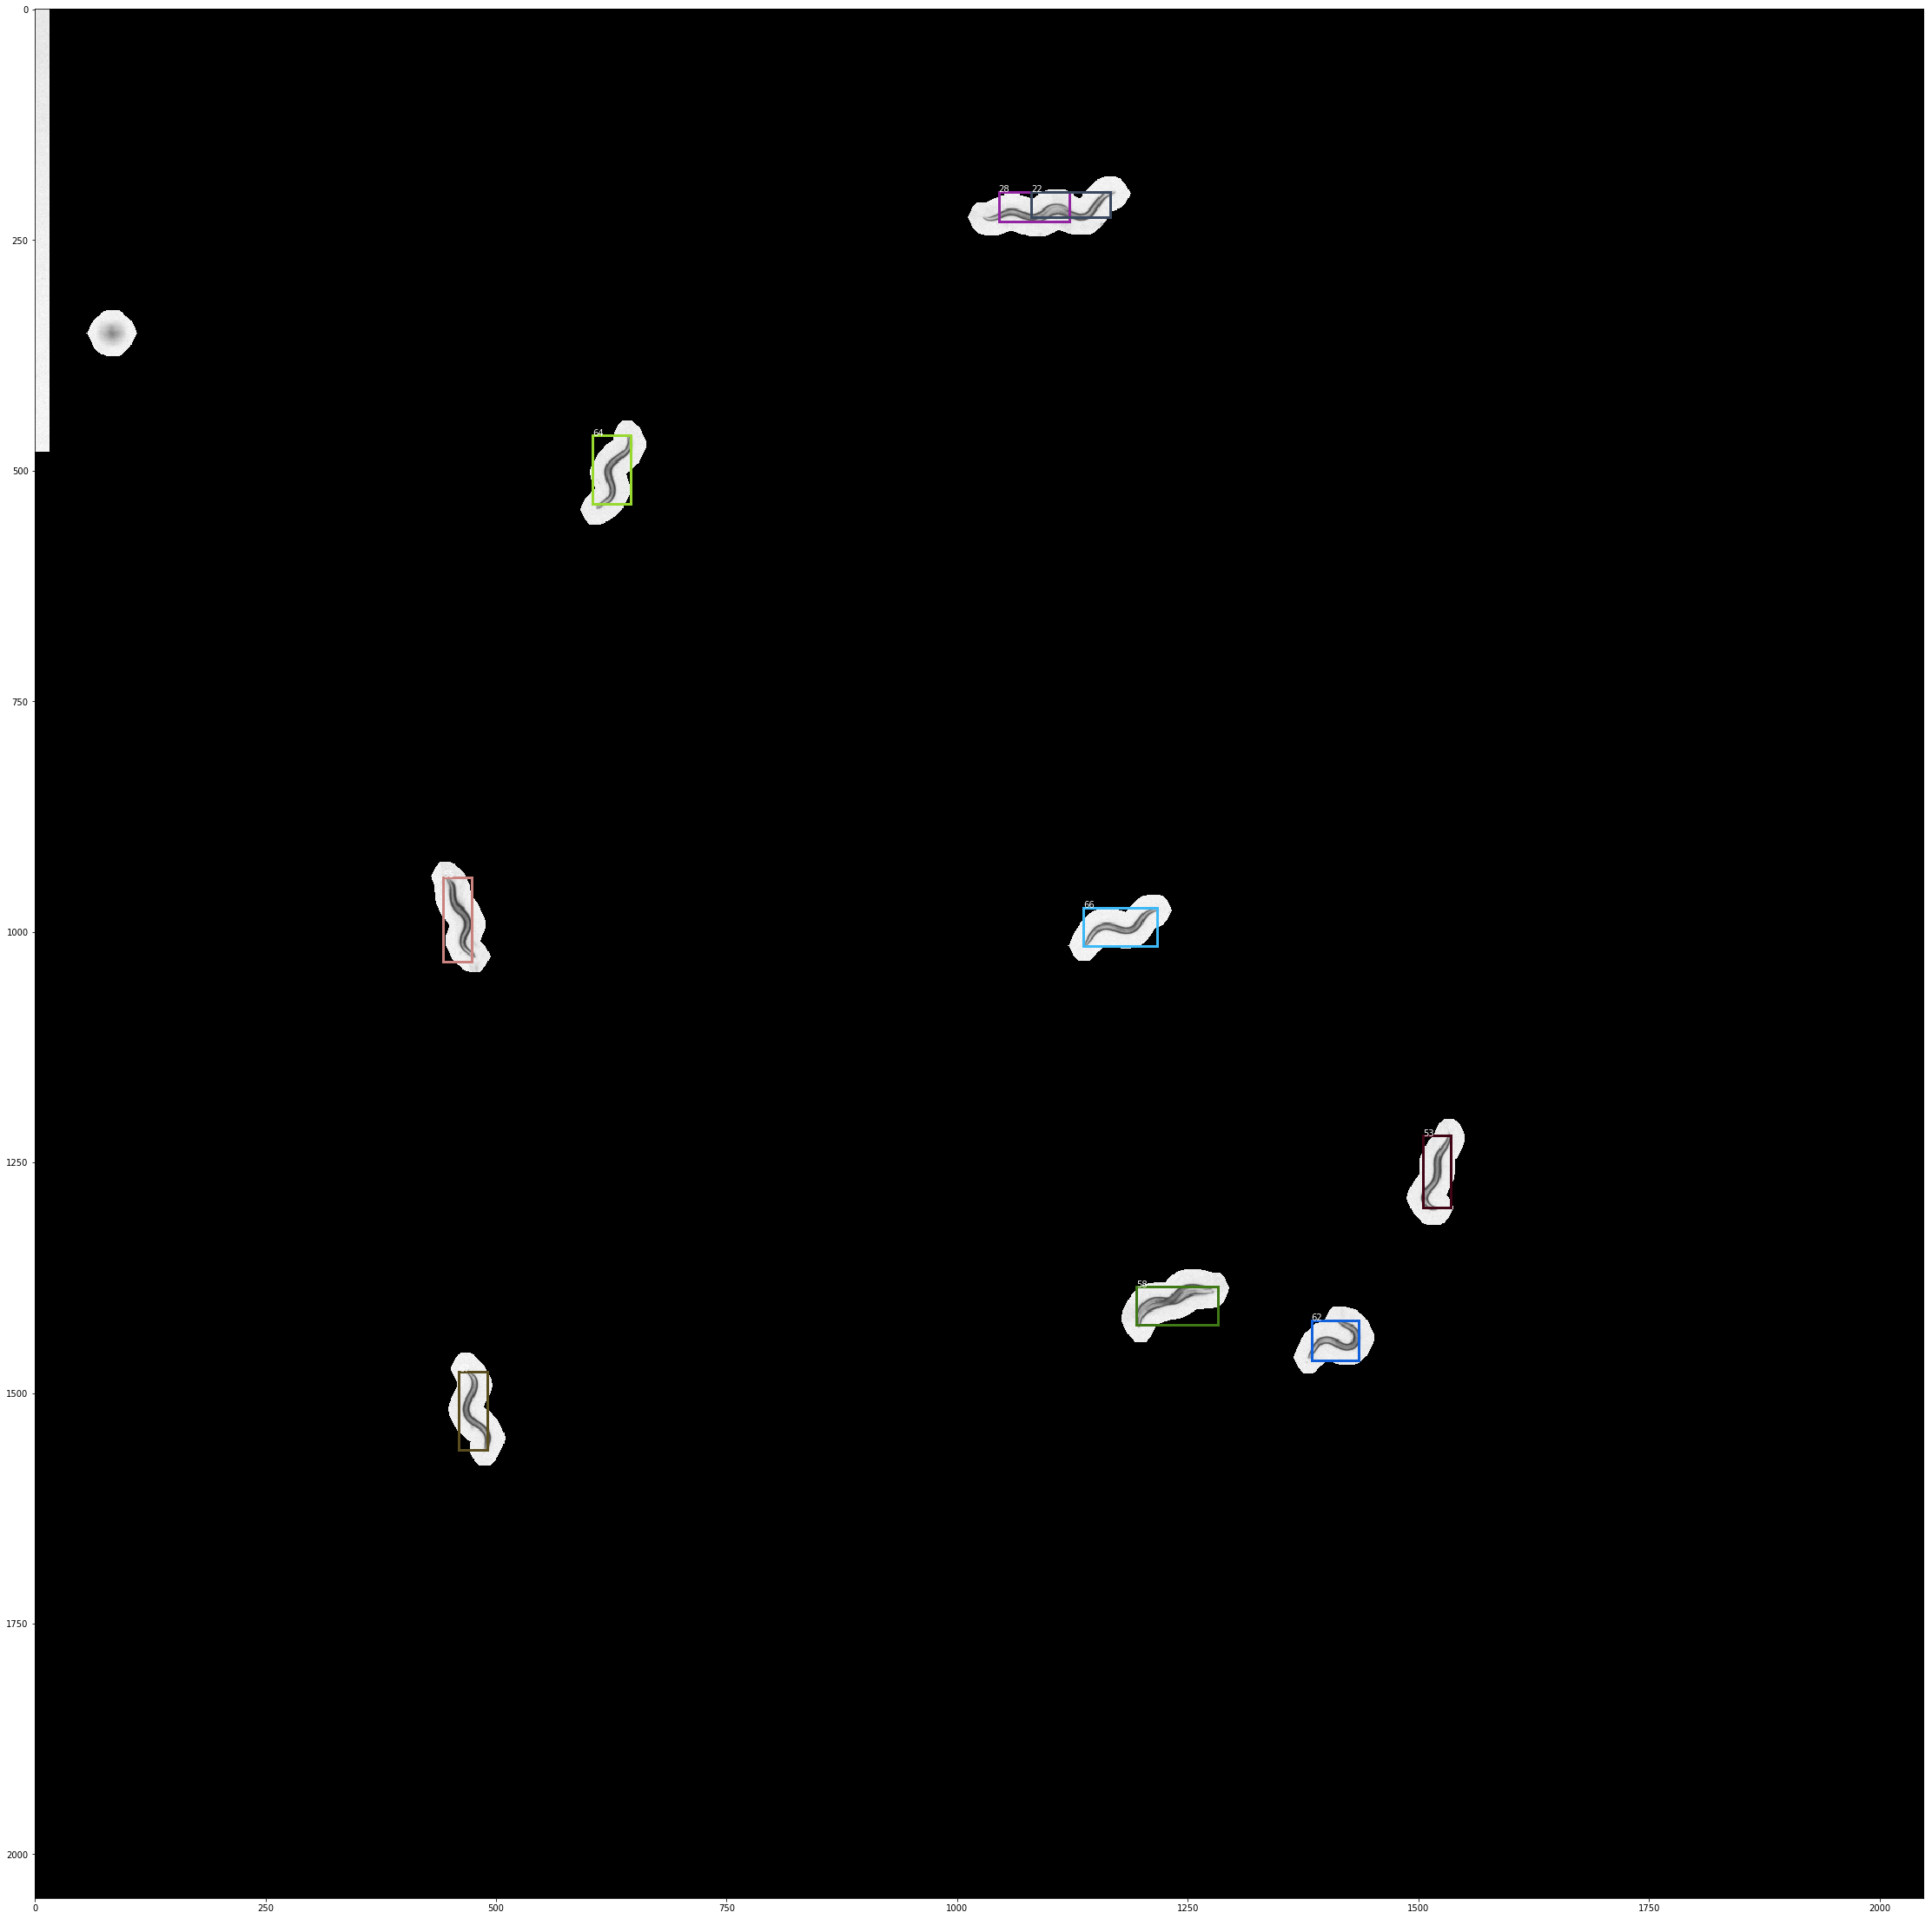

Worm IDs: [22.0, 28.0, 53.0, 55.0, 58.0, 62.0, 64.0, 68.0, 69.0]


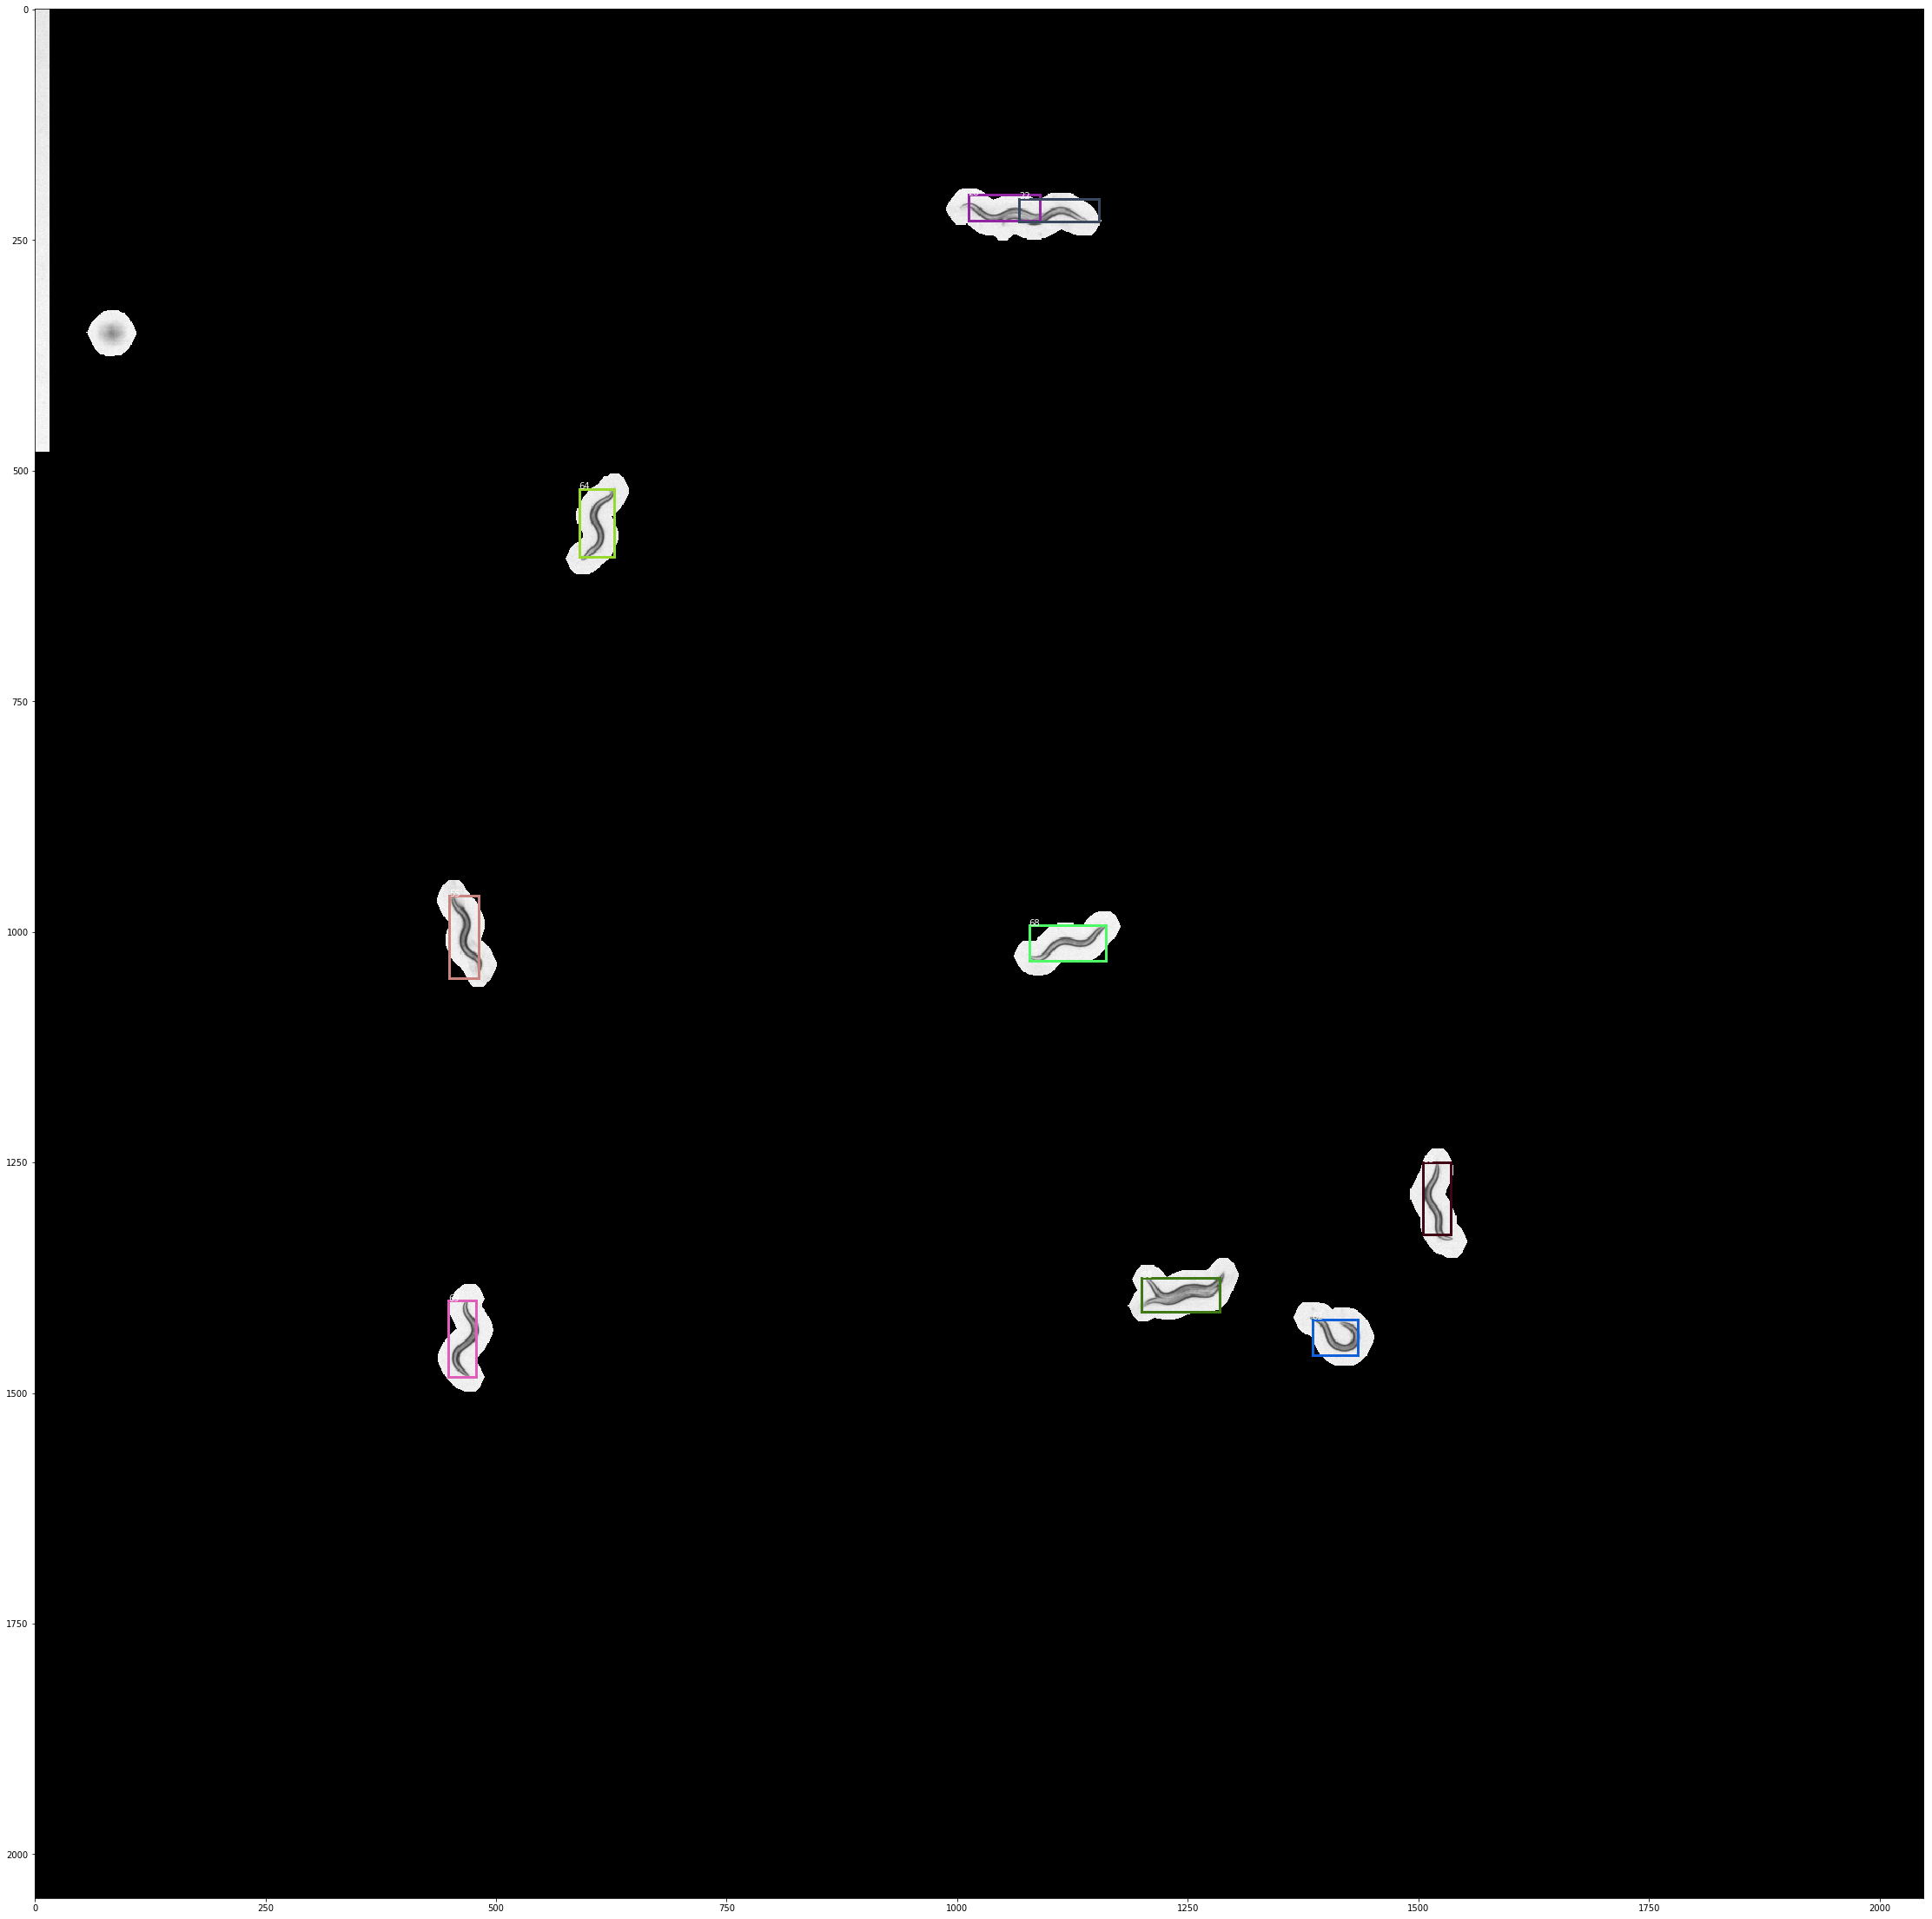

Worm IDs: [22.0, 28.0, 53.0, 55.0, 58.0, 64.0, 68.0, 70.0, 71.0, 72.0, 73.0]


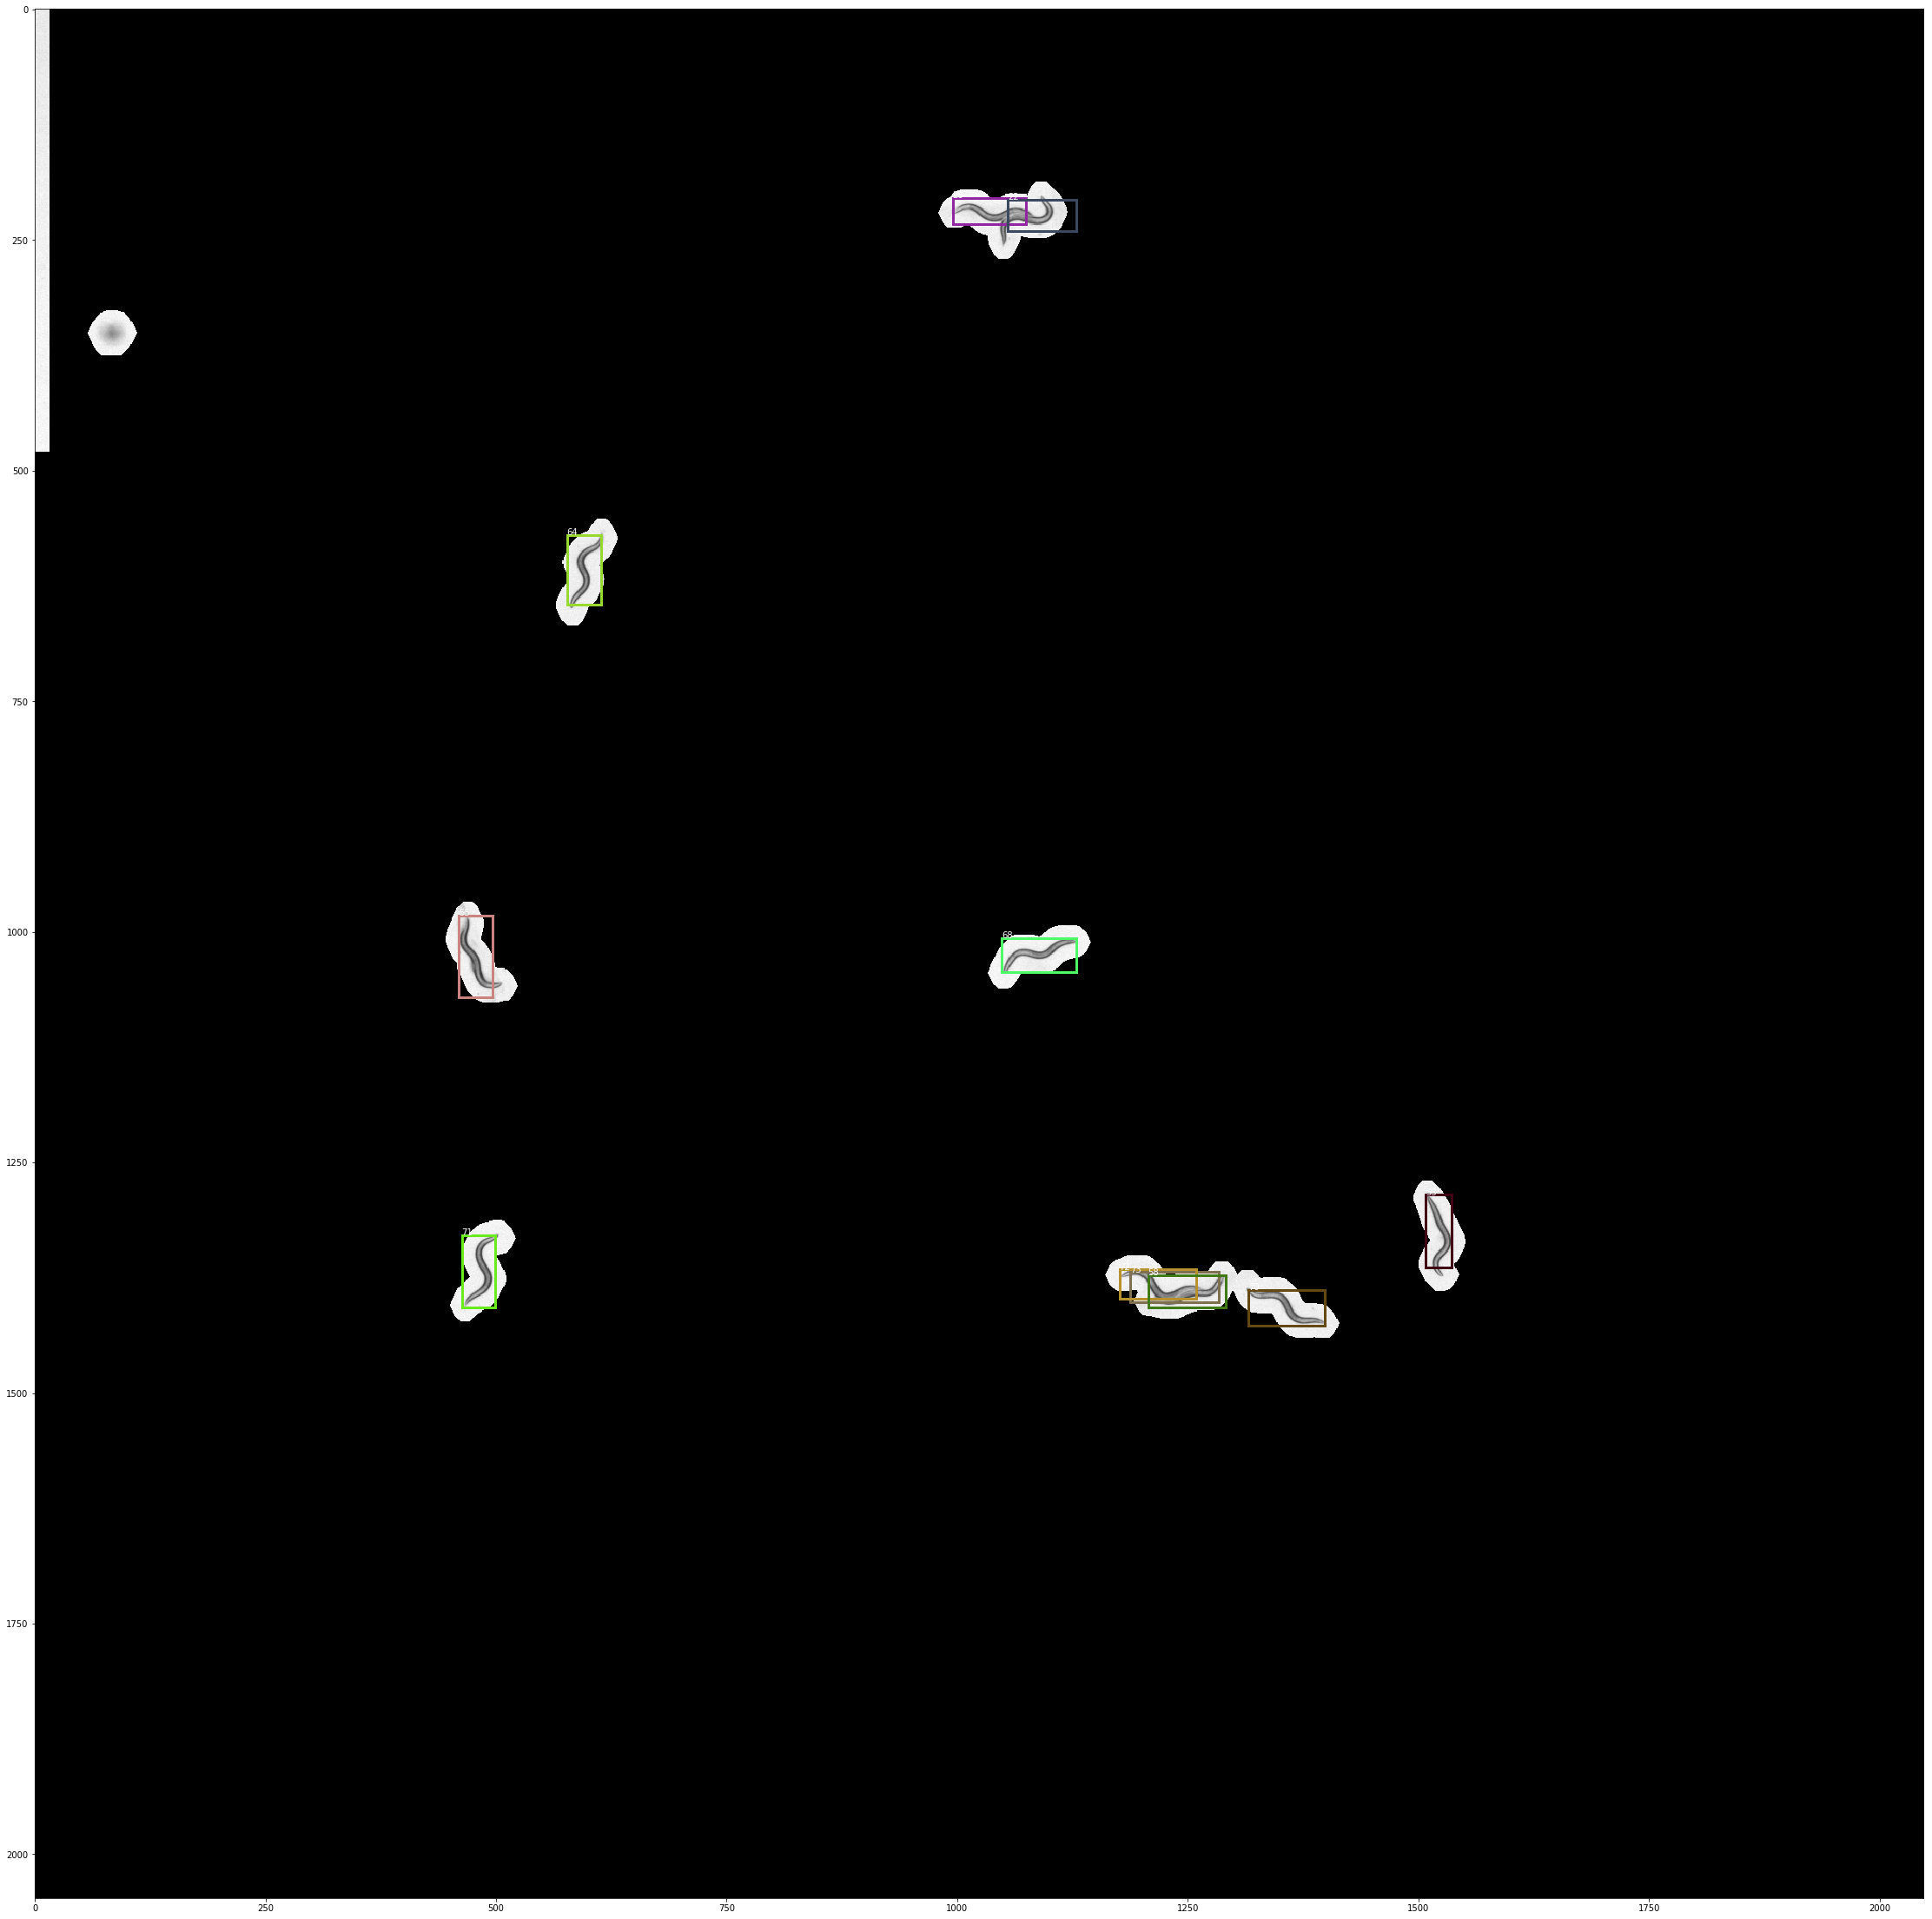

Worm IDs: [28.0, 53.0, 55.0, 56.0, 58.0, 64.0, 68.0, 72.0, 73.0, 74.0, 75.0]


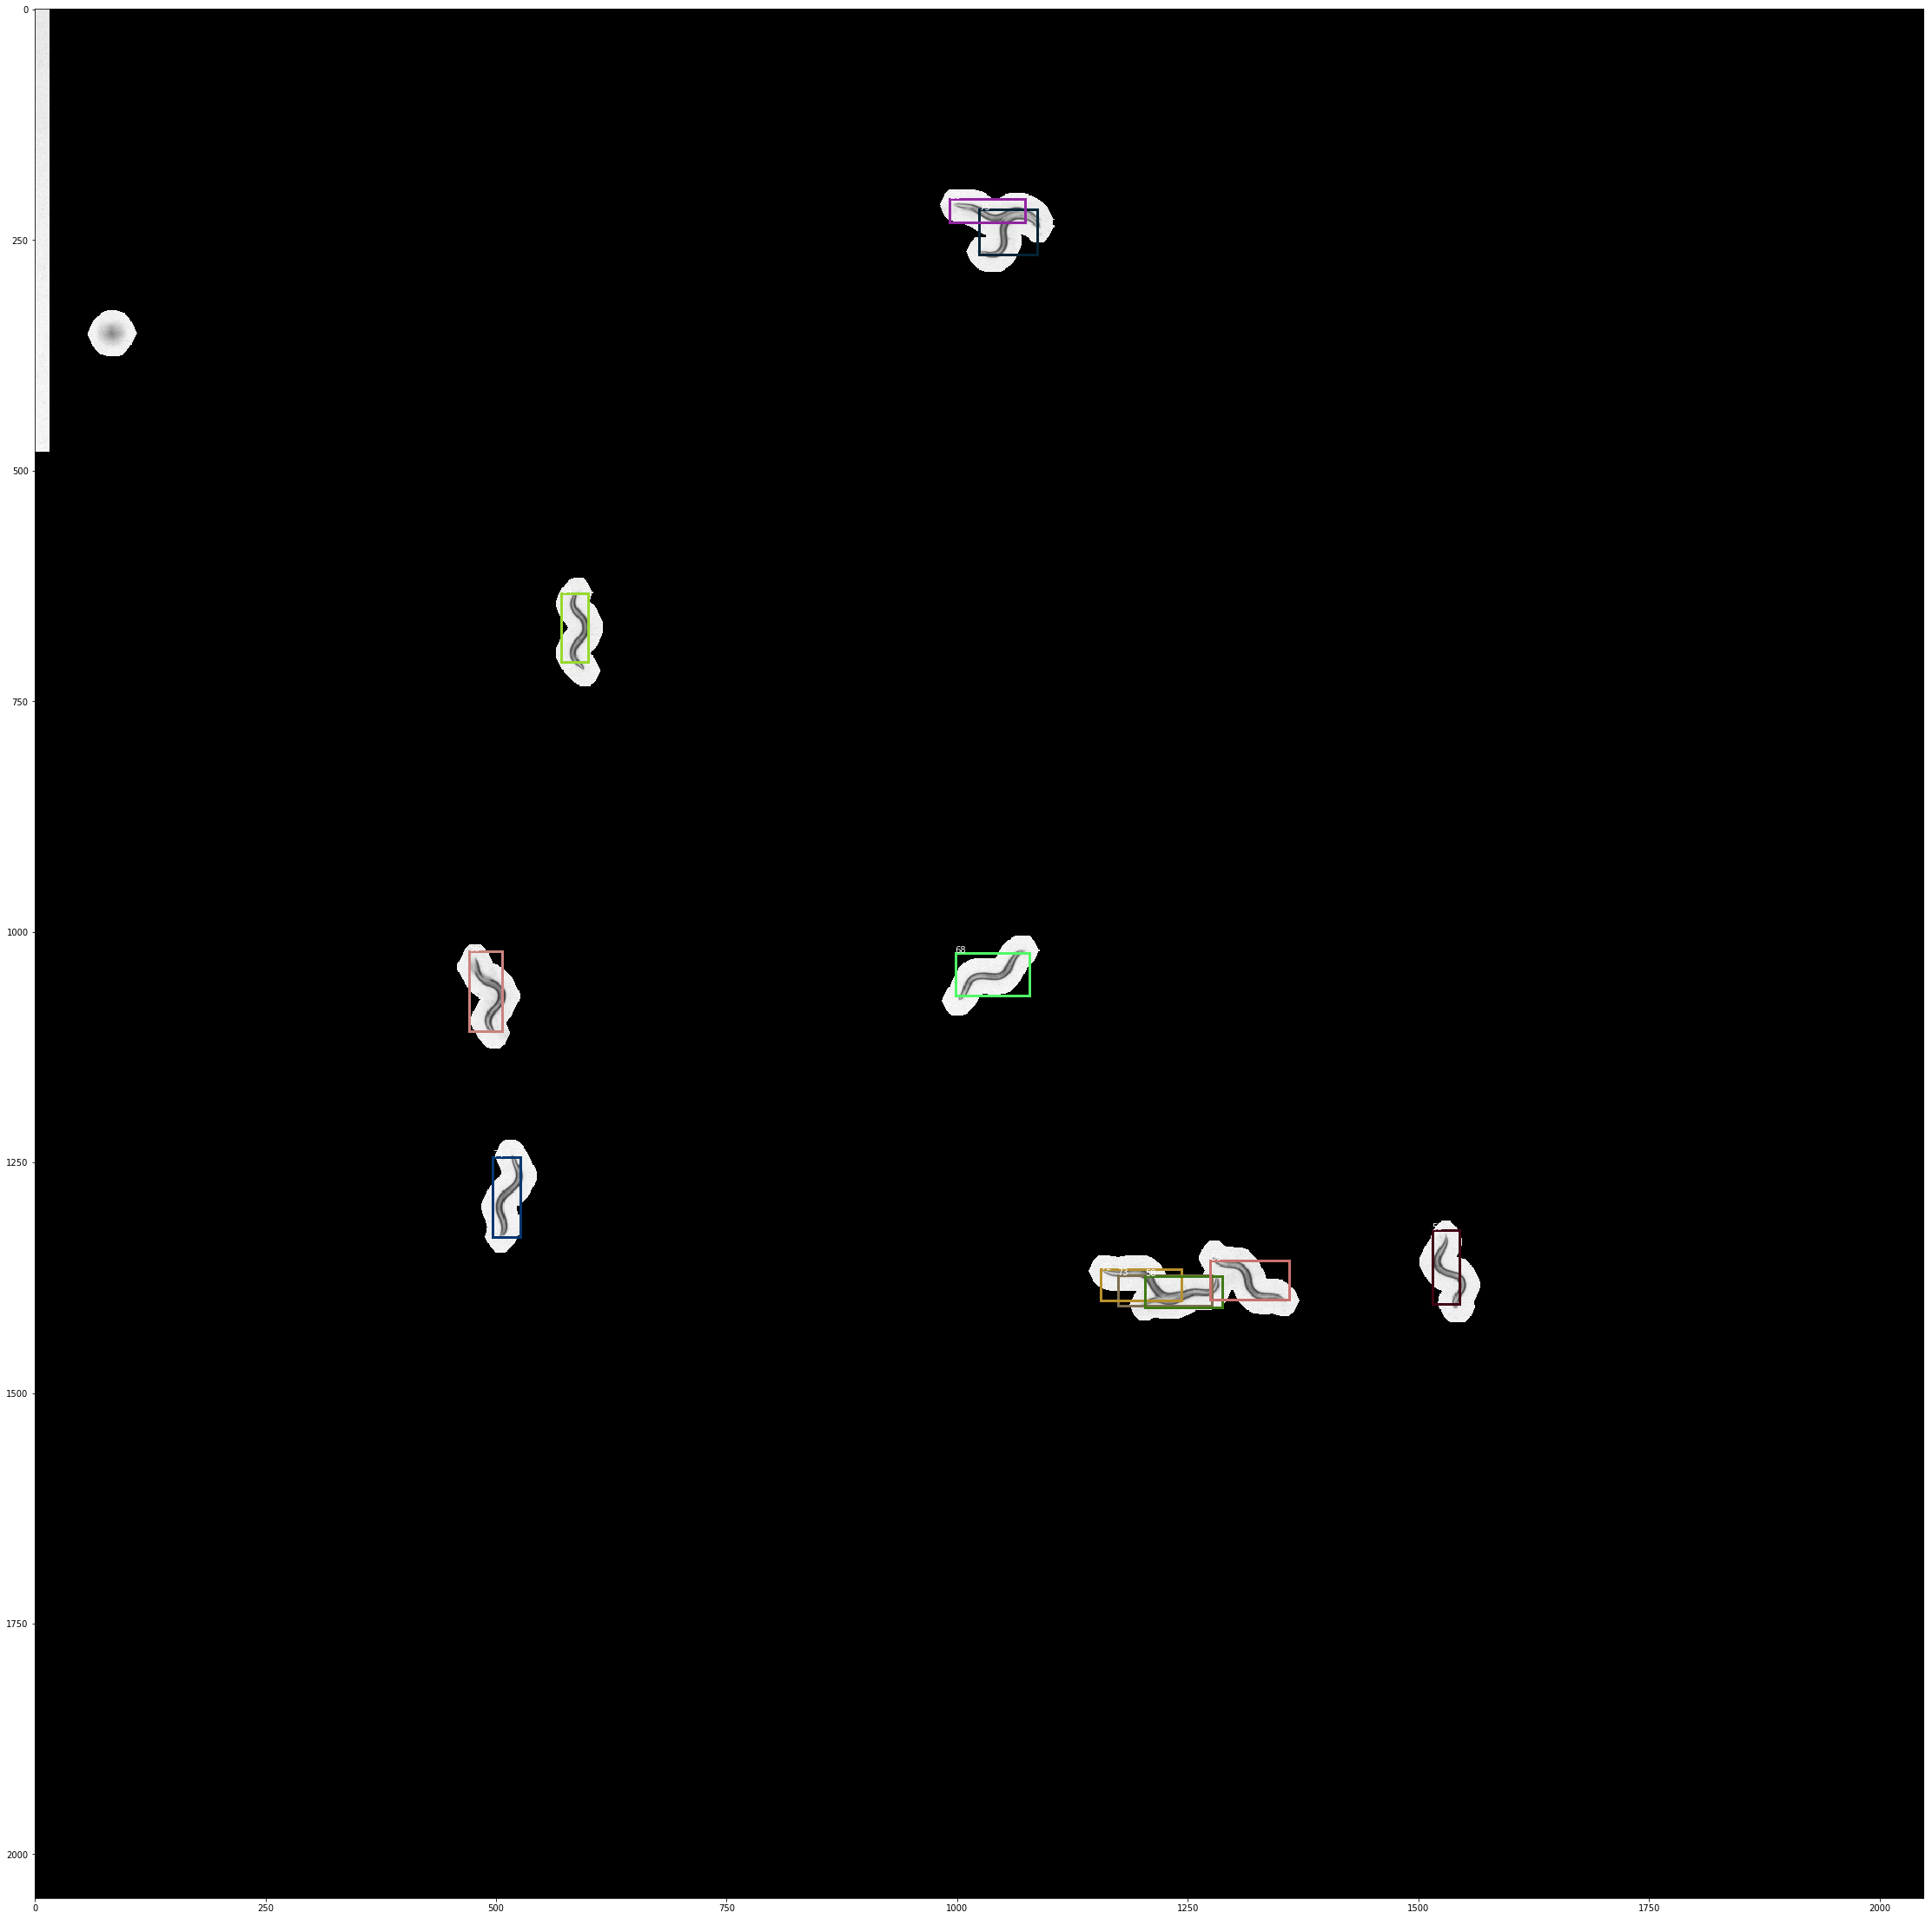

Worm IDs: [28.0, 55.0, 56.0, 58.0, 64.0, 68.0, 72.0, 75.0, 76.0, 77.0]


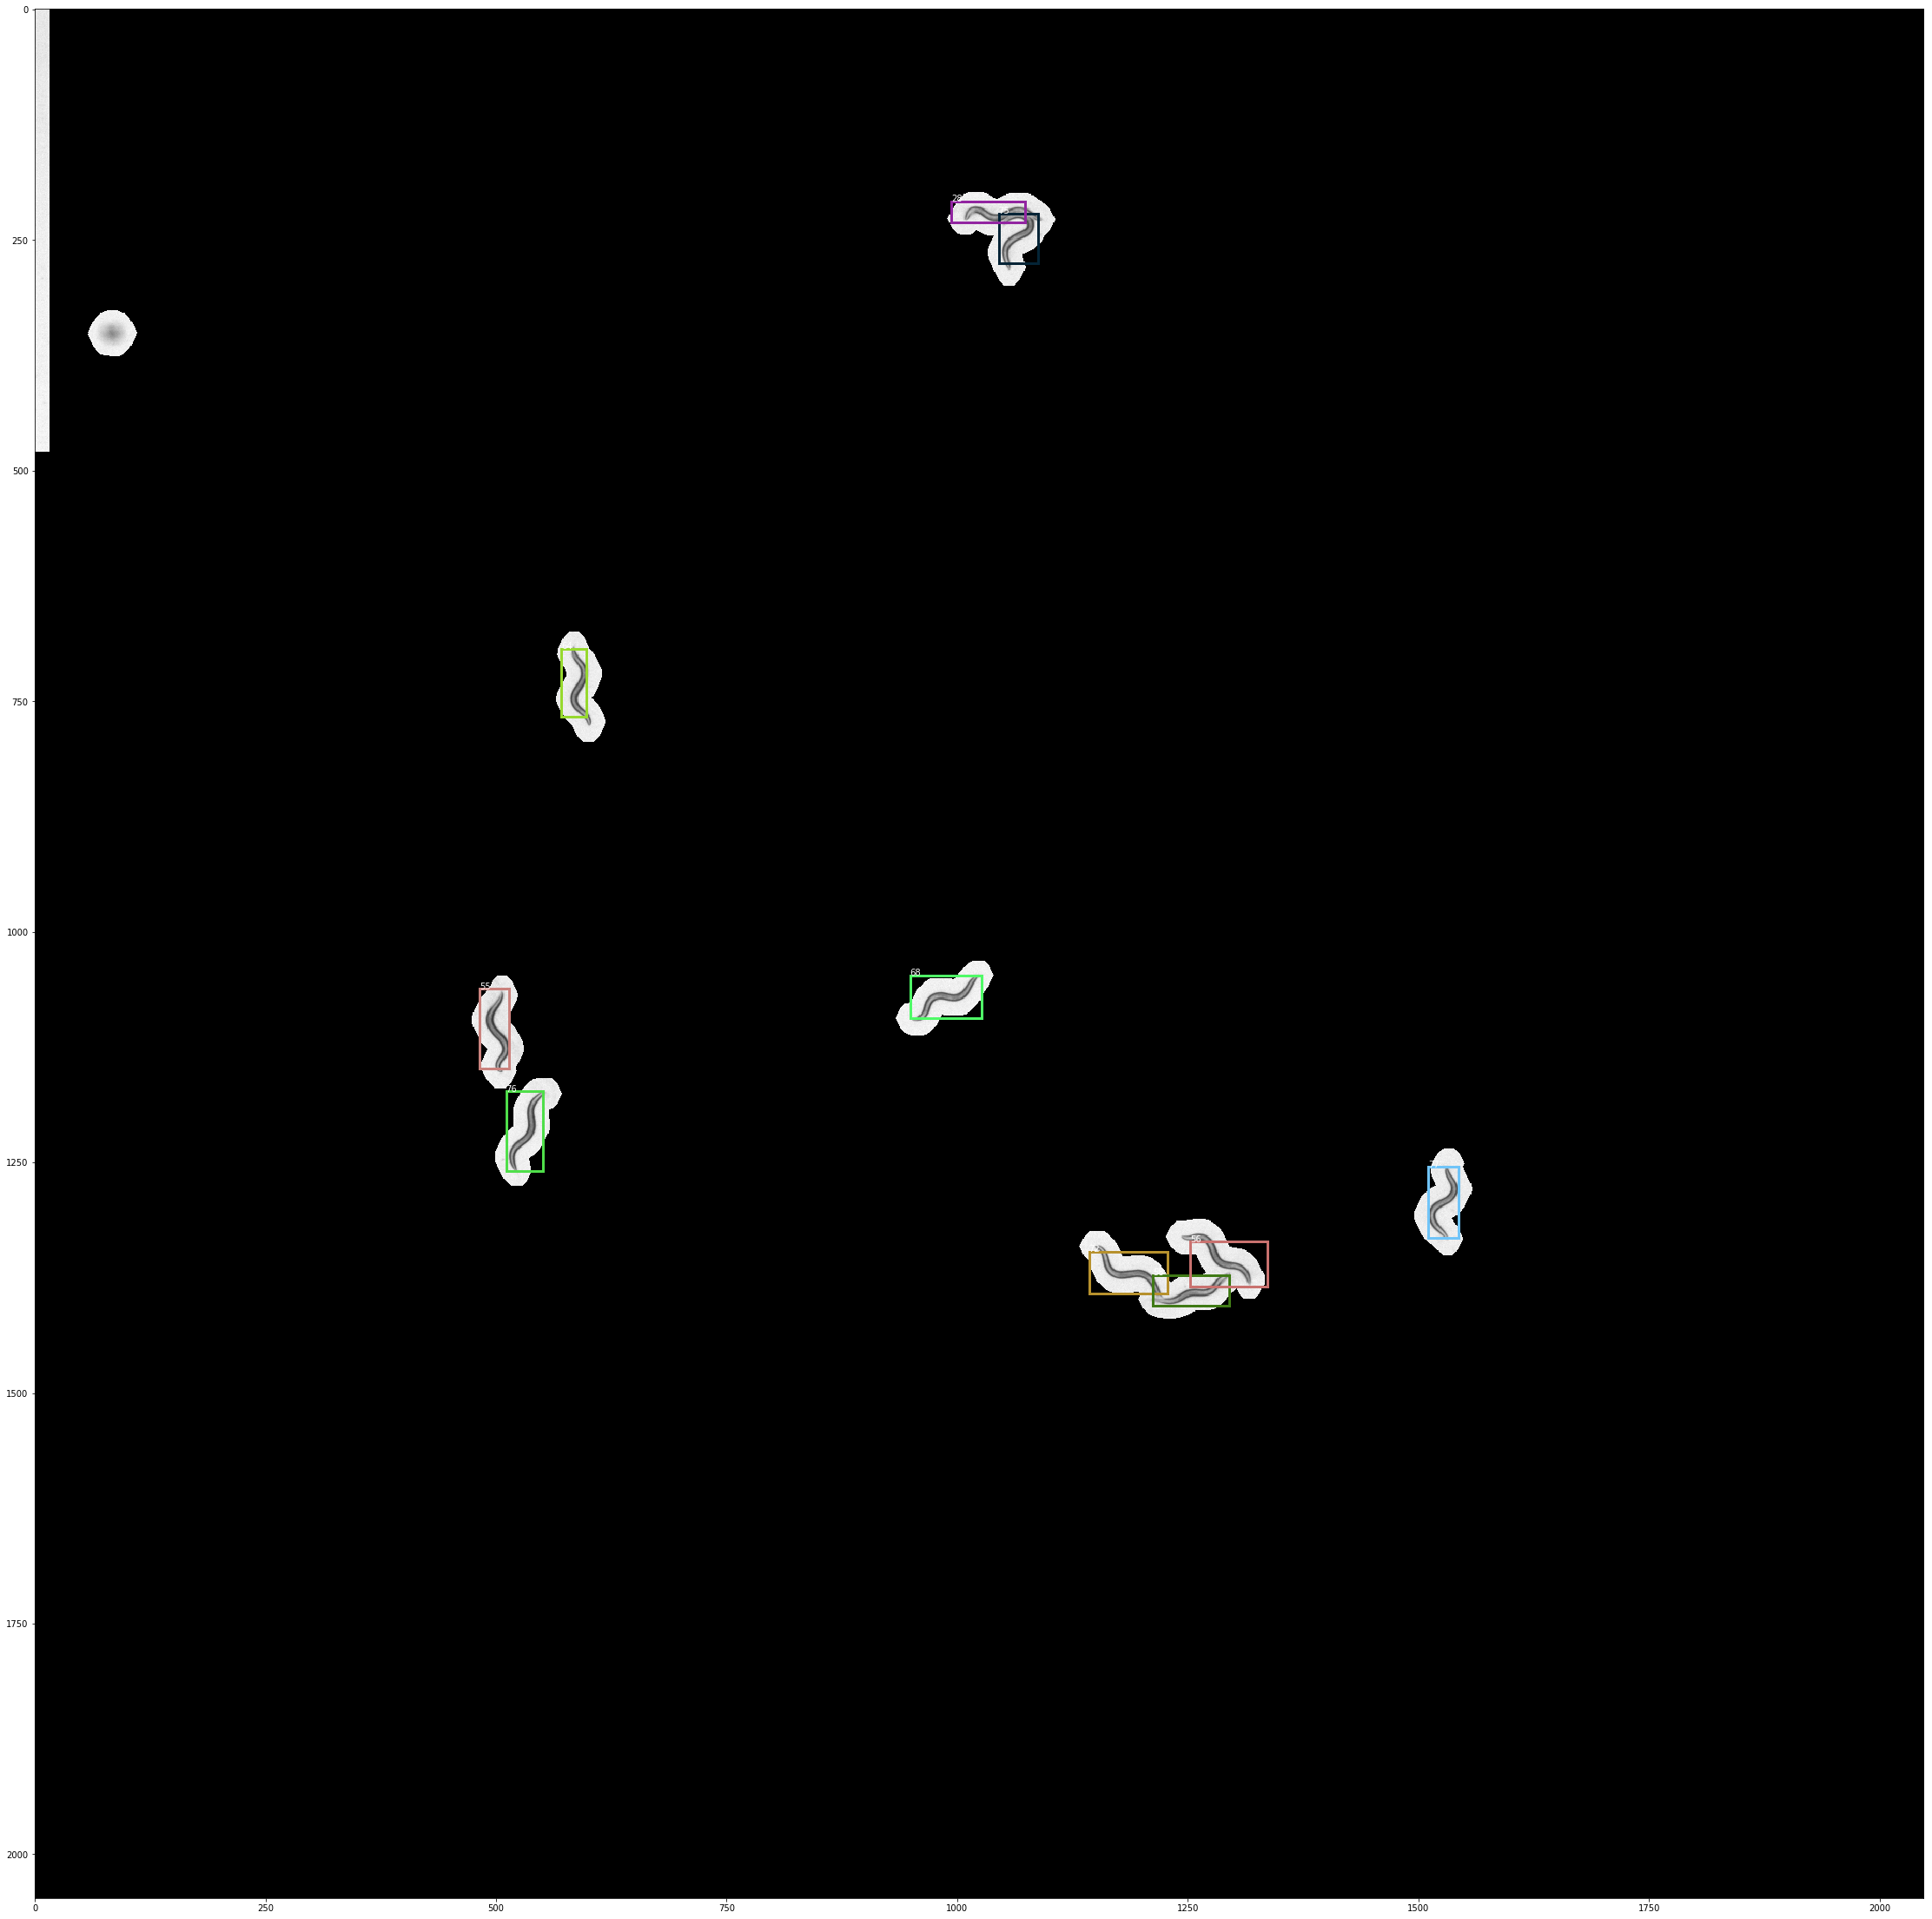

Worm IDs: [28.0, 55.0, 56.0, 58.0, 68.0, 72.0, 76.0, 77.0, 78.0, 79.0]


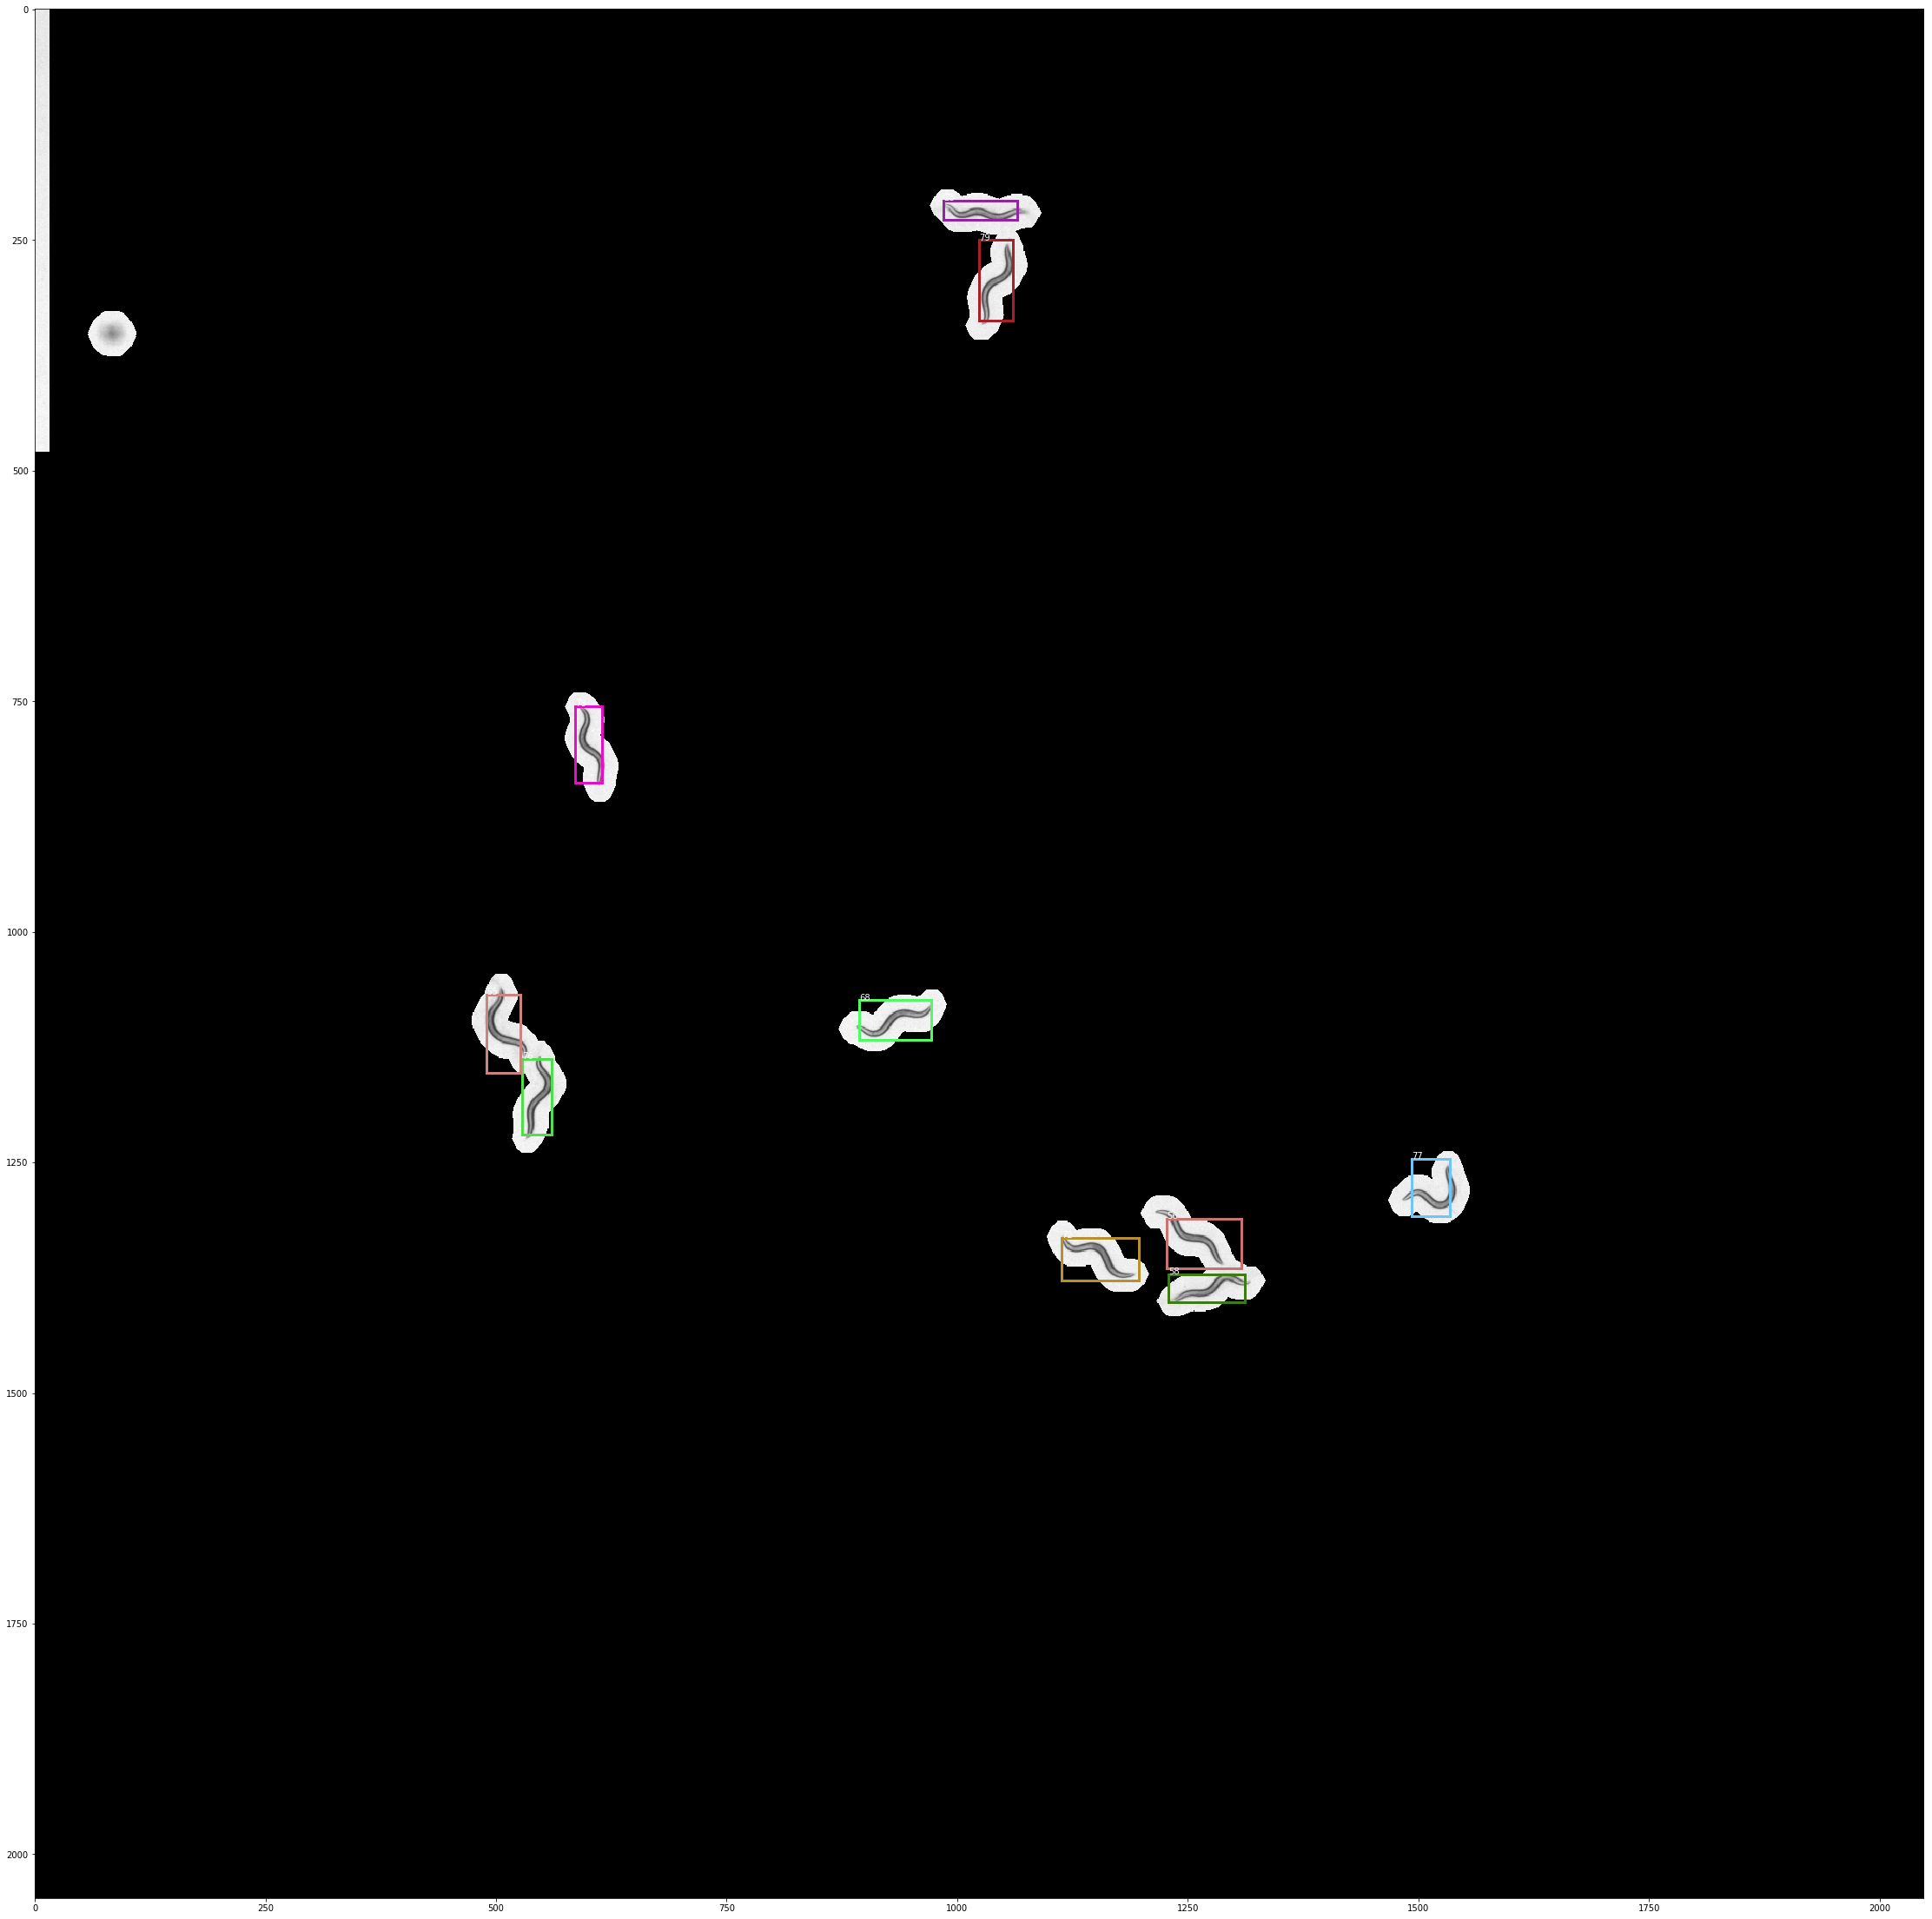

Worm IDs: [28.0, 55.0, 58.0, 68.0, 72.0, 76.0, 77.0, 80.0, 81.0, 82.0]


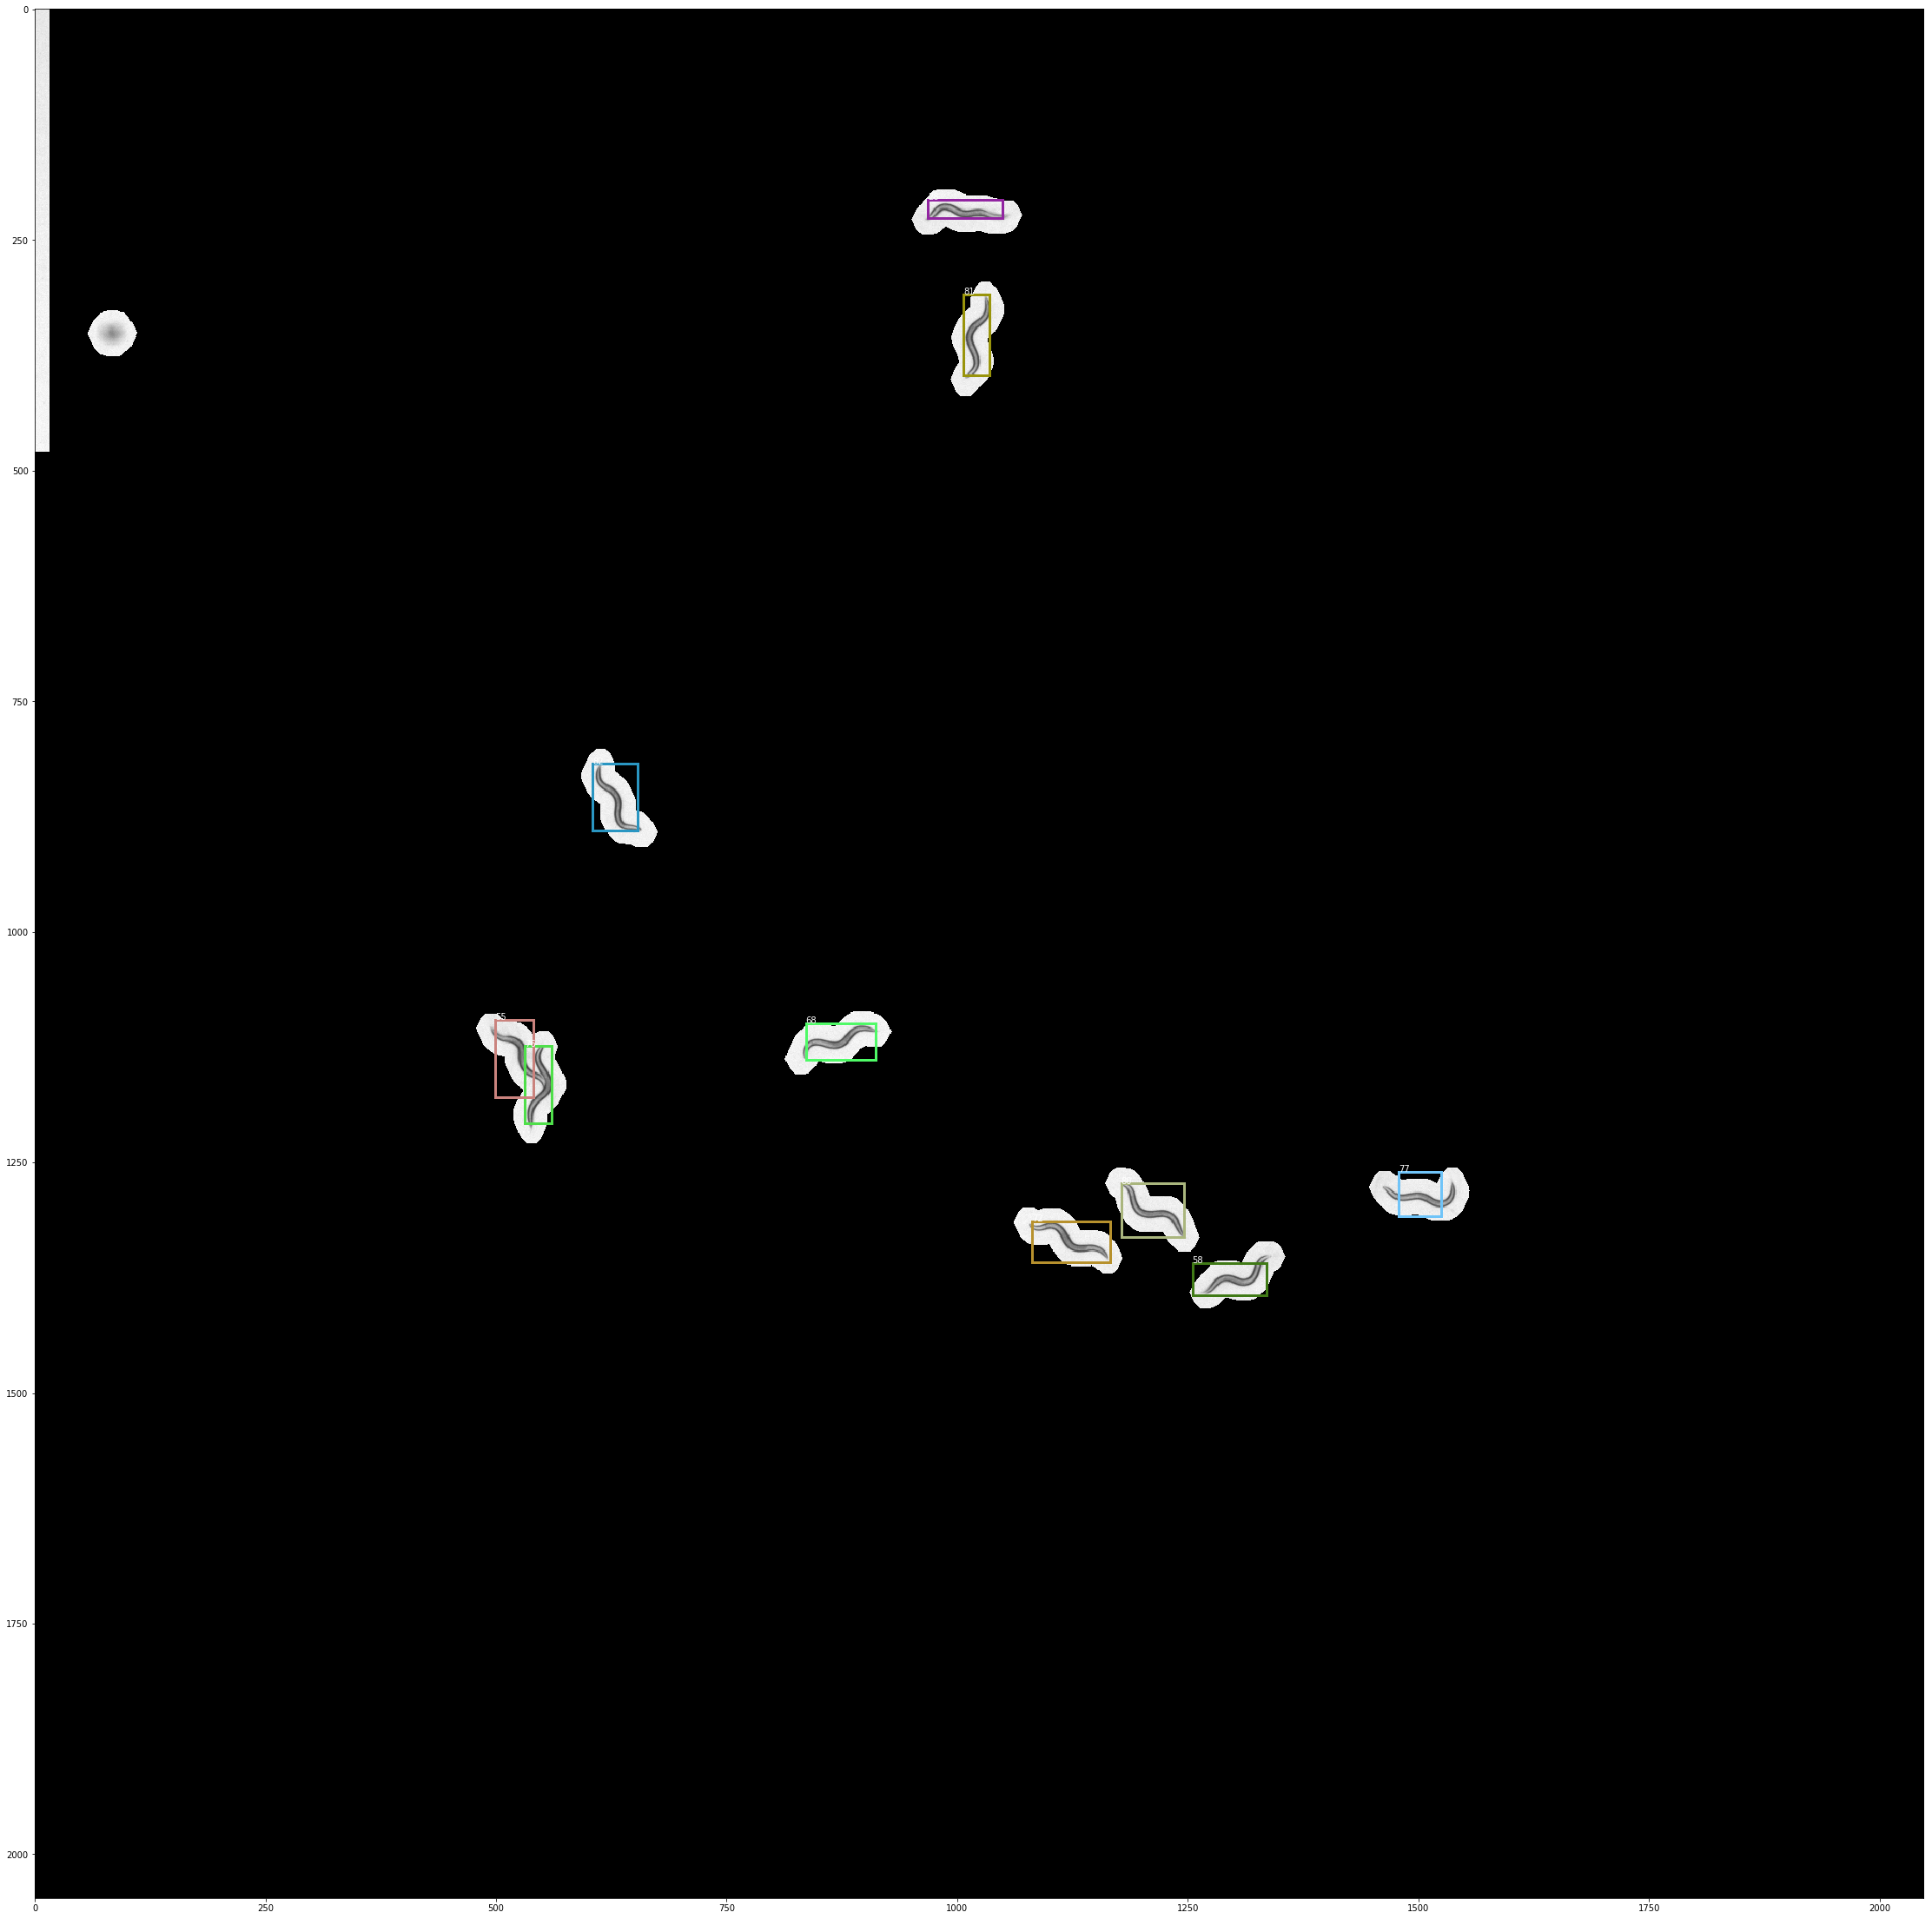

Worm IDs: [28.0, 55.0, 76.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0]


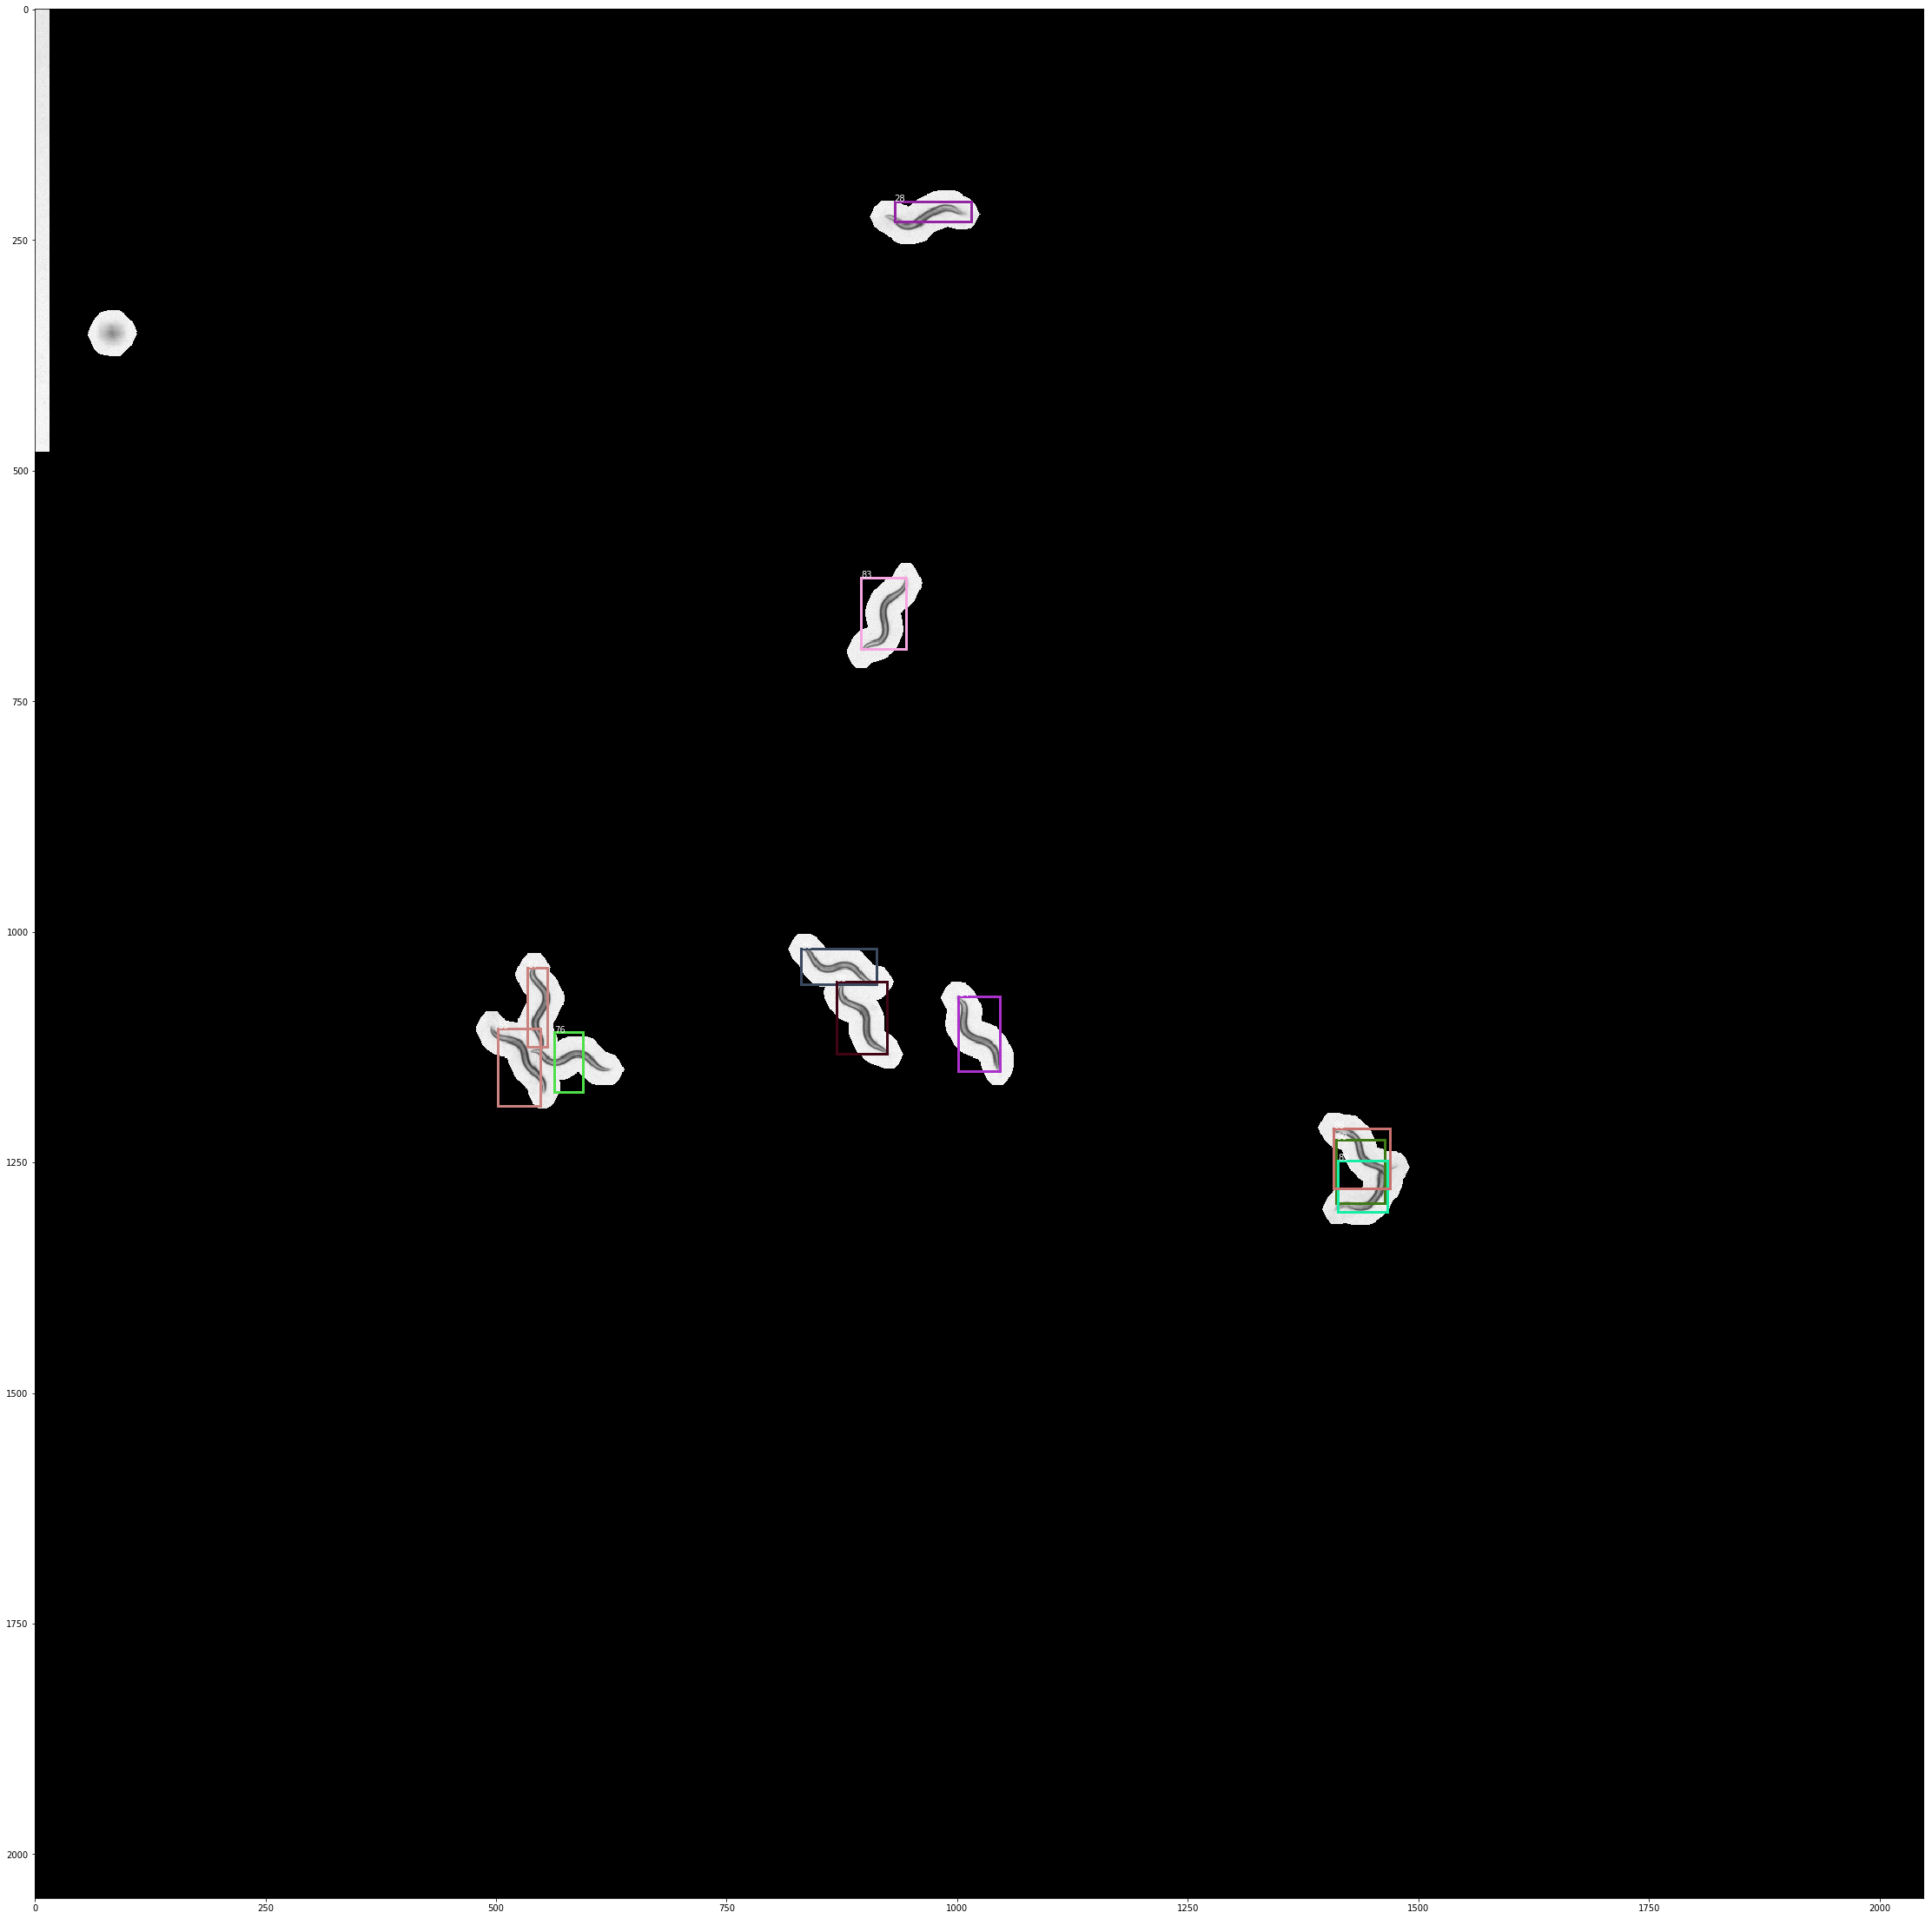

Worm IDs: [28.0, 55.0, 76.0, 86.0, 87.0, 88.0, 89.0, 91.0, 92.0, 93.0]


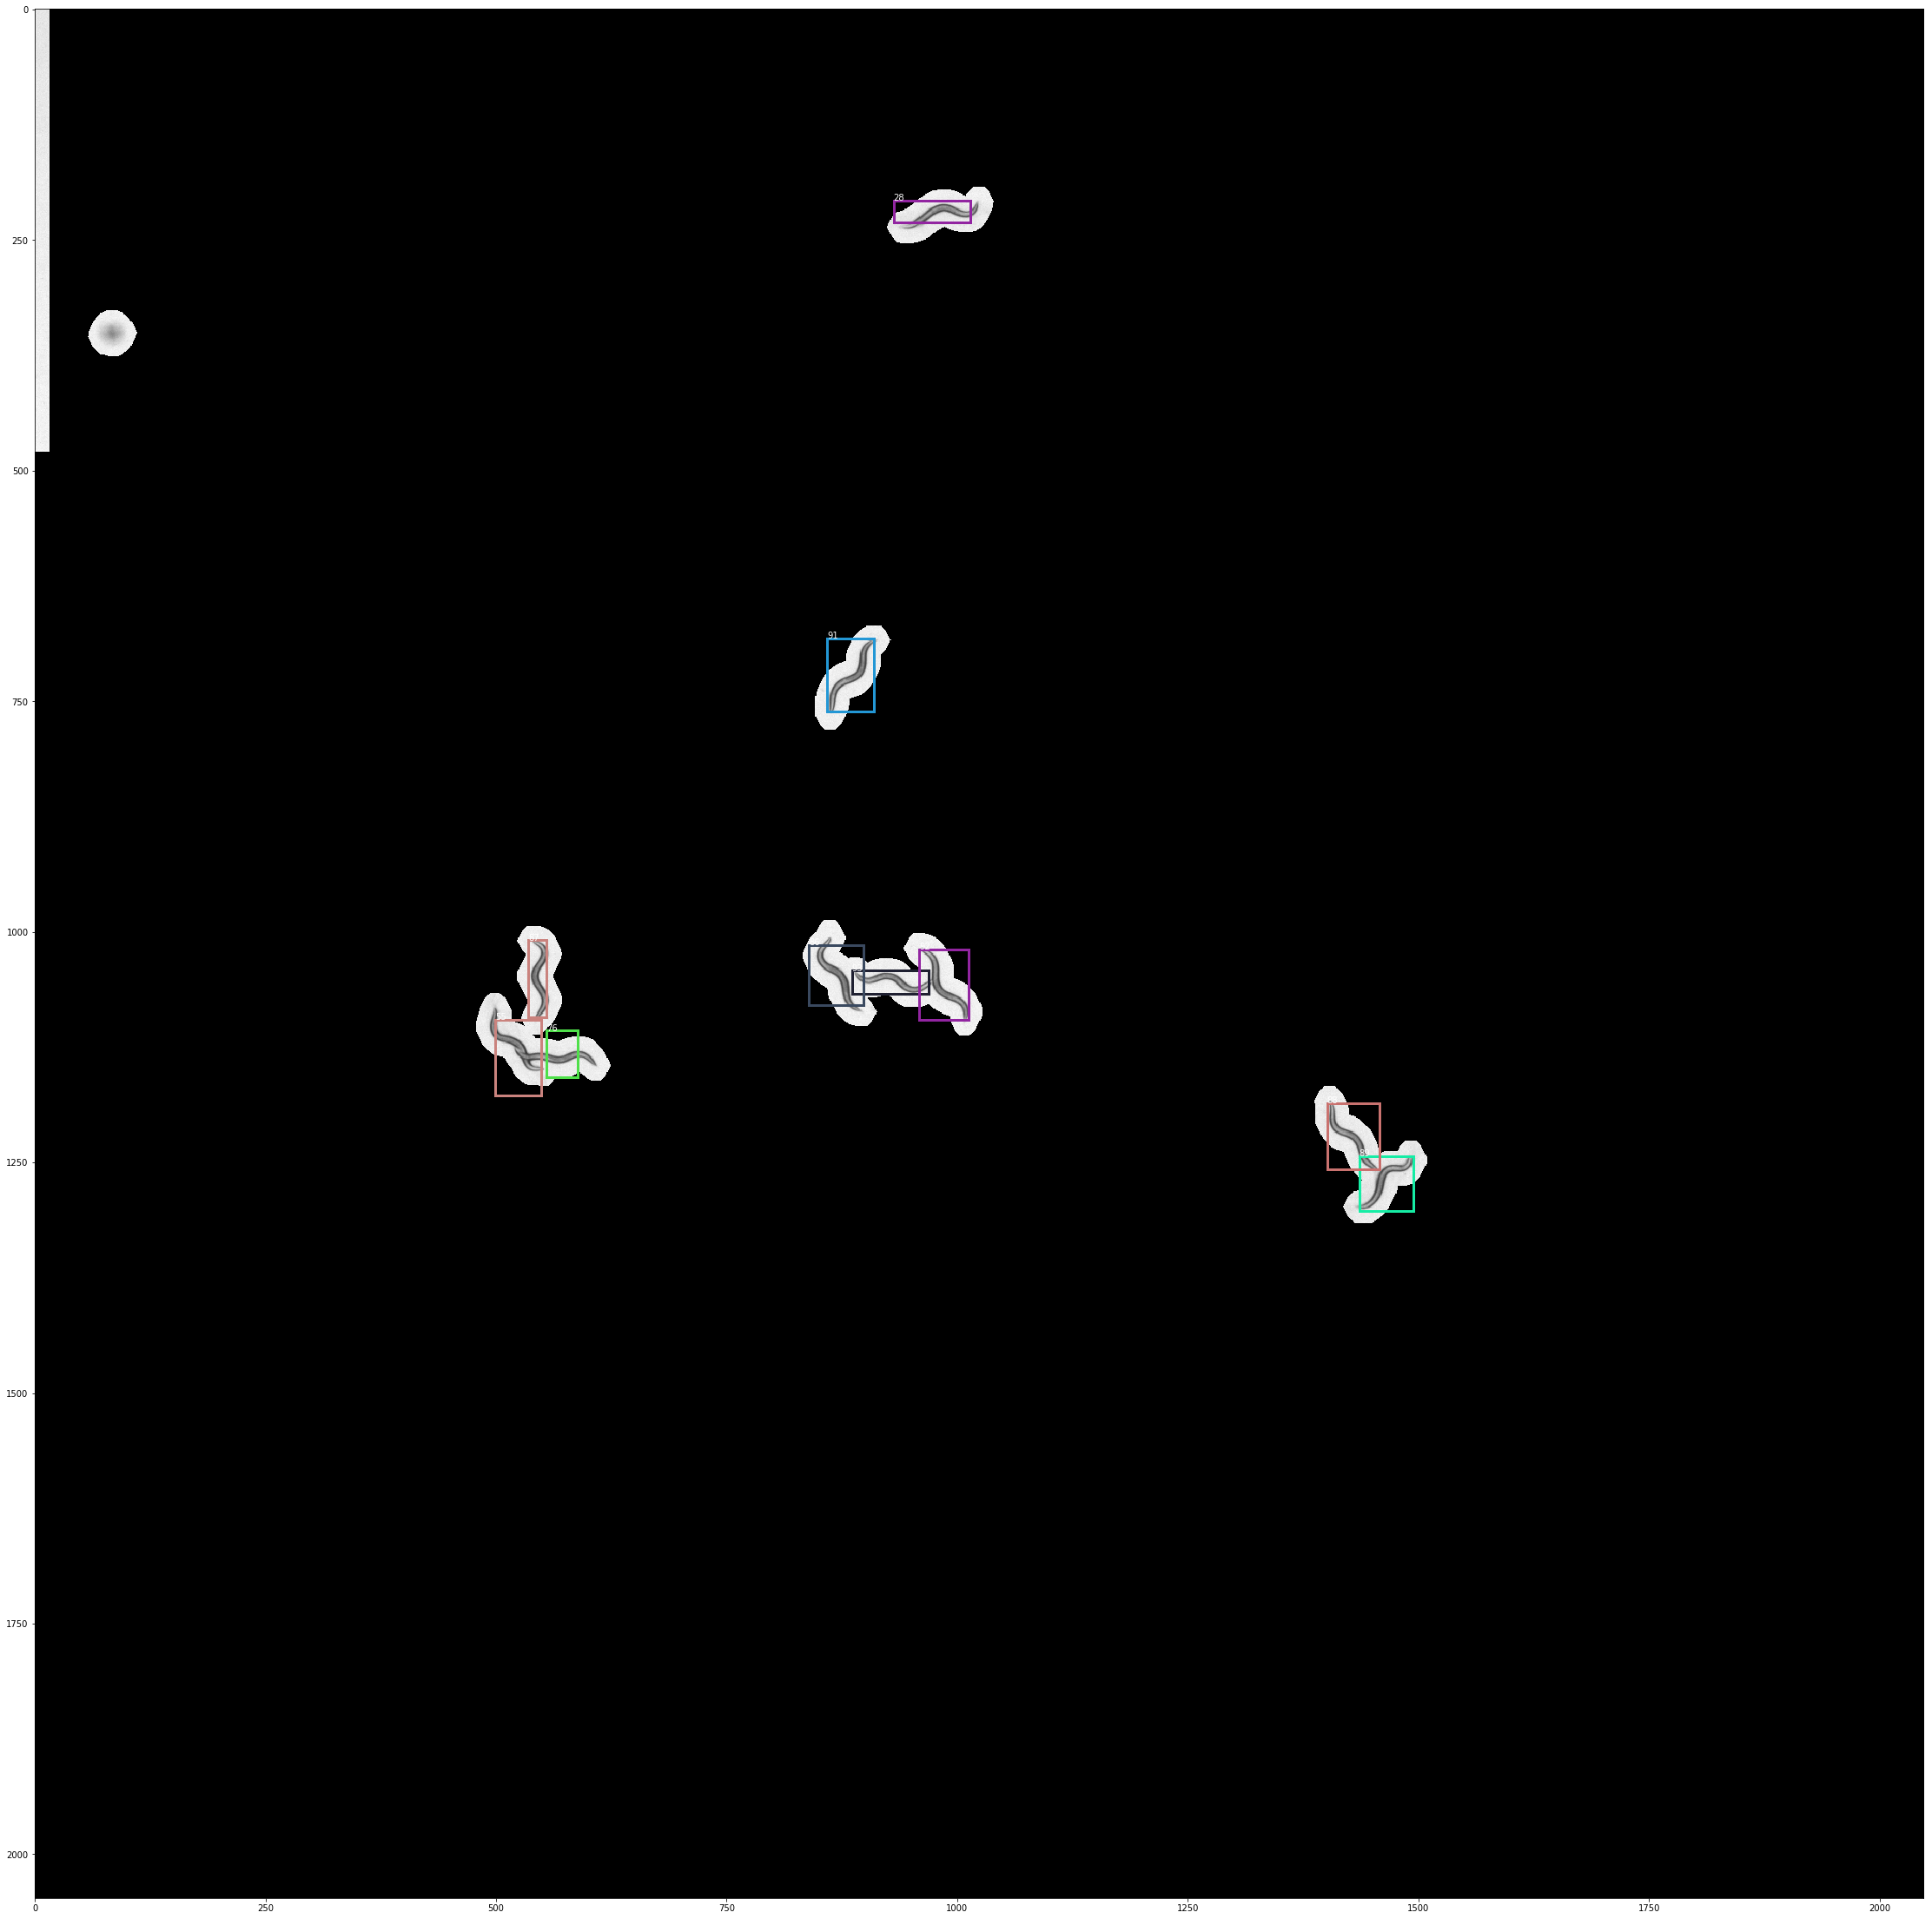

Worm IDs: [28.0, 55.0, 87.0, 88.0, 89.0, 92.0, 94.0, 95.0, 96.0, 97.0]


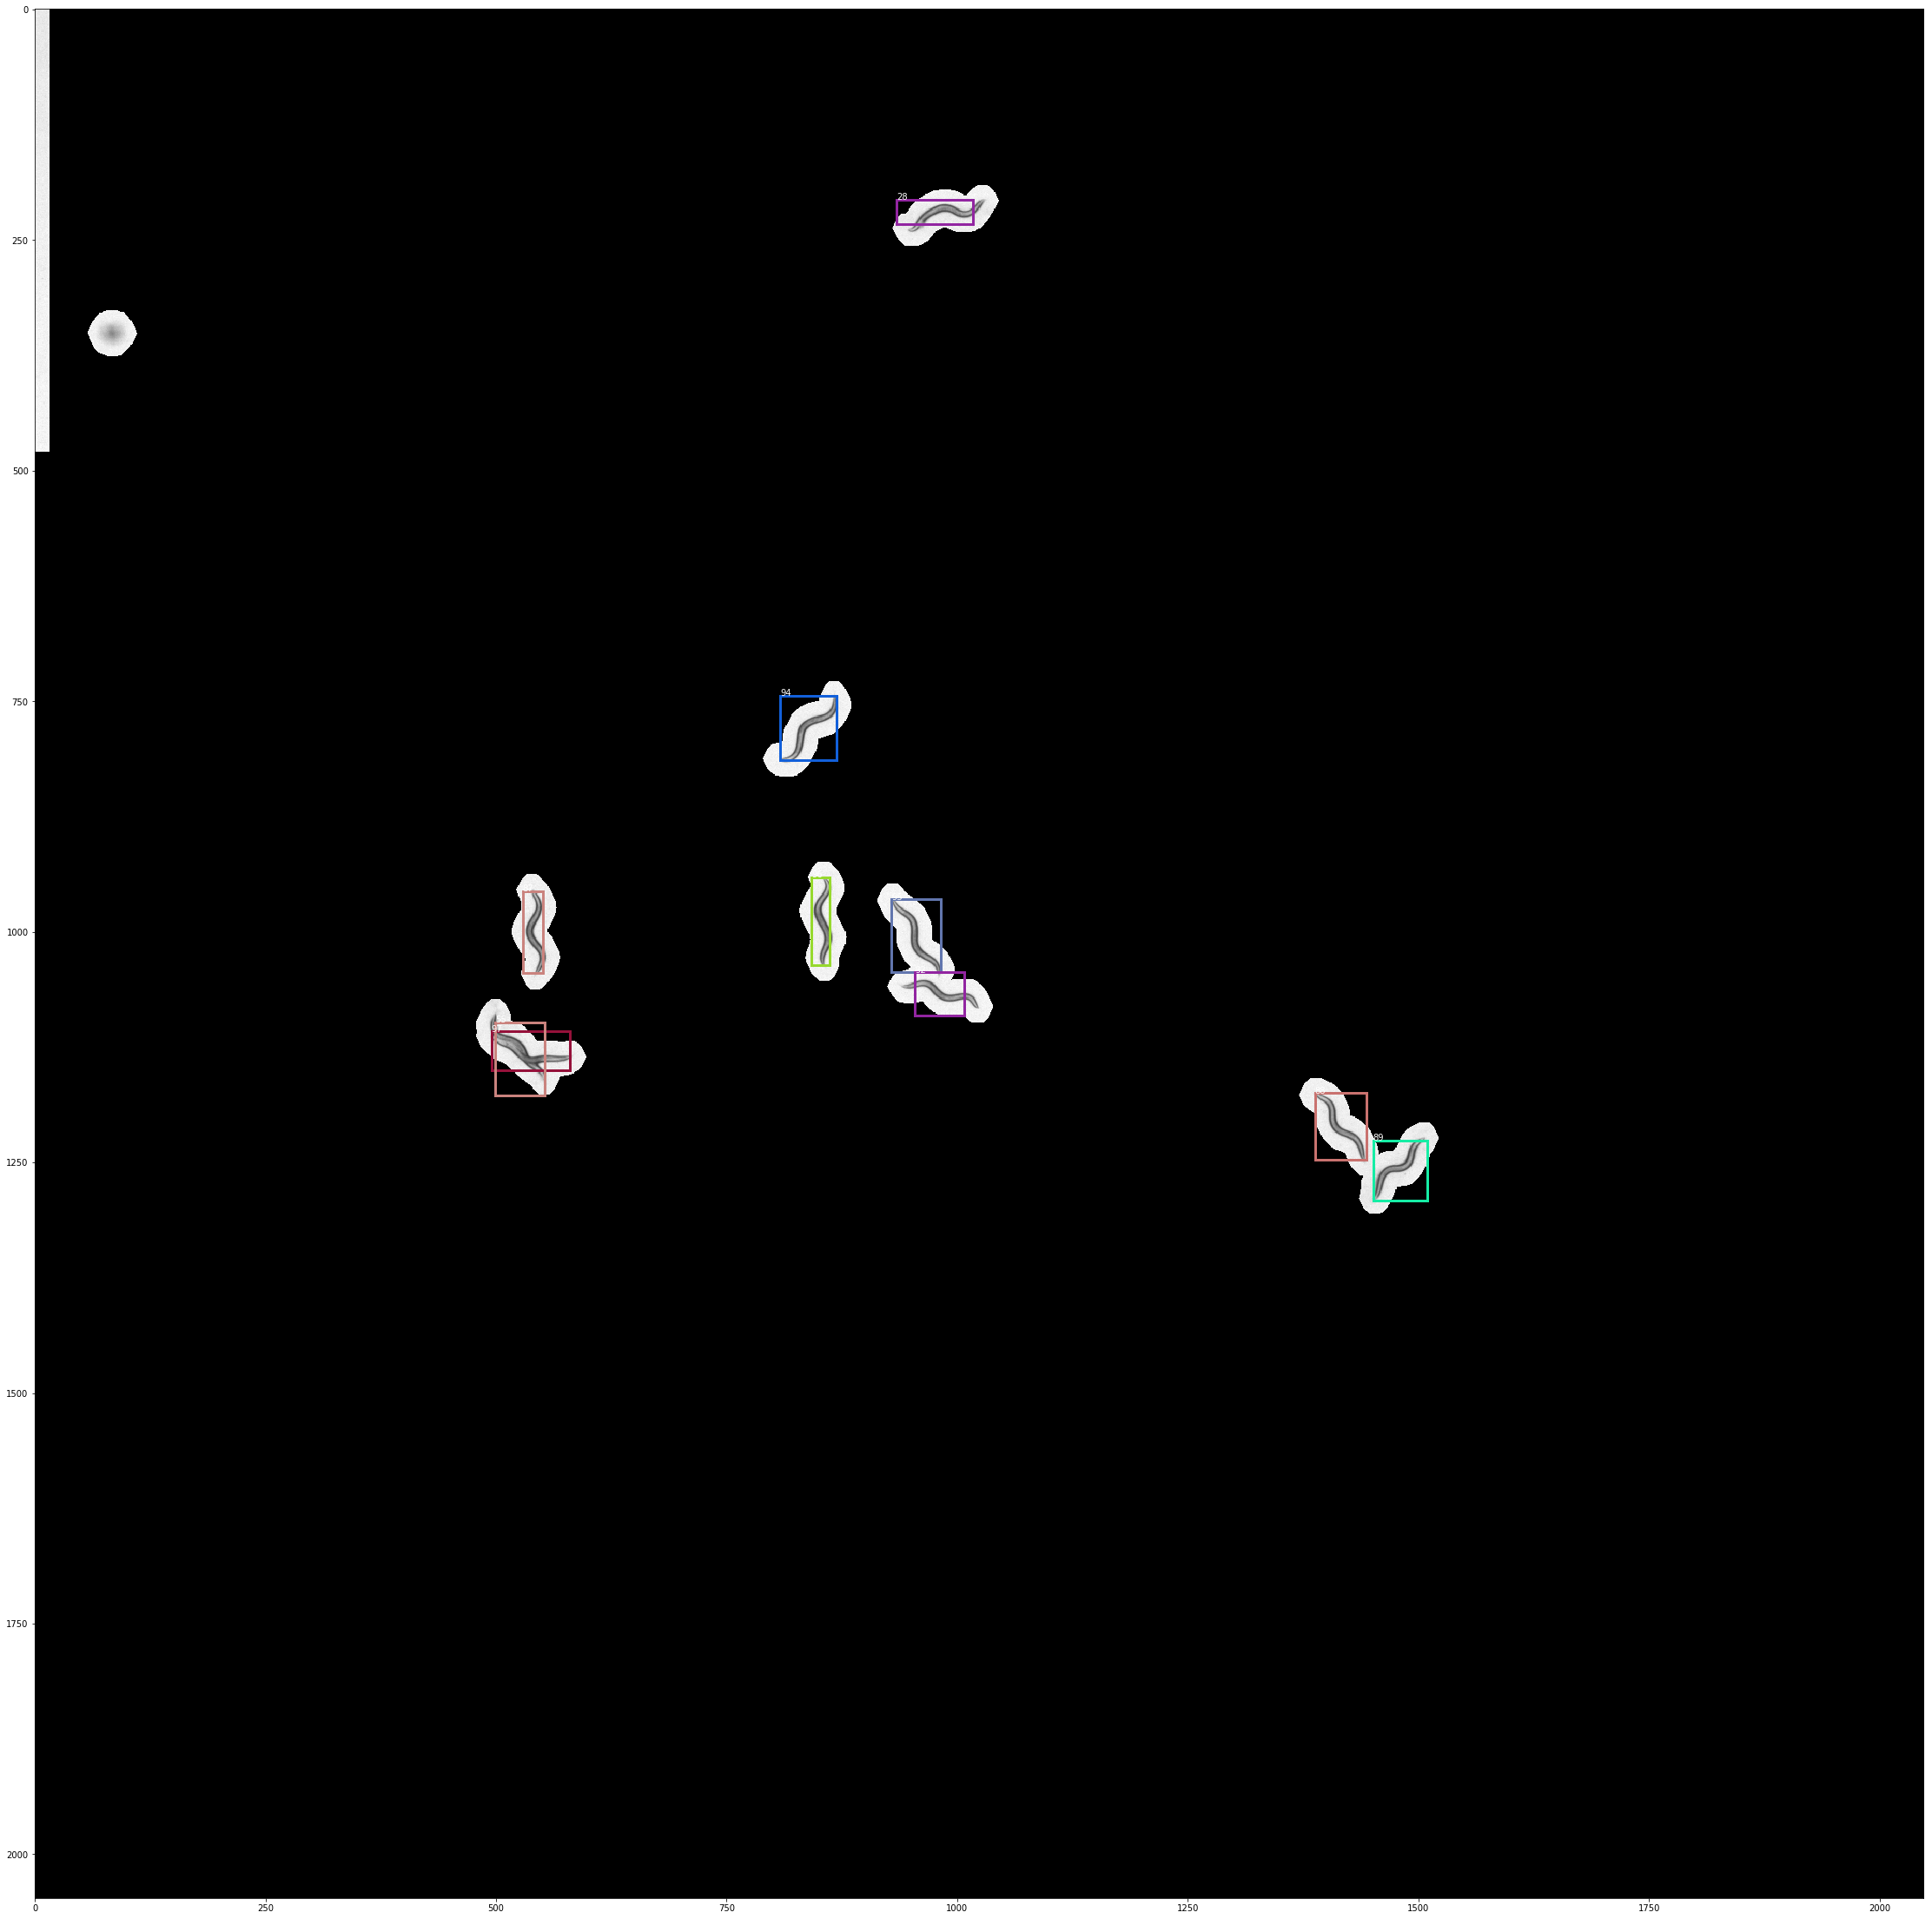

Worm IDs: [28.0, 55.0, 84.0, 87.0, 88.0, 89.0, 96.0, 97.0, 98.0, 99.0]


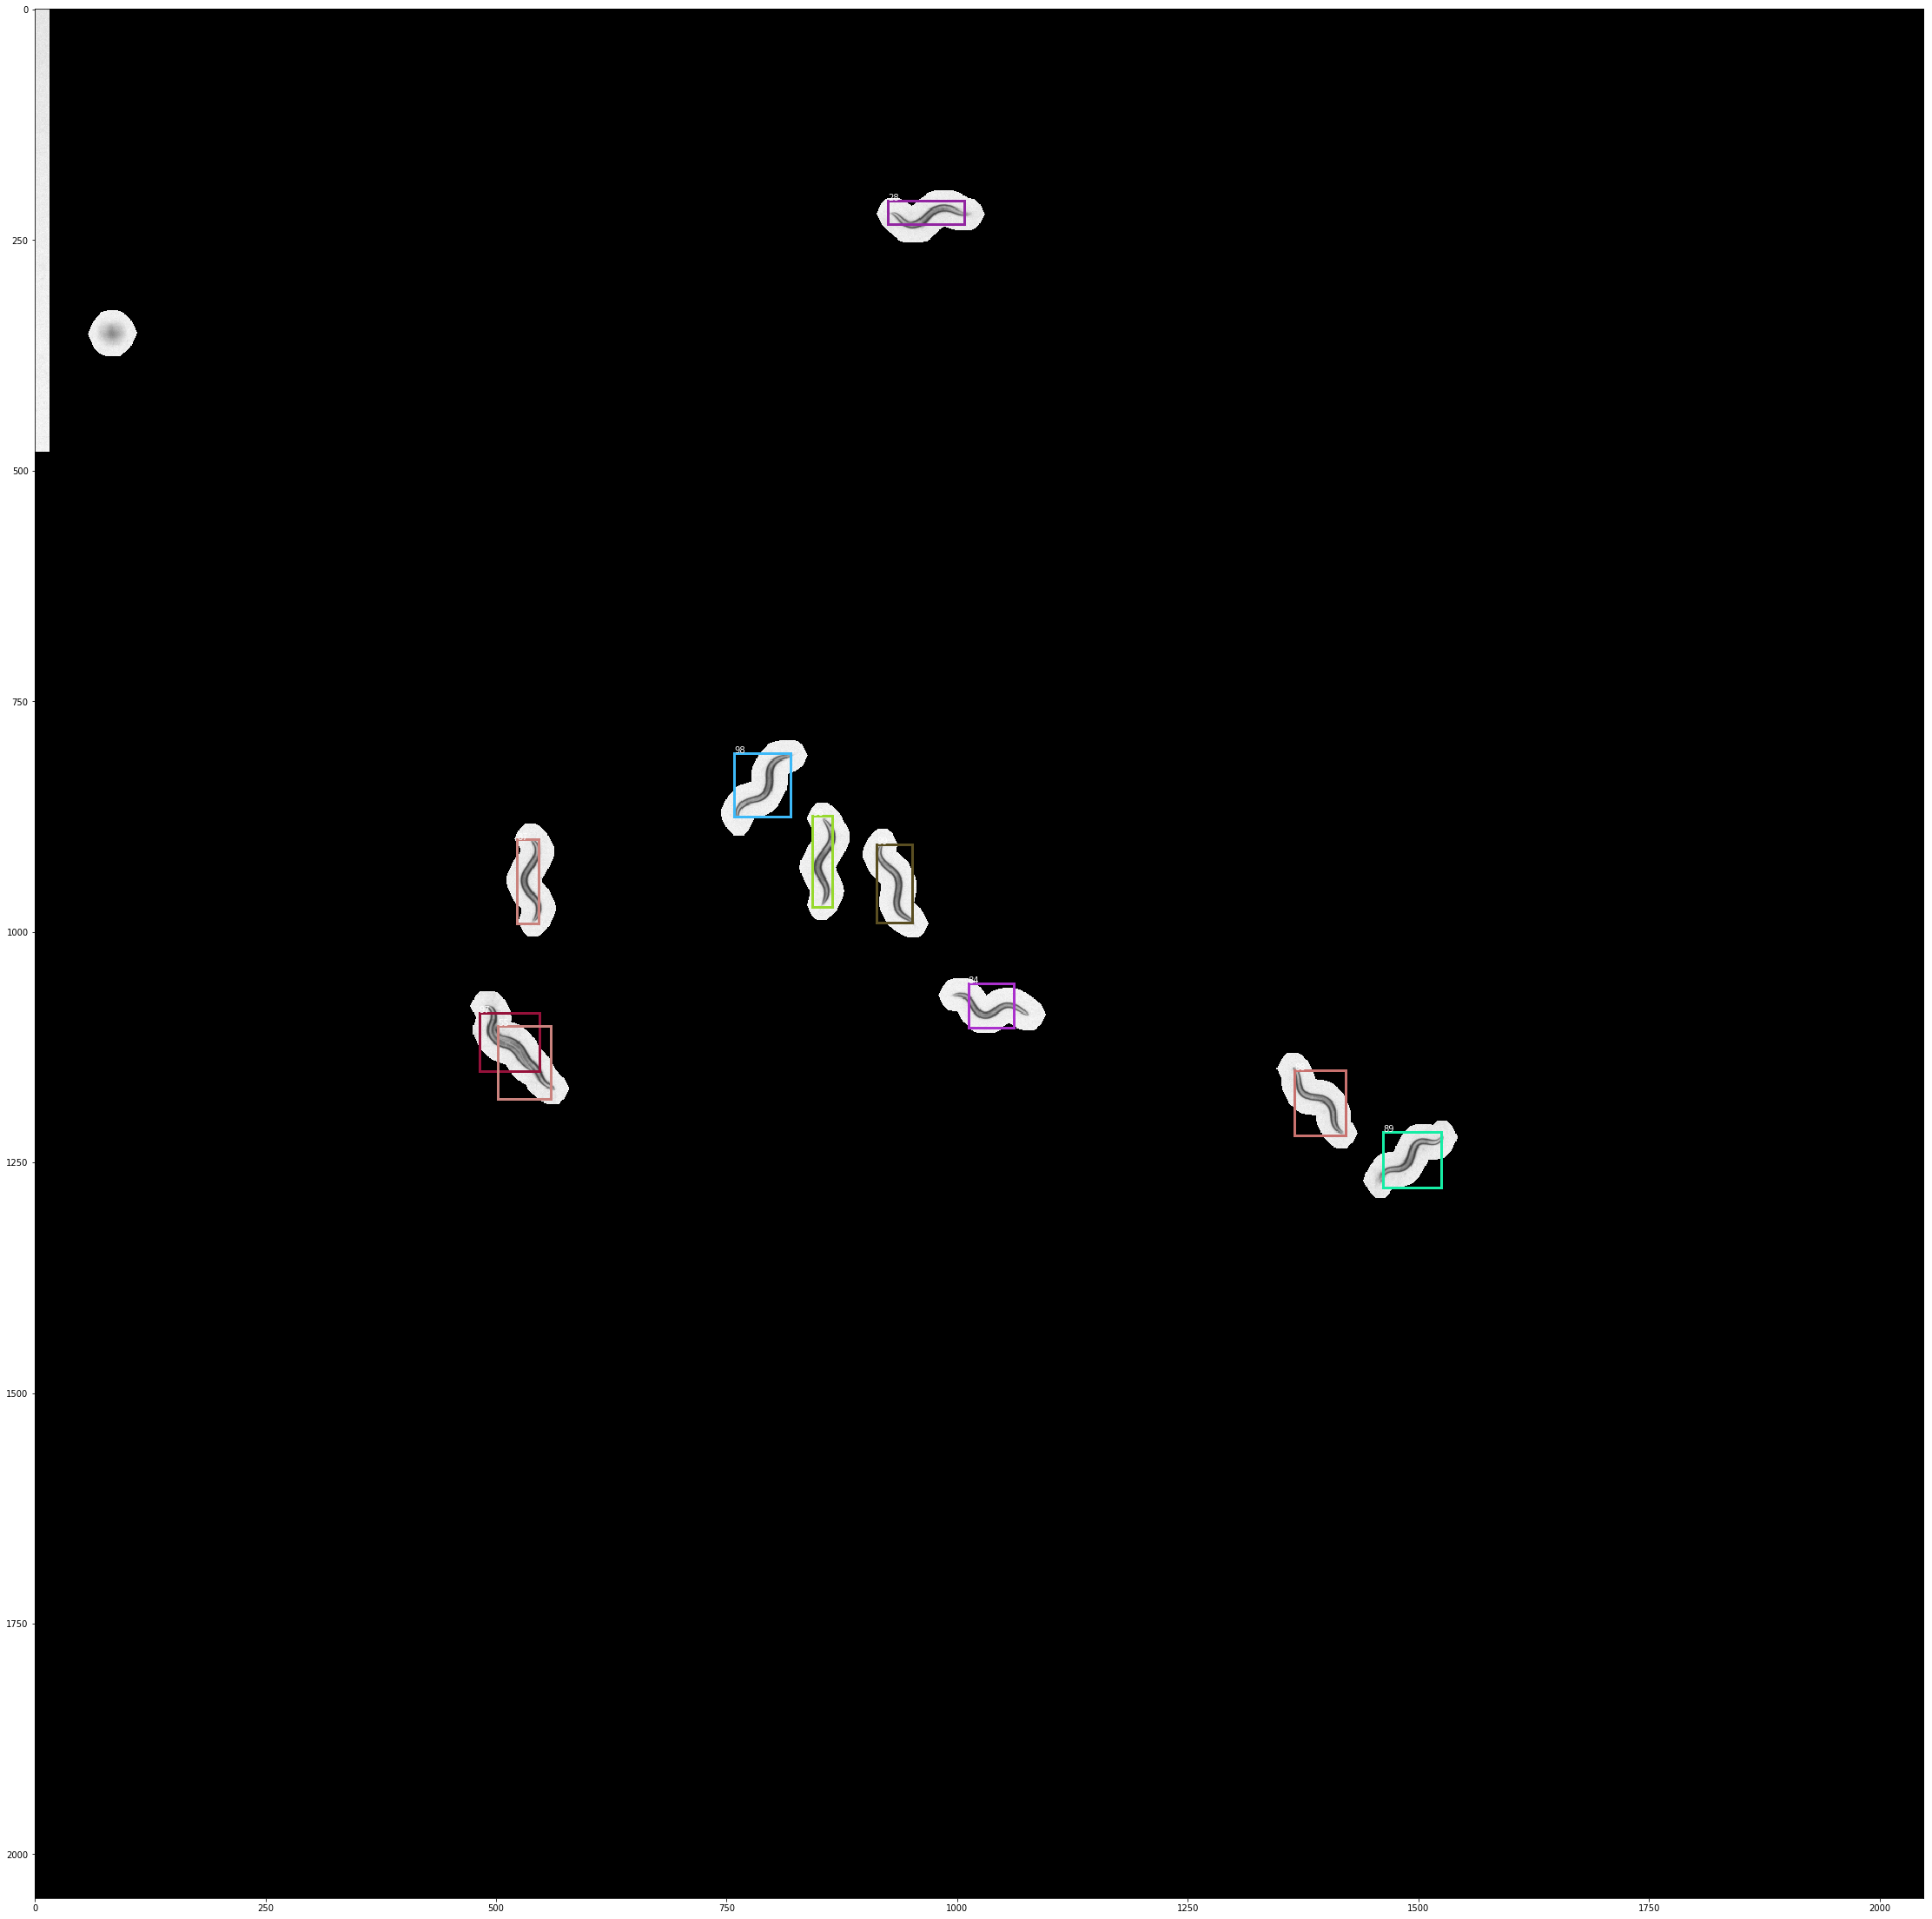

Worm IDs: [28.0, 55.0, 87.0, 88.0, 90.0, 96.0, 97.0, 99.0, 100.0, 101.0]


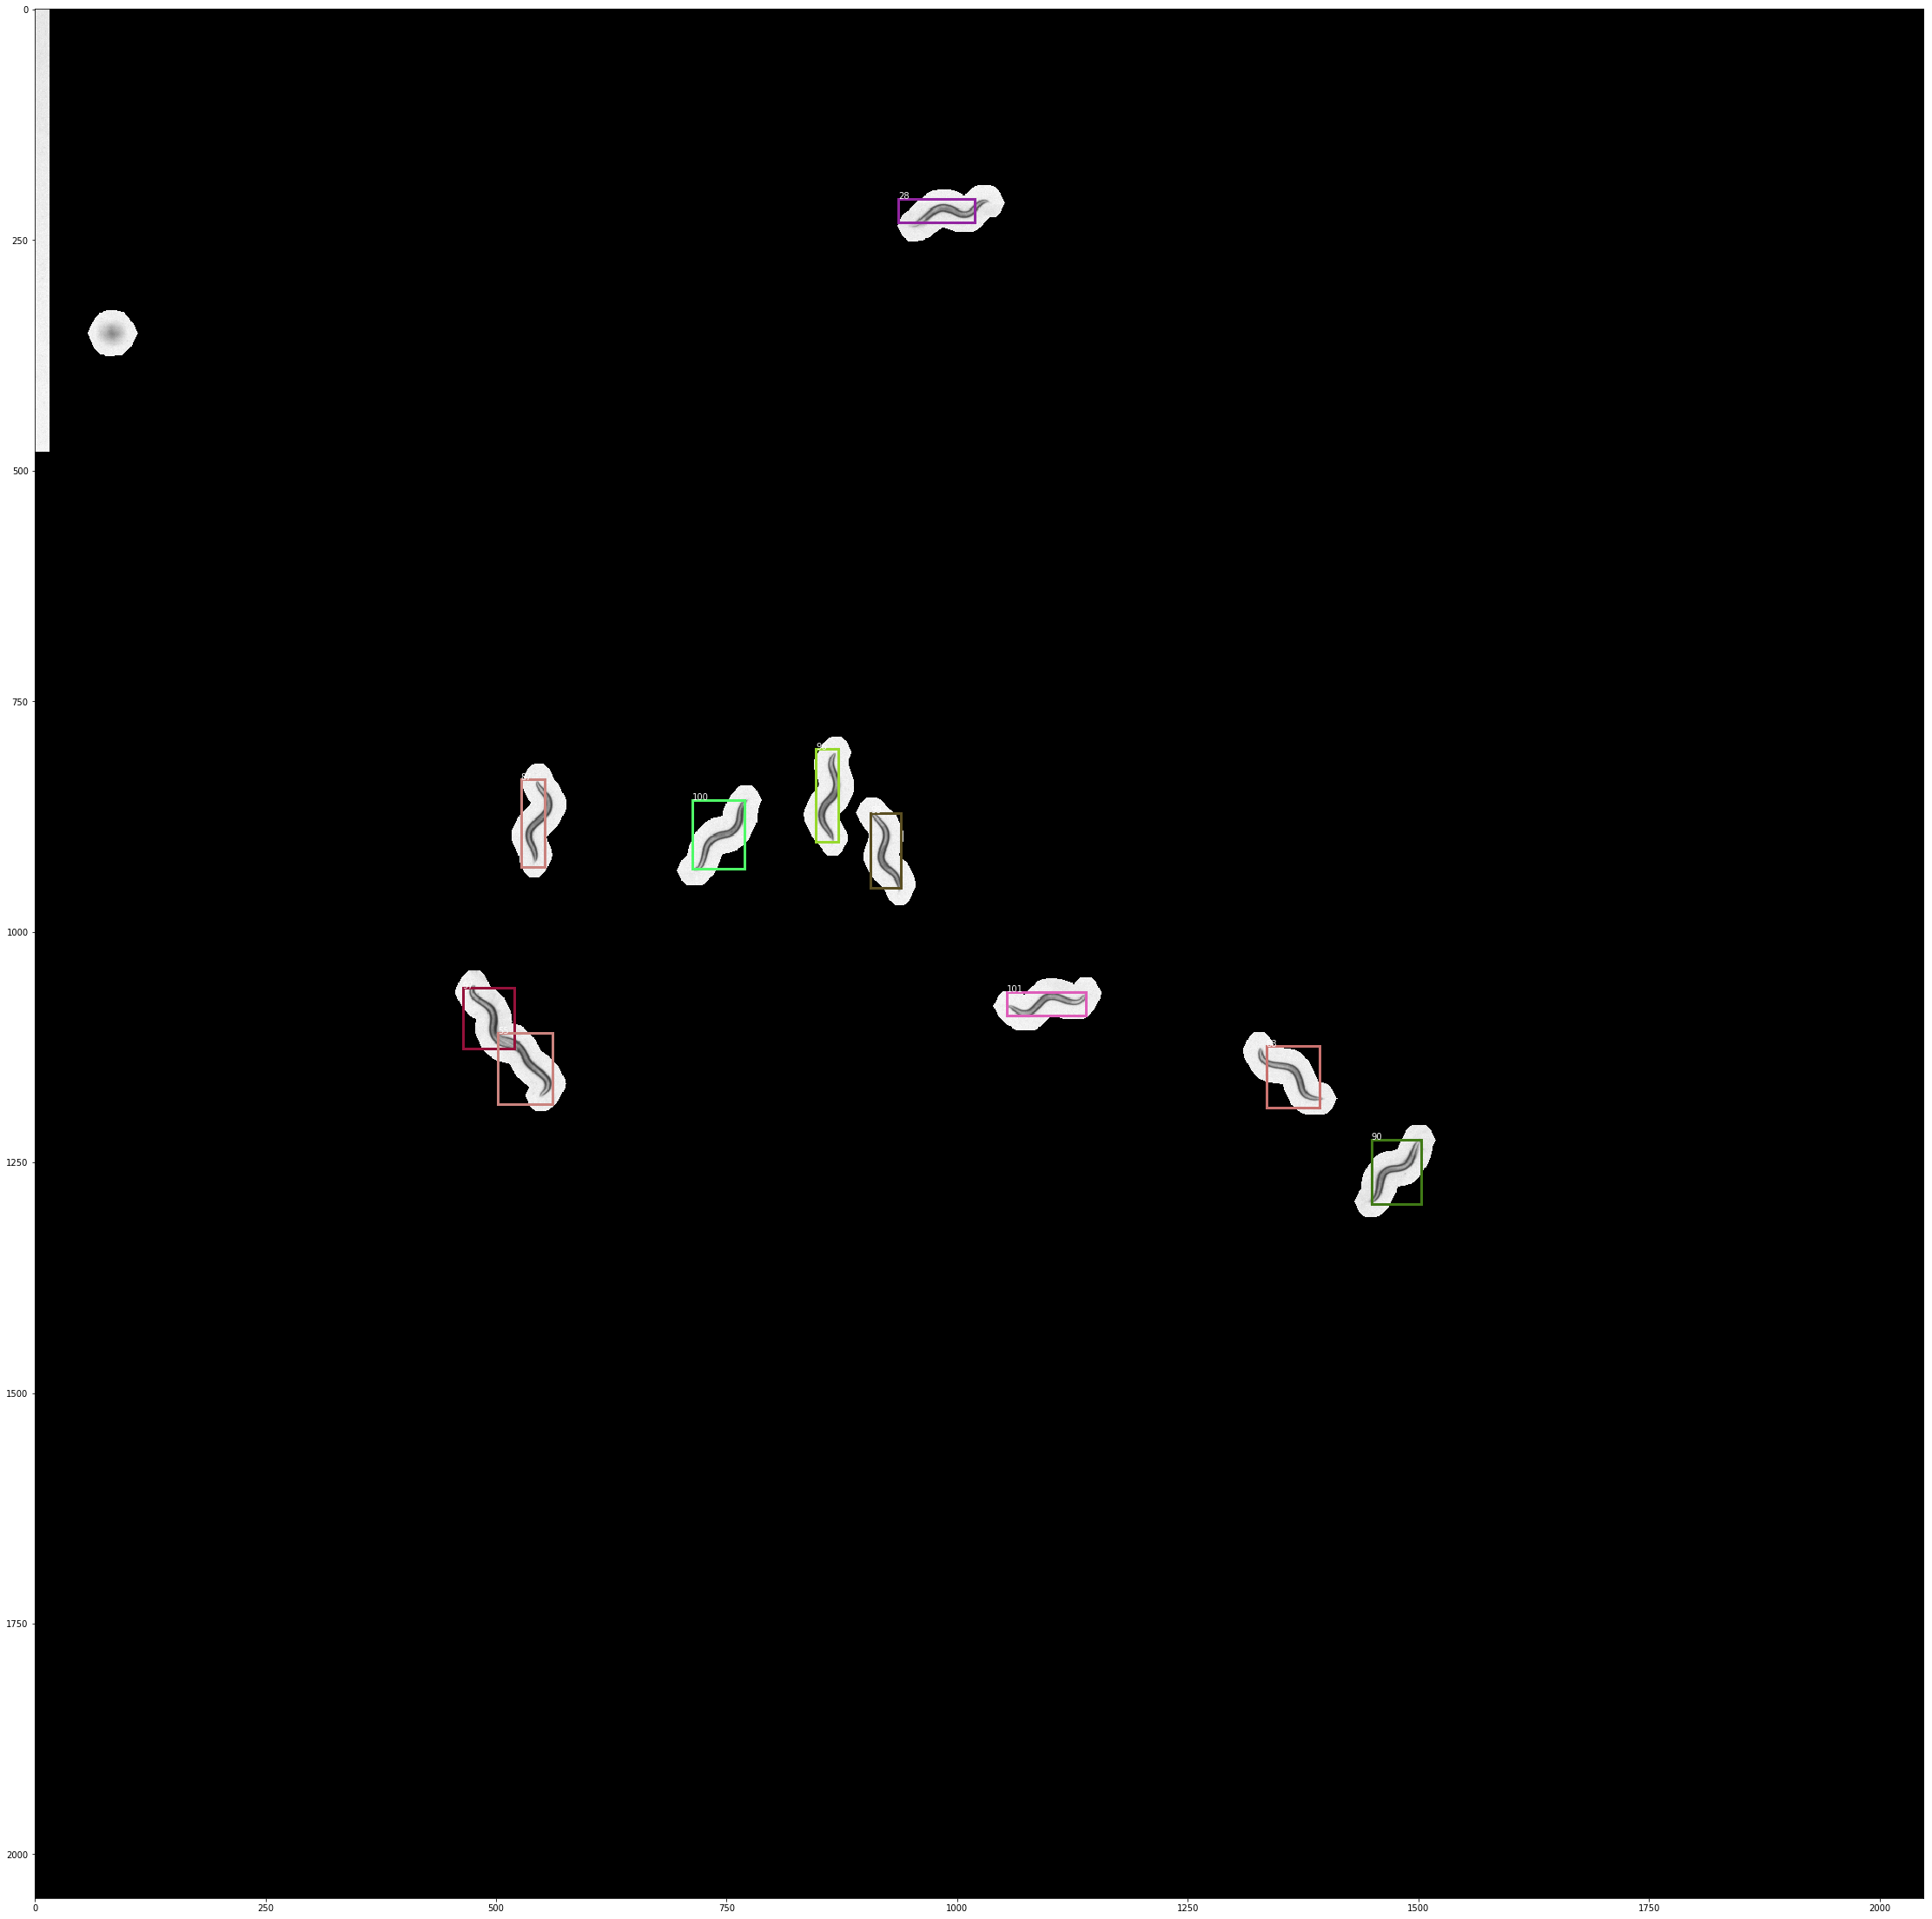

Worm IDs: [28.0, 55.0, 87.0, 88.0, 90.0, 96.0, 97.0, 99.0, 102.0, 103.0]


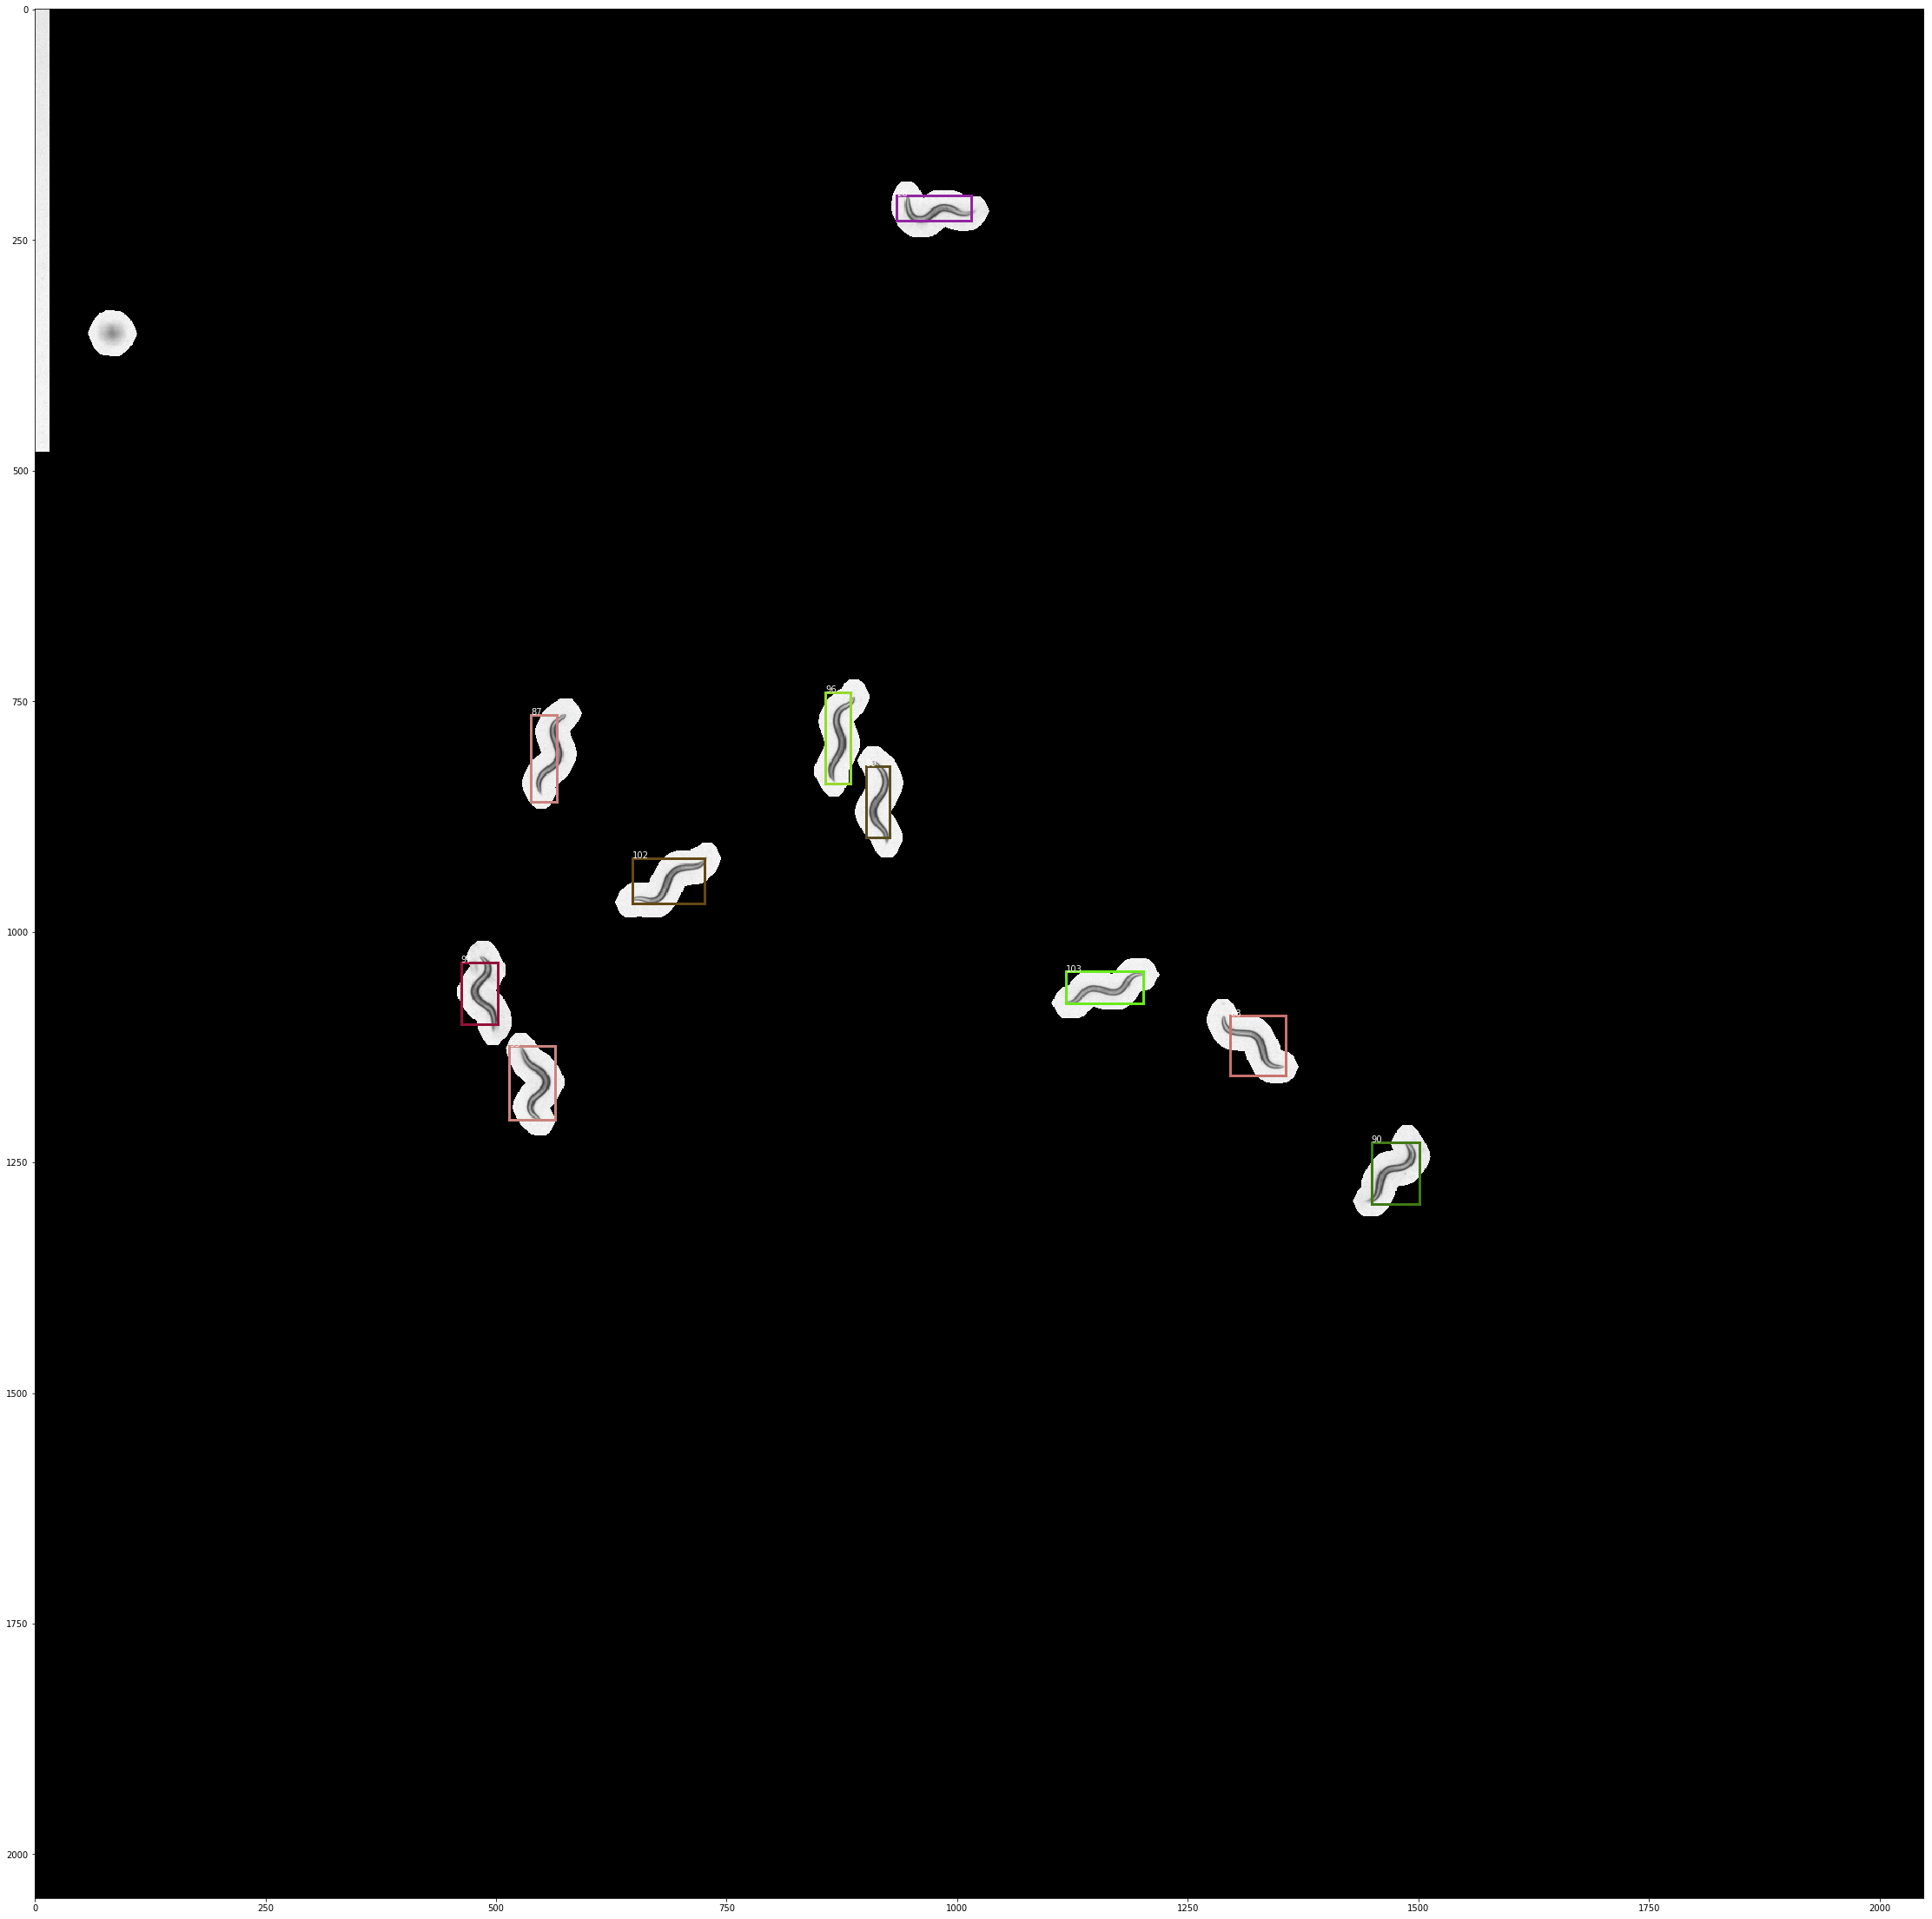

Worm IDs: [28.0, 55.0, 87.0, 88.0, 90.0, 91.0, 97.0, 99.0, 103.0, 104.0]


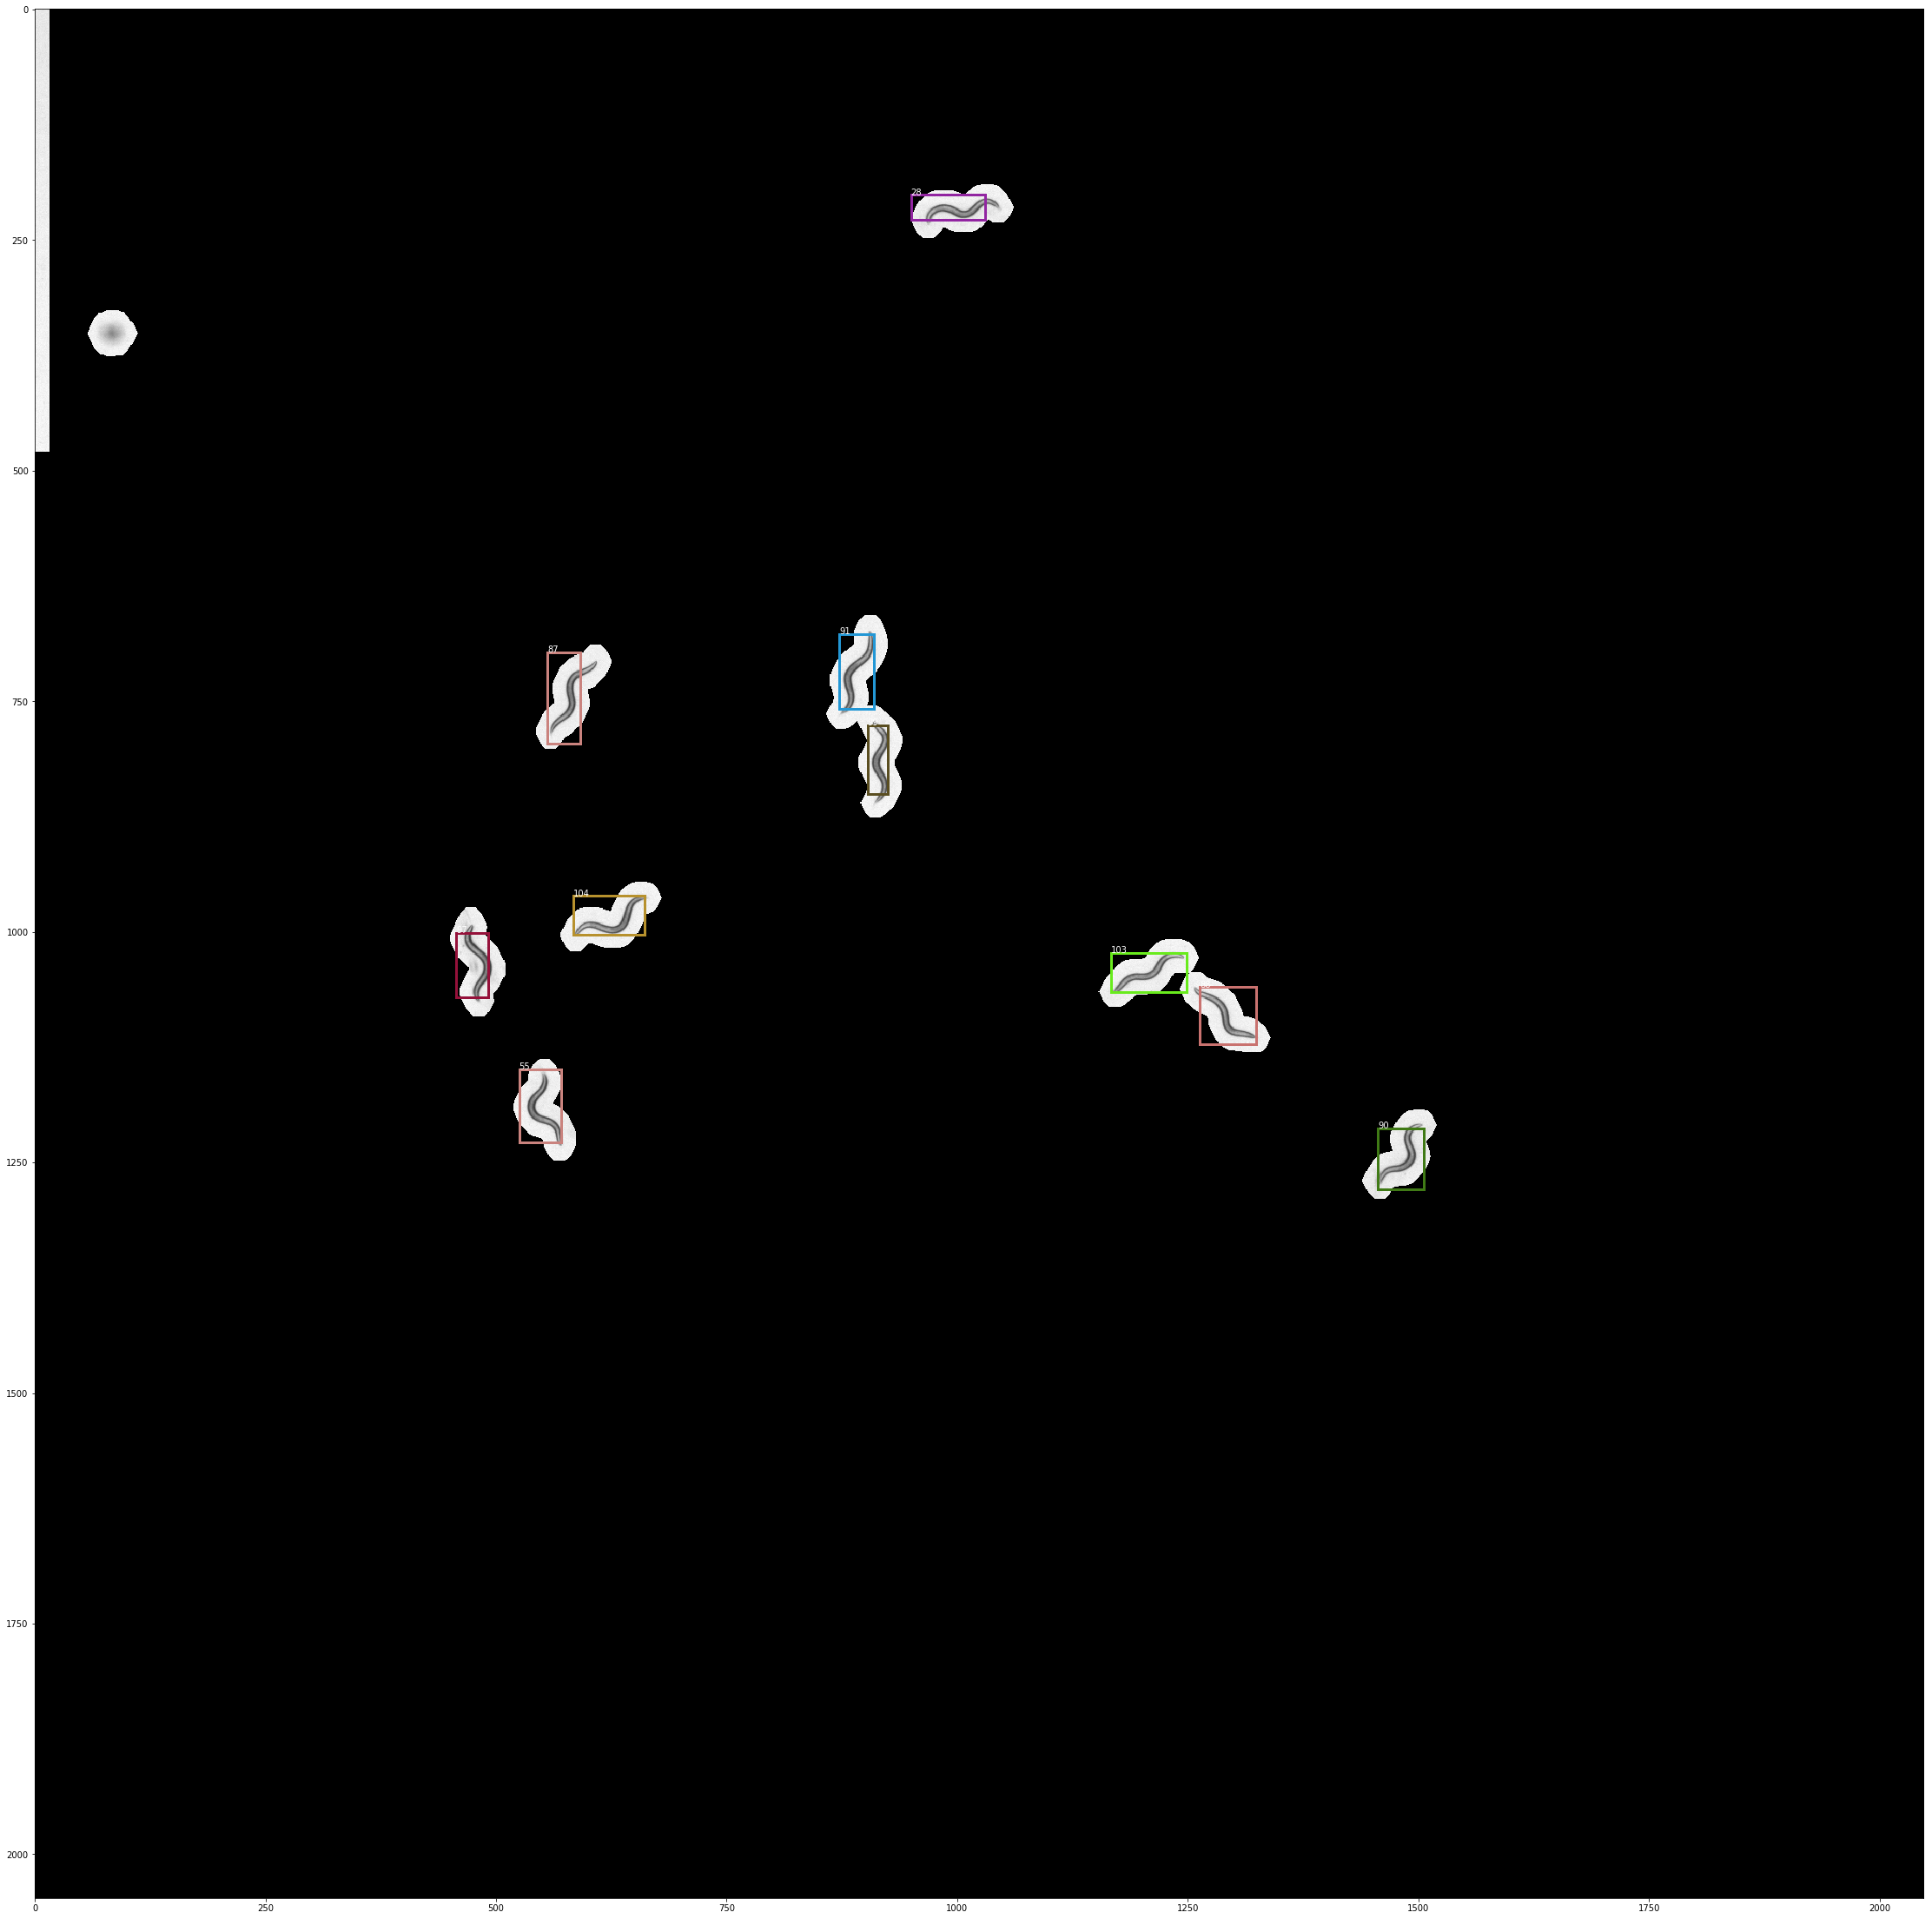

Worm IDs: [28.0, 55.0, 87.0, 88.0, 90.0, 97.0, 99.0, 103.0, 105.0, 106.0]


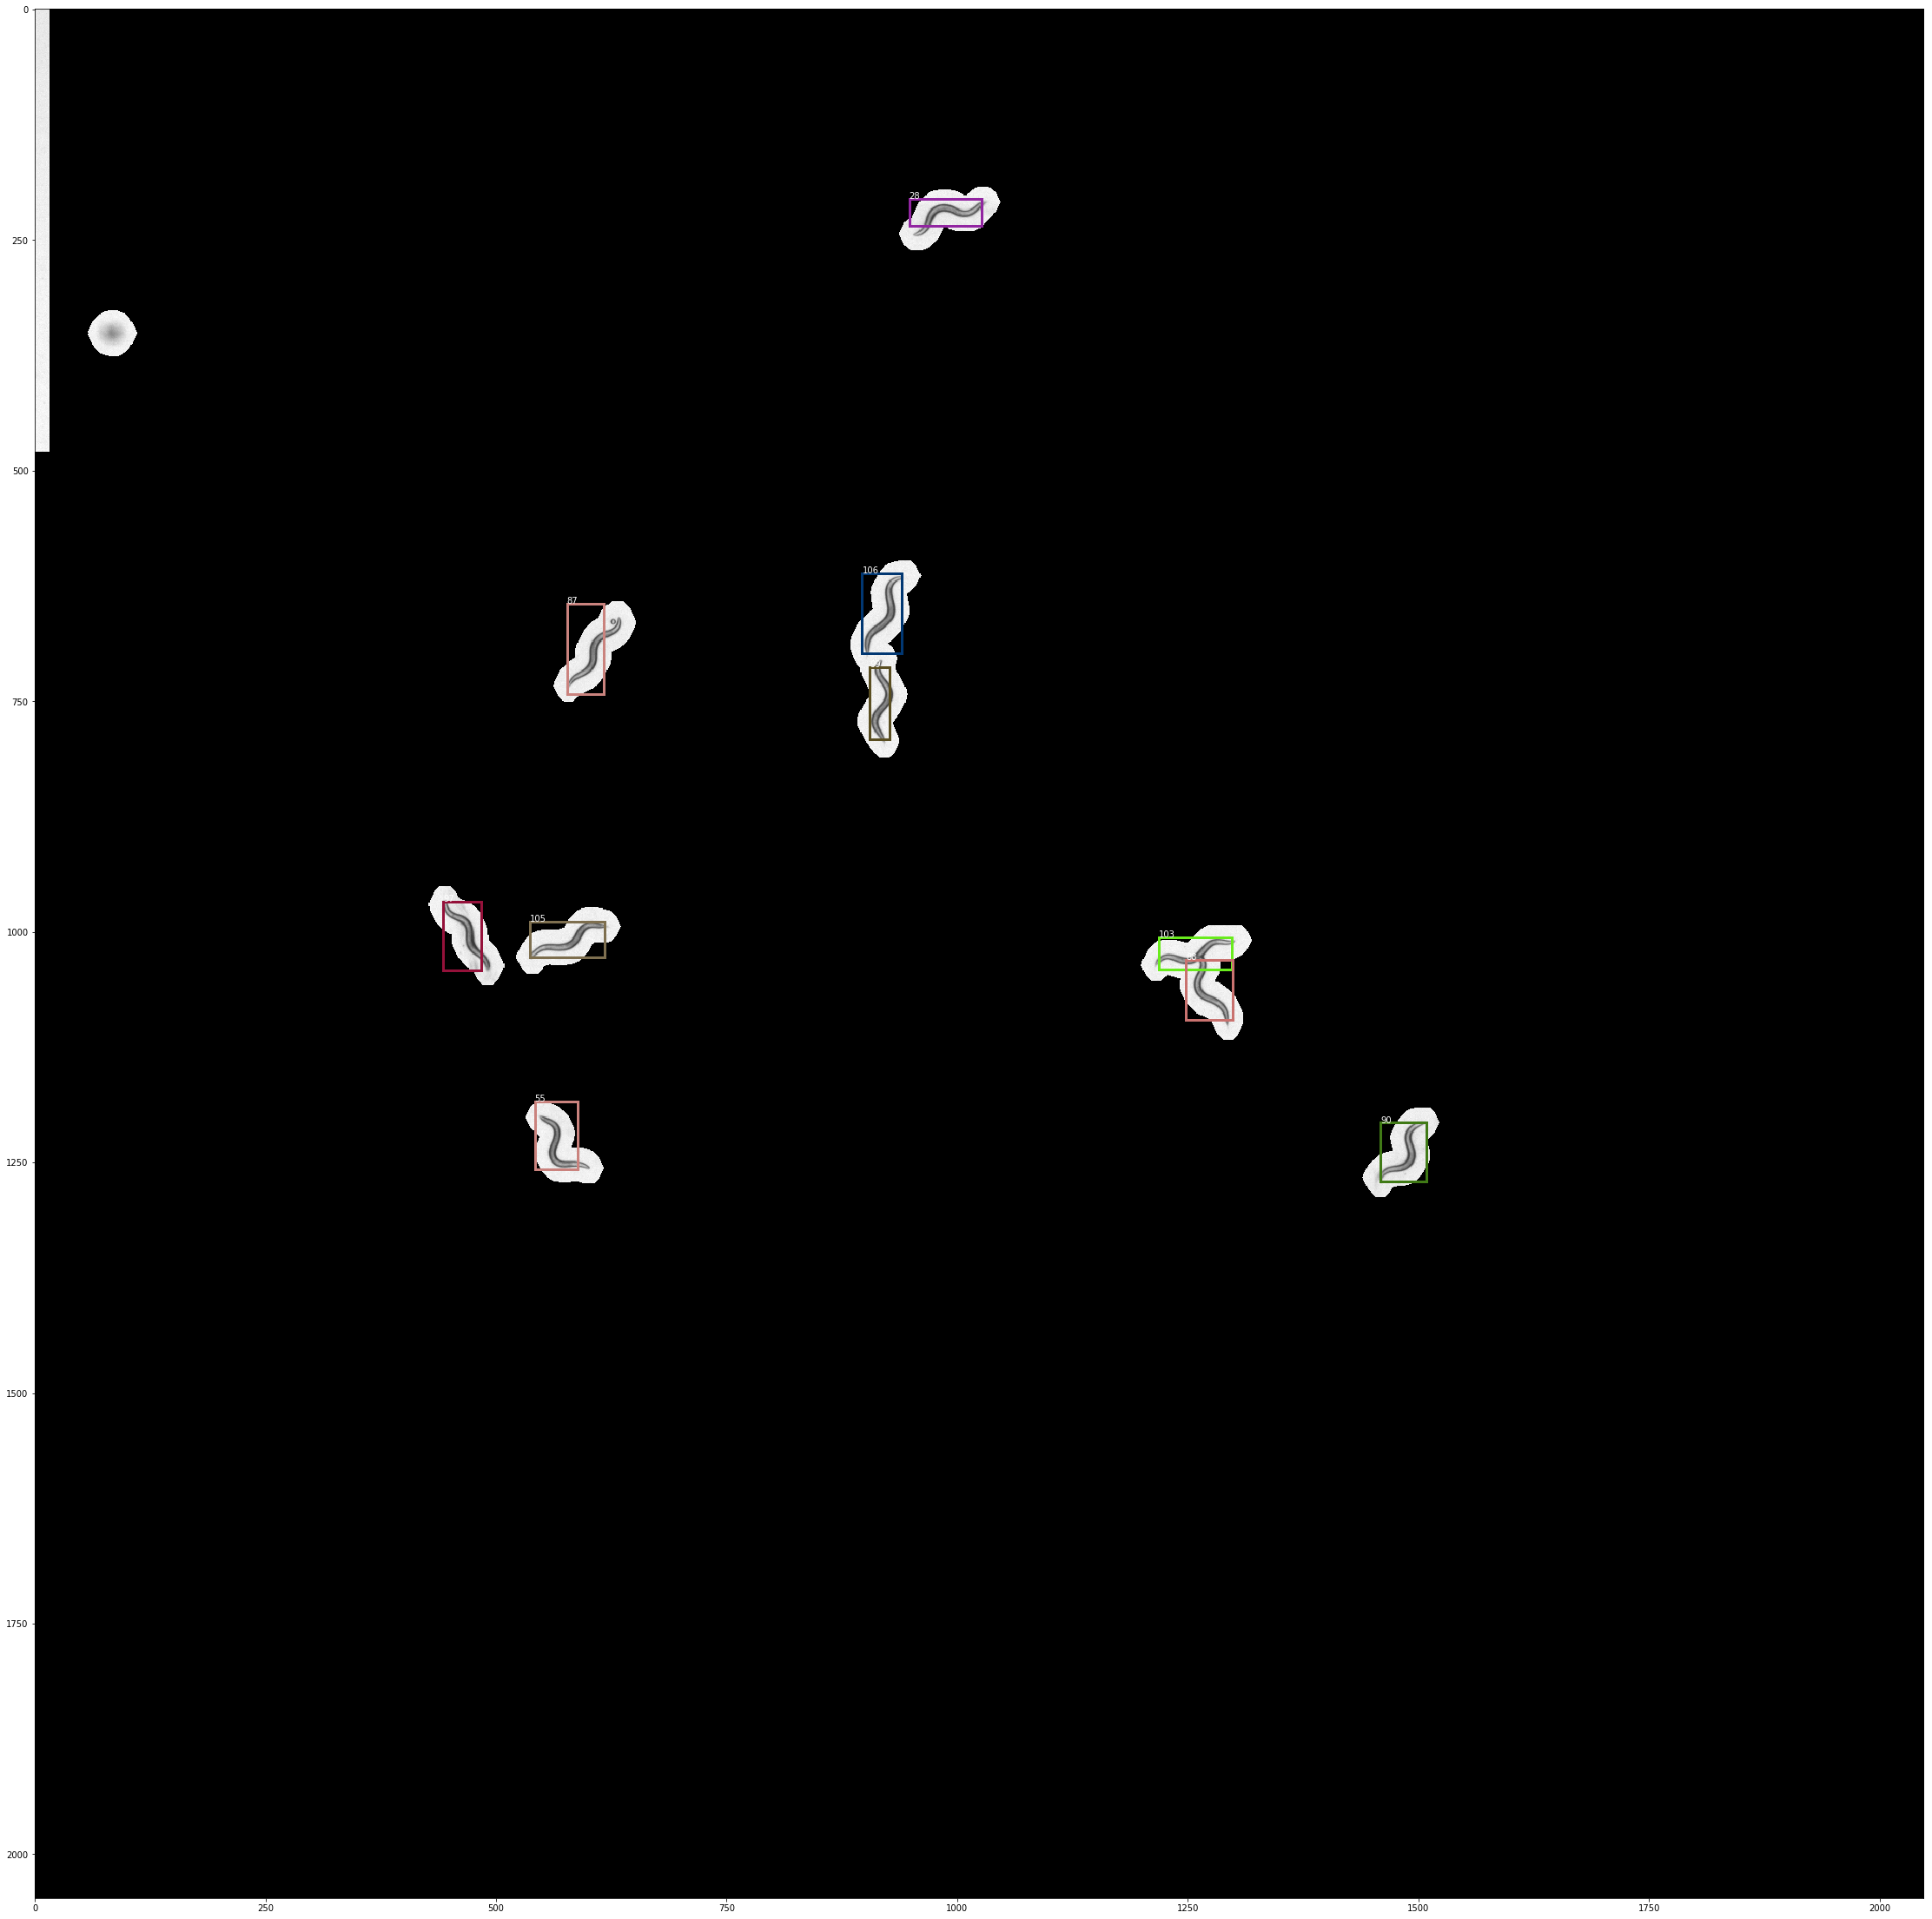

Worm IDs: [28.0, 55.0, 87.0, 88.0, 97.0, 99.0, 103.0, 105.0, 107.0, 108.0]


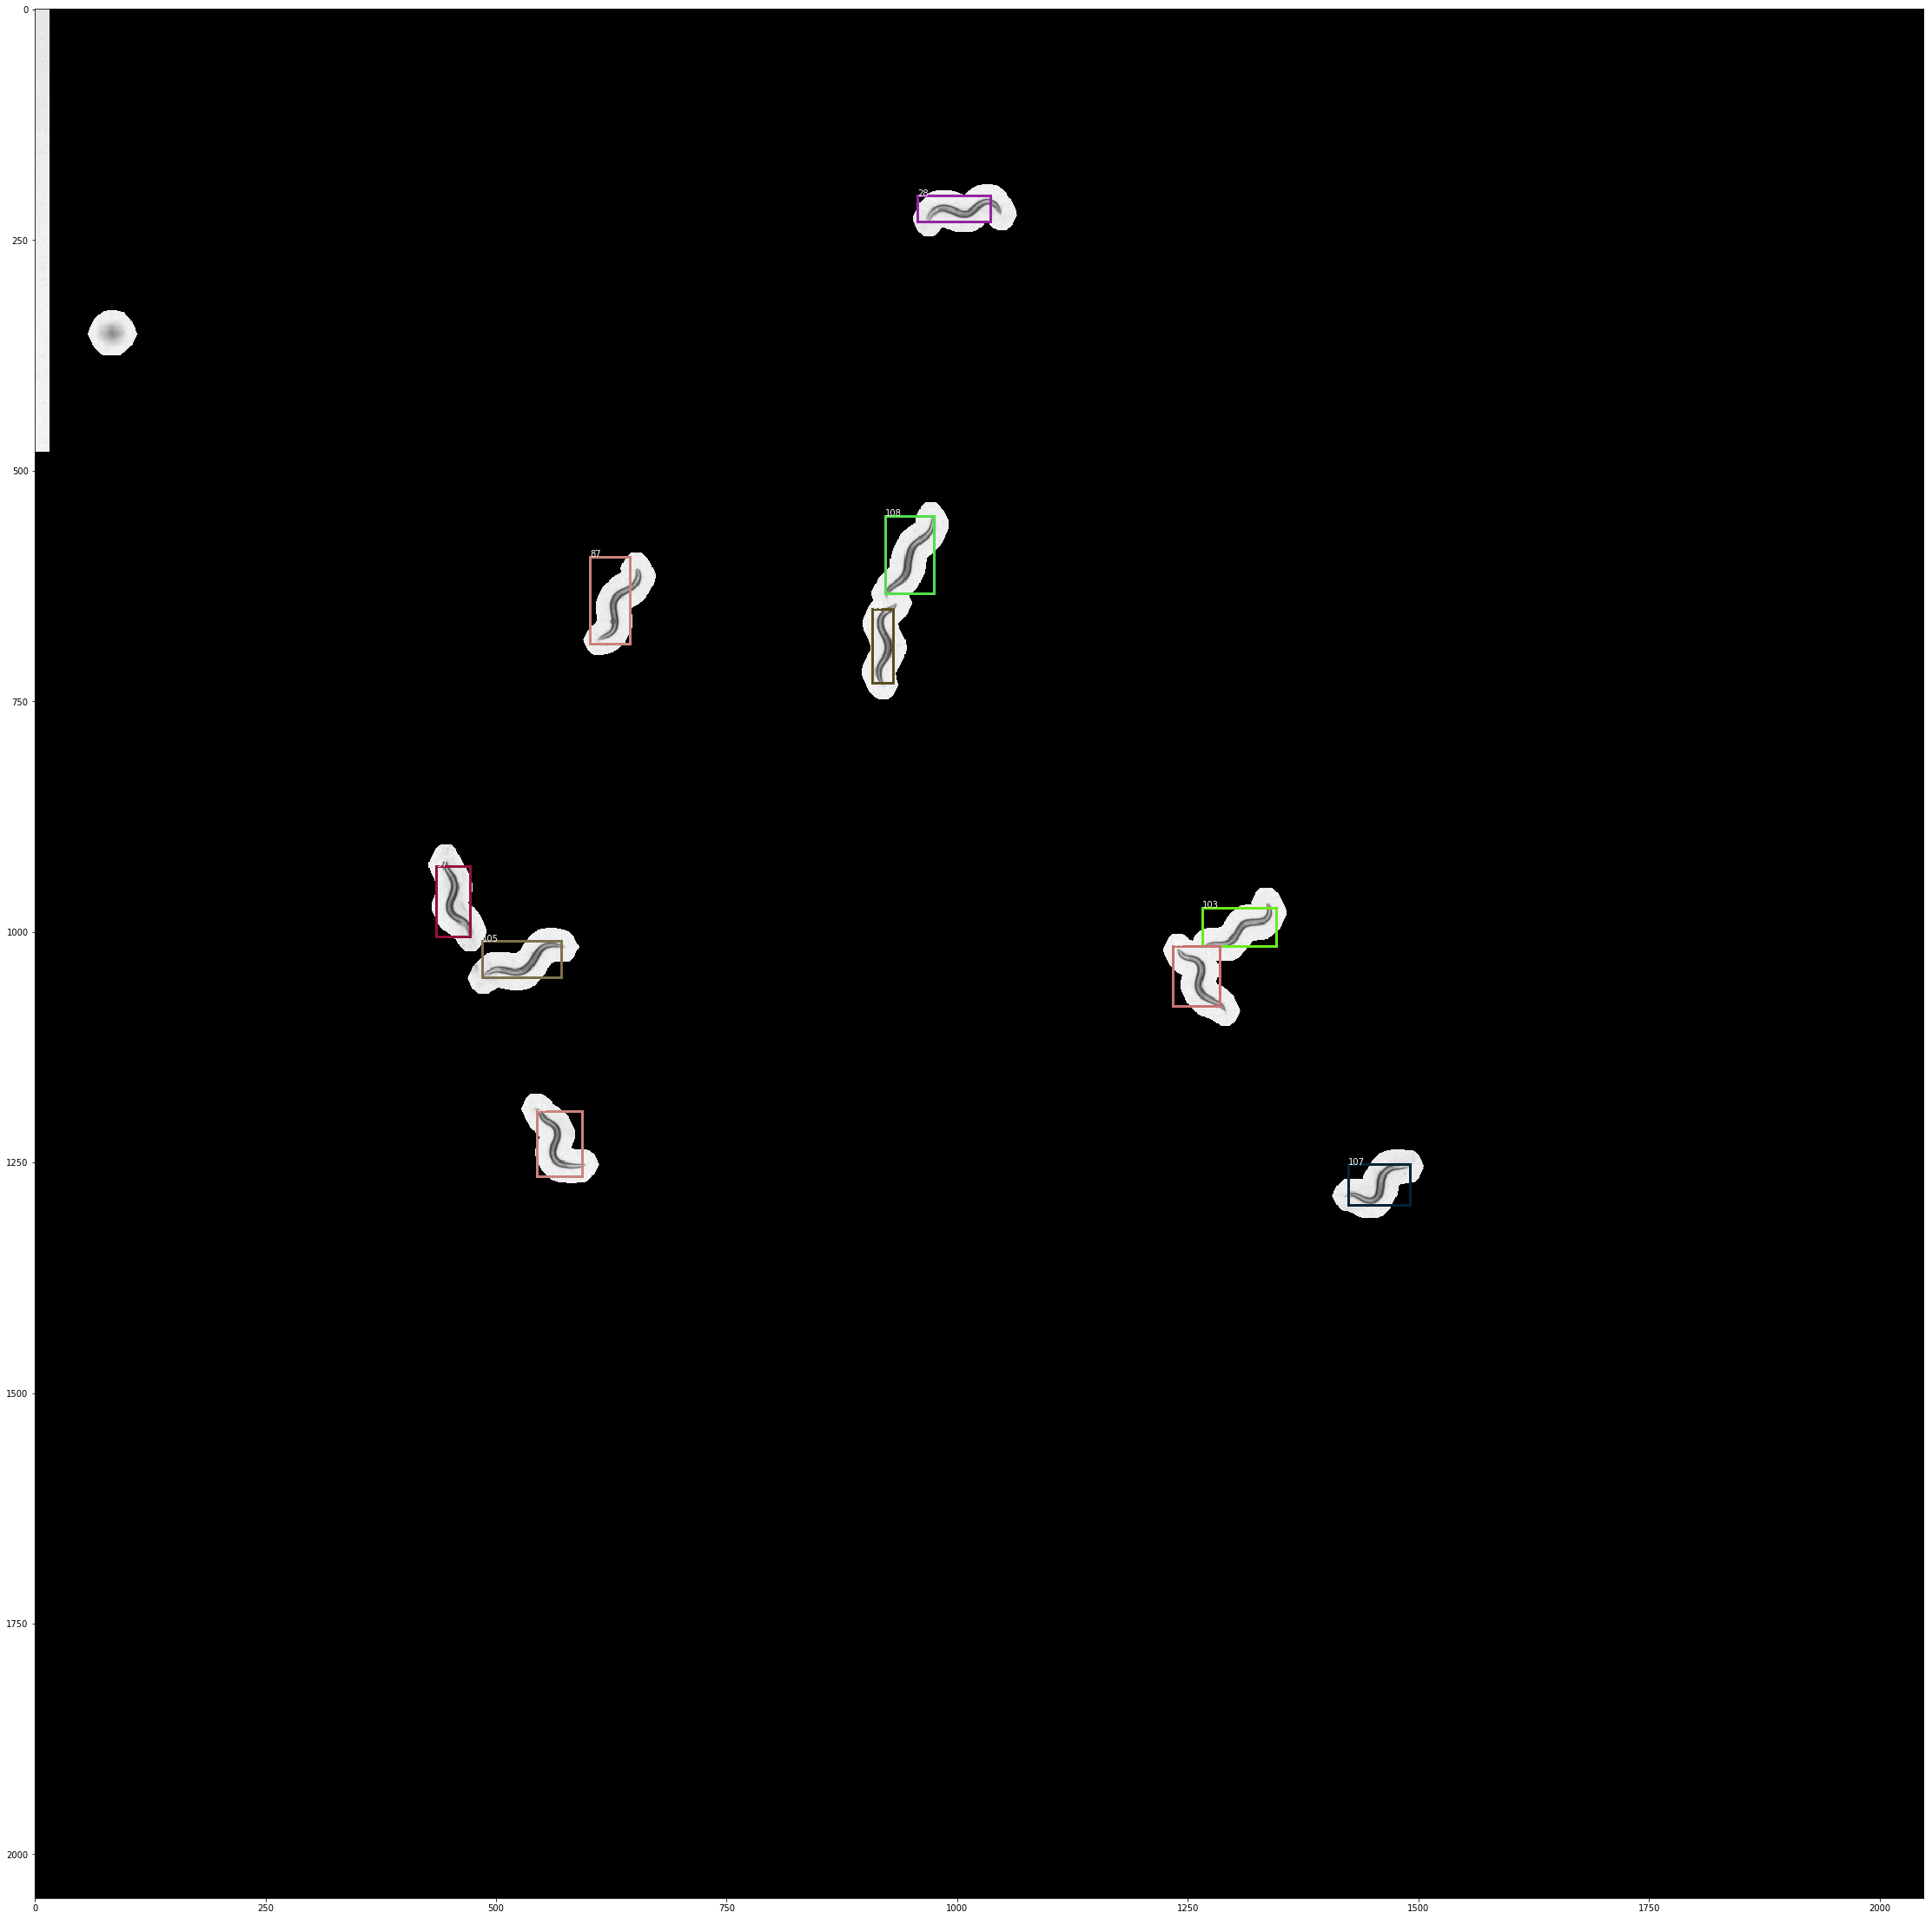

Worm IDs: [28.0, 55.0, 87.0, 88.0, 97.0, 99.0, 103.0, 105.0, 107.0, 109.0]


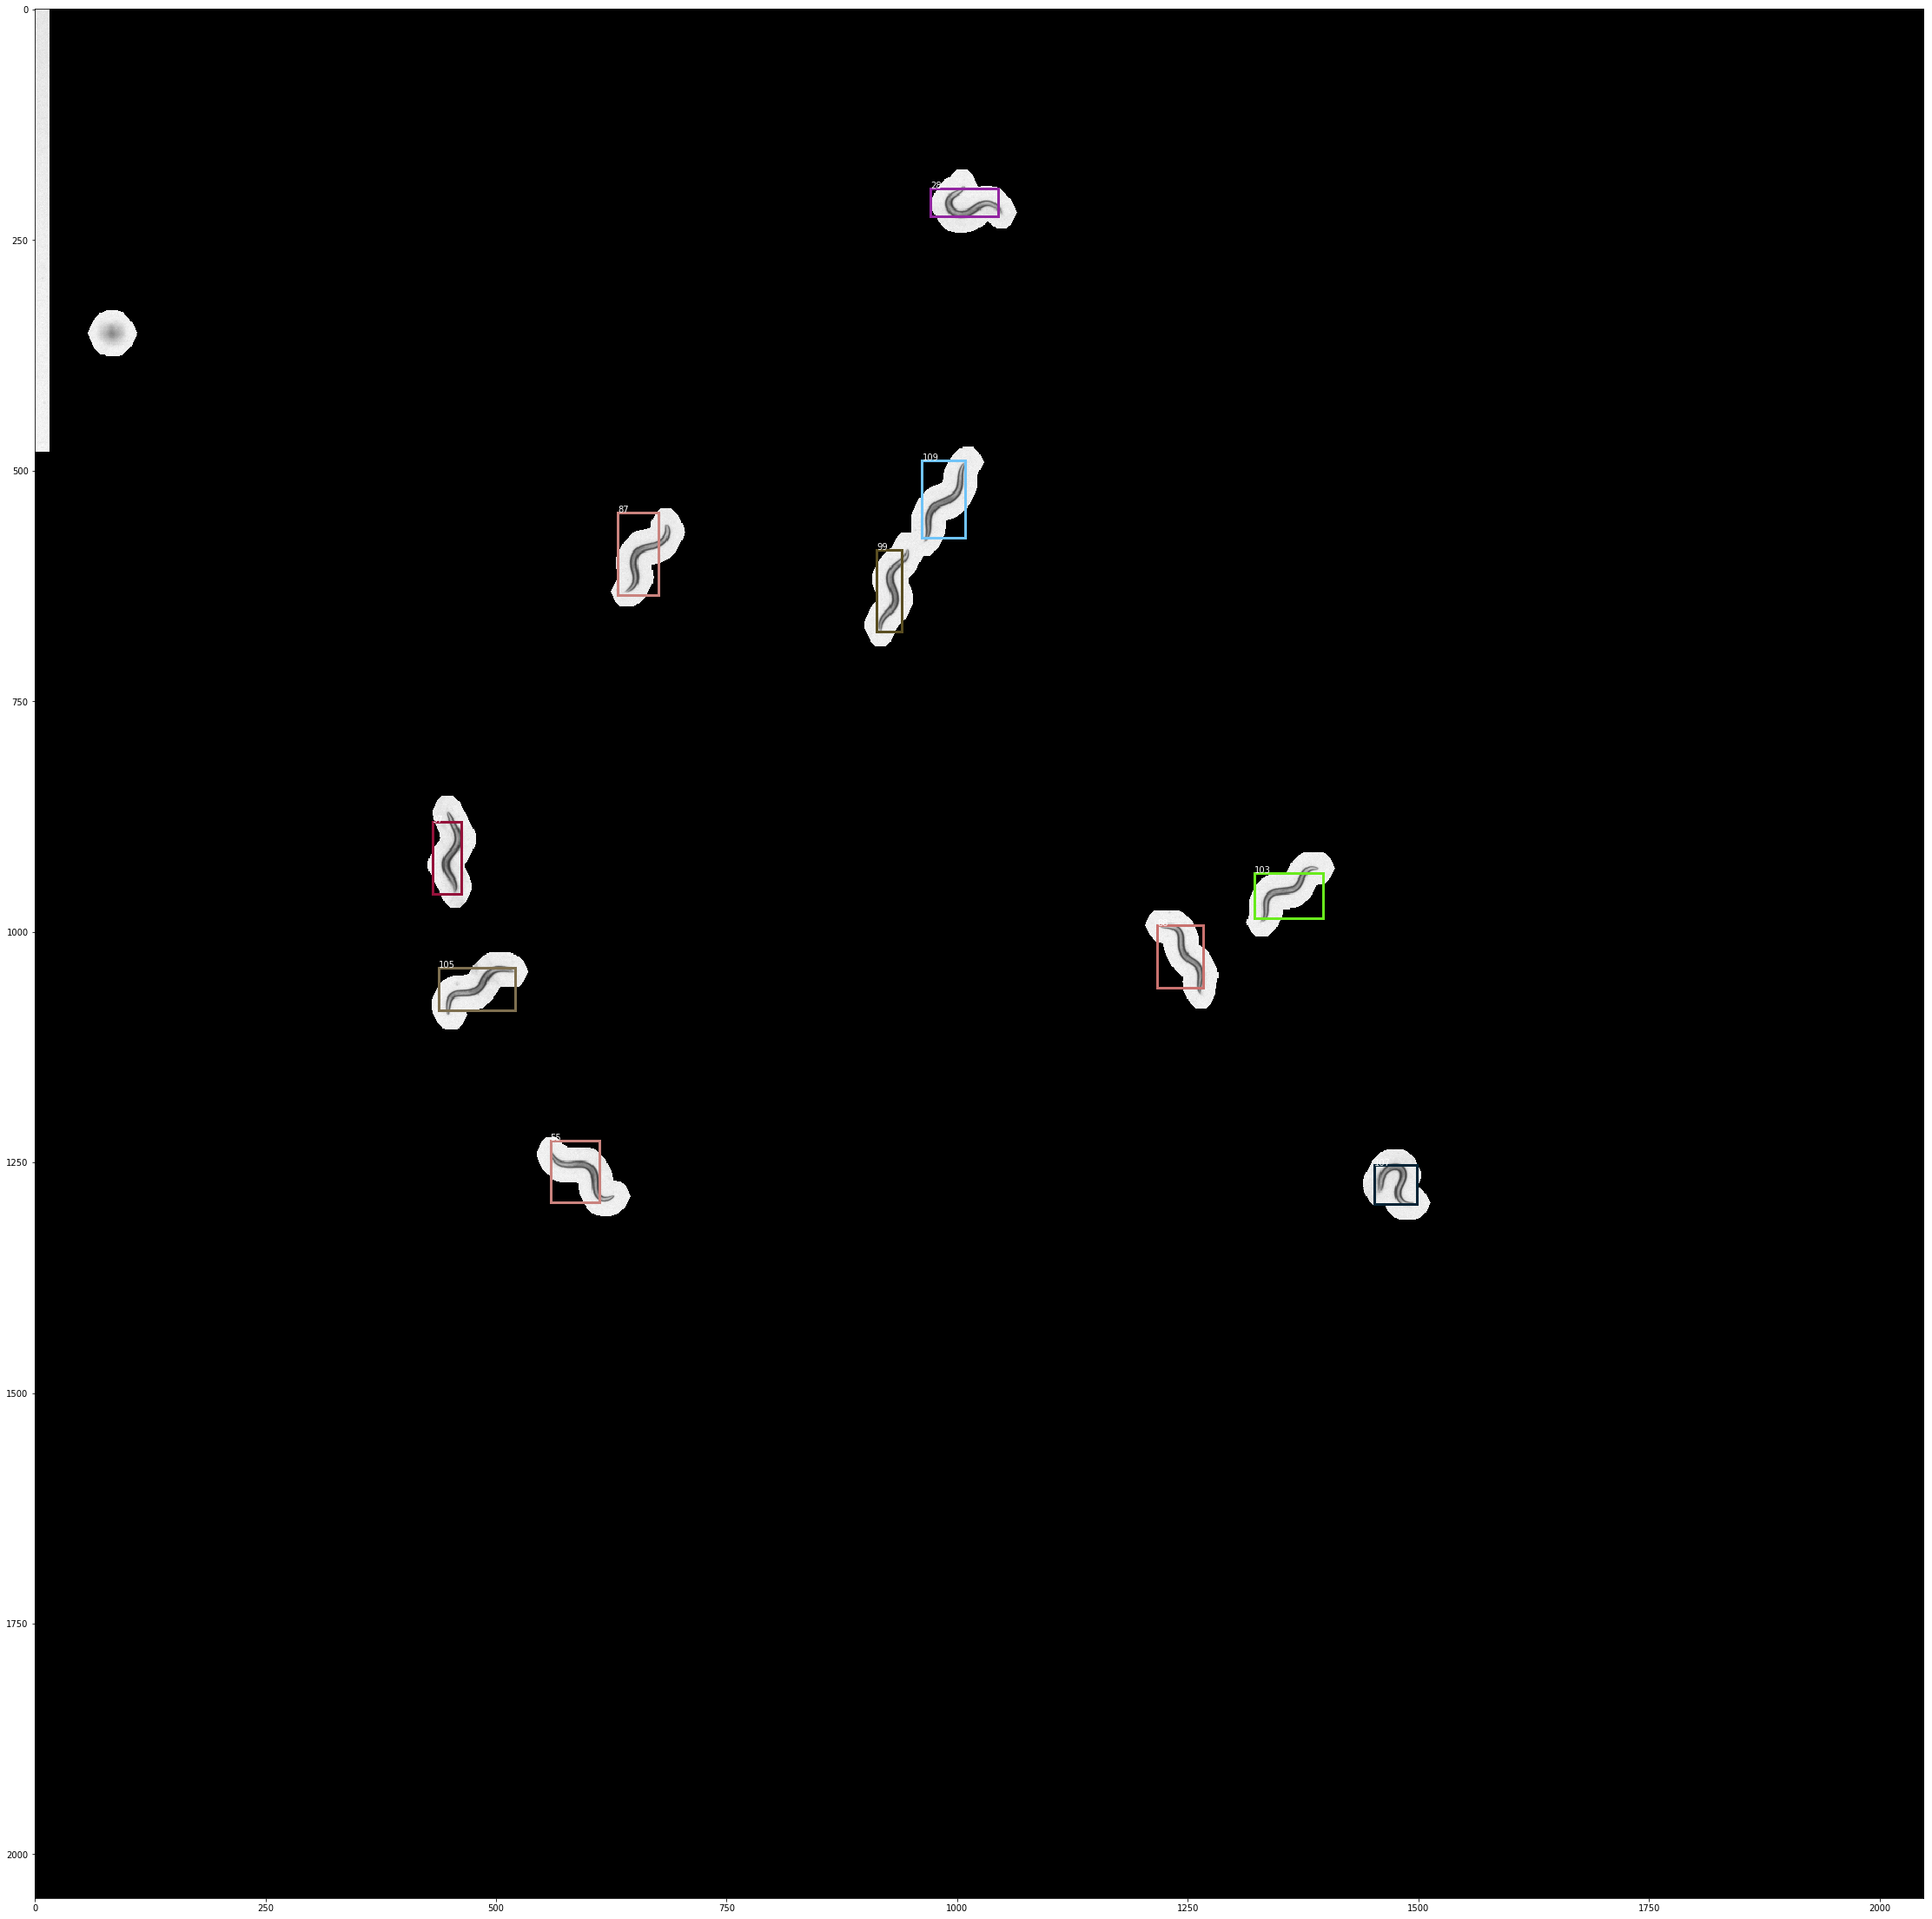

Worm IDs: [28.0, 55.0, 87.0, 88.0, 97.0, 103.0, 107.0, 108.0, 110.0, 111.0]


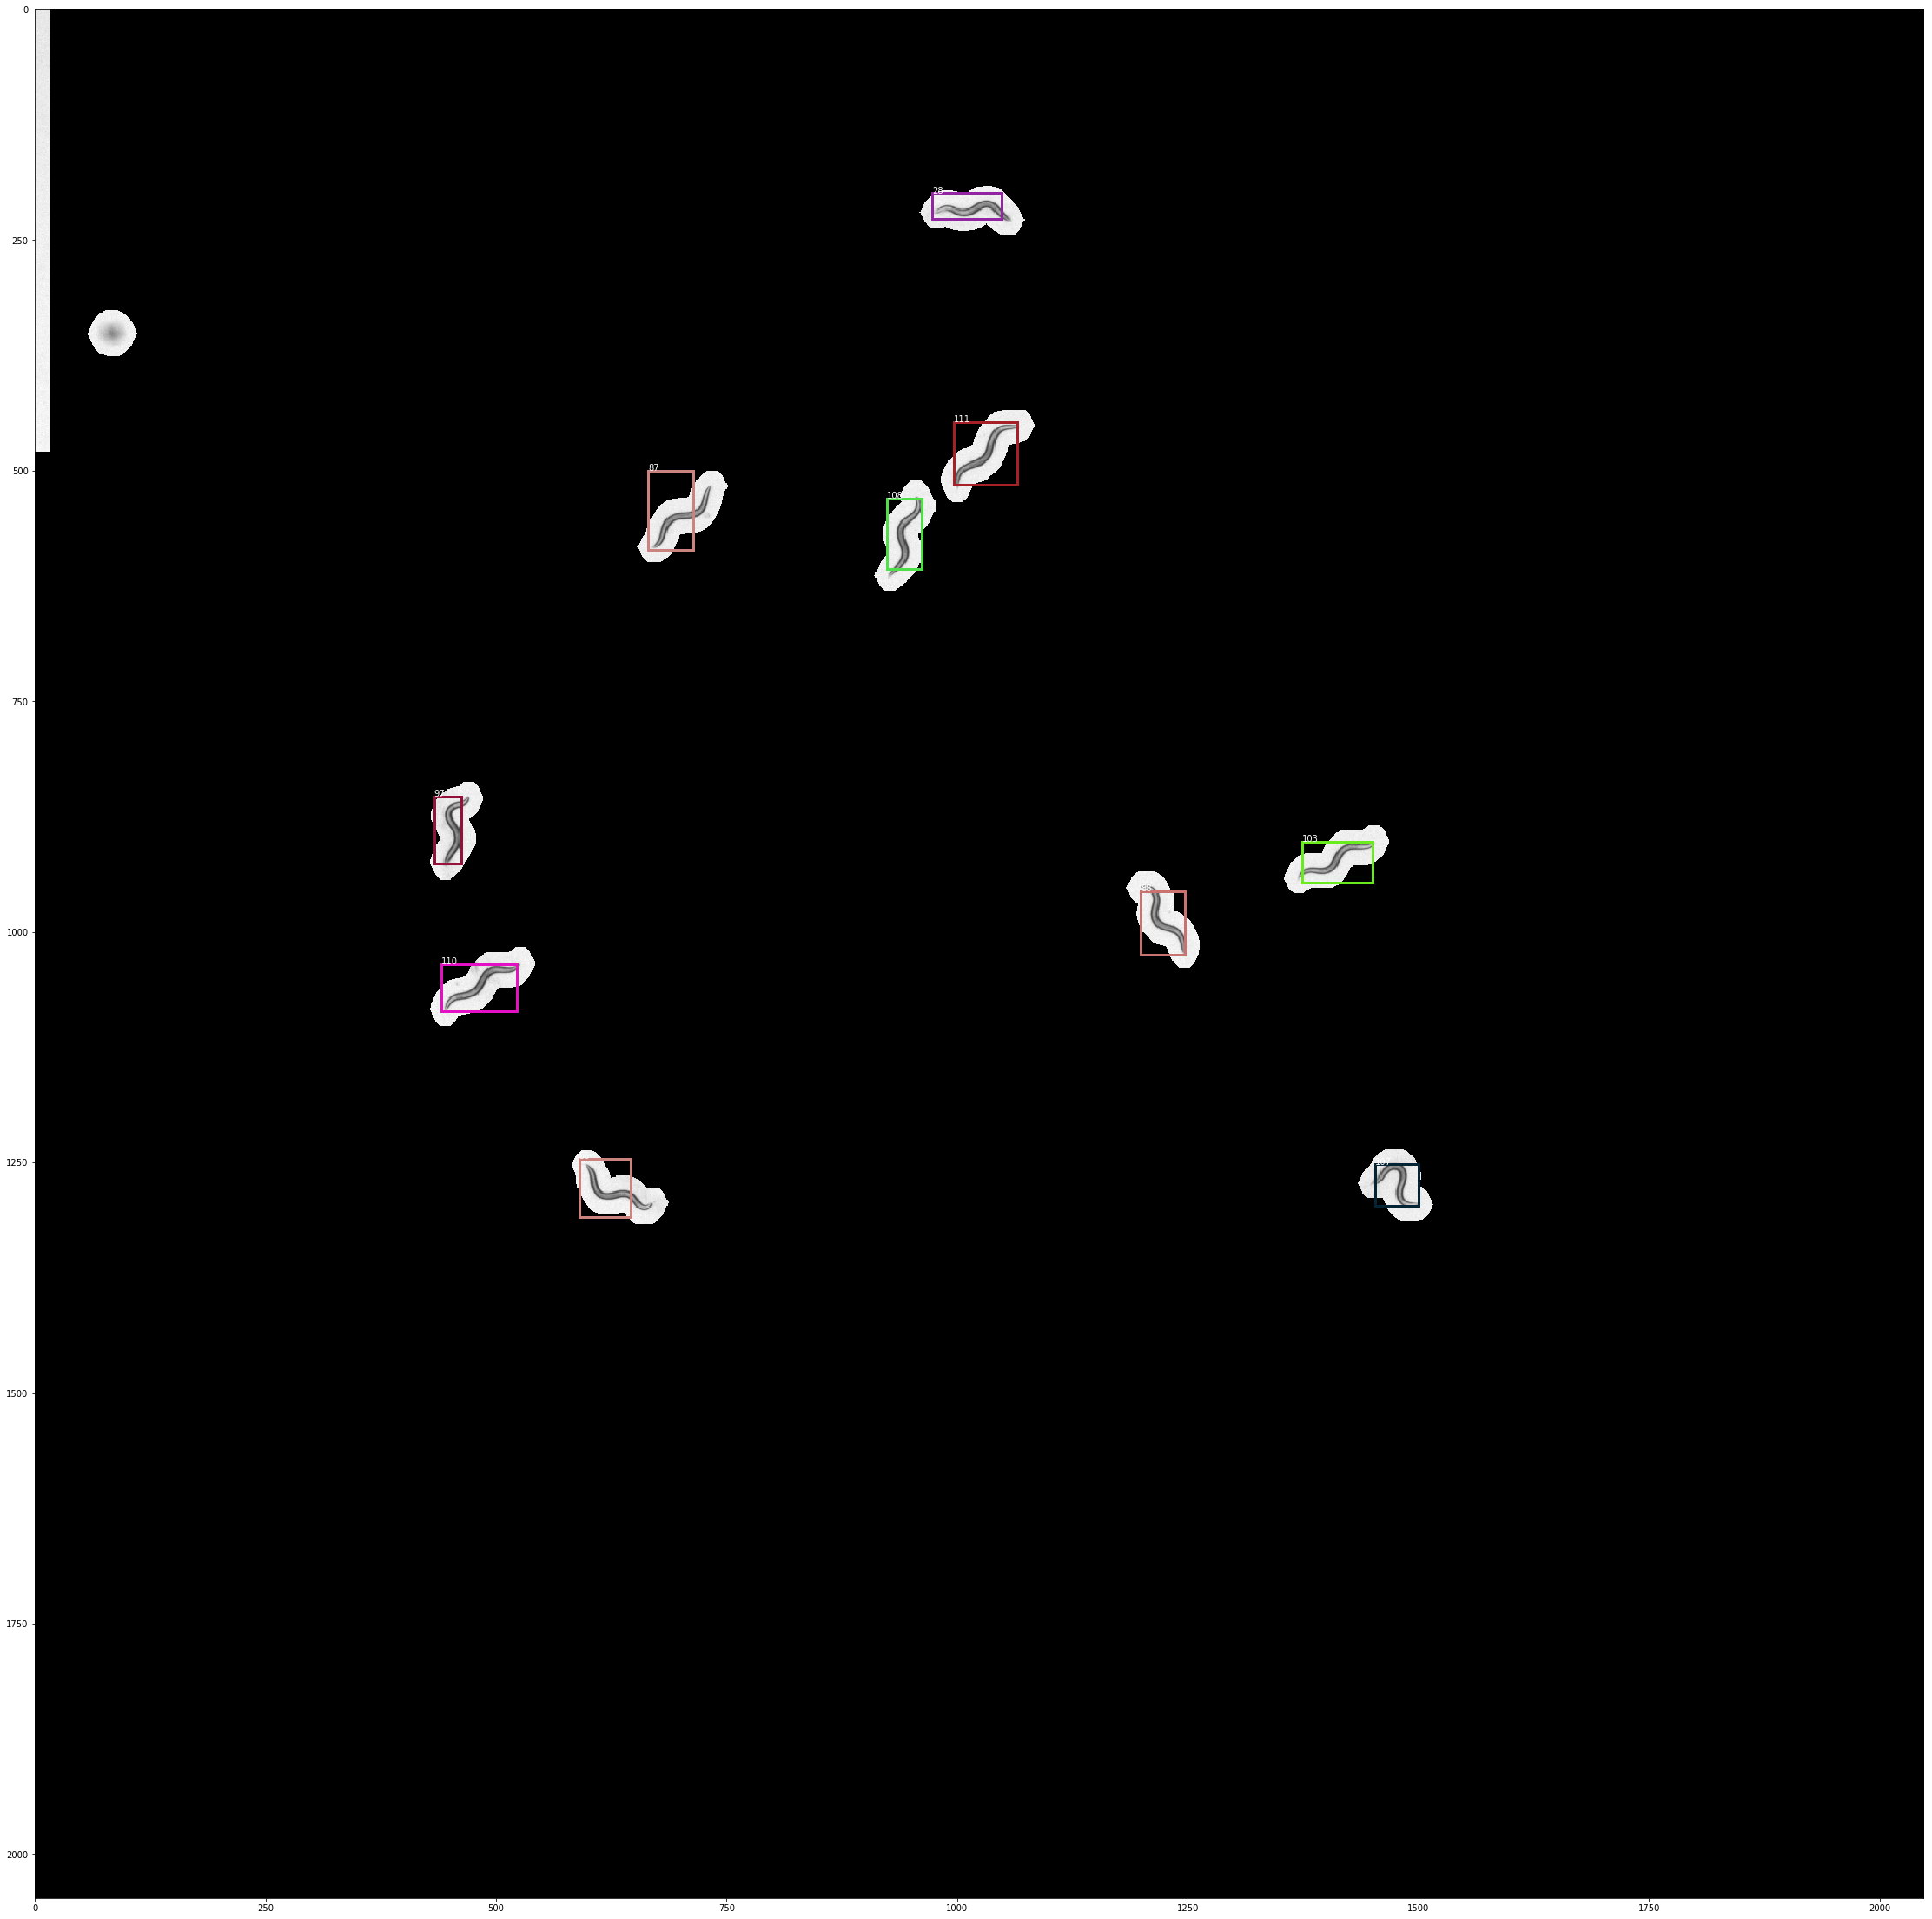

Worm IDs: [28.0, 55.0, 88.0, 97.0, 103.0, 107.0, 109.0, 110.0, 112.0, 113.0]


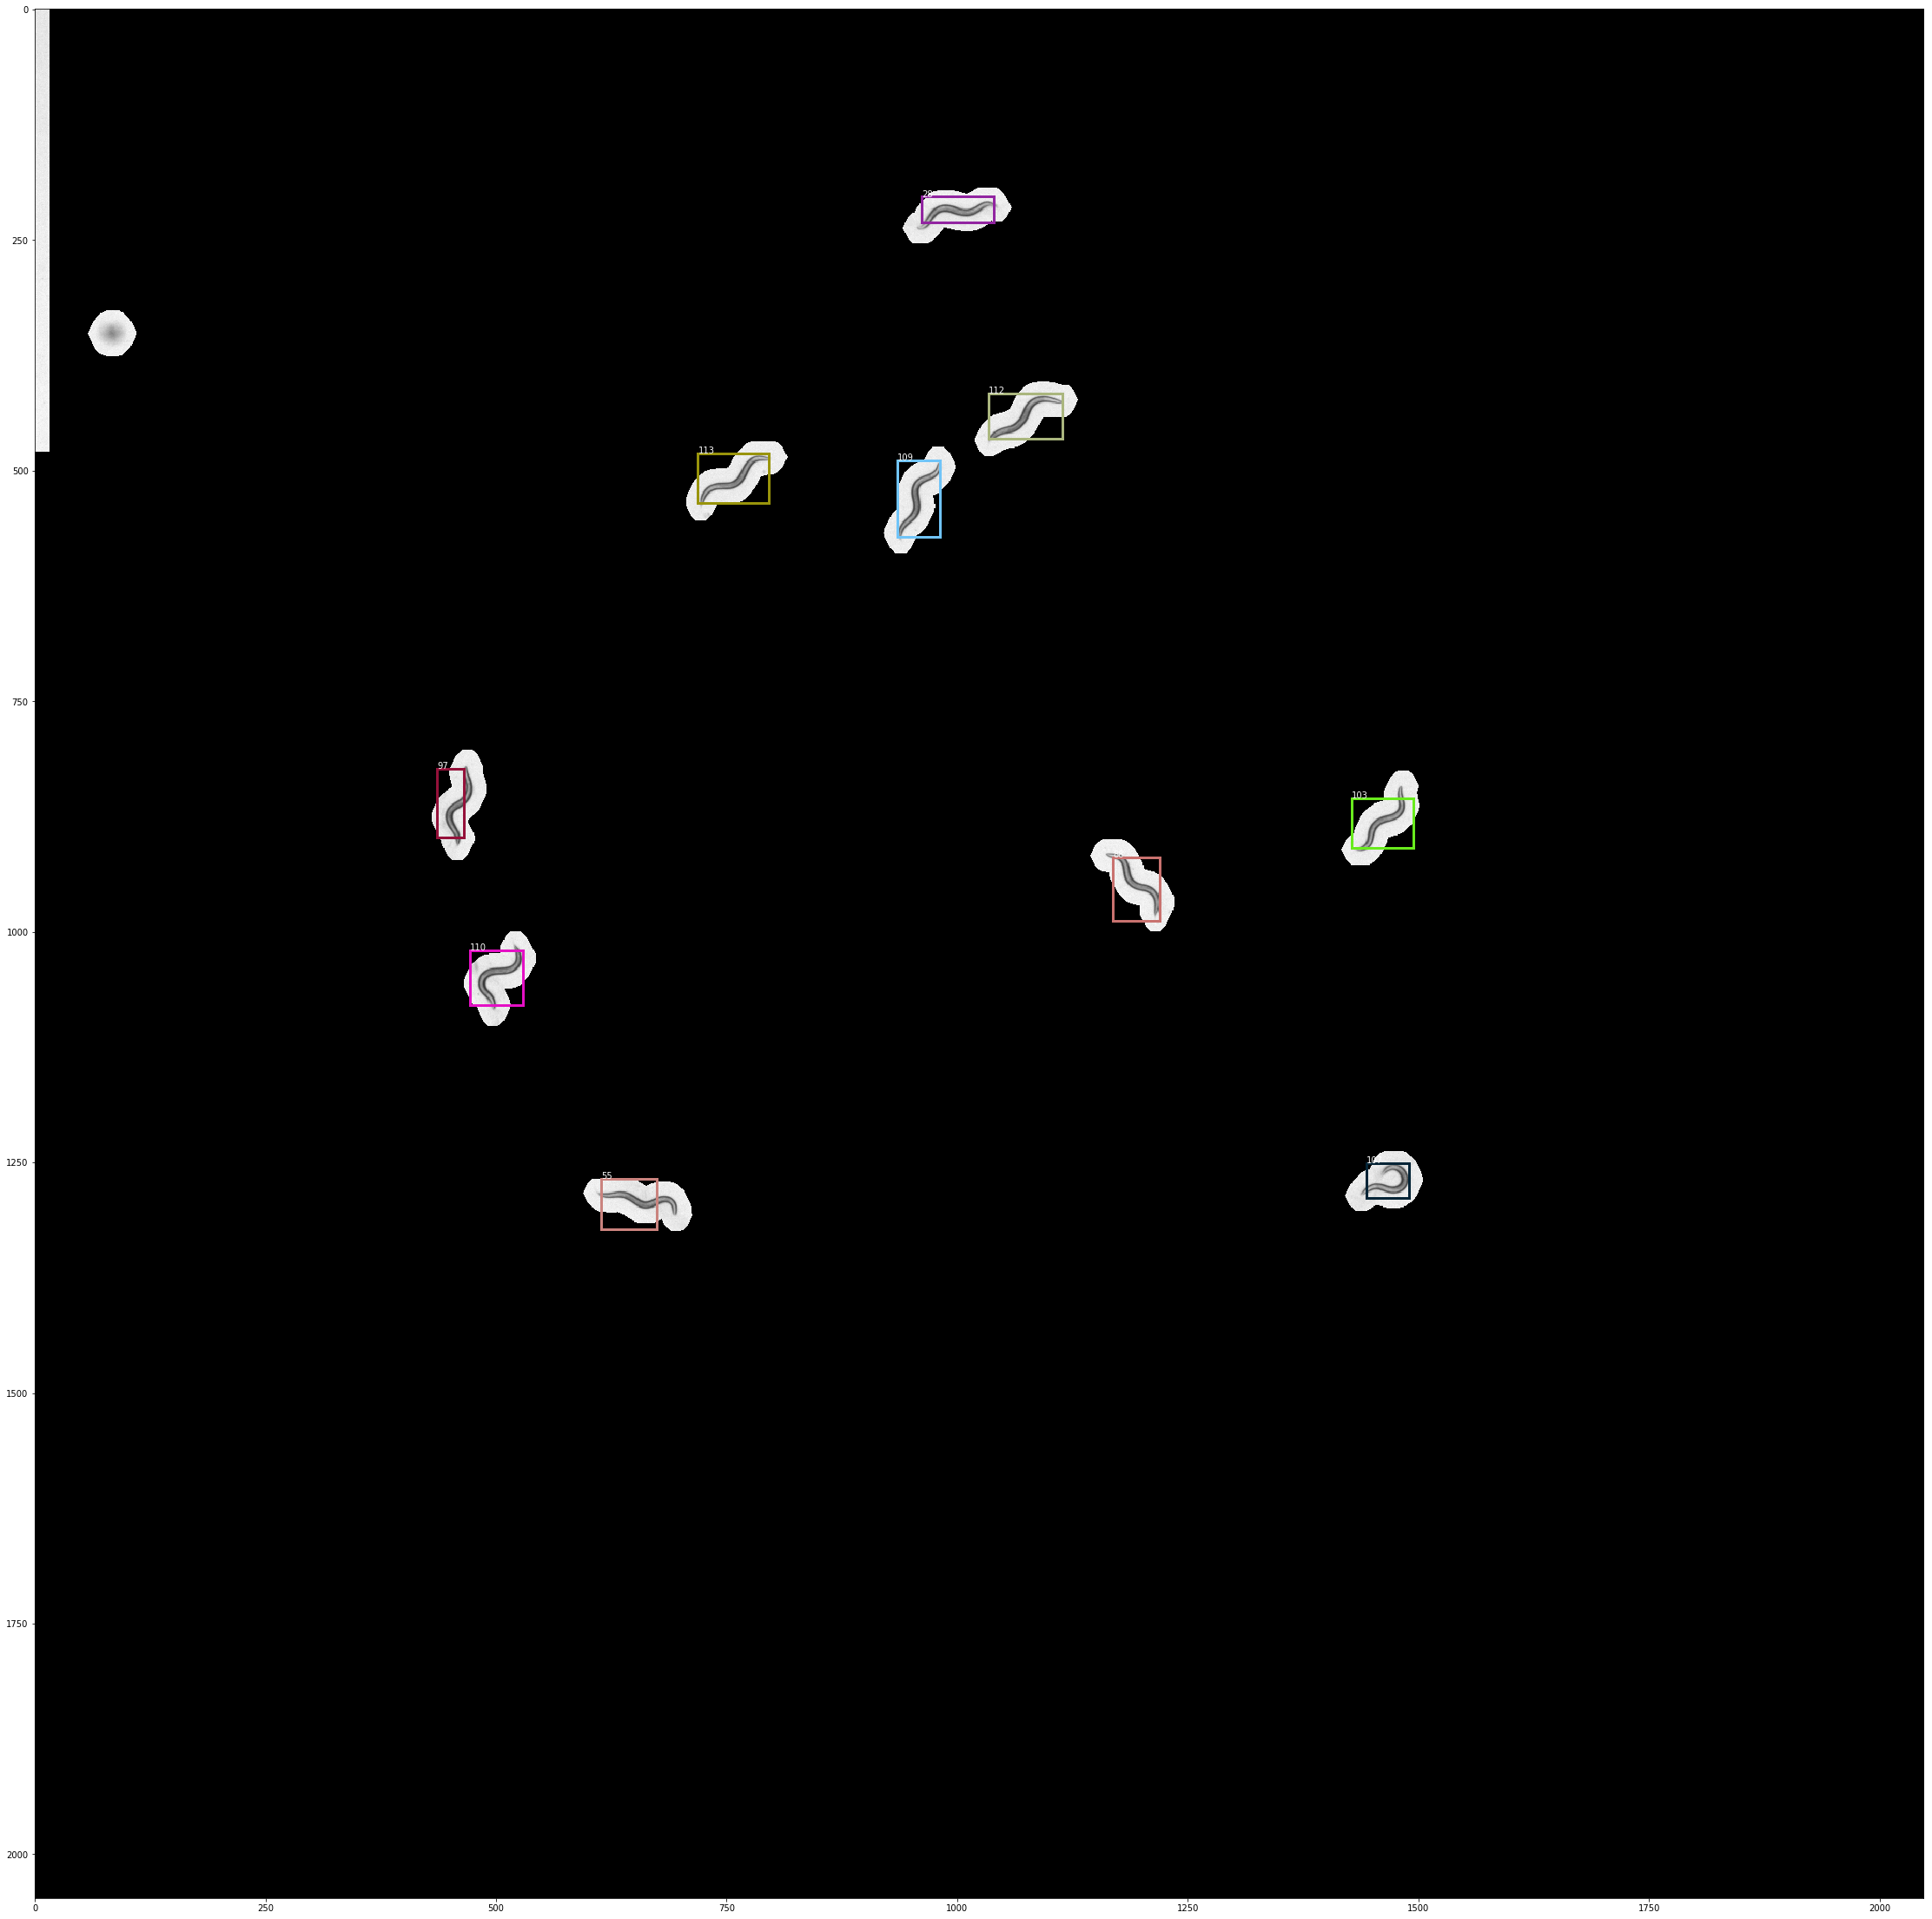

Worm IDs: [28.0, 55.0, 88.0, 97.0, 103.0, 111.0, 112.0, 114.0, 115.0, 116.0]


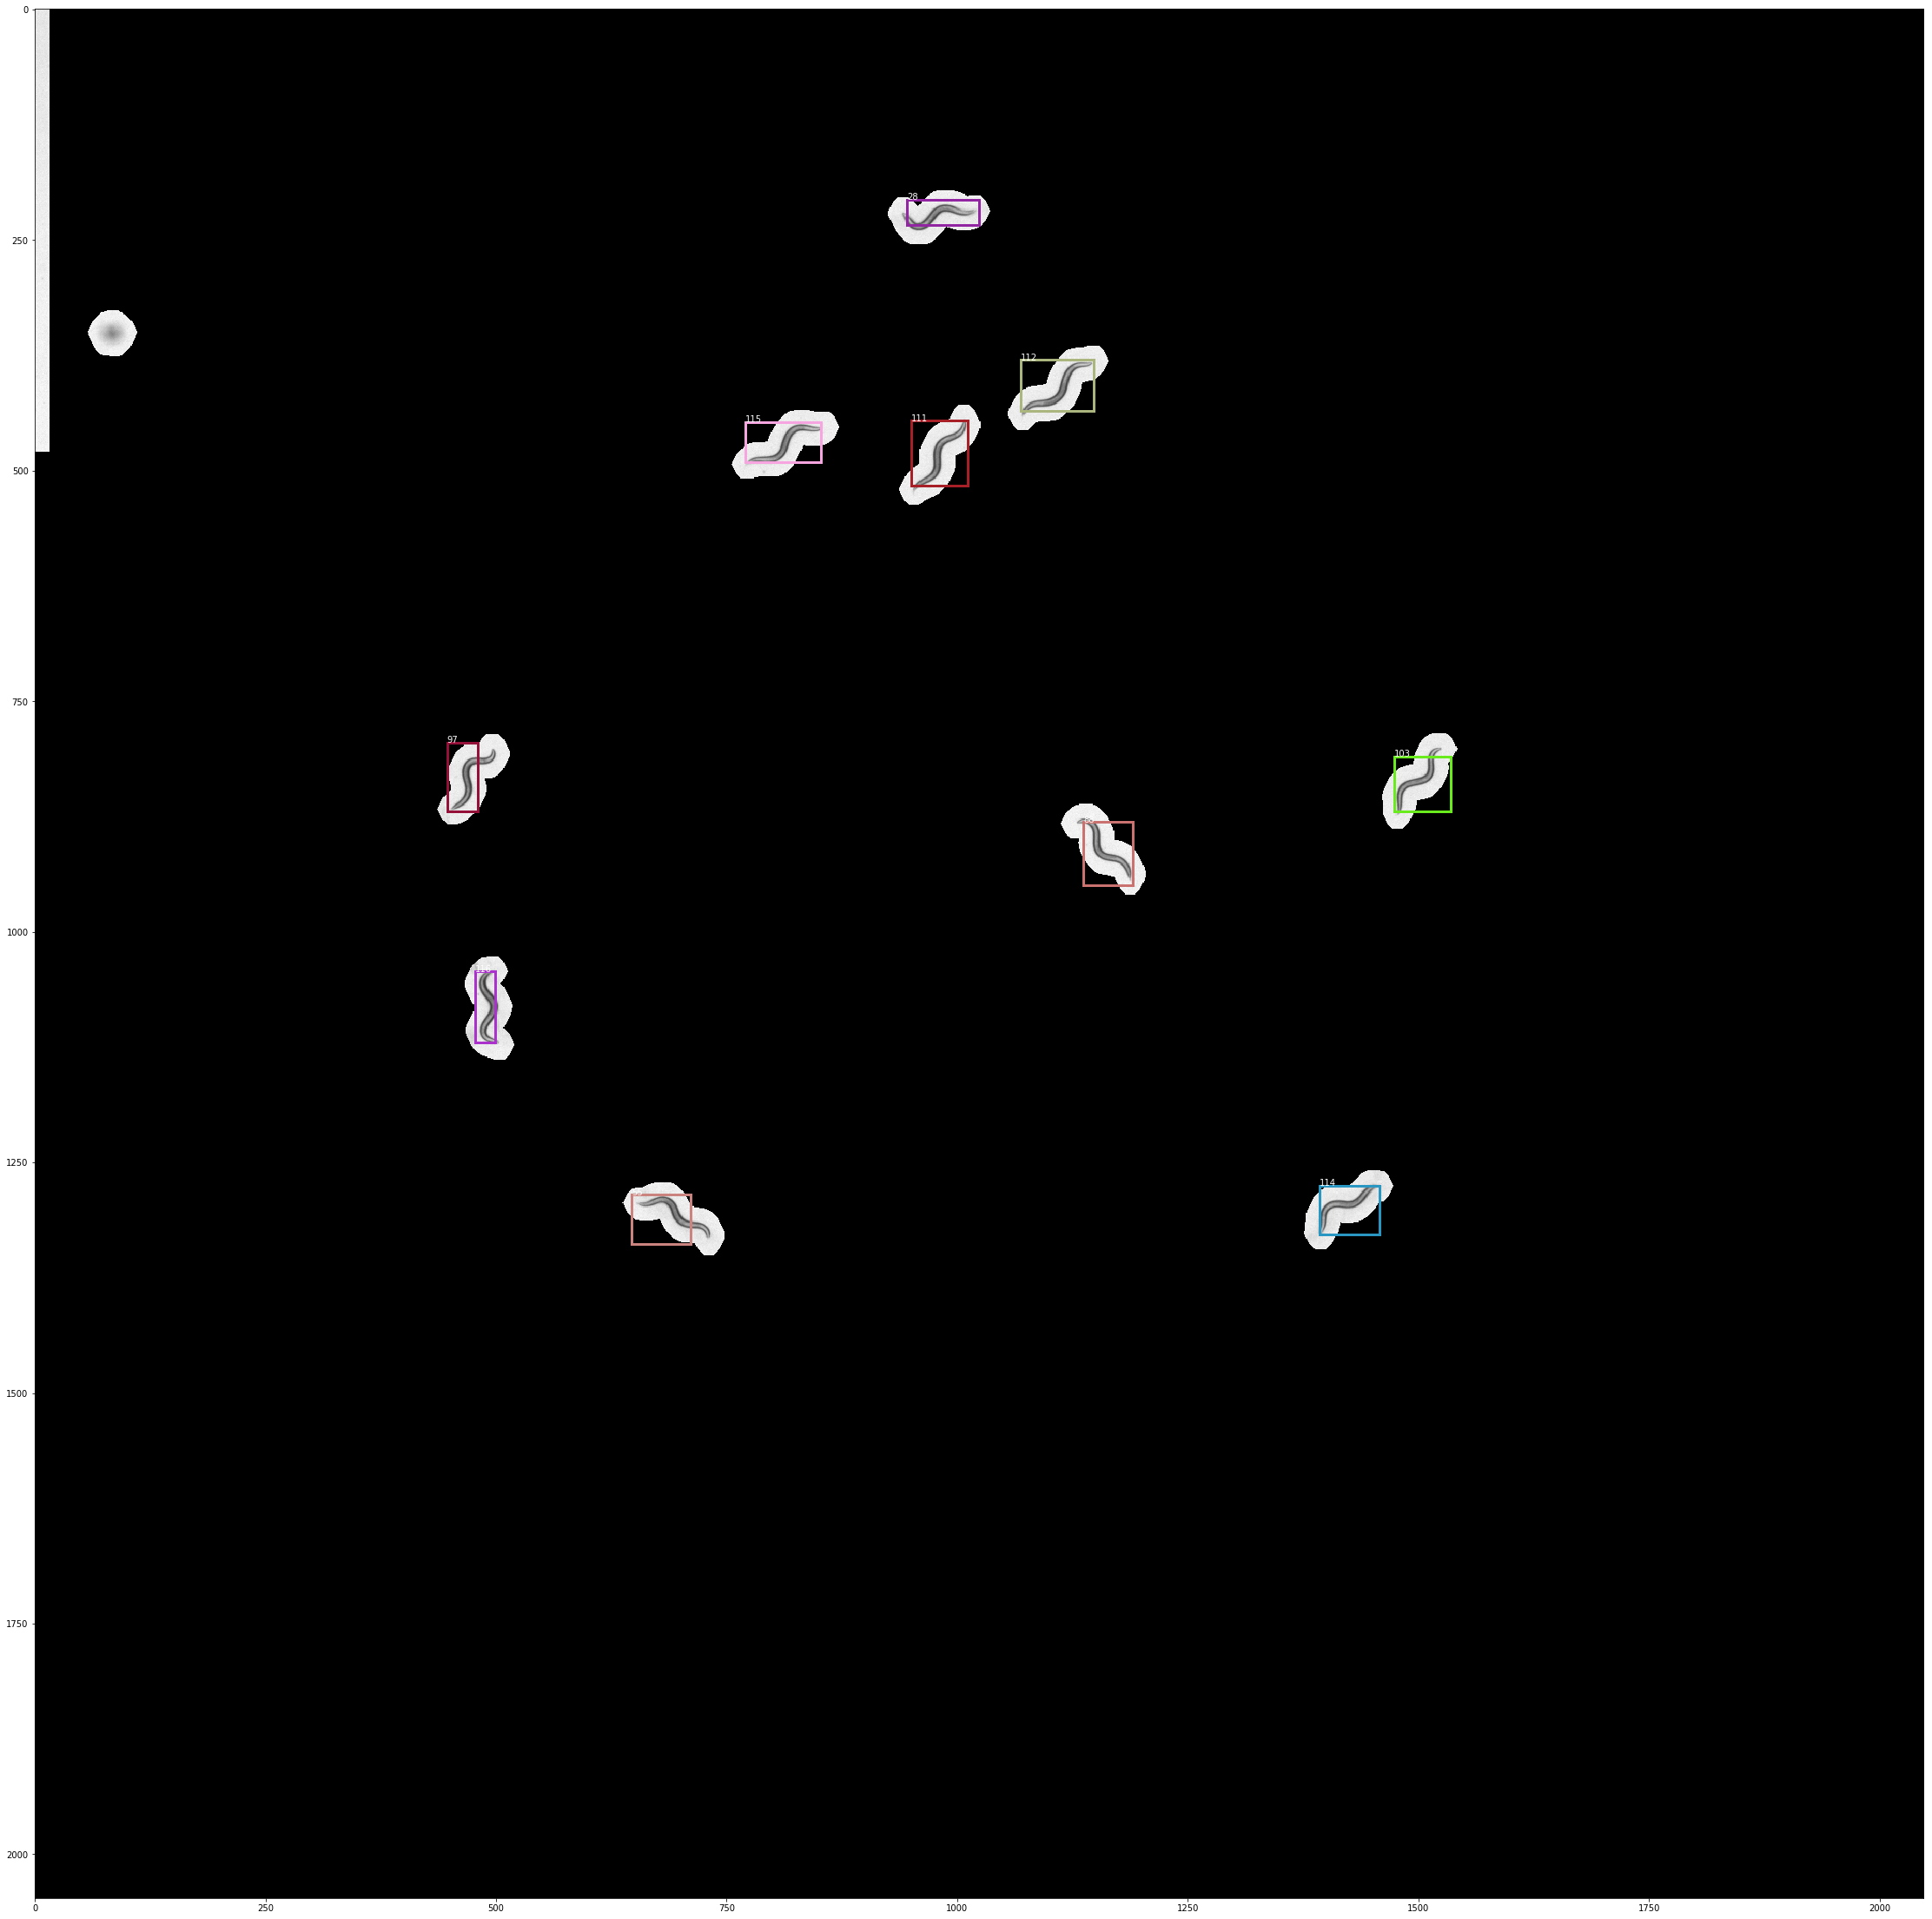

Worm IDs: [28.0, 55.0, 88.0, 97.0, 103.0, 112.0, 114.0, 116.0, 117.0, 118.0]


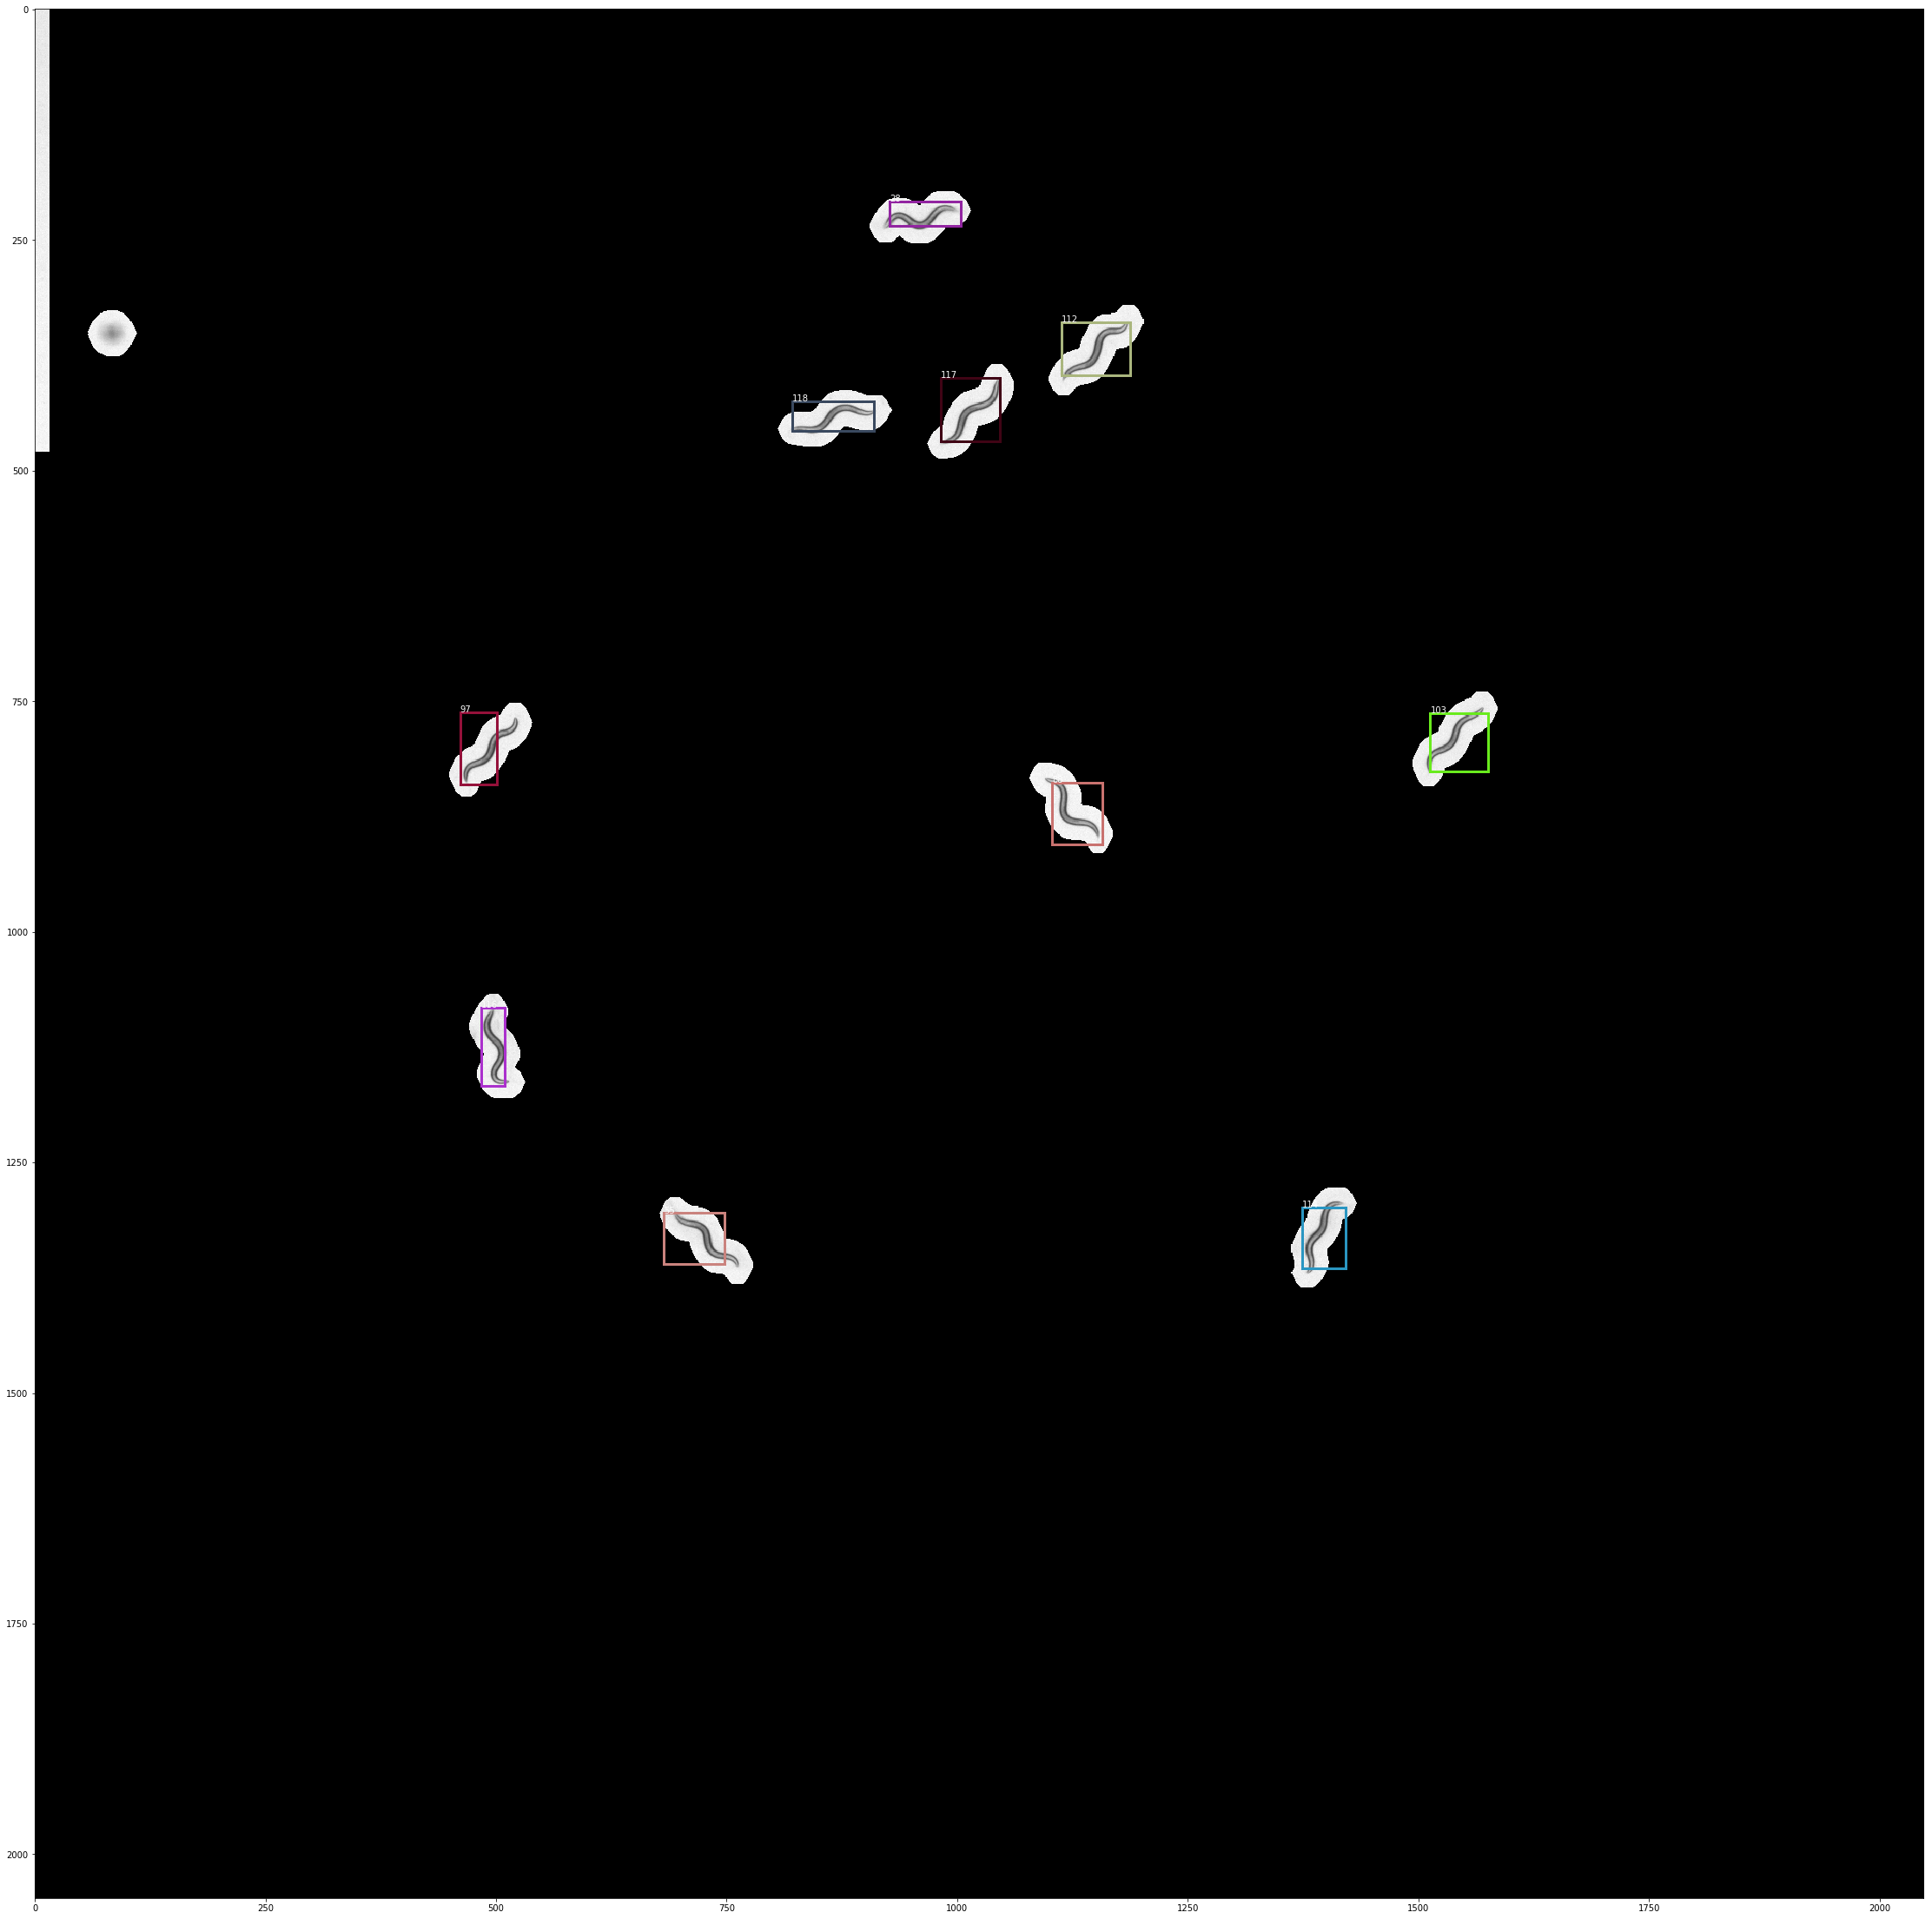

In [12]:
display = True
verbose = False
save_tracks = True
colours = np.random.rand(32,3)

OUTPUT_DIR = '../../Report/msc-project-draft/outputs/tracking'

#create instance of SORT
worm_tracker = sort.Sort(max_age=5, min_hits=0) 


# get detections
all_detections = [np.hstack((i['detection_boxes']*2048, np.expand_dims(i['detection_scores'],1))) for i in output_dicts_list]


for frame in range(len(all_detections)):
    
    output_images_dir = os.path.join(OUTPUT_DIR, MODEL_NAME, dataset, 'for_vid')
    os.makedirs(output_images_dir, exist_ok=True)
    
    # update SORT
    detections = all_detections[frame]

    
    ids = worm_tracker.update(detections)
    
    if verbose:
        print('Detections: {}'.format(detections))
        print('ids shape: {}'.format(ids.shape))
        print('ids: {}'.format(ids))
    
    print("Worm IDs: {}".format(sorted(ids[:,-1], key=int)))
    
    if(display):
        
        fName = FNAMES[frame]
    
        image_path = os.path.join(PATH_TO_TEST_IMAGES_DIR, '{}/image/image_{}.png'.format(fName,fName))

        img = Image.open(image_path)
        img_np = load_image_into_numpy_array(img)
        
        fig = plt.figure(figsize=(40,40))
        
        
        ax = fig.add_subplot(111, aspect='equal')
        ax.imshow(img_np)

        for d in ids:
            d = d.astype(np.int32)
            ax.add_patch(patches.Rectangle((d[1],d[0]),d[3]-d[1],d[2]-d[0],
                                           fill=False,
                                           lw=3,
                                           ec=colours[d[4]%32,:]))
            ax.set_adjustable('box-forced')
            plt.text(d[1],d[0],d[-1],color='w')
        
        output_path = os.path.join(output_images_dir, str(fName) + '.png')
#         extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
#         fig.savefig(output_path, bbox_inches=extent.expanded(1.1, 1.2))


#         ax_2 = fig.add_subplot(122, aspect='equal')
#         vis_util.visualize_boxes_and_labels_on_image_array(
#               img_np,
#               output_dicts_list[frame]['detection_boxes'],
#               output_dicts_list[frame]['detection_classes'],
#               output_dicts_list[frame]['detection_scores'],
#               category_index,
#               instance_masks=output_dicts_list[frame].get('detection_masks'),
#               use_normalized_coordinates=True,
#               line_thickness=2)
#         ax_2.imshow(img_np)

        plt.savefig(output_path, bbox_inches='tight', pad_inches=0)

        
        plt.legend()
        plt.show()
        plt.close

In [13]:
# display = True
# verbose = False
# save_tracks = True
# colours = np.random.rand(32,3)

# OUTPUT_DIR = '../../Report/msc-project-draft/outputs/tracking'

# #create instance of SORT
# worm_tracker = sort.Sort(max_age=5, min_hits=0) 

# # get detections
# all_detections = [np.hstack((i['detection_boxes']*2048, np.expand_dims(i['detection_scores'],1))) for i in output_dicts_list]


# for frame in range(len(all_detections)):
    
#     output_images_dir = os.path.join(OUTPUT_DIR, MODEL_NAME, dataset)
#     os.makedirs(output_images_dir, exist_ok=True)
    
#     # update SORT
#     detections = all_detections[frame]

    
#     ids = worm_tracker.update(detections)
    
#     if verbose:
#         print('Detections: {}'.format(detections))
#         print('ids shape: {}'.format(ids.shape))
#         print('ids: {}'.format(ids))
    
#     print("Worm IDs: {}".format(sorted(ids[:,-1], key=int)))
    
#     if(display):
        
#         fName = FNAMES[frame]
    
#         image_path = os.path.join(PATH_TO_TEST_IMAGES_DIR, '{}/image/image_{}.png'.format(fName,fName))

#         img = Image.open(image_path)
#         img_np = load_image_into_numpy_array(img)
        
#         fig = plt.figure(figsize=(20,20))
        
        
#         ax = fig.add_subplot(121, aspect='equal')
#         ax.imshow(img_np)

#         for d in ids:
#             d = d.astype(np.int32)
#             ax.add_patch(patches.Rectangle((d[1],d[0]),d[3]-d[1],d[2]-d[0],
#                                            fill=False,
#                                            lw=3,
#                                            ec=colours[d[4]%32,:]))
#             ax.set_adjustable('box-forced')
#             plt.text(d[1],d[0],d[-1],color='w')
        
#         output_path = os.path.join(output_images_dir, str(fName) + '.png')
#         extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
#         fig.savefig(output_path, bbox_inches=extent.expanded(1.1, 1.2))

# #         ax.imsave(output_path)
        
#         ax_2 = fig.add_subplot(122, aspect='equal')
#         vis_util.visualize_boxes_and_labels_on_image_array(
#               img_np,
#               output_dicts_list[frame]['detection_boxes'],
#               output_dicts_list[frame]['detection_classes'],
#               output_dicts_list[frame]['detection_scores'],
#               category_index,
#               instance_masks=output_dicts_list[frame].get('detection_masks'),
#               use_normalized_coordinates=True,
#               line_thickness=2)
#         ax_2.imshow(img_np)
        
#         plt.legend()
#         plt.show()
#         plt.close


In [14]:
output_path

'../../Report/msc-project-draft/outputs/tracking/resnet_101_atrous/fine_tuned_model_200k_poisson_brightness/CX11271_worms10_food1-10_Set1_Pos4_Ch4_19052017_113042/for_vid/3921.png'